In [1]:
!pip install catboost

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [3]:
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
%matplotlib inline

In [4]:
df=pd.read_csv("../../Integrated_data/merged_df_reward.csv",encoding="cp949")

In [5]:
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.interpolated()
        self.abmormaled()
        self.result=self.fill_missing_values()

    # ... (다른 클래스 함수 정의는 여기에 있어야 합니다)

    def interpolated(self):
        temp=[]
        temp2=[]
        for i in df['ID'].unique():
            try:
                temp.append(df[df['ID']==i].interpolate())
            except:
                temp.append(df[df['ID']==i])

        new_df=pd.concat(temp,axis=0)
        new_df.fillna(method='bfill',inplace=True)   
        for i in new_df['ID'].unique():
            temp_df=new_df[new_df['ID']==i].reset_index(drop=True)
            temp_df["height"].fillna(method='bfill',inplace=True)
            temp_df["weight"].fillna(method='bfill',inplace=True)
            temp_df["height"].fillna(method='ffill',inplace=True)
            temp_df["weight"].fillna(method='ffill',inplace=True)
            temp2.append(temp_df)
        new_df=pd.concat(temp2,axis=0)  
        self.df = new_df   
    def gap(self,first, last):
        gap_per=(last-first)/first*100
        return abs(gap_per)
        
    def abmormaled(self):
        temp = []
        for i in self.df['ID'].unique():
            temp_df = self.df[self.df['ID'] == i].reset_index(drop=True)
            for i in range(1, len(temp_df)):
                if temp_df.at[i, 'height'] <= temp_df.at[i - 1, 'height']:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
                if self.gap(temp_df.at[i - 1, 'height'], temp_df.at[i, 'height']) >= 16:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
            temp.append(temp_df)
        new_df2 = pd.concat(temp, axis=0)
        new_df2.reset_index(drop=True, inplace=True)
        self.df = new_df2

    def fill_missing_values(self):
        self.df["step_count"].fillna(self.df["step_count"].median(), inplace=True)
        self.df["burned calory"].fillna(self.df["burned calory"].median(), inplace=True)
        self.df["eat_calory"].fillna(self.df["eat_calory"].median(), inplace=True)
        self.df["Sleep_time"].fillna(self.df["Sleep_time"].median(), inplace=True)
        return self.df
    



In [6]:
import pandas as pd

class TimeSeriesLabeler:
    def __init__(self, term):
        self.term = term
        self.result_df = pd.DataFrame()
        self.labels = []

    def calculate_labels(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            label = []

            for i in range(self.term, len(df_id)):
                previous_days = df_id['weight'].iloc[i - self.term:i]
                current_weight = df_id['weight'].iloc[i]
                if current_weight > previous_days.mean().round(3):
                    label.append(1)
                elif current_weight == previous_days.mean().round(3):
                    label.append(0)
                elif current_weight < previous_days.mean().round(3):
                    label.append(2)
                else:
                    print("error")

            self.labels.extend(label)

    def create_result_df(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            df_id_drop = df_id.drop(index=range(self.term))
            self.result_df = pd.concat([self.result_df, df_id_drop])
        self.result_df['labels']= self.labels
        
    def get_labels(self):
        return self.labels

    def get_result_df(self):
        return self.result_df



In [7]:
for i in range(3):
    globals()['reward_data_{}'.format(i+1)]=pd.read_excel("../../Integrated_data/merged_df_reward_분리.xlsx",sheet_name = i)
    

In [8]:
# 데이터프레임 리스트 생성
dataframes = [reward_data_1, reward_data_2, reward_data_3]

# 반복문으로 데이터프레임 순차적으로 호출
for i, df in enumerate(dataframes, start=0):
    print(f"Processing reward_data_{i+1}")
    processor = DataProcessor(df)
    globals()['df_{}'.format(i+1)]=processor.result


Processing reward_data_1
Processing reward_data_2
Processing reward_data_3


# ID 별로 일주일 간격으로 몸무게 변화 라벨링(유지:0, 감소:2, 증가:1)

In [9]:
term = 5  # You can set your desired 'term' here

In [10]:
labeler_1 = TimeSeriesLabeler(term)
labeler_1.calculate_labels(df_1)  # Provide your DataFrame 'df' as input
labeler_1.create_result_df(df_1)  # Create the result DataFrame
labels = labeler_1.get_labels()
result_df_1 = labeler_1.get_result_df()

In [11]:
labeler_2 = TimeSeriesLabeler(term)
labeler_2.calculate_labels(df_2)  # Provide your DataFrame 'df' as input
labeler_2.create_result_df(df_2)  # Create the result DataFrame
labels = labeler_2.get_labels()
result_df_2 = labeler_2.get_result_df()

In [12]:
labeler_3 = TimeSeriesLabeler(term)
labeler_3.calculate_labels(df_3)  # Provide your DataFrame 'df' as input
labeler_3.create_result_df(df_3)  # Create the result DataFrame
labels = labeler_3.get_labels()
result_df_3 = labeler_3.get_result_df()

In [13]:
result_df_3.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#ASELLU,2022-07-19,2,6,164.0,64.0,5490.0,142.8,546.0,432.0,3,2
6,#ASELLU,2022-07-20,2,6,164.0,64.0,4100.0,142.8,546.0,432.0,3,1
7,#ASELLU,2022-07-21,2,6,164.0,64.0,4919.0,142.8,546.0,432.0,3,2
8,#ASELLU,2022-07-22,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2
9,#ASELLU,2022-07-23,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2


# 데이터 세트 로드

In [14]:
result_df_2.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#AAGQKY,2022-07-19,2,4,148.0,45.15,72.0,48.552,2000.0,468.0,2,0
6,#AAGQKY,2022-07-20,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
7,#AAGQKY,2022-07-21,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
8,#AAGQKY,2022-07-22,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
9,#AAGQKY,2022-07-23,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2


In [15]:
X_1=result_df_1.iloc[:,[4,5,6,7,8,9]]
y_1=result_df_1.iloc[:,-1]

X_2=result_df_2.iloc[:,[4,5,6,7,8,9]]
y_2=result_df_2.iloc[:,-1]

X_3=result_df_3.iloc[:,[4,5,6,7,8,9]]
y_3=result_df_3.iloc[:,-1]

In [16]:
y_1

5      2
6      2
7      2
8      0
9      0
      ..
177    0
178    0
179    0
180    0
181    0
Name: labels, Length: 37347, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_3 = StandardScaler()

X_scaler_1=scaler_1.fit_transform(X_1)
X_scaler_2= scaler_2.fit_transform(X_2)
X_scaler_3= scaler_3.fit_transform(X_3)


smote_1 = SMOTE(random_state=0)
X_over_1,y_over_1 = smote_1.fit_resample(X_scaler_1,y_1)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_1.shape, y_1.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_1.shape, y_over_1.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_1).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_1).value_counts())

smote_2 = SMOTE(random_state=0)
X_over_2,y_over_2 = smote_2.fit_resample(X_scaler_2,y_2)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_2.shape, y_2.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_2.shape, y_over_2.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_2).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_2).value_counts())

smote_3 = SMOTE(random_state=0)
X_over_3,y_over_3 = smote_3.fit_resample(X_scaler_3,y_3)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_3.shape, y_3.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_3.shape, y_over_3.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_3).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_3).value_counts())






SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (37347, 6) (37347,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (100797, 6) (100797,)
SMOTE 적용 전 레이블 값 분포: 
 0    33599
1     2318
2     1430
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    33599
0    33599
1    33599
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (13983, 6) (13983,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (37818, 6) (37818,)
SMOTE 적용 전 레이블 값 분포: 
 0    12606
1      752
2      625
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    12606
2    12606
1    12606
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (4602, 6) (4602,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (10857, 6) (10857,)
SMOTE 적용 전 레이블 값 분포: 
 0    3619
1     534
2     449
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    3619
1    3619
0    3619
Name: labels, dtype: int64


# 데이터 스케일링

## Train, Test dataset 나누기

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_over_1, y_over_1, test_size=0.20)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_over_2, y_over_2, test_size=0.20)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_over_3, y_over_3, test_size=0.20)

## Global train 데이터 세트 만들기

In [19]:
X_train = np.concatenate((X_train_1,X_train_2,X_train_3), axis=0)
y_train = np.concatenate((y_train_1,y_train_2,y_train_3), axis=0)

In [20]:
X_test = np.concatenate((X_test_1,X_test_2,X_test_3), axis=0)
y_test = np.concatenate((y_test_1,y_test_2,y_test_3), axis=0)

In [21]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

## Client train 데이터 세트 만들기

In [22]:
X_train_1 = torch.FloatTensor(X_train_1)
X_test_1 = torch.FloatTensor(X_test_1)
y_train_1 = torch.LongTensor(y_train_1.to_numpy())
y_test_1 = torch.LongTensor(y_test_1.to_numpy())

train_dataset_1=TensorDataset(X_train_1, y_train_1)
test_dataset_1=TensorDataset(X_test_1, y_test_1)

In [23]:
X_train_2 = torch.FloatTensor(X_train_2)
X_test_2 = torch.FloatTensor(X_test_2)
y_train_2 = torch.LongTensor(y_train_2.to_numpy())
y_test_2 = torch.LongTensor(y_test_2.to_numpy())

train_dataset_2=TensorDataset(X_train_2, y_train_2)
test_dataset_2=TensorDataset(X_test_2, y_test_2)

In [24]:
X_train_3 = torch.FloatTensor(X_train_3)
X_test_3 = torch.FloatTensor(X_test_3)
y_train_3 = torch.LongTensor(y_train_3.to_numpy())
y_test_3 = torch.LongTensor(y_test_3.to_numpy())

train_dataset_3=TensorDataset(X_train_3, y_train_3)
test_dataset_3=TensorDataset(X_test_3, y_test_3)

In [25]:
# from sklearn.model_selection import StratifiedKFold
# skf=StratifiedKFold(n_splits=10)
# skf.get_n_splits(X_train_1,y_train_1)

In [26]:
X_train_over=X_over_3
y_train_over=y_over_3

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.09434. Saving Model!
epoch 01, loss: 1.10235, acc: 0.33292, val_loss: 1.09434, val_accuracy: 0.33241


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 1.09434 to 1.08868. Saving Model!
epoch 02, loss: 1.09462, acc: 0.33364, val_loss: 1.08868, val_accuracy: 0.34991


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


[INFO] val_acc has been improved from 1.08868 to 1.08436. Saving Model!
epoch 03, loss: 1.08895, acc: 0.36230, val_loss: 1.08436, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


[INFO] val_acc has been improved from 1.08436 to 1.08089. Saving Model!
epoch 04, loss: 1.08400, acc: 0.38154, val_loss: 1.08089, val_accuracy: 0.46685


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


[INFO] val_acc has been improved from 1.08089 to 1.07799. Saving Model!
epoch 05, loss: 1.07932, acc: 0.39975, val_loss: 1.07799, val_accuracy: 0.44936


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


[INFO] val_acc has been improved from 1.07799 to 1.07546. Saving Model!
epoch 06, loss: 1.07491, acc: 0.42421, val_loss: 1.07546, val_accuracy: 0.42541


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


[INFO] val_acc has been improved from 1.07546 to 1.07333. Saving Model!
epoch 07, loss: 1.07066, acc: 0.44161, val_loss: 1.07333, val_accuracy: 0.41529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


[INFO] val_acc has been improved from 1.07333 to 1.07164. Saving Model!
epoch 08, loss: 1.06680, acc: 0.43793, val_loss: 1.07164, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


[INFO] val_acc has been improved from 1.07164 to 1.07034. Saving Model!
epoch 09, loss: 1.06339, acc: 0.43486, val_loss: 1.07034, val_accuracy: 0.40147


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 1.07034 to 1.06919. Saving Model!
epoch 10, loss: 1.06040, acc: 0.43199, val_loss: 1.06919, val_accuracy: 0.39871


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 1.06919 to 1.06782. Saving Model!
epoch 11, loss: 1.05772, acc: 0.42851, val_loss: 1.06782, val_accuracy: 0.39779


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


[INFO] val_acc has been improved from 1.06782 to 1.06639. Saving Model!
epoch 12, loss: 1.05515, acc: 0.42769, val_loss: 1.06639, val_accuracy: 0.40239


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


[INFO] val_acc has been improved from 1.06639 to 1.06499. Saving Model!
epoch 13, loss: 1.05253, acc: 0.43496, val_loss: 1.06499, val_accuracy: 0.40331


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


[INFO] val_acc has been improved from 1.06499 to 1.06331. Saving Model!
epoch 14, loss: 1.04978, acc: 0.44274, val_loss: 1.06331, val_accuracy: 0.40331


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


[INFO] val_acc has been improved from 1.06331 to 1.06144. Saving Model!
epoch 15, loss: 1.04689, acc: 0.44929, val_loss: 1.06144, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


[INFO] val_acc has been improved from 1.06144 to 1.05937. Saving Model!
epoch 16, loss: 1.04395, acc: 0.45369, val_loss: 1.05937, val_accuracy: 0.41344


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 1.05937 to 1.05731. Saving Model!
epoch 17, loss: 1.04097, acc: 0.45543, val_loss: 1.05731, val_accuracy: 0.44567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


[INFO] val_acc has been improved from 1.05731 to 1.05531. Saving Model!
epoch 18, loss: 1.03803, acc: 0.45482, val_loss: 1.05531, val_accuracy: 0.45580


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


[INFO] val_acc has been improved from 1.05531 to 1.05360. Saving Model!
epoch 19, loss: 1.03504, acc: 0.46229, val_loss: 1.05360, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


[INFO] val_acc has been improved from 1.05360 to 1.05254. Saving Model!
epoch 20, loss: 1.03208, acc: 0.46229, val_loss: 1.05254, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


[INFO] val_acc has been improved from 1.05254 to 1.05235. Saving Model!
epoch 21, loss: 1.02914, acc: 0.45922, val_loss: 1.05235, val_accuracy: 0.46225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 22, loss: 1.02623, acc: 0.46229, val_loss: 1.05300, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 23, loss: 1.02325, acc: 0.46648, val_loss: 1.05418, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 24, loss: 1.02020, acc: 0.46955, val_loss: 1.05560, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 25, loss: 1.01703, acc: 0.46710, val_loss: 1.05724, val_accuracy: 0.45580


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 26, loss: 1.01375, acc: 0.45809, val_loss: 1.05885, val_accuracy: 0.45948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 27, loss: 1.01044, acc: 0.46137, val_loss: 1.06000, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 28, loss: 1.00709, acc: 0.46822, val_loss: 1.06057, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 29, loss: 1.00370, acc: 0.48194, val_loss: 1.06110, val_accuracy: 0.47422


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 30, loss: 1.00023, acc: 0.48746, val_loss: 1.06200, val_accuracy: 0.47974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 31, loss: 0.99670, acc: 0.49227, val_loss: 1.06373, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 32, loss: 0.99304, acc: 0.48716, val_loss: 1.06613, val_accuracy: 0.47145


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 33, loss: 0.98928, acc: 0.48951, val_loss: 1.06868, val_accuracy: 0.47330


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 34, loss: 0.98545, acc: 0.49289, val_loss: 1.07165, val_accuracy: 0.46225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 35, loss: 0.98149, acc: 0.49657, val_loss: 1.07508, val_accuracy: 0.44383


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 36, loss: 0.97740, acc: 0.49452, val_loss: 1.07822, val_accuracy: 0.43462


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 37, loss: 0.97317, acc: 0.49749, val_loss: 1.08112, val_accuracy: 0.44107


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]


epoch 38, loss: 0.96878, acc: 0.51029, val_loss: 1.08455, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 39, loss: 0.96434, acc: 0.51448, val_loss: 1.08785, val_accuracy: 0.44659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 40, loss: 0.95981, acc: 0.51530, val_loss: 1.09057, val_accuracy: 0.44843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 41, loss: 0.95518, acc: 0.51479, val_loss: 1.09550, val_accuracy: 0.44567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 42, loss: 0.95036, acc: 0.51735, val_loss: 1.10209, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 43, loss: 0.94540, acc: 0.52093, val_loss: 1.10656, val_accuracy: 0.45028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 44, loss: 0.94042, acc: 0.52472, val_loss: 1.11397, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 45, loss: 0.93532, acc: 0.53055, val_loss: 1.11779, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 46, loss: 0.93018, acc: 0.54201, val_loss: 1.12496, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 47, loss: 0.92494, acc: 0.54365, val_loss: 1.13214, val_accuracy: 0.45212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 48, loss: 0.91955, acc: 0.54713, val_loss: 1.14237, val_accuracy: 0.46133


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 49, loss: 0.91412, acc: 0.55573, val_loss: 1.14347, val_accuracy: 0.44936


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 50, loss: 0.90909, acc: 0.55255, val_loss: 1.16656, val_accuracy: 0.43094


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 51, loss: 0.90508, acc: 0.56688, val_loss: 1.15758, val_accuracy: 0.43094


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 52, loss: 0.90042, acc: 0.56678, val_loss: 1.17540, val_accuracy: 0.38029


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 53, loss: 0.89351, acc: 0.57251, val_loss: 1.19258, val_accuracy: 0.38582


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 54, loss: 0.88957, acc: 0.58571, val_loss: 1.18295, val_accuracy: 0.35635


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 55, loss: 0.88542, acc: 0.58356, val_loss: 1.19712, val_accuracy: 0.38490


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 56, loss: 0.87908, acc: 0.60025, val_loss: 1.21389, val_accuracy: 0.37293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 57, loss: 0.87518, acc: 0.60383, val_loss: 1.20265, val_accuracy: 0.37385


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 58, loss: 0.87052, acc: 0.60833, val_loss: 1.21838, val_accuracy: 0.36464


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 59, loss: 0.86465, acc: 0.61099, val_loss: 1.23902, val_accuracy: 0.37385


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 60, loss: 0.86058, acc: 0.61826, val_loss: 1.22482, val_accuracy: 0.34991


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 61, loss: 0.85597, acc: 0.61570, val_loss: 1.24975, val_accuracy: 0.37293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 62, loss: 0.85031, acc: 0.62317, val_loss: 1.25936, val_accuracy: 0.37477


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 63, loss: 0.84570, acc: 0.62583, val_loss: 1.25518, val_accuracy: 0.36464


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 64, loss: 0.84196, acc: 0.62962, val_loss: 1.28167, val_accuracy: 0.37753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 65, loss: 0.83751, acc: 0.62532, val_loss: 1.28993, val_accuracy: 0.38674


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 66, loss: 0.83363, acc: 0.64190, val_loss: 1.27575, val_accuracy: 0.36372


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 67, loss: 0.82947, acc: 0.62993, val_loss: 1.30910, val_accuracy: 0.38858


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 68, loss: 0.82350, acc: 0.63781, val_loss: 1.30784, val_accuracy: 0.39503


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 69, loss: 0.82021, acc: 0.65111, val_loss: 1.30949, val_accuracy: 0.38398


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 70, loss: 0.81704, acc: 0.63545, val_loss: 1.32185, val_accuracy: 0.40055


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 71, loss: 0.81088, acc: 0.64937, val_loss: 1.33883, val_accuracy: 0.40792


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 72, loss: 0.80772, acc: 0.65101, val_loss: 1.33376, val_accuracy: 0.39042


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 73, loss: 0.80434, acc: 0.64415, val_loss: 1.33862, val_accuracy: 0.39963


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 74, loss: 0.79934, acc: 0.66001, val_loss: 1.37700, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 75, loss: 0.79671, acc: 0.65091, val_loss: 1.34913, val_accuracy: 0.39595


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 76, loss: 0.79255, acc: 0.66237, val_loss: 1.38128, val_accuracy: 0.41160


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 77, loss: 0.78812, acc: 0.65848, val_loss: 1.38460, val_accuracy: 0.40976


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 78, loss: 0.78546, acc: 0.66687, val_loss: 1.39113, val_accuracy: 0.40608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 79, loss: 0.78152, acc: 0.66605, val_loss: 1.38076, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 80, loss: 0.77776, acc: 0.67291, val_loss: 1.42529, val_accuracy: 0.43002


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 81, loss: 0.77543, acc: 0.66114, val_loss: 1.38756, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 82, loss: 0.77188, acc: 0.68314, val_loss: 1.43089, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 83, loss: 0.76862, acc: 0.67107, val_loss: 1.41326, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 84, loss: 0.76658, acc: 0.68580, val_loss: 1.43883, val_accuracy: 0.41529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 85, loss: 0.76291, acc: 0.66810, val_loss: 1.41315, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 86, loss: 0.75888, acc: 0.68980, val_loss: 1.45696, val_accuracy: 0.43186


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 87, loss: 0.75577, acc: 0.68325, val_loss: 1.43150, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 88, loss: 0.75191, acc: 0.69072, val_loss: 1.43972, val_accuracy: 0.42634


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 89, loss: 0.74844, acc: 0.69440, val_loss: 1.47132, val_accuracy: 0.43002


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 90, loss: 0.74652, acc: 0.68795, val_loss: 1.43127, val_accuracy: 0.43831


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 91, loss: 0.74449, acc: 0.69553, val_loss: 1.48759, val_accuracy: 0.42541


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 92, loss: 0.74203, acc: 0.68427, val_loss: 1.44700, val_accuracy: 0.44475


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 93, loss: 0.74075, acc: 0.69502, val_loss: 1.48150, val_accuracy: 0.41344


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 94, loss: 0.73776, acc: 0.68079, val_loss: 1.46139, val_accuracy: 0.43923


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 95, loss: 0.73272, acc: 0.69890, val_loss: 1.48505, val_accuracy: 0.43738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 96, loss: 0.72861, acc: 0.70392, val_loss: 1.48370, val_accuracy: 0.42541


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 97, loss: 0.72729, acc: 0.70095, val_loss: 1.47310, val_accuracy: 0.44567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 98, loss: 0.72580, acc: 0.70341, val_loss: 1.51217, val_accuracy: 0.43462


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 99, loss: 0.72339, acc: 0.70392, val_loss: 1.46111, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 100, loss: 0.72076, acc: 0.70238, val_loss: 1.51633, val_accuracy: 0.44383


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 101, loss: 0.71704, acc: 0.70873, val_loss: 1.49629, val_accuracy: 0.44199


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 102, loss: 0.71326, acc: 0.70586, val_loss: 1.47508, val_accuracy: 0.45304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 103, loss: 0.71189, acc: 0.70945, val_loss: 1.53095, val_accuracy: 0.44383


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 104, loss: 0.71107, acc: 0.70975, val_loss: 1.47749, val_accuracy: 0.46041


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 105, loss: 0.70812, acc: 0.71057, val_loss: 1.52093, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 106, loss: 0.70516, acc: 0.70801, val_loss: 1.51400, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


epoch 107, loss: 0.70297, acc: 0.71272, val_loss: 1.50617, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 108, loss: 0.69979, acc: 0.71098, val_loss: 1.51454, val_accuracy: 0.45212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 109, loss: 0.69637, acc: 0.71641, val_loss: 1.51748, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 110, loss: 0.69452, acc: 0.71784, val_loss: 1.51422, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 111, loss: 0.69323, acc: 0.71221, val_loss: 1.51012, val_accuracy: 0.46133


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 112, loss: 0.69125, acc: 0.71866, val_loss: 1.53813, val_accuracy: 0.44383


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 113, loss: 0.68942, acc: 0.70955, val_loss: 1.48642, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 114, loss: 0.68920, acc: 0.71937, val_loss: 1.57395, val_accuracy: 0.45304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 115, loss: 0.68871, acc: 0.71385, val_loss: 1.49179, val_accuracy: 0.46777


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 116, loss: 0.68497, acc: 0.71968, val_loss: 1.53415, val_accuracy: 0.46041


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 117, loss: 0.67991, acc: 0.71405, val_loss: 1.53994, val_accuracy: 0.46225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 118, loss: 0.67760, acc: 0.72337, val_loss: 1.50043, val_accuracy: 0.45856


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 119, loss: 0.67600, acc: 0.72060, val_loss: 1.55277, val_accuracy: 0.46225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 120, loss: 0.67406, acc: 0.71671, val_loss: 1.51888, val_accuracy: 0.47514


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 121, loss: 0.67293, acc: 0.72316, val_loss: 1.53267, val_accuracy: 0.46225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 122, loss: 0.67164, acc: 0.72081, val_loss: 1.53471, val_accuracy: 0.47238


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 123, loss: 0.66808, acc: 0.72510, val_loss: 1.53876, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 124, loss: 0.66404, acc: 0.72490, val_loss: 1.52800, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 125, loss: 0.66240, acc: 0.72480, val_loss: 1.54420, val_accuracy: 0.47974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 126, loss: 0.66161, acc: 0.73309, val_loss: 1.54109, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 127, loss: 0.65948, acc: 0.72347, val_loss: 1.51921, val_accuracy: 0.47330


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 128, loss: 0.65768, acc: 0.73145, val_loss: 1.57777, val_accuracy: 0.46685


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 129, loss: 0.65703, acc: 0.73206, val_loss: 1.50842, val_accuracy: 0.47882


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 130, loss: 0.65552, acc: 0.73002, val_loss: 1.57574, val_accuracy: 0.47238


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 131, loss: 0.65224, acc: 0.73002, val_loss: 1.53937, val_accuracy: 0.48895


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 132, loss: 0.64910, acc: 0.73626, val_loss: 1.54295, val_accuracy: 0.46869


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 133, loss: 0.64760, acc: 0.72930, val_loss: 1.57376, val_accuracy: 0.48711


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 134, loss: 0.64567, acc: 0.73882, val_loss: 1.54562, val_accuracy: 0.48066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 135, loss: 0.64269, acc: 0.73780, val_loss: 1.56085, val_accuracy: 0.48066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 136, loss: 0.64096, acc: 0.73606, val_loss: 1.56297, val_accuracy: 0.49816


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 137, loss: 0.64044, acc: 0.74097, val_loss: 1.56382, val_accuracy: 0.47145


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 138, loss: 0.63955, acc: 0.73309, val_loss: 1.55081, val_accuracy: 0.49079


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 139, loss: 0.63814, acc: 0.73943, val_loss: 1.59988, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 140, loss: 0.63759, acc: 0.73933, val_loss: 1.52184, val_accuracy: 0.48158


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 141, loss: 0.63858, acc: 0.73534, val_loss: 1.62558, val_accuracy: 0.47145


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 142, loss: 0.63692, acc: 0.74619, val_loss: 1.54366, val_accuracy: 0.48527


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 143, loss: 0.63127, acc: 0.73851, val_loss: 1.57088, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 144, loss: 0.62701, acc: 0.73964, val_loss: 1.60367, val_accuracy: 0.48066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 145, loss: 0.62656, acc: 0.75018, val_loss: 1.54094, val_accuracy: 0.48527


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 146, loss: 0.62604, acc: 0.74240, val_loss: 1.60405, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 147, loss: 0.62476, acc: 0.74220, val_loss: 1.57027, val_accuracy: 0.49263


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 148, loss: 0.62385, acc: 0.74598, val_loss: 1.57874, val_accuracy: 0.47514


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 149, loss: 0.62195, acc: 0.74189, val_loss: 1.58993, val_accuracy: 0.49448


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 150, loss: 0.61792, acc: 0.75182, val_loss: 1.58079, val_accuracy: 0.49540


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 151, loss: 0.61482, acc: 0.75038, val_loss: 1.58470, val_accuracy: 0.48343


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 152, loss: 0.61456, acc: 0.75049, val_loss: 1.58754, val_accuracy: 0.49632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 153, loss: 0.61483, acc: 0.74926, val_loss: 1.59707, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 154, loss: 0.61317, acc: 0.74690, val_loss: 1.56294, val_accuracy: 0.48803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 155, loss: 0.61112, acc: 0.74967, val_loss: 1.62352, val_accuracy: 0.49632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 156, loss: 0.60963, acc: 0.76103, val_loss: 1.56061, val_accuracy: 0.48619


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 157, loss: 0.60747, acc: 0.75386, val_loss: 1.60326, val_accuracy: 0.49816


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 158, loss: 0.60452, acc: 0.75919, val_loss: 1.58630, val_accuracy: 0.49632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 159, loss: 0.60240, acc: 0.75663, val_loss: 1.56572, val_accuracy: 0.48987


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 160, loss: 0.60165, acc: 0.75458, val_loss: 1.61517, val_accuracy: 0.50184


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


epoch 161, loss: 0.60109, acc: 0.76348, val_loss: 1.56261, val_accuracy: 0.49079


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 162, loss: 0.59943, acc: 0.75612, val_loss: 1.60754, val_accuracy: 0.49908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 163, loss: 0.59800, acc: 0.75919, val_loss: 1.57769, val_accuracy: 0.49816


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 164, loss: 0.59798, acc: 0.75417, val_loss: 1.60517, val_accuracy: 0.49171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 165, loss: 0.59832, acc: 0.75427, val_loss: 1.57949, val_accuracy: 0.49355


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 166, loss: 0.59795, acc: 0.75028, val_loss: 1.62619, val_accuracy: 0.49724


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 167, loss: 0.59575, acc: 0.75509, val_loss: 1.55396, val_accuracy: 0.48527


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 168, loss: 0.59363, acc: 0.75581, val_loss: 1.62866, val_accuracy: 0.50368


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 169, loss: 0.59113, acc: 0.76983, val_loss: 1.56215, val_accuracy: 0.49724


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 170, loss: 0.58772, acc: 0.76123, val_loss: 1.58996, val_accuracy: 0.50645


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 171, loss: 0.58508, acc: 0.76307, val_loss: 1.60907, val_accuracy: 0.50552


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 172, loss: 0.58445, acc: 0.76553, val_loss: 1.55732, val_accuracy: 0.49540


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 173, loss: 0.58521, acc: 0.76113, val_loss: 1.64101, val_accuracy: 0.51381


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 174, loss: 0.58572, acc: 0.77136, val_loss: 1.55861, val_accuracy: 0.49263


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 175, loss: 0.58466, acc: 0.75806, val_loss: 1.62419, val_accuracy: 0.50092


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 176, loss: 0.58306, acc: 0.76041, val_loss: 1.58853, val_accuracy: 0.49632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 177, loss: 0.58176, acc: 0.76226, val_loss: 1.59558, val_accuracy: 0.49908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 178, loss: 0.57901, acc: 0.76430, val_loss: 1.59757, val_accuracy: 0.51105


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 179, loss: 0.57512, acc: 0.77147, val_loss: 1.58408, val_accuracy: 0.50921


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 180, loss: 0.57313, acc: 0.76717, val_loss: 1.59242, val_accuracy: 0.50645


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 181, loss: 0.57346, acc: 0.76973, val_loss: 1.58970, val_accuracy: 0.50737


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 182, loss: 0.57390, acc: 0.76860, val_loss: 1.61167, val_accuracy: 0.50368


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 183, loss: 0.57285, acc: 0.76666, val_loss: 1.56945, val_accuracy: 0.49816


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 184, loss: 0.57126, acc: 0.76471, val_loss: 1.63016, val_accuracy: 0.51842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 185, loss: 0.56988, acc: 0.77617, val_loss: 1.55542, val_accuracy: 0.50737


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 186, loss: 0.56820, acc: 0.77024, val_loss: 1.61986, val_accuracy: 0.51750


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 187, loss: 0.56590, acc: 0.77802, val_loss: 1.57910, val_accuracy: 0.50921


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 188, loss: 0.56329, acc: 0.77188, val_loss: 1.57986, val_accuracy: 0.51013


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 189, loss: 0.56194, acc: 0.77229, val_loss: 1.61230, val_accuracy: 0.51934


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 190, loss: 0.56171, acc: 0.77853, val_loss: 1.55651, val_accuracy: 0.51105


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 191, loss: 0.56159, acc: 0.77300, val_loss: 1.63009, val_accuracy: 0.51842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 192, loss: 0.56120, acc: 0.77832, val_loss: 1.56160, val_accuracy: 0.50552


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 193, loss: 0.56031, acc: 0.77177, val_loss: 1.61680, val_accuracy: 0.51105


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 194, loss: 0.56024, acc: 0.77269, val_loss: 1.57791, val_accuracy: 0.51105


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 195, loss: 0.56130, acc: 0.77300, val_loss: 1.60862, val_accuracy: 0.51473


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


epoch 196, loss: 0.56079, acc: 0.77157, val_loss: 1.57665, val_accuracy: 0.51105


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 197, loss: 0.55772, acc: 0.77515, val_loss: 1.61454, val_accuracy: 0.51565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 198, loss: 0.55341, acc: 0.77679, val_loss: 1.56902, val_accuracy: 0.50829


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


epoch 199, loss: 0.55111, acc: 0.77884, val_loss: 1.61164, val_accuracy: 0.51842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 200, loss: 0.55070, acc: 0.78365, val_loss: 1.58957, val_accuracy: 0.51842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 201, loss: 0.55005, acc: 0.77730, val_loss: 1.57948, val_accuracy: 0.51013


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 202, loss: 0.54900, acc: 0.77822, val_loss: 1.62581, val_accuracy: 0.52026


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 203, loss: 0.54878, acc: 0.78058, val_loss: 1.54606, val_accuracy: 0.51105


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 204, loss: 0.54942, acc: 0.77863, val_loss: 1.65151, val_accuracy: 0.52578


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 205, loss: 0.54938, acc: 0.78078, val_loss: 1.55277, val_accuracy: 0.51473


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 206, loss: 0.54587, acc: 0.77986, val_loss: 1.60736, val_accuracy: 0.51565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 207, loss: 0.54238, acc: 0.78221, val_loss: 1.59816, val_accuracy: 0.52210


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 208, loss: 0.54121, acc: 0.78784, val_loss: 1.56680, val_accuracy: 0.51750


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 209, loss: 0.54096, acc: 0.78242, val_loss: 1.62621, val_accuracy: 0.52486


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 210, loss: 0.54025, acc: 0.78713, val_loss: 1.56570, val_accuracy: 0.51934


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 211, loss: 0.53855, acc: 0.78457, val_loss: 1.60821, val_accuracy: 0.51842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 212, loss: 0.53782, acc: 0.78375, val_loss: 1.58992, val_accuracy: 0.52302


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 213, loss: 0.53893, acc: 0.78672, val_loss: 1.60775, val_accuracy: 0.52210


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 214, loss: 0.54030, acc: 0.77945, val_loss: 1.59098, val_accuracy: 0.52026


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 215, loss: 0.54012, acc: 0.78487, val_loss: 1.63341, val_accuracy: 0.52394


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 216, loss: 0.53816, acc: 0.78109, val_loss: 1.55434, val_accuracy: 0.51934


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 217, loss: 0.53678, acc: 0.78498, val_loss: 1.65267, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 218, loss: 0.53571, acc: 0.78958, val_loss: 1.55378, val_accuracy: 0.51750


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 219, loss: 0.53246, acc: 0.78600, val_loss: 1.61357, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 220, loss: 0.52911, acc: 0.79142, val_loss: 1.60143, val_accuracy: 0.53039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 221, loss: 0.52755, acc: 0.79030, val_loss: 1.55666, val_accuracy: 0.52670


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 222, loss: 0.52876, acc: 0.79060, val_loss: 1.64709, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 223, loss: 0.53052, acc: 0.79224, val_loss: 1.55049, val_accuracy: 0.52394


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 224, loss: 0.52964, acc: 0.78753, val_loss: 1.63577, val_accuracy: 0.52762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 225, loss: 0.52800, acc: 0.78784, val_loss: 1.58992, val_accuracy: 0.52210


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 226, loss: 0.52726, acc: 0.79265, val_loss: 1.60170, val_accuracy: 0.52578


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 227, loss: 0.52669, acc: 0.78416, val_loss: 1.61294, val_accuracy: 0.52762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 228, loss: 0.52404, acc: 0.79552, val_loss: 1.59153, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 229, loss: 0.52064, acc: 0.79245, val_loss: 1.59557, val_accuracy: 0.53683


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 230, loss: 0.51905, acc: 0.79398, val_loss: 1.60567, val_accuracy: 0.53039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 231, loss: 0.51959, acc: 0.79746, val_loss: 1.59750, val_accuracy: 0.53223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 232, loss: 0.52036, acc: 0.78815, val_loss: 1.59859, val_accuracy: 0.52670


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 233, loss: 0.51982, acc: 0.79705, val_loss: 1.62551, val_accuracy: 0.53591


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 234, loss: 0.51885, acc: 0.79204, val_loss: 1.56590, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 235, loss: 0.51858, acc: 0.79439, val_loss: 1.65258, val_accuracy: 0.53407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 236, loss: 0.51858, acc: 0.79562, val_loss: 1.55592, val_accuracy: 0.52578


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 237, loss: 0.51692, acc: 0.79408, val_loss: 1.63362, val_accuracy: 0.52947


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 238, loss: 0.51443, acc: 0.79552, val_loss: 1.58337, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 239, loss: 0.51191, acc: 0.79787, val_loss: 1.59043, val_accuracy: 0.53591


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 240, loss: 0.51081, acc: 0.79613, val_loss: 1.61986, val_accuracy: 0.53591


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 241, loss: 0.51061, acc: 0.80135, val_loss: 1.57489, val_accuracy: 0.53407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 242, loss: 0.50993, acc: 0.79654, val_loss: 1.62691, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 243, loss: 0.50874, acc: 0.80053, val_loss: 1.58525, val_accuracy: 0.53683


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 244, loss: 0.50747, acc: 0.80053, val_loss: 1.60753, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 245, loss: 0.50719, acc: 0.79705, val_loss: 1.60194, val_accuracy: 0.53039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 246, loss: 0.50801, acc: 0.80299, val_loss: 1.61362, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 247, loss: 0.50943, acc: 0.79296, val_loss: 1.60321, val_accuracy: 0.52947


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 248, loss: 0.51058, acc: 0.80135, val_loss: 1.64833, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 249, loss: 0.51142, acc: 0.79480, val_loss: 1.56845, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 250, loss: 0.51230, acc: 0.79715, val_loss: 1.68032, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 251, loss: 0.51176, acc: 0.79910, val_loss: 1.55035, val_accuracy: 0.52026


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 252, loss: 0.50745, acc: 0.79654, val_loss: 1.63836, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 253, loss: 0.50195, acc: 0.80493, val_loss: 1.59905, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 254, loss: 0.49903, acc: 0.80125, val_loss: 1.56628, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 255, loss: 0.50102, acc: 0.80023, val_loss: 1.66632, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 256, loss: 0.50455, acc: 0.80258, val_loss: 1.55725, val_accuracy: 0.52947


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 257, loss: 0.50462, acc: 0.79756, val_loss: 1.65191, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 258, loss: 0.50140, acc: 0.80115, val_loss: 1.59747, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 259, loss: 0.49772, acc: 0.80626, val_loss: 1.58515, val_accuracy: 0.52762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 260, loss: 0.49611, acc: 0.79746, val_loss: 1.64419, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]


epoch 261, loss: 0.49589, acc: 0.80841, val_loss: 1.57156, val_accuracy: 0.53223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 262, loss: 0.49464, acc: 0.80227, val_loss: 1.62721, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 263, loss: 0.49398, acc: 0.80575, val_loss: 1.60452, val_accuracy: 0.53959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 264, loss: 0.49444, acc: 0.80770, val_loss: 1.59339, val_accuracy: 0.52855


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 265, loss: 0.49480, acc: 0.79613, val_loss: 1.62355, val_accuracy: 0.53959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 266, loss: 0.49323, acc: 0.80892, val_loss: 1.59439, val_accuracy: 0.53039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 267, loss: 0.49010, acc: 0.80094, val_loss: 1.60096, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 268, loss: 0.48800, acc: 0.80800, val_loss: 1.61953, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 269, loss: 0.48815, acc: 0.81107, val_loss: 1.59082, val_accuracy: 0.52762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 270, loss: 0.48881, acc: 0.80033, val_loss: 1.62300, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 271, loss: 0.48859, acc: 0.81118, val_loss: 1.61174, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 272, loss: 0.48723, acc: 0.80432, val_loss: 1.58808, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 273, loss: 0.48632, acc: 0.80995, val_loss: 1.64927, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 274, loss: 0.48658, acc: 0.81025, val_loss: 1.56962, val_accuracy: 0.53223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 275, loss: 0.48650, acc: 0.80585, val_loss: 1.66039, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 276, loss: 0.48573, acc: 0.81036, val_loss: 1.58313, val_accuracy: 0.53683


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 277, loss: 0.48335, acc: 0.80811, val_loss: 1.61974, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 278, loss: 0.48158, acc: 0.81015, val_loss: 1.62463, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 279, loss: 0.48126, acc: 0.81650, val_loss: 1.59407, val_accuracy: 0.53039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 280, loss: 0.48132, acc: 0.80381, val_loss: 1.64713, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 281, loss: 0.48087, acc: 0.81619, val_loss: 1.59929, val_accuracy: 0.53591


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 282, loss: 0.47895, acc: 0.80637, val_loss: 1.62216, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 283, loss: 0.47738, acc: 0.81455, val_loss: 1.62627, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 284, loss: 0.47670, acc: 0.81476, val_loss: 1.60033, val_accuracy: 0.53407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 285, loss: 0.47663, acc: 0.80770, val_loss: 1.65021, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 286, loss: 0.47669, acc: 0.81568, val_loss: 1.59605, val_accuracy: 0.53315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 287, loss: 0.47584, acc: 0.80729, val_loss: 1.63673, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 288, loss: 0.47463, acc: 0.81752, val_loss: 1.61075, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 289, loss: 0.47335, acc: 0.81414, val_loss: 1.61652, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 290, loss: 0.47257, acc: 0.81435, val_loss: 1.63893, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 291, loss: 0.47236, acc: 0.81486, val_loss: 1.59312, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 292, loss: 0.47267, acc: 0.81281, val_loss: 1.65901, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 293, loss: 0.47424, acc: 0.81578, val_loss: 1.57815, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 294, loss: 0.47833, acc: 0.81292, val_loss: 1.71391, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 295, loss: 0.48844, acc: 0.80913, val_loss: 1.60803, val_accuracy: 0.54144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 296, loss: 0.50516, acc: 0.80248, val_loss: 1.73694, val_accuracy: 0.52855


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 297, loss: 0.51214, acc: 0.78968, val_loss: 1.62536, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 298, loss: 0.49214, acc: 0.81015, val_loss: 1.61761, val_accuracy: 0.53223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 299, loss: 0.46917, acc: 0.80882, val_loss: 1.70448, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 300, loss: 0.48068, acc: 0.81097, val_loss: 1.61946, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 301, loss: 0.49247, acc: 0.80995, val_loss: 1.66916, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 302, loss: 0.47431, acc: 0.81199, val_loss: 1.65425, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 303, loss: 0.46714, acc: 0.81793, val_loss: 1.60966, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 304, loss: 0.48110, acc: 0.81701, val_loss: 1.69729, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


epoch 305, loss: 0.47752, acc: 0.81333, val_loss: 1.62405, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 306, loss: 0.46416, acc: 0.81773, val_loss: 1.62028, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 307, loss: 0.46920, acc: 0.81967, val_loss: 1.69649, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 308, loss: 0.47543, acc: 0.81384, val_loss: 1.61848, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 309, loss: 0.46630, acc: 0.82039, val_loss: 1.64738, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 310, loss: 0.46185, acc: 0.82110, val_loss: 1.67214, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 311, loss: 0.46807, acc: 0.81486, val_loss: 1.62209, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.82it/s]


epoch 312, loss: 0.46682, acc: 0.82049, val_loss: 1.65698, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 313, loss: 0.46016, acc: 0.81865, val_loss: 1.64877, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 314, loss: 0.46132, acc: 0.81680, val_loss: 1.63771, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 315, loss: 0.46452, acc: 0.82141, val_loss: 1.66202, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 316, loss: 0.46076, acc: 0.81865, val_loss: 1.64034, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 317, loss: 0.45729, acc: 0.82080, val_loss: 1.64363, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 318, loss: 0.45969, acc: 0.82223, val_loss: 1.65812, val_accuracy: 0.54144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 319, loss: 0.46056, acc: 0.81906, val_loss: 1.63573, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 320, loss: 0.45682, acc: 0.82387, val_loss: 1.63548, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 321, loss: 0.45528, acc: 0.82315, val_loss: 1.65086, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 322, loss: 0.45694, acc: 0.82039, val_loss: 1.64057, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 323, loss: 0.45672, acc: 0.82376, val_loss: 1.65247, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 324, loss: 0.45415, acc: 0.82172, val_loss: 1.65531, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 325, loss: 0.45314, acc: 0.82151, val_loss: 1.64068, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 326, loss: 0.45413, acc: 0.82653, val_loss: 1.65890, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 327, loss: 0.45390, acc: 0.82202, val_loss: 1.64215, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 328, loss: 0.45201, acc: 0.82591, val_loss: 1.64316, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 329, loss: 0.45084, acc: 0.82479, val_loss: 1.65473, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 330, loss: 0.45118, acc: 0.82407, val_loss: 1.64011, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 331, loss: 0.45123, acc: 0.82663, val_loss: 1.65518, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 332, loss: 0.45001, acc: 0.82376, val_loss: 1.65255, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 333, loss: 0.44879, acc: 0.82714, val_loss: 1.65001, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 334, loss: 0.44843, acc: 0.82724, val_loss: 1.66632, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 335, loss: 0.44853, acc: 0.82499, val_loss: 1.64743, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 336, loss: 0.44807, acc: 0.82847, val_loss: 1.66851, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 337, loss: 0.44707, acc: 0.82428, val_loss: 1.65030, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 338, loss: 0.44620, acc: 0.82735, val_loss: 1.66688, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 339, loss: 0.44586, acc: 0.82796, val_loss: 1.65750, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 340, loss: 0.44582, acc: 0.82530, val_loss: 1.67756, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 341, loss: 0.44569, acc: 0.82888, val_loss: 1.65368, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 342, loss: 0.44516, acc: 0.82602, val_loss: 1.69317, val_accuracy: 0.56722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 343, loss: 0.44472, acc: 0.82837, val_loss: 1.63960, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 344, loss: 0.44450, acc: 0.82714, val_loss: 1.71904, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 345, loss: 0.44528, acc: 0.82724, val_loss: 1.62523, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 346, loss: 0.44575, acc: 0.82458, val_loss: 1.73965, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 347, loss: 0.44685, acc: 0.82458, val_loss: 1.61935, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 348, loss: 0.44573, acc: 0.82264, val_loss: 1.73234, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 349, loss: 0.44487, acc: 0.82673, val_loss: 1.63894, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 350, loss: 0.44220, acc: 0.82632, val_loss: 1.69576, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 351, loss: 0.44052, acc: 0.83072, val_loss: 1.68560, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 352, loss: 0.43972, acc: 0.82837, val_loss: 1.65996, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 353, loss: 0.43969, acc: 0.83257, val_loss: 1.71761, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 354, loss: 0.44004, acc: 0.82909, val_loss: 1.63856, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 355, loss: 0.44004, acc: 0.82929, val_loss: 1.73252, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 356, loss: 0.44049, acc: 0.83113, val_loss: 1.63950, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 357, loss: 0.43970, acc: 0.82571, val_loss: 1.72546, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 358, loss: 0.43947, acc: 0.82919, val_loss: 1.65702, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 359, loss: 0.43793, acc: 0.82581, val_loss: 1.69918, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 360, loss: 0.43665, acc: 0.83338, val_loss: 1.68755, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 361, loss: 0.43565, acc: 0.83113, val_loss: 1.67494, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 362, loss: 0.43509, acc: 0.83420, val_loss: 1.71501, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 363, loss: 0.43496, acc: 0.83349, val_loss: 1.65247, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 364, loss: 0.43499, acc: 0.83349, val_loss: 1.73562, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 365, loss: 0.43537, acc: 0.83298, val_loss: 1.64754, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.30it/s]


epoch 366, loss: 0.43510, acc: 0.83011, val_loss: 1.74248, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


epoch 367, loss: 0.43522, acc: 0.83236, val_loss: 1.65378, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 368, loss: 0.43379, acc: 0.82960, val_loss: 1.72230, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 369, loss: 0.43249, acc: 0.83461, val_loss: 1.67819, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 370, loss: 0.43127, acc: 0.83431, val_loss: 1.69753, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 371, loss: 0.43046, acc: 0.83748, val_loss: 1.70289, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 372, loss: 0.43012, acc: 0.83431, val_loss: 1.67699, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 373, loss: 0.43004, acc: 0.83656, val_loss: 1.73084, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 374, loss: 0.43036, acc: 0.83615, val_loss: 1.66565, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 375, loss: 0.43086, acc: 0.83666, val_loss: 1.75713, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 376, loss: 0.43195, acc: 0.83369, val_loss: 1.65460, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 377, loss: 0.43221, acc: 0.83113, val_loss: 1.76802, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 378, loss: 0.43281, acc: 0.83124, val_loss: 1.65905, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 379, loss: 0.43198, acc: 0.83246, val_loss: 1.75643, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 380, loss: 0.43110, acc: 0.83349, val_loss: 1.67373, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 381, loss: 0.42919, acc: 0.83420, val_loss: 1.72213, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 382, loss: 0.42770, acc: 0.83441, val_loss: 1.71712, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.28it/s]


epoch 383, loss: 0.42716, acc: 0.83594, val_loss: 1.68651, val_accuracy: 0.54144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 384, loss: 0.42799, acc: 0.83031, val_loss: 1.77372, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 385, loss: 0.43061, acc: 0.83246, val_loss: 1.66745, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 386, loss: 0.43023, acc: 0.82909, val_loss: 1.77718, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 387, loss: 0.42913, acc: 0.83390, val_loss: 1.68594, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 388, loss: 0.42501, acc: 0.83195, val_loss: 1.72803, val_accuracy: 0.56722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 389, loss: 0.42233, acc: 0.84239, val_loss: 1.73079, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 390, loss: 0.42161, acc: 0.83993, val_loss: 1.68490, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 391, loss: 0.42239, acc: 0.83707, val_loss: 1.76808, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 392, loss: 0.42377, acc: 0.83707, val_loss: 1.67305, val_accuracy: 0.53959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 393, loss: 0.42337, acc: 0.83359, val_loss: 1.76596, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


epoch 394, loss: 0.42246, acc: 0.83922, val_loss: 1.69217, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 395, loss: 0.42025, acc: 0.83697, val_loss: 1.73243, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 396, loss: 0.41880, acc: 0.84311, val_loss: 1.73258, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 397, loss: 0.41840, acc: 0.84300, val_loss: 1.70286, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 398, loss: 0.41870, acc: 0.83727, val_loss: 1.76022, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 399, loss: 0.41956, acc: 0.84157, val_loss: 1.68527, val_accuracy: 0.54144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 400, loss: 0.41972, acc: 0.83615, val_loss: 1.77183, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 401, loss: 0.41995, acc: 0.83973, val_loss: 1.69178, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 402, loss: 0.41898, acc: 0.83574, val_loss: 1.75726, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 403, loss: 0.41827, acc: 0.84219, val_loss: 1.71391, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 404, loss: 0.41710, acc: 0.83850, val_loss: 1.72343, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 405, loss: 0.41696, acc: 0.84167, val_loss: 1.76591, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 406, loss: 0.41906, acc: 0.83881, val_loss: 1.69235, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 407, loss: 0.42435, acc: 0.83431, val_loss: 1.84035, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 408, loss: 0.43606, acc: 0.83021, val_loss: 1.68334, val_accuracy: 0.53591


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 409, loss: 0.45061, acc: 0.82325, val_loss: 1.89476, val_accuracy: 0.56722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 410, loss: 0.46089, acc: 0.81066, val_loss: 1.70846, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 411, loss: 0.44617, acc: 0.82243, val_loss: 1.75198, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 412, loss: 0.42031, acc: 0.83656, val_loss: 1.81991, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 413, loss: 0.42027, acc: 0.83523, val_loss: 1.68740, val_accuracy: 0.53407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 414, loss: 0.43659, acc: 0.82694, val_loss: 1.84578, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 415, loss: 0.43439, acc: 0.82909, val_loss: 1.74972, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 416, loss: 0.41623, acc: 0.83891, val_loss: 1.68961, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 417, loss: 0.41686, acc: 0.83738, val_loss: 1.86242, val_accuracy: 0.56998


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 418, loss: 0.42963, acc: 0.82796, val_loss: 1.69121, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 419, loss: 0.42264, acc: 0.83287, val_loss: 1.73299, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 420, loss: 0.41238, acc: 0.84167, val_loss: 1.82102, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 421, loss: 0.41643, acc: 0.83676, val_loss: 1.67303, val_accuracy: 0.54144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 422, loss: 0.42022, acc: 0.83369, val_loss: 1.81159, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 423, loss: 0.41536, acc: 0.84075, val_loss: 1.76207, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 424, loss: 0.40942, acc: 0.84628, val_loss: 1.68770, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 425, loss: 0.41315, acc: 0.84004, val_loss: 1.84223, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 426, loss: 0.41801, acc: 0.83512, val_loss: 1.70454, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 427, loss: 0.41053, acc: 0.84393, val_loss: 1.72073, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 428, loss: 0.40775, acc: 0.84300, val_loss: 1.81911, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 429, loss: 0.41320, acc: 0.83953, val_loss: 1.67723, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 430, loss: 0.41192, acc: 0.83963, val_loss: 1.77934, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 431, loss: 0.40794, acc: 0.84290, val_loss: 1.75713, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 432, loss: 0.40628, acc: 0.84505, val_loss: 1.69358, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 433, loss: 0.40849, acc: 0.84331, val_loss: 1.81306, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 434, loss: 0.40959, acc: 0.84178, val_loss: 1.72774, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 435, loss: 0.40556, acc: 0.84485, val_loss: 1.74909, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 436, loss: 0.40499, acc: 0.84628, val_loss: 1.79848, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 437, loss: 0.40635, acc: 0.84198, val_loss: 1.71798, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 438, loss: 0.40588, acc: 0.84648, val_loss: 1.77787, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 439, loss: 0.40365, acc: 0.84659, val_loss: 1.76374, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 440, loss: 0.40251, acc: 0.84679, val_loss: 1.72319, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 441, loss: 0.40358, acc: 0.84638, val_loss: 1.78506, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 442, loss: 0.40364, acc: 0.84352, val_loss: 1.73199, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 443, loss: 0.40222, acc: 0.84904, val_loss: 1.75393, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 444, loss: 0.40114, acc: 0.84904, val_loss: 1.77788, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 445, loss: 0.40122, acc: 0.84945, val_loss: 1.72777, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 446, loss: 0.40132, acc: 0.84679, val_loss: 1.78506, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 447, loss: 0.40070, acc: 0.84720, val_loss: 1.75686, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 448, loss: 0.39975, acc: 0.85099, val_loss: 1.76293, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 449, loss: 0.39917, acc: 0.85129, val_loss: 1.78098, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 450, loss: 0.39920, acc: 0.85048, val_loss: 1.74459, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 451, loss: 0.39893, acc: 0.85048, val_loss: 1.78132, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 452, loss: 0.39845, acc: 0.85037, val_loss: 1.76306, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 453, loss: 0.39788, acc: 0.84955, val_loss: 1.76819, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 454, loss: 0.39745, acc: 0.85068, val_loss: 1.77930, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 455, loss: 0.39718, acc: 0.85089, val_loss: 1.75224, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 456, loss: 0.39702, acc: 0.85119, val_loss: 1.78854, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 457, loss: 0.39685, acc: 0.84884, val_loss: 1.75859, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 458, loss: 0.39656, acc: 0.84843, val_loss: 1.79325, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 459, loss: 0.39650, acc: 0.84976, val_loss: 1.77237, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 460, loss: 0.39675, acc: 0.84925, val_loss: 1.78744, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 461, loss: 0.39797, acc: 0.84638, val_loss: 1.77336, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 462, loss: 0.40031, acc: 0.84372, val_loss: 1.80741, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 463, loss: 0.40377, acc: 0.83871, val_loss: 1.77798, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 464, loss: 0.40685, acc: 0.83635, val_loss: 1.82637, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 465, loss: 0.40683, acc: 0.83400, val_loss: 1.77219, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 466, loss: 0.40264, acc: 0.83799, val_loss: 1.79761, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 467, loss: 0.39625, acc: 0.84904, val_loss: 1.77609, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 468, loss: 0.39291, acc: 0.85242, val_loss: 1.77589, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 469, loss: 0.39433, acc: 0.84935, val_loss: 1.81610, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 470, loss: 0.39818, acc: 0.84249, val_loss: 1.78398, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 471, loss: 0.40074, acc: 0.83932, val_loss: 1.80755, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 472, loss: 0.39903, acc: 0.84167, val_loss: 1.79310, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 473, loss: 0.39500, acc: 0.84741, val_loss: 1.76869, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 474, loss: 0.39191, acc: 0.85222, val_loss: 1.81865, val_accuracy: 0.56998


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 475, loss: 0.39152, acc: 0.85058, val_loss: 1.76832, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 476, loss: 0.39276, acc: 0.84648, val_loss: 1.81805, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 477, loss: 0.39425, acc: 0.84700, val_loss: 1.78419, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 478, loss: 0.39417, acc: 0.84628, val_loss: 1.78794, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 479, loss: 0.39314, acc: 0.84863, val_loss: 1.82279, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 480, loss: 0.39203, acc: 0.85017, val_loss: 1.76750, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 481, loss: 0.39056, acc: 0.85211, val_loss: 1.82676, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 482, loss: 0.38955, acc: 0.84966, val_loss: 1.76496, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 483, loss: 0.38887, acc: 0.85150, val_loss: 1.81033, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 484, loss: 0.38898, acc: 0.85242, val_loss: 1.79808, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 485, loss: 0.38957, acc: 0.85027, val_loss: 1.79418, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 486, loss: 0.39026, acc: 0.85242, val_loss: 1.82522, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 487, loss: 0.39073, acc: 0.84925, val_loss: 1.78114, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 488, loss: 0.39019, acc: 0.85222, val_loss: 1.83265, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 489, loss: 0.38914, acc: 0.85099, val_loss: 1.77858, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 490, loss: 0.38733, acc: 0.85252, val_loss: 1.81737, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 491, loss: 0.38581, acc: 0.85334, val_loss: 1.79396, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 492, loss: 0.38498, acc: 0.85498, val_loss: 1.79982, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 493, loss: 0.38497, acc: 0.85477, val_loss: 1.81506, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 494, loss: 0.38569, acc: 0.85263, val_loss: 1.79402, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 495, loss: 0.38679, acc: 0.85396, val_loss: 1.83216, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 496, loss: 0.38845, acc: 0.85007, val_loss: 1.80560, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 497, loss: 0.39006, acc: 0.85037, val_loss: 1.83812, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 498, loss: 0.39167, acc: 0.84608, val_loss: 1.82190, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 499, loss: 0.39175, acc: 0.84413, val_loss: 1.81524, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 500, loss: 0.39045, acc: 0.84618, val_loss: 1.84025, val_accuracy: 0.57919
0번째 교차검증
evaluation loss: 1.05235, evaluation accuracy: 0.46225
(5, 1086)
(1086, 5)
Learning rate set to 0.066007
0:	learn: 1.0529300	total: 9.32ms	remaining: 9.31s
1:	learn: 1.0131202	total: 18.1ms	remaining: 9.04s
2:	learn: 0.9781190	total: 24.8ms	remaining: 8.25s
3:	learn: 0.9465104	total: 32.2ms	remaining: 8.01s
4:	learn: 0.9188390	total: 38.9ms	remaining: 7.73s
5:	learn: 0.8940731	total: 46.9ms	remaining: 7.78s
6:	learn: 0.8718163	total: 53.4ms	remaining: 7.57s
7:	learn: 0.8512491	total: 60ms	remaining: 7.44s
8:	learn: 0.8330657	total: 69.3ms	remaining: 7.63s
9:	learn: 0.8160501	total: 76ms	remaining: 7.52s
10:	learn: 0.8010123	total: 83.8ms	remaining: 7.53s
11:	learn: 0.7873118	total: 92ms	remaining: 7.58s
12:	learn: 0.7743451	total: 102ms	remaining: 7.76s
13:	learn: 0.7625361	total: 109ms	remaining: 7.65s
14:	learn: 0.7520140	total: 117ms	remaining: 7.65s
15:	learn: 0.7420105	total: 123ms	remaining:

178:	learn: 0.5856010	total: 1.31s	remaining: 6.03s
179:	learn: 0.5854791	total: 1.32s	remaining: 6.02s
180:	learn: 0.5854102	total: 1.33s	remaining: 6.01s
181:	learn: 0.5853207	total: 1.33s	remaining: 6s
182:	learn: 0.5852418	total: 1.35s	remaining: 6.01s
183:	learn: 0.5851571	total: 1.35s	remaining: 6s
184:	learn: 0.5850746	total: 1.36s	remaining: 6s
185:	learn: 0.5849879	total: 1.37s	remaining: 5.99s
186:	learn: 0.5848978	total: 1.38s	remaining: 5.98s
187:	learn: 0.5848082	total: 1.38s	remaining: 5.97s
188:	learn: 0.5847103	total: 1.39s	remaining: 5.96s
189:	learn: 0.5846018	total: 1.4s	remaining: 5.96s
190:	learn: 0.5845171	total: 1.4s	remaining: 5.95s
191:	learn: 0.5844405	total: 1.41s	remaining: 5.94s
192:	learn: 0.5843746	total: 1.42s	remaining: 5.93s
193:	learn: 0.5843070	total: 1.43s	remaining: 5.92s
194:	learn: 0.5842232	total: 1.44s	remaining: 5.93s
195:	learn: 0.5841693	total: 1.44s	remaining: 5.93s
196:	learn: 0.5841044	total: 1.45s	remaining: 5.92s
197:	learn: 0.5840137	t

342:	learn: 0.5781842	total: 2.55s	remaining: 4.89s
343:	learn: 0.5781620	total: 2.56s	remaining: 4.88s
344:	learn: 0.5781452	total: 2.56s	remaining: 4.87s
345:	learn: 0.5781290	total: 2.57s	remaining: 4.87s
346:	learn: 0.5781068	total: 2.58s	remaining: 4.86s
347:	learn: 0.5780706	total: 2.59s	remaining: 4.85s
348:	learn: 0.5780498	total: 2.6s	remaining: 4.84s
349:	learn: 0.5780283	total: 2.6s	remaining: 4.84s
350:	learn: 0.5780066	total: 2.61s	remaining: 4.83s
351:	learn: 0.5779864	total: 2.62s	remaining: 4.82s
352:	learn: 0.5779670	total: 2.63s	remaining: 4.82s
353:	learn: 0.5779424	total: 2.63s	remaining: 4.81s
354:	learn: 0.5779249	total: 2.64s	remaining: 4.8s
355:	learn: 0.5779081	total: 2.65s	remaining: 4.79s
356:	learn: 0.5778874	total: 2.66s	remaining: 4.79s
357:	learn: 0.5778671	total: 2.66s	remaining: 4.78s
358:	learn: 0.5778464	total: 2.67s	remaining: 4.77s
359:	learn: 0.5778260	total: 2.68s	remaining: 4.77s
360:	learn: 0.5778071	total: 2.69s	remaining: 4.76s
361:	learn: 0.5

501:	learn: 0.5758238	total: 3.8s	remaining: 3.77s
502:	learn: 0.5758156	total: 3.81s	remaining: 3.76s
503:	learn: 0.5758052	total: 3.81s	remaining: 3.75s
504:	learn: 0.5757980	total: 3.82s	remaining: 3.75s
505:	learn: 0.5757896	total: 3.83s	remaining: 3.74s
506:	learn: 0.5757762	total: 3.84s	remaining: 3.73s
507:	learn: 0.5757670	total: 3.85s	remaining: 3.73s
508:	learn: 0.5757572	total: 3.86s	remaining: 3.72s
509:	learn: 0.5757438	total: 3.86s	remaining: 3.71s
510:	learn: 0.5757366	total: 3.87s	remaining: 3.71s
511:	learn: 0.5757287	total: 3.88s	remaining: 3.7s
512:	learn: 0.5757189	total: 3.89s	remaining: 3.69s
513:	learn: 0.5757094	total: 3.9s	remaining: 3.69s
514:	learn: 0.5756954	total: 3.91s	remaining: 3.68s
515:	learn: 0.5756843	total: 3.92s	remaining: 3.67s
516:	learn: 0.5756749	total: 3.93s	remaining: 3.67s
517:	learn: 0.5756649	total: 3.94s	remaining: 3.66s
518:	learn: 0.5756564	total: 3.94s	remaining: 3.66s
519:	learn: 0.5756475	total: 3.95s	remaining: 3.65s
520:	learn: 0.5

666:	learn: 0.5746353	total: 5.25s	remaining: 2.62s
667:	learn: 0.5746301	total: 5.25s	remaining: 2.61s
668:	learn: 0.5746246	total: 5.26s	remaining: 2.6s
669:	learn: 0.5746178	total: 5.27s	remaining: 2.6s
670:	learn: 0.5746123	total: 5.28s	remaining: 2.59s
671:	learn: 0.5746080	total: 5.29s	remaining: 2.58s
672:	learn: 0.5746026	total: 5.3s	remaining: 2.57s
673:	learn: 0.5745951	total: 5.31s	remaining: 2.57s
674:	learn: 0.5745905	total: 5.32s	remaining: 2.56s
675:	learn: 0.5745833	total: 5.32s	remaining: 2.55s
676:	learn: 0.5745793	total: 5.33s	remaining: 2.54s
677:	learn: 0.5745746	total: 5.34s	remaining: 2.54s
678:	learn: 0.5745681	total: 5.35s	remaining: 2.53s
679:	learn: 0.5745630	total: 5.35s	remaining: 2.52s
680:	learn: 0.5745592	total: 5.36s	remaining: 2.51s
681:	learn: 0.5745553	total: 5.37s	remaining: 2.5s
682:	learn: 0.5745494	total: 5.38s	remaining: 2.5s
683:	learn: 0.5745434	total: 5.39s	remaining: 2.49s
684:	learn: 0.5745381	total: 5.4s	remaining: 2.48s
685:	learn: 0.5745

827:	learn: 0.5739585	total: 6.7s	remaining: 1.39s
828:	learn: 0.5739556	total: 6.71s	remaining: 1.38s
829:	learn: 0.5739521	total: 6.72s	remaining: 1.38s
830:	learn: 0.5739491	total: 6.72s	remaining: 1.37s
831:	learn: 0.5739461	total: 6.74s	remaining: 1.36s
832:	learn: 0.5739431	total: 6.75s	remaining: 1.35s
833:	learn: 0.5739401	total: 6.75s	remaining: 1.34s
834:	learn: 0.5739367	total: 6.76s	remaining: 1.34s
835:	learn: 0.5739338	total: 6.77s	remaining: 1.33s
836:	learn: 0.5739309	total: 6.78s	remaining: 1.32s
837:	learn: 0.5739266	total: 6.79s	remaining: 1.31s
838:	learn: 0.5739232	total: 6.8s	remaining: 1.3s
839:	learn: 0.5739207	total: 6.81s	remaining: 1.3s
840:	learn: 0.5739178	total: 6.82s	remaining: 1.29s
841:	learn: 0.5739130	total: 6.82s	remaining: 1.28s
842:	learn: 0.5739099	total: 6.83s	remaining: 1.27s
843:	learn: 0.5739060	total: 6.85s	remaining: 1.26s
844:	learn: 0.5739023	total: 6.86s	remaining: 1.26s
845:	learn: 0.5738995	total: 6.86s	remaining: 1.25s
846:	learn: 0.57

Stacking ensemble (ML+DNN): 1086
[0]Accuracy : 73.75690607734806
[0]F1score : 0.7365746385105787
[0]Precision : 0.7423284622010249
[0]Recall : 0.7375690607734806



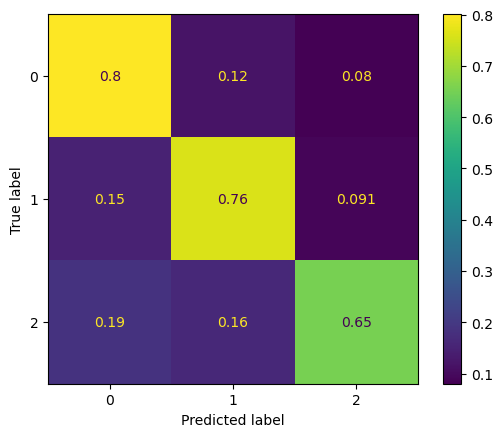

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.01228. Saving Model!
epoch 01, loss: 1.03064, acc: 0.45430, val_loss: 1.01228, val_accuracy: 0.53223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 02, loss: 1.03076, acc: 0.45410, val_loss: 1.01250, val_accuracy: 0.53959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 03, loss: 1.03080, acc: 0.45666, val_loss: 1.01312, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 04, loss: 1.03072, acc: 0.45737, val_loss: 1.01404, val_accuracy: 0.53223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 05, loss: 1.03047, acc: 0.45707, val_loss: 1.01523, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 06, loss: 1.03005, acc: 0.45922, val_loss: 1.01663, val_accuracy: 0.53039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 07, loss: 1.02950, acc: 0.45911, val_loss: 1.01817, val_accuracy: 0.52302


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 08, loss: 1.02885, acc: 0.45574, val_loss: 1.01978, val_accuracy: 0.52302


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 09, loss: 1.02816, acc: 0.46403, val_loss: 1.02142, val_accuracy: 0.52762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 10, loss: 1.02749, acc: 0.46331, val_loss: 1.02301, val_accuracy: 0.52670


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 11, loss: 1.02684, acc: 0.46177, val_loss: 1.02445, val_accuracy: 0.52670


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 12, loss: 1.02623, acc: 0.46065, val_loss: 1.02573, val_accuracy: 0.52486


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 13, loss: 1.02565, acc: 0.46014, val_loss: 1.02681, val_accuracy: 0.52578


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 14, loss: 1.02512, acc: 0.45645, val_loss: 1.02769, val_accuracy: 0.52394


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 15, loss: 1.02460, acc: 0.45451, val_loss: 1.02835, val_accuracy: 0.44936


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 16, loss: 1.02410, acc: 0.46014, val_loss: 1.02883, val_accuracy: 0.44291


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 17, loss: 1.02361, acc: 0.45911, val_loss: 1.02915, val_accuracy: 0.44475


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 18, loss: 1.02313, acc: 0.46085, val_loss: 1.02938, val_accuracy: 0.44843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 19, loss: 1.02266, acc: 0.46495, val_loss: 1.02953, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 20, loss: 1.02218, acc: 0.46618, val_loss: 1.02966, val_accuracy: 0.45304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 21, loss: 1.02170, acc: 0.46679, val_loss: 1.02980, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 22, loss: 1.02123, acc: 0.46740, val_loss: 1.02997, val_accuracy: 0.45856


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 23, loss: 1.02075, acc: 0.46925, val_loss: 1.03020, val_accuracy: 0.46041


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 24, loss: 1.02026, acc: 0.47293, val_loss: 1.03052, val_accuracy: 0.46041


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 25, loss: 1.01978, acc: 0.47293, val_loss: 1.03094, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 26, loss: 1.01928, acc: 0.47232, val_loss: 1.03143, val_accuracy: 0.45580


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 27, loss: 1.01879, acc: 0.47313, val_loss: 1.03202, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 28, loss: 1.01830, acc: 0.47324, val_loss: 1.03266, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 29, loss: 1.01782, acc: 0.47262, val_loss: 1.03332, val_accuracy: 0.45212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 30, loss: 1.01735, acc: 0.47262, val_loss: 1.03401, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 31, loss: 1.01688, acc: 0.47283, val_loss: 1.03470, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 32, loss: 1.01643, acc: 0.47406, val_loss: 1.03533, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 33, loss: 1.01598, acc: 0.47580, val_loss: 1.03593, val_accuracy: 0.45212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 34, loss: 1.01553, acc: 0.47385, val_loss: 1.03647, val_accuracy: 0.45212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 35, loss: 1.01508, acc: 0.47528, val_loss: 1.03693, val_accuracy: 0.45212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 36, loss: 1.01465, acc: 0.47498, val_loss: 1.03728, val_accuracy: 0.45304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 37, loss: 1.01421, acc: 0.47549, val_loss: 1.03758, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 38, loss: 1.01376, acc: 0.47621, val_loss: 1.03782, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 39, loss: 1.01332, acc: 0.47672, val_loss: 1.03803, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 40, loss: 1.01288, acc: 0.47702, val_loss: 1.03818, val_accuracy: 0.45948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 41, loss: 1.01244, acc: 0.47549, val_loss: 1.03829, val_accuracy: 0.46317


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 42, loss: 1.01200, acc: 0.47457, val_loss: 1.03840, val_accuracy: 0.46317


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 43, loss: 1.01157, acc: 0.47487, val_loss: 1.03851, val_accuracy: 0.46409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 44, loss: 1.01113, acc: 0.47580, val_loss: 1.03863, val_accuracy: 0.46317


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 45, loss: 1.01071, acc: 0.47621, val_loss: 1.03876, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 46, loss: 1.01027, acc: 0.47651, val_loss: 1.03892, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 47, loss: 1.00985, acc: 0.47661, val_loss: 1.03913, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 48, loss: 1.00942, acc: 0.47682, val_loss: 1.03936, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 49, loss: 1.00900, acc: 0.47754, val_loss: 1.03963, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 50, loss: 1.00856, acc: 0.47794, val_loss: 1.03994, val_accuracy: 0.46685


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 51, loss: 1.00814, acc: 0.48194, val_loss: 1.04025, val_accuracy: 0.46777


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 52, loss: 1.00771, acc: 0.48183, val_loss: 1.04053, val_accuracy: 0.46869


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 53, loss: 1.00729, acc: 0.48255, val_loss: 1.04078, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 54, loss: 1.00687, acc: 0.48265, val_loss: 1.04102, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 55, loss: 1.00645, acc: 0.48327, val_loss: 1.04122, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 56, loss: 1.00604, acc: 0.48480, val_loss: 1.04142, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 57, loss: 1.00562, acc: 0.48736, val_loss: 1.04158, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 58, loss: 1.00521, acc: 0.48787, val_loss: 1.04176, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 59, loss: 1.00480, acc: 0.48787, val_loss: 1.04194, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 60, loss: 1.00439, acc: 0.48818, val_loss: 1.04213, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 61, loss: 1.00396, acc: 0.48818, val_loss: 1.04231, val_accuracy: 0.46961


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 62, loss: 1.00354, acc: 0.48838, val_loss: 1.04245, val_accuracy: 0.46869


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 63, loss: 1.00312, acc: 0.48869, val_loss: 1.04260, val_accuracy: 0.46961


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 64, loss: 1.00270, acc: 0.48879, val_loss: 1.04276, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 65, loss: 1.00228, acc: 0.49238, val_loss: 1.04290, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 66, loss: 1.00187, acc: 0.49268, val_loss: 1.04302, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 67, loss: 1.00144, acc: 0.49330, val_loss: 1.04312, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 68, loss: 1.00101, acc: 0.49023, val_loss: 1.04322, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 69, loss: 1.00058, acc: 0.49033, val_loss: 1.04331, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 70, loss: 1.00016, acc: 0.49104, val_loss: 1.04343, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 71, loss: 0.99973, acc: 0.49166, val_loss: 1.04349, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 72, loss: 0.99931, acc: 0.49258, val_loss: 1.04361, val_accuracy: 0.45580


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 73, loss: 0.99887, acc: 0.49371, val_loss: 1.04378, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 74, loss: 0.99844, acc: 0.49401, val_loss: 1.04394, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 75, loss: 0.99801, acc: 0.49463, val_loss: 1.04404, val_accuracy: 0.45856


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 76, loss: 0.99759, acc: 0.49463, val_loss: 1.04418, val_accuracy: 0.45856


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 77, loss: 0.99714, acc: 0.49524, val_loss: 1.04427, val_accuracy: 0.45580


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 78, loss: 0.99671, acc: 0.49545, val_loss: 1.04439, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 79, loss: 0.99627, acc: 0.49565, val_loss: 1.04451, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 80, loss: 0.99583, acc: 0.49606, val_loss: 1.04463, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 81, loss: 0.99539, acc: 0.49719, val_loss: 1.04477, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 82, loss: 0.99495, acc: 0.49698, val_loss: 1.04485, val_accuracy: 0.45304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 83, loss: 0.99452, acc: 0.49749, val_loss: 1.04487, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 84, loss: 0.99407, acc: 0.49811, val_loss: 1.04483, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 85, loss: 0.99363, acc: 0.49852, val_loss: 1.04476, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 86, loss: 0.99318, acc: 0.49841, val_loss: 1.04471, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 87, loss: 0.99273, acc: 0.49862, val_loss: 1.04463, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]


epoch 88, loss: 0.99229, acc: 0.49882, val_loss: 1.04456, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 89, loss: 0.99184, acc: 0.49893, val_loss: 1.04447, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 90, loss: 0.99140, acc: 0.50148, val_loss: 1.04436, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 91, loss: 0.99095, acc: 0.50148, val_loss: 1.04420, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 92, loss: 0.99050, acc: 0.50169, val_loss: 1.04409, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 93, loss: 0.99004, acc: 0.50179, val_loss: 1.04398, val_accuracy: 0.44567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 94, loss: 0.98959, acc: 0.50159, val_loss: 1.04390, val_accuracy: 0.44475


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 95, loss: 0.98912, acc: 0.50793, val_loss: 1.04383, val_accuracy: 0.44291


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 96, loss: 0.98867, acc: 0.50773, val_loss: 1.04375, val_accuracy: 0.44199


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 97, loss: 0.98820, acc: 0.50762, val_loss: 1.04361, val_accuracy: 0.43831


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 98, loss: 0.98773, acc: 0.51008, val_loss: 1.04341, val_accuracy: 0.43831


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 99, loss: 0.98726, acc: 0.51039, val_loss: 1.04322, val_accuracy: 0.44015


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 100, loss: 0.98681, acc: 0.51059, val_loss: 1.04307, val_accuracy: 0.44015


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.99it/s]


epoch 101, loss: 0.98634, acc: 0.51029, val_loss: 1.04300, val_accuracy: 0.43923


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 102, loss: 0.98587, acc: 0.51110, val_loss: 1.04293, val_accuracy: 0.44015


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 103, loss: 0.98539, acc: 0.51100, val_loss: 1.04282, val_accuracy: 0.43554


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 104, loss: 0.98492, acc: 0.51121, val_loss: 1.04271, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 105, loss: 0.98444, acc: 0.51141, val_loss: 1.04258, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 106, loss: 0.98397, acc: 0.51151, val_loss: 1.04255, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 107, loss: 0.98348, acc: 0.51172, val_loss: 1.04249, val_accuracy: 0.43278


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 108, loss: 0.98300, acc: 0.51223, val_loss: 1.04245, val_accuracy: 0.43186


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 109, loss: 0.98251, acc: 0.51223, val_loss: 1.04241, val_accuracy: 0.43186


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 110, loss: 0.98202, acc: 0.51295, val_loss: 1.04224, val_accuracy: 0.43278


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 111, loss: 0.98154, acc: 0.51417, val_loss: 1.04207, val_accuracy: 0.43278


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 112, loss: 0.98104, acc: 0.51438, val_loss: 1.04181, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.01it/s]


epoch 113, loss: 0.98054, acc: 0.51458, val_loss: 1.04161, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 114, loss: 0.98003, acc: 0.51489, val_loss: 1.04151, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 115, loss: 0.97952, acc: 0.51499, val_loss: 1.04143, val_accuracy: 0.43462


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 116, loss: 0.97902, acc: 0.51479, val_loss: 1.04136, val_accuracy: 0.43462


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 117, loss: 0.97850, acc: 0.51438, val_loss: 1.04128, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 118, loss: 0.97799, acc: 0.51469, val_loss: 1.04117, val_accuracy: 0.43278


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 119, loss: 0.97747, acc: 0.51489, val_loss: 1.04103, val_accuracy: 0.43370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 120, loss: 0.97695, acc: 0.51571, val_loss: 1.04089, val_accuracy: 0.43186


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 121, loss: 0.97642, acc: 0.51643, val_loss: 1.04071, val_accuracy: 0.43094


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 122, loss: 0.97592, acc: 0.51530, val_loss: 1.04054, val_accuracy: 0.43002


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 123, loss: 0.97540, acc: 0.51581, val_loss: 1.04035, val_accuracy: 0.43002


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 124, loss: 0.97487, acc: 0.51561, val_loss: 1.04019, val_accuracy: 0.43094


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 125, loss: 0.97434, acc: 0.51612, val_loss: 1.04000, val_accuracy: 0.42910


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 126, loss: 0.97381, acc: 0.51643, val_loss: 1.03976, val_accuracy: 0.42910


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.11it/s]


epoch 127, loss: 0.97328, acc: 0.51643, val_loss: 1.03958, val_accuracy: 0.42726


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 128, loss: 0.97275, acc: 0.51673, val_loss: 1.03943, val_accuracy: 0.42357


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


epoch 129, loss: 0.97220, acc: 0.51704, val_loss: 1.03929, val_accuracy: 0.42357


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 130, loss: 0.97166, acc: 0.51735, val_loss: 1.03911, val_accuracy: 0.42357


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 131, loss: 0.97112, acc: 0.51745, val_loss: 1.03893, val_accuracy: 0.42357


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 132, loss: 0.97057, acc: 0.51786, val_loss: 1.03880, val_accuracy: 0.42265


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 133, loss: 0.97001, acc: 0.51786, val_loss: 1.03864, val_accuracy: 0.42265


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 134, loss: 0.96945, acc: 0.51632, val_loss: 1.03853, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 135, loss: 0.96890, acc: 0.51632, val_loss: 1.03852, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 136, loss: 0.96834, acc: 0.51612, val_loss: 1.03838, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 137, loss: 0.96778, acc: 0.51694, val_loss: 1.03817, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 138, loss: 0.96721, acc: 0.51735, val_loss: 1.03789, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 139, loss: 0.96664, acc: 0.51786, val_loss: 1.03768, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


epoch 140, loss: 0.96606, acc: 0.51806, val_loss: 1.03748, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 141, loss: 0.96547, acc: 0.51858, val_loss: 1.03736, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 142, loss: 0.96491, acc: 0.51827, val_loss: 1.03724, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 143, loss: 0.96432, acc: 0.51827, val_loss: 1.03706, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 144, loss: 0.96372, acc: 0.51878, val_loss: 1.03686, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 145, loss: 0.96312, acc: 0.51939, val_loss: 1.03660, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 146, loss: 0.96253, acc: 0.52318, val_loss: 1.03638, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 147, loss: 0.96192, acc: 0.52390, val_loss: 1.03616, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 148, loss: 0.96130, acc: 0.52410, val_loss: 1.03587, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 149, loss: 0.96069, acc: 0.52451, val_loss: 1.03568, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 150, loss: 0.96004, acc: 0.52441, val_loss: 1.03539, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 151, loss: 0.95940, acc: 0.52513, val_loss: 1.03505, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 152, loss: 0.95876, acc: 0.52727, val_loss: 1.03472, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 153, loss: 0.95810, acc: 0.53004, val_loss: 1.03438, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 154, loss: 0.95745, acc: 0.53045, val_loss: 1.03410, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 155, loss: 0.95679, acc: 0.53055, val_loss: 1.03386, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 156, loss: 0.95614, acc: 0.53096, val_loss: 1.03354, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 157, loss: 0.95547, acc: 0.53178, val_loss: 1.03305, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 158, loss: 0.95482, acc: 0.53362, val_loss: 1.03250, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


epoch 159, loss: 0.95415, acc: 0.53423, val_loss: 1.03202, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 160, loss: 0.95348, acc: 0.53485, val_loss: 1.03157, val_accuracy: 0.41713


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 161, loss: 0.95281, acc: 0.53546, val_loss: 1.03116, val_accuracy: 0.41713


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 162, loss: 0.95212, acc: 0.53587, val_loss: 1.03075, val_accuracy: 0.41713


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 163, loss: 0.95143, acc: 0.53618, val_loss: 1.03039, val_accuracy: 0.41621


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 164, loss: 0.95075, acc: 0.53669, val_loss: 1.03014, val_accuracy: 0.41713


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 165, loss: 0.95007, acc: 0.53710, val_loss: 1.02988, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 166, loss: 0.94937, acc: 0.53741, val_loss: 1.02949, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 167, loss: 0.94869, acc: 0.53782, val_loss: 1.02902, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 168, loss: 0.94798, acc: 0.53874, val_loss: 1.02875, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 169, loss: 0.94728, acc: 0.53884, val_loss: 1.02851, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 170, loss: 0.94658, acc: 0.53904, val_loss: 1.02811, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 171, loss: 0.94585, acc: 0.53884, val_loss: 1.02767, val_accuracy: 0.42357


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 172, loss: 0.94514, acc: 0.54089, val_loss: 1.02718, val_accuracy: 0.42449


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 173, loss: 0.94443, acc: 0.54130, val_loss: 1.02677, val_accuracy: 0.42265


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 174, loss: 0.94371, acc: 0.54140, val_loss: 1.02646, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 175, loss: 0.94298, acc: 0.54140, val_loss: 1.02610, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 176, loss: 0.94224, acc: 0.54160, val_loss: 1.02578, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 177, loss: 0.94151, acc: 0.54181, val_loss: 1.02549, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 178, loss: 0.94077, acc: 0.54273, val_loss: 1.02519, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 179, loss: 0.94001, acc: 0.54283, val_loss: 1.02478, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 180, loss: 0.93928, acc: 0.54447, val_loss: 1.02442, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 181, loss: 0.93851, acc: 0.54856, val_loss: 1.02414, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 182, loss: 0.93770, acc: 0.54805, val_loss: 1.02401, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 183, loss: 0.93691, acc: 0.54836, val_loss: 1.02372, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 184, loss: 0.93613, acc: 0.54907, val_loss: 1.02332, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 185, loss: 0.93532, acc: 0.54918, val_loss: 1.02291, val_accuracy: 0.41713


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 186, loss: 0.93450, acc: 0.54907, val_loss: 1.02242, val_accuracy: 0.41713


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 187, loss: 0.93366, acc: 0.54959, val_loss: 1.02199, val_accuracy: 0.41621


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 188, loss: 0.93285, acc: 0.54959, val_loss: 1.02171, val_accuracy: 0.41344


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 189, loss: 0.93201, acc: 0.54999, val_loss: 1.02123, val_accuracy: 0.41068


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 190, loss: 0.93119, acc: 0.55051, val_loss: 1.02073, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 191, loss: 0.93036, acc: 0.55071, val_loss: 1.02047, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 192, loss: 0.92952, acc: 0.55112, val_loss: 1.02018, val_accuracy: 0.40976


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 193, loss: 0.92870, acc: 0.55163, val_loss: 1.01996, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 194, loss: 0.92785, acc: 0.55194, val_loss: 1.01967, val_accuracy: 0.40792


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 195, loss: 0.92699, acc: 0.55214, val_loss: 1.01927, val_accuracy: 0.40884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 196, loss: 0.92613, acc: 0.55235, val_loss: 1.01892, val_accuracy: 0.40792


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 197, loss: 0.92529, acc: 0.55266, val_loss: 1.01867, val_accuracy: 0.40792


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 198, loss: 0.92443, acc: 0.55317, val_loss: 1.01829, val_accuracy: 0.41068


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 199, loss: 0.92352, acc: 0.55470, val_loss: 1.01771, val_accuracy: 0.41160


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 200, loss: 0.92265, acc: 0.55511, val_loss: 1.01724, val_accuracy: 0.41160


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 201, loss: 0.92177, acc: 0.55562, val_loss: 1.01684, val_accuracy: 0.41344


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 202, loss: 0.92089, acc: 0.56023, val_loss: 1.01651, val_accuracy: 0.41344


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 203, loss: 0.91999, acc: 0.56064, val_loss: 1.01604, val_accuracy: 0.41621


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 204, loss: 0.91908, acc: 0.56115, val_loss: 1.01572, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 205, loss: 0.91816, acc: 0.56176, val_loss: 1.01524, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 206, loss: 0.91723, acc: 0.56207, val_loss: 1.01466, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 207, loss: 0.91631, acc: 0.56350, val_loss: 1.01377, val_accuracy: 0.41713


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 208, loss: 0.91537, acc: 0.56381, val_loss: 1.01313, val_accuracy: 0.41805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 209, loss: 0.91443, acc: 0.56361, val_loss: 1.01283, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 210, loss: 0.91348, acc: 0.56483, val_loss: 1.01260, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


[INFO] val_acc has been improved from 1.01228 to 1.01200. Saving Model!
epoch 211, loss: 0.91253, acc: 0.56514, val_loss: 1.01200, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 1.01200 to 1.01139. Saving Model!
epoch 212, loss: 0.91155, acc: 0.56565, val_loss: 1.01139, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


[INFO] val_acc has been improved from 1.01139 to 1.01113. Saving Model!
epoch 213, loss: 0.91056, acc: 0.56698, val_loss: 1.01113, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 1.01113 to 1.01105. Saving Model!
epoch 214, loss: 0.90955, acc: 0.56780, val_loss: 1.01105, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 1.01105 to 1.01080. Saving Model!
epoch 215, loss: 0.90853, acc: 0.56852, val_loss: 1.01080, val_accuracy: 0.42265


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


[INFO] val_acc has been improved from 1.01080 to 1.01031. Saving Model!
epoch 216, loss: 0.90749, acc: 0.56893, val_loss: 1.01031, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 1.01031 to 1.00966. Saving Model!
epoch 217, loss: 0.90642, acc: 0.57036, val_loss: 1.00966, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 1.00966 to 1.00939. Saving Model!
epoch 218, loss: 0.90534, acc: 0.57077, val_loss: 1.00939, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


[INFO] val_acc has been improved from 1.00939 to 1.00899. Saving Model!
epoch 219, loss: 0.90425, acc: 0.57077, val_loss: 1.00899, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


[INFO] val_acc has been improved from 1.00899 to 1.00880. Saving Model!
epoch 220, loss: 0.90312, acc: 0.57118, val_loss: 1.00880, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 1.00880 to 1.00869. Saving Model!
epoch 221, loss: 0.90198, acc: 0.57108, val_loss: 1.00869, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


[INFO] val_acc has been improved from 1.00869 to 1.00851. Saving Model!
epoch 222, loss: 0.90087, acc: 0.57241, val_loss: 1.00851, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 1.00851 to 1.00804. Saving Model!
epoch 223, loss: 0.89975, acc: 0.57394, val_loss: 1.00804, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 1.00804 to 1.00739. Saving Model!
epoch 224, loss: 0.89867, acc: 0.58049, val_loss: 1.00739, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


[INFO] val_acc has been improved from 1.00739 to 1.00683. Saving Model!
epoch 225, loss: 0.89758, acc: 0.58060, val_loss: 1.00683, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 1.00683 to 1.00620. Saving Model!
epoch 226, loss: 0.89649, acc: 0.58101, val_loss: 1.00620, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


[INFO] val_acc has been improved from 1.00620 to 1.00533. Saving Model!
epoch 227, loss: 0.89537, acc: 0.58305, val_loss: 1.00533, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 1.00533 to 1.00422. Saving Model!
epoch 228, loss: 0.89426, acc: 0.58643, val_loss: 1.00422, val_accuracy: 0.42265


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 1.00422 to 1.00307. Saving Model!
epoch 229, loss: 0.89316, acc: 0.59421, val_loss: 1.00307, val_accuracy: 0.42173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 1.00307 to 1.00213. Saving Model!
epoch 230, loss: 0.89205, acc: 0.59370, val_loss: 1.00213, val_accuracy: 0.41897


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


[INFO] val_acc has been improved from 1.00213 to 1.00098. Saving Model!
epoch 231, loss: 0.89089, acc: 0.59523, val_loss: 1.00098, val_accuracy: 0.42081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 1.00098 to 0.99962. Saving Model!
epoch 232, loss: 0.88976, acc: 0.59646, val_loss: 0.99962, val_accuracy: 0.41989


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


[INFO] val_acc has been improved from 0.99962 to 0.99823. Saving Model!
epoch 233, loss: 0.88864, acc: 0.59728, val_loss: 0.99823, val_accuracy: 0.42265


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


[INFO] val_acc has been improved from 0.99823 to 0.99663. Saving Model!
epoch 234, loss: 0.88750, acc: 0.59820, val_loss: 0.99663, val_accuracy: 0.42449


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.99663 to 0.99512. Saving Model!
epoch 235, loss: 0.88633, acc: 0.59984, val_loss: 0.99512, val_accuracy: 0.43002


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.99512 to 0.99360. Saving Model!
epoch 236, loss: 0.88517, acc: 0.60035, val_loss: 0.99360, val_accuracy: 0.42910


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


[INFO] val_acc has been improved from 0.99360 to 0.99249. Saving Model!
epoch 237, loss: 0.88400, acc: 0.60250, val_loss: 0.99249, val_accuracy: 0.43186


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.99249 to 0.99151. Saving Model!
epoch 238, loss: 0.88282, acc: 0.60301, val_loss: 0.99151, val_accuracy: 0.43462


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


[INFO] val_acc has been improved from 0.99151 to 0.99015. Saving Model!
epoch 239, loss: 0.88167, acc: 0.60373, val_loss: 0.99015, val_accuracy: 0.44383


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.99015 to 0.98831. Saving Model!
epoch 240, loss: 0.88049, acc: 0.60393, val_loss: 0.98831, val_accuracy: 0.44475


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.98831 to 0.98649. Saving Model!
epoch 241, loss: 0.87931, acc: 0.60751, val_loss: 0.98649, val_accuracy: 0.44383


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


[INFO] val_acc has been improved from 0.98649 to 0.98543. Saving Model!
epoch 242, loss: 0.87814, acc: 0.60731, val_loss: 0.98543, val_accuracy: 0.44751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.98543 to 0.98459. Saving Model!
epoch 243, loss: 0.87696, acc: 0.60782, val_loss: 0.98459, val_accuracy: 0.44751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.98459 to 0.98319. Saving Model!
epoch 244, loss: 0.87577, acc: 0.60813, val_loss: 0.98319, val_accuracy: 0.44936


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


[INFO] val_acc has been improved from 0.98319 to 0.98185. Saving Model!
epoch 245, loss: 0.87457, acc: 0.60935, val_loss: 0.98185, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.98185 to 0.98077. Saving Model!
epoch 246, loss: 0.87335, acc: 0.60987, val_loss: 0.98077, val_accuracy: 0.45028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.98077 to 0.97980. Saving Model!
epoch 247, loss: 0.87215, acc: 0.61079, val_loss: 0.97980, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


[INFO] val_acc has been improved from 0.97980 to 0.97861. Saving Model!
epoch 248, loss: 0.87091, acc: 0.61150, val_loss: 0.97861, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


[INFO] val_acc has been improved from 0.97861 to 0.97734. Saving Model!
epoch 249, loss: 0.86969, acc: 0.61161, val_loss: 0.97734, val_accuracy: 0.45120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


[INFO] val_acc has been improved from 0.97734 to 0.97639. Saving Model!
epoch 250, loss: 0.86848, acc: 0.61355, val_loss: 0.97639, val_accuracy: 0.45028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.97639 to 0.97549. Saving Model!
epoch 251, loss: 0.86725, acc: 0.61488, val_loss: 0.97549, val_accuracy: 0.45396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.97549 to 0.97471. Saving Model!
epoch 252, loss: 0.86603, acc: 0.61672, val_loss: 0.97471, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


[INFO] val_acc has been improved from 0.97471 to 0.97389. Saving Model!
epoch 253, loss: 0.86480, acc: 0.61693, val_loss: 0.97389, val_accuracy: 0.45488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.97389 to 0.97289. Saving Model!
epoch 254, loss: 0.86357, acc: 0.61652, val_loss: 0.97289, val_accuracy: 0.45672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.97289 to 0.97173. Saving Model!
epoch 255, loss: 0.86232, acc: 0.61795, val_loss: 0.97173, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


[INFO] val_acc has been improved from 0.97173 to 0.97088. Saving Model!
epoch 256, loss: 0.86107, acc: 0.61908, val_loss: 0.97088, val_accuracy: 0.45764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]


[INFO] val_acc has been improved from 0.97088 to 0.96992. Saving Model!
epoch 257, loss: 0.85980, acc: 0.62092, val_loss: 0.96992, val_accuracy: 0.46133


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.96992 to 0.96863. Saving Model!
epoch 258, loss: 0.85854, acc: 0.62092, val_loss: 0.96863, val_accuracy: 0.46225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


[INFO] val_acc has been improved from 0.96863 to 0.96714. Saving Model!
epoch 259, loss: 0.85725, acc: 0.62491, val_loss: 0.96714, val_accuracy: 0.46409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.96714 to 0.96571. Saving Model!
epoch 260, loss: 0.85599, acc: 0.62685, val_loss: 0.96571, val_accuracy: 0.46409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.96571 to 0.96481. Saving Model!
epoch 261, loss: 0.85469, acc: 0.62819, val_loss: 0.96481, val_accuracy: 0.46685


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


[INFO] val_acc has been improved from 0.96481 to 0.96423. Saving Model!
epoch 262, loss: 0.85340, acc: 0.63126, val_loss: 0.96423, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.96423 to 0.96345. Saving Model!
epoch 263, loss: 0.85212, acc: 0.63238, val_loss: 0.96345, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.96345 to 0.96200. Saving Model!
epoch 264, loss: 0.85081, acc: 0.63279, val_loss: 0.96200, val_accuracy: 0.46409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


[INFO] val_acc has been improved from 0.96200 to 0.95993. Saving Model!
epoch 265, loss: 0.84952, acc: 0.63392, val_loss: 0.95993, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.68it/s]


[INFO] val_acc has been improved from 0.95993 to 0.95867. Saving Model!
epoch 266, loss: 0.84821, acc: 0.63555, val_loss: 0.95867, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.95867 to 0.95822. Saving Model!
epoch 267, loss: 0.84691, acc: 0.63709, val_loss: 0.95822, val_accuracy: 0.46409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


[INFO] val_acc has been improved from 0.95822 to 0.95679. Saving Model!
epoch 268, loss: 0.84557, acc: 0.63740, val_loss: 0.95679, val_accuracy: 0.46225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.95679 to 0.95503. Saving Model!
epoch 269, loss: 0.84419, acc: 0.63750, val_loss: 0.95503, val_accuracy: 0.46133


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.95503 to 0.95382. Saving Model!
epoch 270, loss: 0.84283, acc: 0.63760, val_loss: 0.95382, val_accuracy: 0.46041


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


[INFO] val_acc has been improved from 0.95382 to 0.95301. Saving Model!
epoch 271, loss: 0.84149, acc: 0.63862, val_loss: 0.95301, val_accuracy: 0.46409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.95301 to 0.95194. Saving Model!
epoch 272, loss: 0.84020, acc: 0.63883, val_loss: 0.95194, val_accuracy: 0.46685


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.95194 to 0.95015. Saving Model!
epoch 273, loss: 0.83887, acc: 0.64036, val_loss: 0.95015, val_accuracy: 0.46593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


[INFO] val_acc has been improved from 0.95015 to 0.94830. Saving Model!
epoch 274, loss: 0.83750, acc: 0.64057, val_loss: 0.94830, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.94830 to 0.94736. Saving Model!
epoch 275, loss: 0.83620, acc: 0.64159, val_loss: 0.94736, val_accuracy: 0.46501


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


[INFO] val_acc has been improved from 0.94736 to 0.94647. Saving Model!
epoch 276, loss: 0.83488, acc: 0.64221, val_loss: 0.94647, val_accuracy: 0.47053


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.94647 to 0.94503. Saving Model!
epoch 277, loss: 0.83356, acc: 0.64272, val_loss: 0.94503, val_accuracy: 0.47145


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.94503 to 0.94366. Saving Model!
epoch 278, loss: 0.83222, acc: 0.64487, val_loss: 0.94366, val_accuracy: 0.47145


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


[INFO] val_acc has been improved from 0.94366 to 0.94322. Saving Model!
epoch 279, loss: 0.83090, acc: 0.64456, val_loss: 0.94322, val_accuracy: 0.47238


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.94322 to 0.94287. Saving Model!
epoch 280, loss: 0.82953, acc: 0.64415, val_loss: 0.94287, val_accuracy: 0.47330


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.94287 to 0.94187. Saving Model!
epoch 281, loss: 0.82816, acc: 0.64364, val_loss: 0.94187, val_accuracy: 0.47698


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


[INFO] val_acc has been improved from 0.94187 to 0.94110. Saving Model!
epoch 282, loss: 0.82680, acc: 0.64436, val_loss: 0.94110, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.94110 to 0.94014. Saving Model!
epoch 283, loss: 0.82542, acc: 0.64487, val_loss: 0.94014, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.94014 to 0.93876. Saving Model!
epoch 284, loss: 0.82410, acc: 0.64487, val_loss: 0.93876, val_accuracy: 0.48066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


[INFO] val_acc has been improved from 0.93876 to 0.93688. Saving Model!
epoch 285, loss: 0.82276, acc: 0.64528, val_loss: 0.93688, val_accuracy: 0.47974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.93688 to 0.93564. Saving Model!
epoch 286, loss: 0.82142, acc: 0.64548, val_loss: 0.93564, val_accuracy: 0.47974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


[INFO] val_acc has been improved from 0.93564 to 0.93452. Saving Model!
epoch 287, loss: 0.82008, acc: 0.64589, val_loss: 0.93452, val_accuracy: 0.48250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.93452 to 0.93267. Saving Model!
epoch 288, loss: 0.81876, acc: 0.64640, val_loss: 0.93267, val_accuracy: 0.48066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.93267 to 0.93137. Saving Model!
epoch 289, loss: 0.81740, acc: 0.64712, val_loss: 0.93137, val_accuracy: 0.47422


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


[INFO] val_acc has been improved from 0.93137 to 0.93042. Saving Model!
epoch 290, loss: 0.81606, acc: 0.64620, val_loss: 0.93042, val_accuracy: 0.47790


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.93042 to 0.92966. Saving Model!
epoch 291, loss: 0.81471, acc: 0.64732, val_loss: 0.92966, val_accuracy: 0.48066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.92966 to 0.92805. Saving Model!
epoch 292, loss: 0.81332, acc: 0.64814, val_loss: 0.92805, val_accuracy: 0.48066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


[INFO] val_acc has been improved from 0.92805 to 0.92635. Saving Model!
epoch 293, loss: 0.81197, acc: 0.64814, val_loss: 0.92635, val_accuracy: 0.48158


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.92635 to 0.92493. Saving Model!
epoch 294, loss: 0.81060, acc: 0.64763, val_loss: 0.92493, val_accuracy: 0.48158


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.92493 to 0.92330. Saving Model!
epoch 295, loss: 0.80922, acc: 0.64845, val_loss: 0.92330, val_accuracy: 0.48343


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


[INFO] val_acc has been improved from 0.92330 to 0.92206. Saving Model!
epoch 296, loss: 0.80785, acc: 0.64927, val_loss: 0.92206, val_accuracy: 0.48343


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


[INFO] val_acc has been improved from 0.92206 to 0.92087. Saving Model!
epoch 297, loss: 0.80645, acc: 0.65009, val_loss: 0.92087, val_accuracy: 0.48343


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.92087 to 0.91932. Saving Model!
epoch 298, loss: 0.80506, acc: 0.65121, val_loss: 0.91932, val_accuracy: 0.48803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


[INFO] val_acc has been improved from 0.91932 to 0.91775. Saving Model!
epoch 299, loss: 0.80365, acc: 0.65203, val_loss: 0.91775, val_accuracy: 0.48803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


[INFO] val_acc has been improved from 0.91775 to 0.91577. Saving Model!
epoch 300, loss: 0.80226, acc: 0.65316, val_loss: 0.91577, val_accuracy: 0.48987


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.91577 to 0.91456. Saving Model!
epoch 301, loss: 0.80086, acc: 0.65265, val_loss: 0.91456, val_accuracy: 0.49079


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.91456 to 0.91305. Saving Model!
epoch 302, loss: 0.79947, acc: 0.65265, val_loss: 0.91305, val_accuracy: 0.48987


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.45it/s]


[INFO] val_acc has been improved from 0.91305 to 0.91113. Saving Model!
epoch 303, loss: 0.79808, acc: 0.65408, val_loss: 0.91113, val_accuracy: 0.49171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


[INFO] val_acc has been improved from 0.91113 to 0.90877. Saving Model!
epoch 304, loss: 0.79671, acc: 0.65398, val_loss: 0.90877, val_accuracy: 0.49448


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


[INFO] val_acc has been improved from 0.90877 to 0.90776. Saving Model!
epoch 305, loss: 0.79531, acc: 0.65520, val_loss: 0.90776, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.90776 to 0.90603. Saving Model!
epoch 306, loss: 0.79393, acc: 0.65694, val_loss: 0.90603, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.90603 to 0.90381. Saving Model!
epoch 307, loss: 0.79249, acc: 0.65817, val_loss: 0.90381, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


[INFO] val_acc has been improved from 0.90381 to 0.90233. Saving Model!
epoch 308, loss: 0.79114, acc: 0.65940, val_loss: 0.90233, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.90233 to 0.90028. Saving Model!
epoch 309, loss: 0.78975, acc: 0.65991, val_loss: 0.90028, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.90028 to 0.89833. Saving Model!
epoch 310, loss: 0.78835, acc: 0.66145, val_loss: 0.89833, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


[INFO] val_acc has been improved from 0.89833 to 0.89818. Saving Model!
epoch 311, loss: 0.78701, acc: 0.66216, val_loss: 0.89818, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.89818 to 0.89701. Saving Model!
epoch 312, loss: 0.78563, acc: 0.66196, val_loss: 0.89701, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


[INFO] val_acc has been improved from 0.89701 to 0.89509. Saving Model!
epoch 313, loss: 0.78419, acc: 0.66257, val_loss: 0.89509, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.89509 to 0.89416. Saving Model!
epoch 314, loss: 0.78284, acc: 0.66196, val_loss: 0.89416, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.89416 to 0.89255. Saving Model!
epoch 315, loss: 0.78140, acc: 0.66308, val_loss: 0.89255, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


[INFO] val_acc has been improved from 0.89255 to 0.89150. Saving Model!
epoch 316, loss: 0.78002, acc: 0.66401, val_loss: 0.89150, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


[INFO] val_acc has been improved from 0.89150 to 0.88996. Saving Model!
epoch 317, loss: 0.77866, acc: 0.66452, val_loss: 0.88996, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.88996 to 0.88884. Saving Model!
epoch 318, loss: 0.77728, acc: 0.66636, val_loss: 0.88884, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


[INFO] val_acc has been improved from 0.88884 to 0.88739. Saving Model!
epoch 319, loss: 0.77591, acc: 0.66575, val_loss: 0.88739, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.88739 to 0.88570. Saving Model!
epoch 320, loss: 0.77449, acc: 0.66564, val_loss: 0.88570, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.88570 to 0.88499. Saving Model!
epoch 321, loss: 0.77312, acc: 0.66656, val_loss: 0.88499, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


[INFO] val_acc has been improved from 0.88499 to 0.88356. Saving Model!
epoch 322, loss: 0.77175, acc: 0.66636, val_loss: 0.88356, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.88356 to 0.88167. Saving Model!
epoch 323, loss: 0.77036, acc: 0.66738, val_loss: 0.88167, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


[INFO] val_acc has been improved from 0.88167 to 0.88120. Saving Model!
epoch 324, loss: 0.76901, acc: 0.66830, val_loss: 0.88120, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.88120 to 0.87904. Saving Model!
epoch 325, loss: 0.76757, acc: 0.66687, val_loss: 0.87904, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


[INFO] val_acc has been improved from 0.87904 to 0.87765. Saving Model!
epoch 326, loss: 0.76616, acc: 0.66779, val_loss: 0.87765, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


[INFO] val_acc has been improved from 0.87765 to 0.87678. Saving Model!
epoch 327, loss: 0.76480, acc: 0.66912, val_loss: 0.87678, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


[INFO] val_acc has been improved from 0.87678 to 0.87482. Saving Model!
epoch 328, loss: 0.76340, acc: 0.66851, val_loss: 0.87482, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.87482 to 0.87240. Saving Model!
epoch 329, loss: 0.76198, acc: 0.66892, val_loss: 0.87240, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


[INFO] val_acc has been improved from 0.87240 to 0.87106. Saving Model!
epoch 330, loss: 0.76054, acc: 0.66984, val_loss: 0.87106, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


[INFO] val_acc has been improved from 0.87106 to 0.86903. Saving Model!
epoch 331, loss: 0.75916, acc: 0.67004, val_loss: 0.86903, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.86903 to 0.86832. Saving Model!
epoch 332, loss: 0.75772, acc: 0.67966, val_loss: 0.86832, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


[INFO] val_acc has been improved from 0.86832 to 0.86647. Saving Model!
epoch 333, loss: 0.75630, acc: 0.68048, val_loss: 0.86647, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.86647 to 0.86516. Saving Model!
epoch 334, loss: 0.75492, acc: 0.68273, val_loss: 0.86516, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.86516 to 0.86318. Saving Model!
epoch 335, loss: 0.75350, acc: 0.68355, val_loss: 0.86318, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


[INFO] val_acc has been improved from 0.86318 to 0.86176. Saving Model!
epoch 336, loss: 0.75210, acc: 0.68468, val_loss: 0.86176, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.86176 to 0.85905. Saving Model!
epoch 337, loss: 0.75068, acc: 0.68396, val_loss: 0.85905, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.85905 to 0.85702. Saving Model!
epoch 338, loss: 0.74928, acc: 0.68407, val_loss: 0.85702, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.85702 to 0.85639. Saving Model!
epoch 339, loss: 0.74790, acc: 0.68447, val_loss: 0.85639, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.85639 to 0.85364. Saving Model!
epoch 340, loss: 0.74658, acc: 0.68499, val_loss: 0.85364, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 341, loss: 0.74524, acc: 0.68560, val_loss: 0.85476, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 342, loss: 0.74384, acc: 0.68611, val_loss: 0.85396, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.85364 to 0.85249. Saving Model!
epoch 343, loss: 0.74243, acc: 0.68734, val_loss: 0.85249, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.85249 to 0.85209. Saving Model!
epoch 344, loss: 0.74109, acc: 0.68785, val_loss: 0.85209, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


[INFO] val_acc has been improved from 0.85209 to 0.84811. Saving Model!
epoch 345, loss: 0.73969, acc: 0.68888, val_loss: 0.84811, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 346, loss: 0.73839, acc: 0.69051, val_loss: 0.84824, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.84811 to 0.84656. Saving Model!
epoch 347, loss: 0.73701, acc: 0.68990, val_loss: 0.84656, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


[INFO] val_acc has been improved from 0.84656 to 0.84346. Saving Model!
epoch 348, loss: 0.73564, acc: 0.68959, val_loss: 0.84346, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 349, loss: 0.73430, acc: 0.69205, val_loss: 0.84389, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


[INFO] val_acc has been improved from 0.84346 to 0.84146. Saving Model!
epoch 350, loss: 0.73290, acc: 0.69143, val_loss: 0.84146, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


[INFO] val_acc has been improved from 0.84146 to 0.83902. Saving Model!
epoch 351, loss: 0.73148, acc: 0.69276, val_loss: 0.83902, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.83902 to 0.83768. Saving Model!
epoch 352, loss: 0.73014, acc: 0.69266, val_loss: 0.83768, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


[INFO] val_acc has been improved from 0.83768 to 0.83458. Saving Model!
epoch 353, loss: 0.72879, acc: 0.69102, val_loss: 0.83458, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 354, loss: 0.72746, acc: 0.69369, val_loss: 0.83594, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.83458 to 0.83335. Saving Model!
epoch 355, loss: 0.72616, acc: 0.69512, val_loss: 0.83335, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 356, loss: 0.72472, acc: 0.69450, val_loss: 0.83345, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.83335 to 0.83236. Saving Model!
epoch 357, loss: 0.72340, acc: 0.69635, val_loss: 0.83236, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.83236 to 0.83006. Saving Model!
epoch 358, loss: 0.72209, acc: 0.69635, val_loss: 0.83006, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


[INFO] val_acc has been improved from 0.83006 to 0.82851. Saving Model!
epoch 359, loss: 0.72075, acc: 0.69604, val_loss: 0.82851, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.82851 to 0.82768. Saving Model!
epoch 360, loss: 0.71945, acc: 0.69614, val_loss: 0.82768, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


[INFO] val_acc has been improved from 0.82768 to 0.82453. Saving Model!
epoch 361, loss: 0.71818, acc: 0.69798, val_loss: 0.82453, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 362, loss: 0.71692, acc: 0.69727, val_loss: 0.82657, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 363, loss: 0.71562, acc: 0.69798, val_loss: 0.82499, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 364, loss: 0.71430, acc: 0.69768, val_loss: 0.82526, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.82453 to 0.82339. Saving Model!
epoch 365, loss: 0.71296, acc: 0.69942, val_loss: 0.82339, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.82339 to 0.82082. Saving Model!
epoch 366, loss: 0.71167, acc: 0.69829, val_loss: 0.82082, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 367, loss: 0.71040, acc: 0.69880, val_loss: 0.82221, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.82082 to 0.81974. Saving Model!
epoch 368, loss: 0.70917, acc: 0.70218, val_loss: 0.81974, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 369, loss: 0.70783, acc: 0.70095, val_loss: 0.82241, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 370, loss: 0.70653, acc: 0.70300, val_loss: 0.82065, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.81974 to 0.81743. Saving Model!
epoch 371, loss: 0.70513, acc: 0.70484, val_loss: 0.81743, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 372, loss: 0.70395, acc: 0.70494, val_loss: 0.81833, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.81743 to 0.81456. Saving Model!
epoch 373, loss: 0.70277, acc: 0.70719, val_loss: 0.81456, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 374, loss: 0.70148, acc: 0.70433, val_loss: 0.81734, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 375, loss: 0.70012, acc: 0.70556, val_loss: 0.81574, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


[INFO] val_acc has been improved from 0.81456 to 0.81425. Saving Model!
epoch 376, loss: 0.69879, acc: 0.70730, val_loss: 0.81425, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 377, loss: 0.69760, acc: 0.70668, val_loss: 0.81635, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.81425 to 0.81272. Saving Model!
epoch 378, loss: 0.69636, acc: 0.70863, val_loss: 0.81272, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 379, loss: 0.69523, acc: 0.70842, val_loss: 0.81476, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.81272 to 0.80897. Saving Model!
epoch 380, loss: 0.69400, acc: 0.71129, val_loss: 0.80897, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 381, loss: 0.69279, acc: 0.70863, val_loss: 0.81334, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


[INFO] val_acc has been improved from 0.80897 to 0.80828. Saving Model!
epoch 382, loss: 0.69158, acc: 0.71313, val_loss: 0.80828, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 383, loss: 0.69032, acc: 0.71006, val_loss: 0.81210, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 384, loss: 0.68888, acc: 0.71405, val_loss: 0.81091, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 385, loss: 0.68752, acc: 0.71344, val_loss: 0.80981, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 386, loss: 0.68637, acc: 0.71374, val_loss: 0.81248, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


[INFO] val_acc has been improved from 0.80828 to 0.80698. Saving Model!
epoch 387, loss: 0.68524, acc: 0.71528, val_loss: 0.80698, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 388, loss: 0.68411, acc: 0.71395, val_loss: 0.81101, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


epoch 389, loss: 0.68271, acc: 0.71569, val_loss: 0.80868, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 390, loss: 0.68126, acc: 0.71733, val_loss: 0.80837, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 391, loss: 0.68011, acc: 0.72009, val_loss: 0.81102, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 0.80698 to 0.80532. Saving Model!
epoch 392, loss: 0.67916, acc: 0.71927, val_loss: 0.80532, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 393, loss: 0.67810, acc: 0.71845, val_loss: 0.81152, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 394, loss: 0.67664, acc: 0.71896, val_loss: 0.80823, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 395, loss: 0.67538, acc: 0.71722, val_loss: 0.81029, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 396, loss: 0.67397, acc: 0.72060, val_loss: 0.80835, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


[INFO] val_acc has been improved from 0.80532 to 0.80490. Saving Model!
epoch 397, loss: 0.67270, acc: 0.72122, val_loss: 0.80490, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 398, loss: 0.67173, acc: 0.72265, val_loss: 0.80826, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


[INFO] val_acc has been improved from 0.80490 to 0.80263. Saving Model!
epoch 399, loss: 0.67085, acc: 0.71876, val_loss: 0.80263, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 400, loss: 0.67001, acc: 0.71999, val_loss: 0.81152, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 401, loss: 0.66887, acc: 0.72050, val_loss: 0.80434, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 402, loss: 0.66729, acc: 0.72122, val_loss: 0.80628, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 403, loss: 0.66571, acc: 0.72316, val_loss: 0.80549, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


[INFO] val_acc has been improved from 0.80263 to 0.80187. Saving Model!
epoch 404, loss: 0.66454, acc: 0.72459, val_loss: 0.80187, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 405, loss: 0.66370, acc: 0.72449, val_loss: 0.80703, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 406, loss: 0.66252, acc: 0.72122, val_loss: 0.80309, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 407, loss: 0.66125, acc: 0.72439, val_loss: 0.80587, val_accuracy: 0.53131


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 408, loss: 0.65992, acc: 0.72347, val_loss: 0.80595, val_accuracy: 0.53407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 409, loss: 0.65869, acc: 0.72470, val_loss: 0.80372, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 410, loss: 0.65756, acc: 0.72551, val_loss: 0.80342, val_accuracy: 0.53039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


[INFO] val_acc has been improved from 0.80187 to 0.80139. Saving Model!
epoch 411, loss: 0.65649, acc: 0.72408, val_loss: 0.80139, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 412, loss: 0.65537, acc: 0.72725, val_loss: 0.80392, val_accuracy: 0.52855


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


epoch 413, loss: 0.65427, acc: 0.72633, val_loss: 0.80150, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 414, loss: 0.65311, acc: 0.72664, val_loss: 0.80356, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 415, loss: 0.65198, acc: 0.72858, val_loss: 0.80282, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 416, loss: 0.65082, acc: 0.72818, val_loss: 0.80274, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 417, loss: 0.64967, acc: 0.72756, val_loss: 0.80175, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.80139 to 0.80096. Saving Model!
epoch 418, loss: 0.64854, acc: 0.73227, val_loss: 0.80096, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 419, loss: 0.64746, acc: 0.72981, val_loss: 0.80548, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 420, loss: 0.64664, acc: 0.73268, val_loss: 0.80097, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 421, loss: 0.64611, acc: 0.73258, val_loss: 0.80833, val_accuracy: 0.52762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


[INFO] val_acc has been improved from 0.80096 to 0.79826. Saving Model!
epoch 422, loss: 0.64564, acc: 0.73575, val_loss: 0.79826, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 423, loss: 0.64468, acc: 0.73411, val_loss: 0.80492, val_accuracy: 0.53407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 424, loss: 0.64269, acc: 0.73606, val_loss: 0.80170, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 425, loss: 0.64082, acc: 0.73370, val_loss: 0.80110, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


epoch 426, loss: 0.63972, acc: 0.73411, val_loss: 0.80515, val_accuracy: 0.53683


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 427, loss: 0.63918, acc: 0.73831, val_loss: 0.79868, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 428, loss: 0.63894, acc: 0.73554, val_loss: 0.80703, val_accuracy: 0.53315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.79826 to 0.79739. Saving Model!
epoch 429, loss: 0.63794, acc: 0.73851, val_loss: 0.79739, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 430, loss: 0.63626, acc: 0.73708, val_loss: 0.80173, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 431, loss: 0.63430, acc: 0.73943, val_loss: 0.79924, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 432, loss: 0.63291, acc: 0.74168, val_loss: 0.79798, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 433, loss: 0.63213, acc: 0.73677, val_loss: 0.80504, val_accuracy: 0.53591


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 434, loss: 0.63149, acc: 0.74302, val_loss: 0.80056, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 435, loss: 0.63056, acc: 0.73954, val_loss: 0.80598, val_accuracy: 0.54604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 436, loss: 0.62934, acc: 0.74342, val_loss: 0.79770, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 437, loss: 0.62817, acc: 0.74261, val_loss: 0.80099, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 438, loss: 0.62652, acc: 0.74455, val_loss: 0.79969, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 439, loss: 0.62510, acc: 0.74465, val_loss: 0.79997, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 440, loss: 0.62415, acc: 0.74537, val_loss: 0.80365, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 441, loss: 0.62350, acc: 0.74578, val_loss: 0.79879, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 442, loss: 0.62319, acc: 0.74506, val_loss: 0.80705, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 443, loss: 0.62254, acc: 0.74465, val_loss: 0.79959, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 444, loss: 0.62170, acc: 0.74680, val_loss: 0.80589, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 445, loss: 0.61994, acc: 0.74557, val_loss: 0.79964, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 446, loss: 0.61785, acc: 0.74936, val_loss: 0.80067, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 447, loss: 0.61645, acc: 0.75069, val_loss: 0.80492, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 448, loss: 0.61590, acc: 0.74844, val_loss: 0.80102, val_accuracy: 0.56722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 449, loss: 0.61578, acc: 0.74905, val_loss: 0.80765, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 450, loss: 0.61507, acc: 0.74690, val_loss: 0.80025, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 451, loss: 0.61367, acc: 0.74905, val_loss: 0.80380, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 452, loss: 0.61180, acc: 0.75059, val_loss: 0.80026, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 453, loss: 0.61020, acc: 0.75110, val_loss: 0.79973, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 454, loss: 0.60897, acc: 0.75294, val_loss: 0.80216, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 455, loss: 0.60813, acc: 0.75161, val_loss: 0.80068, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 456, loss: 0.60771, acc: 0.75171, val_loss: 0.80392, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 457, loss: 0.60733, acc: 0.74957, val_loss: 0.79796, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 458, loss: 0.60669, acc: 0.75397, val_loss: 0.80243, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


[INFO] val_acc has been improved from 0.79739 to 0.79687. Saving Model!
epoch 459, loss: 0.60535, acc: 0.75417, val_loss: 0.79687, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 460, loss: 0.60387, acc: 0.75366, val_loss: 0.80283, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 461, loss: 0.60204, acc: 0.75264, val_loss: 0.80118, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 462, loss: 0.60052, acc: 0.75724, val_loss: 0.80047, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.32it/s]


epoch 463, loss: 0.59949, acc: 0.75755, val_loss: 0.80279, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 464, loss: 0.59905, acc: 0.75438, val_loss: 0.79788, val_accuracy: 0.58195


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 465, loss: 0.59892, acc: 0.75652, val_loss: 0.80475, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 466, loss: 0.59856, acc: 0.76093, val_loss: 0.79987, val_accuracy: 0.58471


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 467, loss: 0.59764, acc: 0.75468, val_loss: 0.80413, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 468, loss: 0.59590, acc: 0.75673, val_loss: 0.79983, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 469, loss: 0.59394, acc: 0.75785, val_loss: 0.80057, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 470, loss: 0.59236, acc: 0.75949, val_loss: 0.80064, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 471, loss: 0.59143, acc: 0.76011, val_loss: 0.80109, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 472, loss: 0.59091, acc: 0.75755, val_loss: 0.80471, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 473, loss: 0.59043, acc: 0.76400, val_loss: 0.80306, val_accuracy: 0.59024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 474, loss: 0.59030, acc: 0.75857, val_loss: 0.80927, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 475, loss: 0.59004, acc: 0.76614, val_loss: 0.80091, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 476, loss: 0.58975, acc: 0.75826, val_loss: 0.80651, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 477, loss: 0.58831, acc: 0.76758, val_loss: 0.80121, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 478, loss: 0.58610, acc: 0.76113, val_loss: 0.80018, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 479, loss: 0.58398, acc: 0.76748, val_loss: 0.79952, val_accuracy: 0.58471


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 480, loss: 0.58267, acc: 0.76962, val_loss: 0.80118, val_accuracy: 0.59853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 481, loss: 0.58213, acc: 0.76348, val_loss: 0.80691, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 482, loss: 0.58223, acc: 0.77331, val_loss: 0.80446, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 483, loss: 0.58233, acc: 0.76133, val_loss: 0.80820, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 484, loss: 0.58174, acc: 0.77198, val_loss: 0.80402, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 485, loss: 0.58069, acc: 0.76093, val_loss: 0.80651, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 486, loss: 0.57883, acc: 0.77290, val_loss: 0.79992, val_accuracy: 0.59853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 487, loss: 0.57670, acc: 0.76471, val_loss: 0.80100, val_accuracy: 0.58748


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 488, loss: 0.57505, acc: 0.77014, val_loss: 0.80193, val_accuracy: 0.58748


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 489, loss: 0.57419, acc: 0.77372, val_loss: 0.80276, val_accuracy: 0.59945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 490, loss: 0.57413, acc: 0.76502, val_loss: 0.80928, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 491, loss: 0.57432, acc: 0.77321, val_loss: 0.80525, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 492, loss: 0.57411, acc: 0.76359, val_loss: 0.80895, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 493, loss: 0.57305, acc: 0.77525, val_loss: 0.80367, val_accuracy: 0.59945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 494, loss: 0.57134, acc: 0.76502, val_loss: 0.80330, val_accuracy: 0.59024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 495, loss: 0.56935, acc: 0.77638, val_loss: 0.80275, val_accuracy: 0.59392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 496, loss: 0.56769, acc: 0.77730, val_loss: 0.80299, val_accuracy: 0.59392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 497, loss: 0.56664, acc: 0.77730, val_loss: 0.80713, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 498, loss: 0.56621, acc: 0.77771, val_loss: 0.80622, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 499, loss: 0.56631, acc: 0.76686, val_loss: 0.80875, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 500, loss: 0.56656, acc: 0.77628, val_loss: 0.80738, val_accuracy: 0.60221
1번째 교차검증
evaluation loss: 0.79687, evaluation accuracy: 0.57274
(5, 1086)
(1086, 5)
Learning rate set to 0.066007
0:	learn: 1.0501401	total: 8.91ms	remaining: 8.9s
1:	learn: 1.0087111	total: 19.8ms	remaining: 9.89s
2:	learn: 0.9718444	total: 27.9ms	remaining: 9.29s
3:	learn: 0.9393759	total: 34.8ms	remaining: 8.67s
4:	learn: 0.9105868	total: 42.5ms	remaining: 8.45s
5:	learn: 0.8849179	total: 49.8ms	remaining: 8.25s
6:	learn: 0.8618462	total: 56.9ms	remaining: 8.07s
7:	learn: 0.8399196	total: 64.4ms	remaining: 7.99s
8:	learn: 0.8209643	total: 71.3ms	remaining: 7.85s
9:	learn: 0.8037793	total: 80ms	remaining: 7.92s
10:	learn: 0.7881961	total: 86.7ms	remaining: 7.79s
11:	learn: 0.7740332	total: 94.8ms	remaining: 7.8s
12:	learn: 0.7611349	total: 101ms	remaining: 7.67s
13:	learn: 0.7489523	total: 109ms	remaining: 7.67s
14:	learn: 0.7381266	total: 121ms	remaining: 7.92s
15:	learn: 0.7273270	total: 129ms	remainin

173:	learn: 0.5459305	total: 1.23s	remaining: 5.84s
174:	learn: 0.5457685	total: 1.24s	remaining: 5.83s
175:	learn: 0.5456435	total: 1.25s	remaining: 5.83s
176:	learn: 0.5455191	total: 1.25s	remaining: 5.83s
177:	learn: 0.5454199	total: 1.26s	remaining: 5.82s
178:	learn: 0.5452930	total: 1.27s	remaining: 5.81s
179:	learn: 0.5451458	total: 1.27s	remaining: 5.81s
180:	learn: 0.5450212	total: 1.28s	remaining: 5.8s
181:	learn: 0.5449153	total: 1.29s	remaining: 5.8s
182:	learn: 0.5447719	total: 1.3s	remaining: 5.79s
183:	learn: 0.5446451	total: 1.3s	remaining: 5.78s
184:	learn: 0.5445272	total: 1.31s	remaining: 5.78s
185:	learn: 0.5444251	total: 1.32s	remaining: 5.77s
186:	learn: 0.5443303	total: 1.33s	remaining: 5.78s
187:	learn: 0.5441973	total: 1.33s	remaining: 5.77s
188:	learn: 0.5440827	total: 1.34s	remaining: 5.76s
189:	learn: 0.5439530	total: 1.35s	remaining: 5.75s
190:	learn: 0.5438255	total: 1.36s	remaining: 5.75s
191:	learn: 0.5437361	total: 1.36s	remaining: 5.74s
192:	learn: 0.54

341:	learn: 0.5351822	total: 2.48s	remaining: 4.76s
342:	learn: 0.5351589	total: 2.48s	remaining: 4.76s
343:	learn: 0.5351346	total: 2.49s	remaining: 4.75s
344:	learn: 0.5351075	total: 2.5s	remaining: 4.74s
345:	learn: 0.5350772	total: 2.5s	remaining: 4.73s
346:	learn: 0.5350478	total: 2.51s	remaining: 4.72s
347:	learn: 0.5350204	total: 2.52s	remaining: 4.72s
348:	learn: 0.5349916	total: 2.53s	remaining: 4.71s
349:	learn: 0.5349662	total: 2.53s	remaining: 4.7s
350:	learn: 0.5349402	total: 2.54s	remaining: 4.7s
351:	learn: 0.5349159	total: 2.55s	remaining: 4.69s
352:	learn: 0.5348928	total: 2.55s	remaining: 4.68s
353:	learn: 0.5348685	total: 2.56s	remaining: 4.68s
354:	learn: 0.5348371	total: 2.57s	remaining: 4.67s
355:	learn: 0.5348162	total: 2.58s	remaining: 4.67s
356:	learn: 0.5347884	total: 2.59s	remaining: 4.66s
357:	learn: 0.5347587	total: 2.59s	remaining: 4.65s
358:	learn: 0.5347289	total: 2.6s	remaining: 4.64s
359:	learn: 0.5347071	total: 2.61s	remaining: 4.64s
360:	learn: 0.534

524:	learn: 0.5318426	total: 3.93s	remaining: 3.55s
525:	learn: 0.5318291	total: 3.93s	remaining: 3.54s
526:	learn: 0.5318165	total: 3.94s	remaining: 3.54s
527:	learn: 0.5318051	total: 3.95s	remaining: 3.54s
528:	learn: 0.5317910	total: 3.96s	remaining: 3.53s
529:	learn: 0.5317800	total: 3.97s	remaining: 3.52s
530:	learn: 0.5317681	total: 3.98s	remaining: 3.51s
531:	learn: 0.5317594	total: 3.99s	remaining: 3.51s
532:	learn: 0.5317488	total: 4s	remaining: 3.5s
533:	learn: 0.5317375	total: 4s	remaining: 3.49s
534:	learn: 0.5317242	total: 4.01s	remaining: 3.49s
535:	learn: 0.5317140	total: 4.02s	remaining: 3.48s
536:	learn: 0.5317040	total: 4.03s	remaining: 3.47s
537:	learn: 0.5316916	total: 4.04s	remaining: 3.46s
538:	learn: 0.5316808	total: 4.05s	remaining: 3.46s
539:	learn: 0.5316716	total: 4.06s	remaining: 3.46s
540:	learn: 0.5316626	total: 4.06s	remaining: 3.45s
541:	learn: 0.5316521	total: 4.07s	remaining: 3.44s
542:	learn: 0.5316437	total: 4.08s	remaining: 3.43s
543:	learn: 0.53162

696:	learn: 0.5304582	total: 5.38s	remaining: 2.34s
697:	learn: 0.5304518	total: 5.39s	remaining: 2.33s
698:	learn: 0.5304481	total: 5.4s	remaining: 2.32s
699:	learn: 0.5304419	total: 5.41s	remaining: 2.32s
700:	learn: 0.5304378	total: 5.41s	remaining: 2.31s
701:	learn: 0.5304306	total: 5.42s	remaining: 2.3s
702:	learn: 0.5304233	total: 5.43s	remaining: 2.29s
703:	learn: 0.5304166	total: 5.44s	remaining: 2.29s
704:	learn: 0.5304071	total: 5.45s	remaining: 2.28s
705:	learn: 0.5304007	total: 5.46s	remaining: 2.27s
706:	learn: 0.5303936	total: 5.46s	remaining: 2.26s
707:	learn: 0.5303878	total: 5.47s	remaining: 2.26s
708:	learn: 0.5303838	total: 5.48s	remaining: 2.25s
709:	learn: 0.5303792	total: 5.49s	remaining: 2.24s
710:	learn: 0.5303722	total: 5.5s	remaining: 2.23s
711:	learn: 0.5303642	total: 5.51s	remaining: 2.23s
712:	learn: 0.5303589	total: 5.52s	remaining: 2.22s
713:	learn: 0.5303507	total: 5.53s	remaining: 2.21s
714:	learn: 0.5303469	total: 5.54s	remaining: 2.21s
715:	learn: 0.5

862:	learn: 0.5296708	total: 6.83s	remaining: 1.08s
863:	learn: 0.5296659	total: 6.84s	remaining: 1.08s
864:	learn: 0.5296627	total: 6.85s	remaining: 1.07s
865:	learn: 0.5296603	total: 6.86s	remaining: 1.06s
866:	learn: 0.5296565	total: 6.87s	remaining: 1.05s
867:	learn: 0.5296542	total: 6.88s	remaining: 1.05s
868:	learn: 0.5296502	total: 6.89s	remaining: 1.04s
869:	learn: 0.5296440	total: 6.9s	remaining: 1.03s
870:	learn: 0.5296389	total: 6.91s	remaining: 1.02s
871:	learn: 0.5296359	total: 6.91s	remaining: 1.01s
872:	learn: 0.5296330	total: 6.92s	remaining: 1.01s
873:	learn: 0.5296299	total: 6.93s	remaining: 999ms
874:	learn: 0.5296265	total: 6.94s	remaining: 991ms
875:	learn: 0.5296236	total: 6.95s	remaining: 983ms
876:	learn: 0.5296194	total: 6.96s	remaining: 976ms
877:	learn: 0.5296172	total: 6.96s	remaining: 968ms
878:	learn: 0.5296122	total: 6.97s	remaining: 960ms
879:	learn: 0.5296098	total: 6.98s	remaining: 952ms
880:	learn: 0.5296062	total: 6.99s	remaining: 944ms
881:	learn: 0

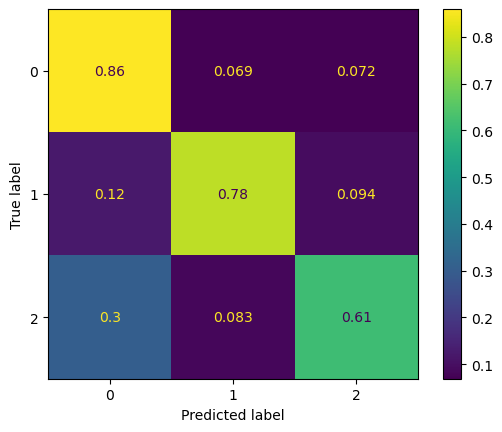

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.71489. Saving Model!
epoch 01, loss: 0.61853, acc: 0.74097, val_loss: 0.71489, val_accuracy: 0.70442


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 02, loss: 0.61443, acc: 0.73606, val_loss: 0.75971, val_accuracy: 0.69153


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 03, loss: 0.61376, acc: 0.74189, val_loss: 0.77287, val_accuracy: 0.68324


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 04, loss: 0.60689, acc: 0.75018, val_loss: 0.77421, val_accuracy: 0.68508


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 05, loss: 0.60440, acc: 0.75243, val_loss: 0.79806, val_accuracy: 0.67035


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 06, loss: 0.60321, acc: 0.75632, val_loss: 0.84627, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 07, loss: 0.59901, acc: 0.75407, val_loss: 0.86968, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 08, loss: 0.59743, acc: 0.75049, val_loss: 0.87055, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.34it/s]


epoch 09, loss: 0.59594, acc: 0.74895, val_loss: 0.89669, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 10, loss: 0.59285, acc: 0.75161, val_loss: 0.92037, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 11, loss: 0.59163, acc: 0.75233, val_loss: 0.91630, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 12, loss: 0.58973, acc: 0.75560, val_loss: 0.92258, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 13, loss: 0.58708, acc: 0.75785, val_loss: 0.92814, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 14, loss: 0.58480, acc: 0.75673, val_loss: 0.92459, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 15, loss: 0.58390, acc: 0.76359, val_loss: 0.93667, val_accuracy: 0.56998


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 16, loss: 0.58144, acc: 0.75867, val_loss: 0.95080, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 17, loss: 0.57950, acc: 0.76574, val_loss: 0.96327, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 18, loss: 0.57867, acc: 0.77177, val_loss: 0.96626, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 19, loss: 0.57662, acc: 0.76635, val_loss: 0.94946, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 20, loss: 0.57465, acc: 0.76758, val_loss: 0.95267, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 21, loss: 0.57333, acc: 0.77269, val_loss: 0.97407, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 22, loss: 0.57190, acc: 0.76696, val_loss: 0.98570, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 23, loss: 0.57036, acc: 0.76891, val_loss: 0.99510, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 24, loss: 0.56860, acc: 0.77454, val_loss: 0.99532, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 25, loss: 0.56762, acc: 0.77577, val_loss: 0.99807, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 26, loss: 0.56629, acc: 0.77403, val_loss: 1.02278, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 27, loss: 0.56479, acc: 0.77126, val_loss: 1.02503, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 28, loss: 0.56340, acc: 0.77362, val_loss: 1.00696, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 29, loss: 0.56215, acc: 0.77587, val_loss: 1.01515, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 30, loss: 0.56106, acc: 0.77617, val_loss: 1.02728, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 31, loss: 0.55970, acc: 0.77873, val_loss: 1.02994, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 32, loss: 0.55819, acc: 0.77556, val_loss: 1.02052, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 33, loss: 0.55696, acc: 0.77699, val_loss: 1.01655, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 34, loss: 0.55604, acc: 0.77986, val_loss: 1.03226, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 35, loss: 0.55491, acc: 0.77628, val_loss: 1.03105, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 36, loss: 0.55353, acc: 0.77884, val_loss: 1.03538, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 37, loss: 0.55226, acc: 0.78068, val_loss: 1.03424, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 38, loss: 0.55098, acc: 0.77976, val_loss: 1.03588, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 39, loss: 0.54998, acc: 0.78068, val_loss: 1.05102, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 40, loss: 0.54898, acc: 0.77924, val_loss: 1.04480, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 41, loss: 0.54774, acc: 0.77924, val_loss: 1.04961, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 42, loss: 0.54641, acc: 0.78006, val_loss: 1.05750, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 43, loss: 0.54543, acc: 0.78262, val_loss: 1.05404, val_accuracy: 0.58195


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 44, loss: 0.54426, acc: 0.78324, val_loss: 1.06347, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 45, loss: 0.54331, acc: 0.78354, val_loss: 1.06315, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 46, loss: 0.54240, acc: 0.78528, val_loss: 1.06053, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 47, loss: 0.54129, acc: 0.78201, val_loss: 1.06194, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 48, loss: 0.54008, acc: 0.78764, val_loss: 1.08144, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 49, loss: 0.53898, acc: 0.78856, val_loss: 1.07844, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 50, loss: 0.53800, acc: 0.78324, val_loss: 1.07772, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 51, loss: 0.53690, acc: 0.78661, val_loss: 1.06811, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 52, loss: 0.53591, acc: 0.78856, val_loss: 1.08538, val_accuracy: 0.58471


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 53, loss: 0.53493, acc: 0.78631, val_loss: 1.09098, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 54, loss: 0.53398, acc: 0.78579, val_loss: 1.09471, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 55, loss: 0.53332, acc: 0.78682, val_loss: 1.09554, val_accuracy: 0.59300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 56, loss: 0.53254, acc: 0.78815, val_loss: 1.11375, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 57, loss: 0.53203, acc: 0.78907, val_loss: 1.09461, val_accuracy: 0.59761


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 58, loss: 0.53170, acc: 0.78958, val_loss: 1.11804, val_accuracy: 0.53683


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 59, loss: 0.53146, acc: 0.78815, val_loss: 1.10497, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 60, loss: 0.53100, acc: 0.78979, val_loss: 1.13343, val_accuracy: 0.53223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 61, loss: 0.53034, acc: 0.78446, val_loss: 1.10941, val_accuracy: 0.59392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 62, loss: 0.52938, acc: 0.79101, val_loss: 1.12093, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 63, loss: 0.52777, acc: 0.78927, val_loss: 1.11105, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 64, loss: 0.52570, acc: 0.79183, val_loss: 1.12873, val_accuracy: 0.59024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 65, loss: 0.52376, acc: 0.79183, val_loss: 1.11982, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 66, loss: 0.52247, acc: 0.79439, val_loss: 1.12225, val_accuracy: 0.60221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 67, loss: 0.52170, acc: 0.79572, val_loss: 1.13365, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 68, loss: 0.52131, acc: 0.79071, val_loss: 1.12777, val_accuracy: 0.60313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 69, loss: 0.52145, acc: 0.79255, val_loss: 1.15040, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 70, loss: 0.52193, acc: 0.79060, val_loss: 1.12597, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 71, loss: 0.52302, acc: 0.79245, val_loss: 1.16722, val_accuracy: 0.53315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 72, loss: 0.52376, acc: 0.78661, val_loss: 1.13890, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 73, loss: 0.52446, acc: 0.79439, val_loss: 1.17099, val_accuracy: 0.52855


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 74, loss: 0.52274, acc: 0.78405, val_loss: 1.14862, val_accuracy: 0.59853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 75, loss: 0.51900, acc: 0.79347, val_loss: 1.15323, val_accuracy: 0.60313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 76, loss: 0.51479, acc: 0.79398, val_loss: 1.15557, val_accuracy: 0.60221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 77, loss: 0.51356, acc: 0.79531, val_loss: 1.14473, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 78, loss: 0.51497, acc: 0.79572, val_loss: 1.17477, val_accuracy: 0.53683


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 79, loss: 0.51654, acc: 0.78968, val_loss: 1.16296, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 80, loss: 0.51650, acc: 0.79501, val_loss: 1.17897, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 81, loss: 0.51395, acc: 0.79050, val_loss: 1.16117, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 82, loss: 0.51086, acc: 0.79715, val_loss: 1.17818, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 83, loss: 0.50850, acc: 0.79859, val_loss: 1.16934, val_accuracy: 0.60221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 84, loss: 0.50773, acc: 0.79849, val_loss: 1.16755, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 85, loss: 0.50822, acc: 0.80043, val_loss: 1.18593, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 86, loss: 0.50898, acc: 0.79255, val_loss: 1.16822, val_accuracy: 0.60221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 87, loss: 0.50933, acc: 0.79756, val_loss: 1.20860, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 88, loss: 0.50875, acc: 0.79562, val_loss: 1.17209, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 89, loss: 0.50679, acc: 0.79859, val_loss: 1.19790, val_accuracy: 0.54144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 90, loss: 0.50418, acc: 0.79695, val_loss: 1.19292, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 91, loss: 0.50213, acc: 0.80094, val_loss: 1.18642, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 92, loss: 0.50122, acc: 0.80207, val_loss: 1.20367, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


epoch 93, loss: 0.50108, acc: 0.80023, val_loss: 1.18448, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 94, loss: 0.50117, acc: 0.79982, val_loss: 1.21063, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 95, loss: 0.50123, acc: 0.79705, val_loss: 1.20278, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 96, loss: 0.50122, acc: 0.80207, val_loss: 1.21757, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 97, loss: 0.50087, acc: 0.79490, val_loss: 1.21085, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 98, loss: 0.49995, acc: 0.80186, val_loss: 1.22212, val_accuracy: 0.54144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 99, loss: 0.49826, acc: 0.79654, val_loss: 1.20860, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 100, loss: 0.49640, acc: 0.80452, val_loss: 1.22202, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 101, loss: 0.49467, acc: 0.80196, val_loss: 1.21661, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 102, loss: 0.49342, acc: 0.80688, val_loss: 1.22591, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 103, loss: 0.49277, acc: 0.80790, val_loss: 1.22754, val_accuracy: 0.54328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 104, loss: 0.49266, acc: 0.80217, val_loss: 1.21979, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 105, loss: 0.49310, acc: 0.80616, val_loss: 1.24241, val_accuracy: 0.54236


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 106, loss: 0.49401, acc: 0.80033, val_loss: 1.22845, val_accuracy: 0.60221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 107, loss: 0.49612, acc: 0.80268, val_loss: 1.26697, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 108, loss: 0.49863, acc: 0.79767, val_loss: 1.24075, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 109, loss: 0.50115, acc: 0.80094, val_loss: 1.26929, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 110, loss: 0.49960, acc: 0.79562, val_loss: 1.25003, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 111, loss: 0.49534, acc: 0.80186, val_loss: 1.24113, val_accuracy: 0.53591


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 112, loss: 0.48915, acc: 0.80299, val_loss: 1.25195, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 113, loss: 0.48646, acc: 0.80678, val_loss: 1.23918, val_accuracy: 0.60866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 114, loss: 0.48851, acc: 0.80544, val_loss: 1.27123, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 115, loss: 0.49189, acc: 0.80074, val_loss: 1.26023, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 116, loss: 0.49340, acc: 0.80391, val_loss: 1.26600, val_accuracy: 0.54052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 117, loss: 0.49018, acc: 0.80012, val_loss: 1.26612, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 118, loss: 0.48506, acc: 0.80882, val_loss: 1.26356, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 119, loss: 0.48220, acc: 0.80923, val_loss: 1.26446, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 120, loss: 0.48316, acc: 0.80575, val_loss: 1.26405, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 121, loss: 0.48585, acc: 0.80718, val_loss: 1.27787, val_accuracy: 0.53499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 122, loss: 0.48647, acc: 0.80340, val_loss: 1.27123, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 123, loss: 0.48419, acc: 0.80739, val_loss: 1.27462, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 124, loss: 0.48066, acc: 0.80841, val_loss: 1.25940, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 125, loss: 0.47857, acc: 0.81281, val_loss: 1.28181, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 126, loss: 0.47839, acc: 0.81312, val_loss: 1.27348, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 127, loss: 0.47918, acc: 0.80616, val_loss: 1.27809, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 128, loss: 0.47949, acc: 0.81425, val_loss: 1.29204, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


epoch 129, loss: 0.47933, acc: 0.80780, val_loss: 1.27007, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 130, loss: 0.47896, acc: 0.80831, val_loss: 1.30662, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 131, loss: 0.47772, acc: 0.81025, val_loss: 1.26470, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 132, loss: 0.47580, acc: 0.80933, val_loss: 1.30320, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


epoch 133, loss: 0.47413, acc: 0.81251, val_loss: 1.28268, val_accuracy: 0.54696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 134, loss: 0.47322, acc: 0.81302, val_loss: 1.28937, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 135, loss: 0.47313, acc: 0.81640, val_loss: 1.30633, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 136, loss: 0.47338, acc: 0.81271, val_loss: 1.28534, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 137, loss: 0.47356, acc: 0.81476, val_loss: 1.31944, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 138, loss: 0.47326, acc: 0.81179, val_loss: 1.28576, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 139, loss: 0.47260, acc: 0.81363, val_loss: 1.31428, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 140, loss: 0.47164, acc: 0.81292, val_loss: 1.30054, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 141, loss: 0.47023, acc: 0.81609, val_loss: 1.31037, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


epoch 142, loss: 0.46877, acc: 0.81199, val_loss: 1.31359, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 143, loss: 0.46778, acc: 0.81517, val_loss: 1.28703, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 144, loss: 0.46740, acc: 0.81527, val_loss: 1.33263, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 145, loss: 0.46728, acc: 0.81476, val_loss: 1.29930, val_accuracy: 0.60866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 146, loss: 0.46707, acc: 0.81721, val_loss: 1.33321, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 147, loss: 0.46718, acc: 0.81537, val_loss: 1.31601, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 148, loss: 0.46766, acc: 0.81875, val_loss: 1.33338, val_accuracy: 0.54512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 149, loss: 0.46890, acc: 0.81353, val_loss: 1.33908, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 150, loss: 0.47096, acc: 0.81762, val_loss: 1.33517, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 151, loss: 0.47397, acc: 0.80790, val_loss: 1.36072, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 152, loss: 0.47603, acc: 0.81322, val_loss: 1.34567, val_accuracy: 0.53959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 153, loss: 0.47571, acc: 0.80626, val_loss: 1.33901, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 154, loss: 0.47109, acc: 0.81619, val_loss: 1.35373, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 155, loss: 0.46460, acc: 0.81660, val_loss: 1.31483, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 156, loss: 0.46143, acc: 0.81619, val_loss: 1.34535, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 157, loss: 0.46296, acc: 0.82100, val_loss: 1.32611, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 158, loss: 0.46631, acc: 0.81240, val_loss: 1.34022, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 159, loss: 0.46780, acc: 0.81701, val_loss: 1.37800, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 160, loss: 0.46608, acc: 0.81220, val_loss: 1.32046, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 161, loss: 0.46258, acc: 0.81711, val_loss: 1.36776, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 162, loss: 0.45990, acc: 0.81773, val_loss: 1.32344, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 163, loss: 0.45850, acc: 0.81660, val_loss: 1.35765, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 164, loss: 0.45914, acc: 0.82161, val_loss: 1.37053, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


epoch 165, loss: 0.46047, acc: 0.81783, val_loss: 1.32572, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 166, loss: 0.46050, acc: 0.82018, val_loss: 1.38896, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 167, loss: 0.45886, acc: 0.81670, val_loss: 1.33685, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 168, loss: 0.45592, acc: 0.82243, val_loss: 1.35624, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 169, loss: 0.45398, acc: 0.82018, val_loss: 1.35711, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 170, loss: 0.45396, acc: 0.82110, val_loss: 1.34653, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 171, loss: 0.45495, acc: 0.82335, val_loss: 1.38720, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 172, loss: 0.45584, acc: 0.82039, val_loss: 1.33164, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 173, loss: 0.45513, acc: 0.82243, val_loss: 1.37748, val_accuracy: 0.55433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 174, loss: 0.45323, acc: 0.82315, val_loss: 1.37253, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 175, loss: 0.45157, acc: 0.82131, val_loss: 1.34764, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 176, loss: 0.45092, acc: 0.81998, val_loss: 1.38427, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 177, loss: 0.45107, acc: 0.82274, val_loss: 1.35006, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 178, loss: 0.45101, acc: 0.82243, val_loss: 1.39514, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 179, loss: 0.45074, acc: 0.82254, val_loss: 1.36699, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 180, loss: 0.45024, acc: 0.82622, val_loss: 1.37591, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 181, loss: 0.45016, acc: 0.82233, val_loss: 1.39099, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.34it/s]


epoch 182, loss: 0.45030, acc: 0.82295, val_loss: 1.36478, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 183, loss: 0.45051, acc: 0.82090, val_loss: 1.39560, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 184, loss: 0.45013, acc: 0.82366, val_loss: 1.37810, val_accuracy: 0.54788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 185, loss: 0.44966, acc: 0.82182, val_loss: 1.39024, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 186, loss: 0.44855, acc: 0.82428, val_loss: 1.39559, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 187, loss: 0.44772, acc: 0.82325, val_loss: 1.36670, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 188, loss: 0.44729, acc: 0.82694, val_loss: 1.42117, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 189, loss: 0.44705, acc: 0.82335, val_loss: 1.36858, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


epoch 190, loss: 0.44592, acc: 0.82571, val_loss: 1.41125, val_accuracy: 0.56722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 191, loss: 0.44459, acc: 0.82428, val_loss: 1.37851, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 192, loss: 0.44316, acc: 0.82694, val_loss: 1.39186, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 193, loss: 0.44237, acc: 0.82694, val_loss: 1.41128, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 194, loss: 0.44233, acc: 0.82612, val_loss: 1.37283, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 195, loss: 0.44252, acc: 0.82663, val_loss: 1.42365, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 196, loss: 0.44278, acc: 0.82540, val_loss: 1.37568, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 197, loss: 0.44257, acc: 0.82755, val_loss: 1.41910, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 198, loss: 0.44266, acc: 0.82458, val_loss: 1.39691, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 199, loss: 0.44316, acc: 0.82868, val_loss: 1.41642, val_accuracy: 0.55157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 200, loss: 0.44495, acc: 0.82315, val_loss: 1.43342, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 201, loss: 0.44833, acc: 0.82550, val_loss: 1.40881, val_accuracy: 0.54420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 202, loss: 0.45463, acc: 0.81435, val_loss: 1.48288, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 203, loss: 0.46276, acc: 0.81445, val_loss: 1.44802, val_accuracy: 0.53775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 204, loss: 0.47106, acc: 0.80514, val_loss: 1.46137, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 205, loss: 0.46544, acc: 0.81066, val_loss: 1.47321, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 206, loss: 0.44982, acc: 0.81875, val_loss: 1.37148, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 207, loss: 0.44100, acc: 0.82028, val_loss: 1.45069, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 208, loss: 0.44567, acc: 0.82479, val_loss: 1.42672, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 209, loss: 0.45236, acc: 0.81445, val_loss: 1.40689, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 210, loss: 0.45114, acc: 0.82356, val_loss: 1.49520, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 211, loss: 0.44450, acc: 0.82335, val_loss: 1.39295, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 212, loss: 0.43934, acc: 0.82161, val_loss: 1.42762, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 213, loss: 0.44105, acc: 0.82816, val_loss: 1.45159, val_accuracy: 0.56722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 214, loss: 0.44448, acc: 0.82141, val_loss: 1.38592, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 215, loss: 0.44442, acc: 0.82264, val_loss: 1.49738, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 216, loss: 0.43871, acc: 0.82530, val_loss: 1.42369, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 217, loss: 0.43418, acc: 0.82387, val_loss: 1.38875, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 218, loss: 0.43831, acc: 0.82683, val_loss: 1.48021, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 219, loss: 0.44202, acc: 0.82295, val_loss: 1.42021, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 220, loss: 0.43740, acc: 0.82530, val_loss: 1.44411, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 221, loss: 0.43209, acc: 0.82909, val_loss: 1.44442, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 222, loss: 0.43276, acc: 0.82868, val_loss: 1.38976, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 223, loss: 0.43551, acc: 0.82888, val_loss: 1.47278, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 224, loss: 0.43488, acc: 0.82694, val_loss: 1.44599, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 225, loss: 0.43171, acc: 0.83246, val_loss: 1.40968, val_accuracy: 0.55525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 226, loss: 0.43087, acc: 0.82520, val_loss: 1.46549, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 227, loss: 0.43122, acc: 0.82990, val_loss: 1.41468, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 228, loss: 0.43083, acc: 0.82878, val_loss: 1.43220, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 229, loss: 0.43042, acc: 0.82888, val_loss: 1.45296, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 230, loss: 0.43082, acc: 0.83031, val_loss: 1.41586, val_accuracy: 0.55249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 231, loss: 0.43003, acc: 0.82612, val_loss: 1.46971, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 232, loss: 0.42791, acc: 0.83451, val_loss: 1.44103, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 233, loss: 0.42677, acc: 0.83523, val_loss: 1.42117, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 234, loss: 0.42787, acc: 0.82591, val_loss: 1.47506, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 235, loss: 0.42910, acc: 0.83134, val_loss: 1.42871, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 236, loss: 0.42868, acc: 0.82704, val_loss: 1.44604, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


epoch 237, loss: 0.42699, acc: 0.83185, val_loss: 1.46039, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 238, loss: 0.42598, acc: 0.83083, val_loss: 1.43094, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 239, loss: 0.42563, acc: 0.83093, val_loss: 1.47767, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 240, loss: 0.42491, acc: 0.83349, val_loss: 1.43452, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 241, loss: 0.42404, acc: 0.82980, val_loss: 1.44238, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 242, loss: 0.42385, acc: 0.83420, val_loss: 1.47200, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 243, loss: 0.42407, acc: 0.83205, val_loss: 1.43790, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 244, loss: 0.42378, acc: 0.83267, val_loss: 1.46313, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 245, loss: 0.42263, acc: 0.83502, val_loss: 1.45043, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 246, loss: 0.42175, acc: 0.83523, val_loss: 1.44506, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 247, loss: 0.42142, acc: 0.83553, val_loss: 1.47159, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 248, loss: 0.42133, acc: 0.83512, val_loss: 1.43311, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 249, loss: 0.42108, acc: 0.83246, val_loss: 1.46502, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 250, loss: 0.42066, acc: 0.83512, val_loss: 1.44662, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 251, loss: 0.42018, acc: 0.83482, val_loss: 1.45780, val_accuracy: 0.56538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 252, loss: 0.41987, acc: 0.83318, val_loss: 1.46517, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 253, loss: 0.41986, acc: 0.83410, val_loss: 1.45189, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


epoch 254, loss: 0.41996, acc: 0.83195, val_loss: 1.47319, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 255, loss: 0.42004, acc: 0.83482, val_loss: 1.44669, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 256, loss: 0.42009, acc: 0.83103, val_loss: 1.46998, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 257, loss: 0.42041, acc: 0.83277, val_loss: 1.47643, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 258, loss: 0.42115, acc: 0.83246, val_loss: 1.46248, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 259, loss: 0.42203, acc: 0.83390, val_loss: 1.48055, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 260, loss: 0.42249, acc: 0.83205, val_loss: 1.46642, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 261, loss: 0.42225, acc: 0.83298, val_loss: 1.46822, val_accuracy: 0.55801


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 262, loss: 0.42118, acc: 0.83001, val_loss: 1.49355, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 263, loss: 0.41975, acc: 0.83420, val_loss: 1.44219, val_accuracy: 0.55985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 264, loss: 0.41866, acc: 0.83042, val_loss: 1.50295, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 265, loss: 0.41698, acc: 0.83748, val_loss: 1.45162, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 266, loss: 0.41524, acc: 0.83410, val_loss: 1.46825, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 267, loss: 0.41417, acc: 0.83871, val_loss: 1.47398, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 268, loss: 0.41430, acc: 0.83789, val_loss: 1.44904, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 269, loss: 0.41518, acc: 0.83267, val_loss: 1.50525, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 270, loss: 0.41591, acc: 0.83758, val_loss: 1.45896, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 271, loss: 0.41636, acc: 0.83205, val_loss: 1.49532, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 272, loss: 0.41637, acc: 0.83512, val_loss: 1.48958, val_accuracy: 0.56354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 273, loss: 0.41744, acc: 0.83328, val_loss: 1.46957, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 274, loss: 0.41931, acc: 0.83512, val_loss: 1.51463, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 275, loss: 0.42037, acc: 0.83175, val_loss: 1.48812, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 276, loss: 0.41964, acc: 0.83533, val_loss: 1.48665, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 277, loss: 0.41746, acc: 0.83164, val_loss: 1.51645, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 278, loss: 0.41571, acc: 0.83564, val_loss: 1.45471, val_accuracy: 0.55709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 279, loss: 0.41444, acc: 0.83216, val_loss: 1.52863, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 280, loss: 0.41256, acc: 0.83850, val_loss: 1.46043, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 281, loss: 0.41044, acc: 0.83656, val_loss: 1.48253, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 282, loss: 0.40954, acc: 0.83840, val_loss: 1.49882, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 283, loss: 0.41034, acc: 0.83645, val_loss: 1.46067, val_accuracy: 0.56077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 284, loss: 0.41193, acc: 0.83318, val_loss: 1.52380, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 285, loss: 0.41305, acc: 0.83963, val_loss: 1.47042, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 286, loss: 0.41396, acc: 0.83124, val_loss: 1.51884, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 287, loss: 0.41416, acc: 0.83431, val_loss: 1.51201, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 288, loss: 0.41543, acc: 0.83298, val_loss: 1.48655, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 289, loss: 0.41739, acc: 0.83625, val_loss: 1.53748, val_accuracy: 0.56998


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 290, loss: 0.41709, acc: 0.83267, val_loss: 1.49754, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 291, loss: 0.41381, acc: 0.83666, val_loss: 1.48715, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 292, loss: 0.40946, acc: 0.83379, val_loss: 1.52878, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 293, loss: 0.40804, acc: 0.83789, val_loss: 1.46424, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 294, loss: 0.40789, acc: 0.83656, val_loss: 1.53978, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 295, loss: 0.40769, acc: 0.83819, val_loss: 1.49207, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 296, loss: 0.40703, acc: 0.83963, val_loss: 1.47892, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 297, loss: 0.40785, acc: 0.83543, val_loss: 1.54977, val_accuracy: 0.59024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 298, loss: 0.40979, acc: 0.84045, val_loss: 1.47040, val_accuracy: 0.55617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 299, loss: 0.41129, acc: 0.83257, val_loss: 1.55704, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 300, loss: 0.40950, acc: 0.83993, val_loss: 1.50171, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]


epoch 301, loss: 0.40762, acc: 0.83461, val_loss: 1.49911, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 302, loss: 0.40724, acc: 0.84024, val_loss: 1.54859, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 303, loss: 0.40789, acc: 0.83656, val_loss: 1.48008, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 304, loss: 0.40670, acc: 0.83707, val_loss: 1.54178, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 305, loss: 0.40427, acc: 0.83953, val_loss: 1.51624, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 306, loss: 0.40206, acc: 0.84055, val_loss: 1.49848, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 307, loss: 0.40209, acc: 0.83942, val_loss: 1.55234, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 308, loss: 0.40321, acc: 0.83942, val_loss: 1.48916, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 309, loss: 0.40316, acc: 0.83809, val_loss: 1.53835, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 310, loss: 0.40240, acc: 0.83973, val_loss: 1.52565, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 311, loss: 0.40223, acc: 0.84065, val_loss: 1.49225, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 312, loss: 0.40359, acc: 0.83482, val_loss: 1.57490, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 313, loss: 0.40583, acc: 0.84137, val_loss: 1.49379, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 314, loss: 0.40785, acc: 0.83216, val_loss: 1.57364, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


epoch 315, loss: 0.40841, acc: 0.83789, val_loss: 1.53177, val_accuracy: 0.56446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 316, loss: 0.41017, acc: 0.83308, val_loss: 1.53725, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 317, loss: 0.41308, acc: 0.83707, val_loss: 1.57846, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 318, loss: 0.41475, acc: 0.83349, val_loss: 1.53857, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 319, loss: 0.41260, acc: 0.83819, val_loss: 1.53704, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 320, loss: 0.40600, acc: 0.83553, val_loss: 1.55969, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 321, loss: 0.40074, acc: 0.84167, val_loss: 1.50366, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 322, loss: 0.39936, acc: 0.83850, val_loss: 1.56817, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 323, loss: 0.40026, acc: 0.84004, val_loss: 1.52779, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


epoch 324, loss: 0.40177, acc: 0.83942, val_loss: 1.51293, val_accuracy: 0.56630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 325, loss: 0.40385, acc: 0.83533, val_loss: 1.59702, val_accuracy: 0.59024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 326, loss: 0.40550, acc: 0.83993, val_loss: 1.49825, val_accuracy: 0.55893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 327, loss: 0.40450, acc: 0.83523, val_loss: 1.55618, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 328, loss: 0.39947, acc: 0.84116, val_loss: 1.54196, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 329, loss: 0.39621, acc: 0.84341, val_loss: 1.50631, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 330, loss: 0.39647, acc: 0.84034, val_loss: 1.57286, val_accuracy: 0.59024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 331, loss: 0.39803, acc: 0.84372, val_loss: 1.50601, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 332, loss: 0.39904, acc: 0.83707, val_loss: 1.55556, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 333, loss: 0.39951, acc: 0.84167, val_loss: 1.57604, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 334, loss: 0.40076, acc: 0.83738, val_loss: 1.51971, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 335, loss: 0.40076, acc: 0.84004, val_loss: 1.57083, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 336, loss: 0.39824, acc: 0.84004, val_loss: 1.53643, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 337, loss: 0.39460, acc: 0.84321, val_loss: 1.53194, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 338, loss: 0.39340, acc: 0.84126, val_loss: 1.57486, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 339, loss: 0.39440, acc: 0.84638, val_loss: 1.50965, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 340, loss: 0.39514, acc: 0.84198, val_loss: 1.56847, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 341, loss: 0.39469, acc: 0.84208, val_loss: 1.55785, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 342, loss: 0.39431, acc: 0.84352, val_loss: 1.51983, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 343, loss: 0.39503, acc: 0.83922, val_loss: 1.59348, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 344, loss: 0.39550, acc: 0.84444, val_loss: 1.51958, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 345, loss: 0.39473, acc: 0.83768, val_loss: 1.57986, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 346, loss: 0.39259, acc: 0.84608, val_loss: 1.55104, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 347, loss: 0.39128, acc: 0.84341, val_loss: 1.53841, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 348, loss: 0.39115, acc: 0.84434, val_loss: 1.59358, val_accuracy: 0.58748


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 349, loss: 0.39150, acc: 0.84710, val_loss: 1.52557, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 350, loss: 0.39081, acc: 0.84249, val_loss: 1.56676, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 351, loss: 0.38984, acc: 0.84761, val_loss: 1.55274, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 352, loss: 0.38924, acc: 0.84505, val_loss: 1.54631, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 353, loss: 0.38953, acc: 0.84577, val_loss: 1.57977, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 354, loss: 0.39001, acc: 0.84608, val_loss: 1.53738, val_accuracy: 0.57366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 355, loss: 0.39010, acc: 0.84474, val_loss: 1.57386, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 356, loss: 0.39002, acc: 0.84546, val_loss: 1.56454, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 357, loss: 0.39008, acc: 0.84393, val_loss: 1.54039, val_accuracy: 0.56998


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 358, loss: 0.39086, acc: 0.84126, val_loss: 1.59857, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 359, loss: 0.39234, acc: 0.84341, val_loss: 1.53926, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 360, loss: 0.39447, acc: 0.83666, val_loss: 1.62110, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 361, loss: 0.39618, acc: 0.84300, val_loss: 1.55724, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 362, loss: 0.39832, acc: 0.83605, val_loss: 1.59575, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 363, loss: 0.40067, acc: 0.84116, val_loss: 1.60100, val_accuracy: 0.56906


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.57it/s]


epoch 364, loss: 0.40207, acc: 0.83850, val_loss: 1.57590, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 365, loss: 0.40110, acc: 0.84300, val_loss: 1.58077, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 366, loss: 0.39530, acc: 0.83983, val_loss: 1.57430, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 367, loss: 0.38891, acc: 0.84710, val_loss: 1.54177, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 368, loss: 0.38650, acc: 0.84464, val_loss: 1.59530, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 369, loss: 0.38789, acc: 0.84741, val_loss: 1.54867, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 370, loss: 0.39041, acc: 0.84382, val_loss: 1.57548, val_accuracy: 0.56814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 371, loss: 0.39176, acc: 0.84126, val_loss: 1.61566, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 372, loss: 0.39276, acc: 0.84372, val_loss: 1.52592, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.07it/s]


epoch 373, loss: 0.39295, acc: 0.83860, val_loss: 1.61432, val_accuracy: 0.59392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 374, loss: 0.38984, acc: 0.84628, val_loss: 1.55251, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 375, loss: 0.38590, acc: 0.84423, val_loss: 1.57284, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 376, loss: 0.38357, acc: 0.84741, val_loss: 1.58804, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 377, loss: 0.38445, acc: 0.84976, val_loss: 1.53136, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 378, loss: 0.38641, acc: 0.84219, val_loss: 1.62148, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 379, loss: 0.38748, acc: 0.84464, val_loss: 1.56540, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 380, loss: 0.38767, acc: 0.84290, val_loss: 1.56633, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 381, loss: 0.38781, acc: 0.84618, val_loss: 1.60589, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 382, loss: 0.38756, acc: 0.84434, val_loss: 1.55595, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 383, loss: 0.38600, acc: 0.84700, val_loss: 1.59841, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 384, loss: 0.38334, acc: 0.84915, val_loss: 1.56288, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 385, loss: 0.38144, acc: 0.85058, val_loss: 1.55993, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 386, loss: 0.38171, acc: 0.84792, val_loss: 1.61039, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 387, loss: 0.38324, acc: 0.84771, val_loss: 1.55679, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 388, loss: 0.38384, acc: 0.84679, val_loss: 1.60101, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 389, loss: 0.38377, acc: 0.84884, val_loss: 1.59706, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 390, loss: 0.38333, acc: 0.84720, val_loss: 1.56844, val_accuracy: 0.57090


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 391, loss: 0.38329, acc: 0.84454, val_loss: 1.62043, val_accuracy: 0.59484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 392, loss: 0.38332, acc: 0.84904, val_loss: 1.55588, val_accuracy: 0.58195


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 393, loss: 0.38288, acc: 0.84526, val_loss: 1.62867, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 394, loss: 0.38143, acc: 0.84996, val_loss: 1.58554, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 395, loss: 0.37989, acc: 0.84741, val_loss: 1.58585, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 396, loss: 0.37908, acc: 0.85303, val_loss: 1.61126, val_accuracy: 0.59024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 397, loss: 0.37898, acc: 0.85119, val_loss: 1.56773, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 398, loss: 0.37905, acc: 0.84700, val_loss: 1.61837, val_accuracy: 0.59853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 399, loss: 0.37898, acc: 0.85058, val_loss: 1.57277, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 400, loss: 0.37857, acc: 0.84935, val_loss: 1.61842, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 401, loss: 0.37815, acc: 0.85416, val_loss: 1.59570, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 402, loss: 0.37809, acc: 0.84915, val_loss: 1.57703, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 403, loss: 0.37870, acc: 0.85140, val_loss: 1.61121, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 404, loss: 0.37958, acc: 0.85027, val_loss: 1.58203, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 405, loss: 0.38042, acc: 0.85007, val_loss: 1.60550, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 406, loss: 0.38135, acc: 0.84771, val_loss: 1.60580, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 407, loss: 0.38267, acc: 0.84966, val_loss: 1.58466, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 408, loss: 0.38520, acc: 0.84300, val_loss: 1.66227, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 409, loss: 0.38909, acc: 0.84474, val_loss: 1.56112, val_accuracy: 0.56169


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 410, loss: 0.39365, acc: 0.83697, val_loss: 1.68988, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 411, loss: 0.39463, acc: 0.84239, val_loss: 1.59530, val_accuracy: 0.56722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 412, loss: 0.39333, acc: 0.83758, val_loss: 1.63308, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 413, loss: 0.38737, acc: 0.84720, val_loss: 1.62422, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 414, loss: 0.38125, acc: 0.84822, val_loss: 1.54862, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 415, loss: 0.37774, acc: 0.84781, val_loss: 1.65311, val_accuracy: 0.59853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 416, loss: 0.37841, acc: 0.85170, val_loss: 1.58039, val_accuracy: 0.58195


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 417, loss: 0.38144, acc: 0.84352, val_loss: 1.61151, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 418, loss: 0.38536, acc: 0.84986, val_loss: 1.64928, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 419, loss: 0.38720, acc: 0.84260, val_loss: 1.59659, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 420, loss: 0.38525, acc: 0.84710, val_loss: 1.63520, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 421, loss: 0.37885, acc: 0.84966, val_loss: 1.58067, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 422, loss: 0.37373, acc: 0.85222, val_loss: 1.60653, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 423, loss: 0.37436, acc: 0.85222, val_loss: 1.65316, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 424, loss: 0.37818, acc: 0.84955, val_loss: 1.59190, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 425, loss: 0.37987, acc: 0.84894, val_loss: 1.62280, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 426, loss: 0.37735, acc: 0.85048, val_loss: 1.62797, val_accuracy: 0.58748


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 427, loss: 0.37458, acc: 0.85375, val_loss: 1.58014, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 428, loss: 0.37324, acc: 0.84966, val_loss: 1.63929, val_accuracy: 0.59853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 429, loss: 0.37354, acc: 0.85303, val_loss: 1.58006, val_accuracy: 0.57551


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 430, loss: 0.37367, acc: 0.84976, val_loss: 1.63843, val_accuracy: 0.58748


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 431, loss: 0.37392, acc: 0.85160, val_loss: 1.62399, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 432, loss: 0.37391, acc: 0.85416, val_loss: 1.58362, val_accuracy: 0.58195


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 433, loss: 0.37442, acc: 0.84710, val_loss: 1.66607, val_accuracy: 0.59669


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 434, loss: 0.37485, acc: 0.85303, val_loss: 1.57702, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 435, loss: 0.37453, acc: 0.84853, val_loss: 1.65567, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 436, loss: 0.37268, acc: 0.85375, val_loss: 1.59529, val_accuracy: 0.57919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


epoch 437, loss: 0.37061, acc: 0.85140, val_loss: 1.62245, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 438, loss: 0.36959, acc: 0.85600, val_loss: 1.64416, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 439, loss: 0.36980, acc: 0.85825, val_loss: 1.58385, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 440, loss: 0.37056, acc: 0.85017, val_loss: 1.65828, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.52it/s]


epoch 441, loss: 0.37102, acc: 0.85498, val_loss: 1.59514, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 442, loss: 0.37072, acc: 0.85007, val_loss: 1.64938, val_accuracy: 0.59300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 443, loss: 0.37024, acc: 0.85764, val_loss: 1.61646, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 444, loss: 0.37006, acc: 0.85119, val_loss: 1.61563, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 445, loss: 0.37015, acc: 0.85559, val_loss: 1.64013, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 446, loss: 0.37055, acc: 0.85518, val_loss: 1.59969, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 447, loss: 0.37038, acc: 0.85416, val_loss: 1.63448, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


epoch 448, loss: 0.36964, acc: 0.85508, val_loss: 1.61126, val_accuracy: 0.58195


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]


epoch 449, loss: 0.36843, acc: 0.85590, val_loss: 1.61237, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 450, loss: 0.36763, acc: 0.85334, val_loss: 1.63902, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


epoch 451, loss: 0.36749, acc: 0.85815, val_loss: 1.58665, val_accuracy: 0.58287


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 452, loss: 0.36764, acc: 0.85273, val_loss: 1.65606, val_accuracy: 0.59761


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 453, loss: 0.36777, acc: 0.85836, val_loss: 1.59000, val_accuracy: 0.58195


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 454, loss: 0.36732, acc: 0.85211, val_loss: 1.64824, val_accuracy: 0.59300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 455, loss: 0.36672, acc: 0.85856, val_loss: 1.60251, val_accuracy: 0.58471


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 456, loss: 0.36607, acc: 0.85477, val_loss: 1.62259, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 457, loss: 0.36576, acc: 0.85918, val_loss: 1.62505, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 458, loss: 0.36595, acc: 0.85713, val_loss: 1.60799, val_accuracy: 0.58011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 459, loss: 0.36662, acc: 0.85651, val_loss: 1.64810, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 460, loss: 0.36762, acc: 0.85651, val_loss: 1.61134, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


epoch 461, loss: 0.36881, acc: 0.85529, val_loss: 1.63654, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 462, loss: 0.37067, acc: 0.85170, val_loss: 1.64306, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 463, loss: 0.37384, acc: 0.85211, val_loss: 1.60905, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 464, loss: 0.37976, acc: 0.84536, val_loss: 1.74280, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 465, loss: 0.39048, acc: 0.84300, val_loss: 1.59926, val_accuracy: 0.54972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 466, loss: 0.40800, acc: 0.82571, val_loss: 1.81983, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 467, loss: 0.41761, acc: 0.83287, val_loss: 1.67161, val_accuracy: 0.54880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 468, loss: 0.41712, acc: 0.82213, val_loss: 1.67280, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 469, loss: 0.39124, acc: 0.85048, val_loss: 1.72773, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 470, loss: 0.37439, acc: 0.85037, val_loss: 1.56949, val_accuracy: 0.57182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 471, loss: 0.38592, acc: 0.83819, val_loss: 1.73289, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 472, loss: 0.39587, acc: 0.84270, val_loss: 1.69330, val_accuracy: 0.57459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 473, loss: 0.38540, acc: 0.84208, val_loss: 1.59510, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 474, loss: 0.37205, acc: 0.84833, val_loss: 1.75733, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 475, loss: 0.37681, acc: 0.84792, val_loss: 1.63649, val_accuracy: 0.57643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 476, loss: 0.38379, acc: 0.84249, val_loss: 1.59200, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 477, loss: 0.38330, acc: 0.85017, val_loss: 1.73833, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 478, loss: 0.37960, acc: 0.84771, val_loss: 1.59721, val_accuracy: 0.57274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 479, loss: 0.37083, acc: 0.84945, val_loss: 1.64390, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 480, loss: 0.37426, acc: 0.85590, val_loss: 1.70197, val_accuracy: 0.59761


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 481, loss: 0.38066, acc: 0.84618, val_loss: 1.57239, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 482, loss: 0.37112, acc: 0.84812, val_loss: 1.67132, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 483, loss: 0.36358, acc: 0.85723, val_loss: 1.67237, val_accuracy: 0.58379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 484, loss: 0.37053, acc: 0.85293, val_loss: 1.54922, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 485, loss: 0.37535, acc: 0.84925, val_loss: 1.68554, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.04it/s]


epoch 486, loss: 0.36860, acc: 0.85580, val_loss: 1.65163, val_accuracy: 0.58748


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 487, loss: 0.36205, acc: 0.85795, val_loss: 1.58985, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 488, loss: 0.36701, acc: 0.85559, val_loss: 1.67582, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 489, loss: 0.37266, acc: 0.85068, val_loss: 1.59178, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 490, loss: 0.36495, acc: 0.85457, val_loss: 1.61293, val_accuracy: 0.58564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 491, loss: 0.36148, acc: 0.85692, val_loss: 1.68113, val_accuracy: 0.59392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 492, loss: 0.36515, acc: 0.85559, val_loss: 1.58106, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 493, loss: 0.36530, acc: 0.85406, val_loss: 1.63674, val_accuracy: 0.58656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 494, loss: 0.36187, acc: 0.85621, val_loss: 1.68143, val_accuracy: 0.59576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 495, loss: 0.36107, acc: 0.86071, val_loss: 1.58300, val_accuracy: 0.58103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 496, loss: 0.36189, acc: 0.85549, val_loss: 1.64928, val_accuracy: 0.59208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 497, loss: 0.36160, acc: 0.85713, val_loss: 1.63759, val_accuracy: 0.58840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 498, loss: 0.36046, acc: 0.85948, val_loss: 1.59118, val_accuracy: 0.58471


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 499, loss: 0.36117, acc: 0.85488, val_loss: 1.69637, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 500, loss: 0.36172, acc: 0.85703, val_loss: 1.61657, val_accuracy: 0.57919
2번째 교차검증
evaluation loss: 0.71489, evaluation accuracy: 0.70442
(5, 1086)
(1086, 5)
Learning rate set to 0.066007
0:	learn: 1.0376689	total: 8.27ms	remaining: 8.26s
1:	learn: 0.9856774	total: 16ms	remaining: 7.98s
2:	learn: 0.9401344	total: 25.4ms	remaining: 8.45s
3:	learn: 0.9001648	total: 32.6ms	remaining: 8.11s
4:	learn: 0.8648166	total: 39.5ms	remaining: 7.87s
5:	learn: 0.8335733	total: 46.5ms	remaining: 7.7s
6:	learn: 0.8056128	total: 53.5ms	remaining: 7.59s
7:	learn: 0.7804386	total: 60.3ms	remaining: 7.48s
8:	learn: 0.7575514	total: 67.9ms	remaining: 7.48s
9:	learn: 0.7370022	total: 76.9ms	remaining: 7.62s
10:	learn: 0.7183509	total: 84.8ms	remaining: 7.62s
11:	learn: 0.7013188	total: 91.9ms	remaining: 7.56s
12:	learn: 0.6858105	total: 99.4ms	remaining: 7.54s
13:	learn: 0.6716155	total: 106ms	remaining: 7.49s
14:	learn: 0.6586338	total: 113ms	remaining: 7.44s
15:	learn: 0.6467489	total: 120ms	remain

169:	learn: 0.4678685	total: 1.24s	remaining: 6.06s
170:	learn: 0.4677894	total: 1.25s	remaining: 6.06s
171:	learn: 0.4677171	total: 1.26s	remaining: 6.06s
172:	learn: 0.4676460	total: 1.27s	remaining: 6.07s
173:	learn: 0.4675708	total: 1.28s	remaining: 6.08s
174:	learn: 0.4675040	total: 1.29s	remaining: 6.08s
175:	learn: 0.4674429	total: 1.3s	remaining: 6.09s
176:	learn: 0.4673712	total: 1.31s	remaining: 6.09s
177:	learn: 0.4673010	total: 1.32s	remaining: 6.09s
178:	learn: 0.4672353	total: 1.33s	remaining: 6.1s
179:	learn: 0.4671666	total: 1.34s	remaining: 6.09s
180:	learn: 0.4670985	total: 1.34s	remaining: 6.08s
181:	learn: 0.4670320	total: 1.35s	remaining: 6.08s
182:	learn: 0.4669656	total: 1.36s	remaining: 6.07s
183:	learn: 0.4668992	total: 1.36s	remaining: 6.06s
184:	learn: 0.4668371	total: 1.37s	remaining: 6.05s
185:	learn: 0.4667727	total: 1.38s	remaining: 6.04s
186:	learn: 0.4667136	total: 1.39s	remaining: 6.03s
187:	learn: 0.4666421	total: 1.39s	remaining: 6.02s
188:	learn: 0.

335:	learn: 0.4619941	total: 2.49s	remaining: 4.92s
336:	learn: 0.4619785	total: 2.5s	remaining: 4.91s
337:	learn: 0.4619597	total: 2.5s	remaining: 4.9s
338:	learn: 0.4619459	total: 2.51s	remaining: 4.89s
339:	learn: 0.4619273	total: 2.52s	remaining: 4.88s
340:	learn: 0.4619095	total: 2.52s	remaining: 4.88s
341:	learn: 0.4618962	total: 2.53s	remaining: 4.87s
342:	learn: 0.4618821	total: 2.54s	remaining: 4.86s
343:	learn: 0.4618648	total: 2.54s	remaining: 4.85s
344:	learn: 0.4618515	total: 2.55s	remaining: 4.84s
345:	learn: 0.4618376	total: 2.56s	remaining: 4.84s
346:	learn: 0.4618209	total: 2.57s	remaining: 4.83s
347:	learn: 0.4618015	total: 2.57s	remaining: 4.82s
348:	learn: 0.4617879	total: 2.58s	remaining: 4.81s
349:	learn: 0.4617744	total: 2.59s	remaining: 4.8s
350:	learn: 0.4617594	total: 2.59s	remaining: 4.79s
351:	learn: 0.4617443	total: 2.6s	remaining: 4.79s
352:	learn: 0.4617256	total: 2.61s	remaining: 4.78s
353:	learn: 0.4617134	total: 2.62s	remaining: 4.78s
354:	learn: 0.461

510:	learn: 0.4601302	total: 3.93s	remaining: 3.76s
511:	learn: 0.4601220	total: 3.94s	remaining: 3.76s
512:	learn: 0.4601156	total: 3.95s	remaining: 3.75s
513:	learn: 0.4601103	total: 3.97s	remaining: 3.75s
514:	learn: 0.4601019	total: 3.98s	remaining: 3.75s
515:	learn: 0.4600966	total: 3.99s	remaining: 3.74s
516:	learn: 0.4600877	total: 4s	remaining: 3.74s
517:	learn: 0.4600810	total: 4.01s	remaining: 3.73s
518:	learn: 0.4600759	total: 4.03s	remaining: 3.73s
519:	learn: 0.4600681	total: 4.04s	remaining: 3.73s
520:	learn: 0.4600604	total: 4.05s	remaining: 3.72s
521:	learn: 0.4600511	total: 4.06s	remaining: 3.72s
522:	learn: 0.4600434	total: 4.07s	remaining: 3.71s
523:	learn: 0.4600375	total: 4.08s	remaining: 3.71s
524:	learn: 0.4600324	total: 4.09s	remaining: 3.71s
525:	learn: 0.4600261	total: 4.11s	remaining: 3.7s
526:	learn: 0.4600207	total: 4.12s	remaining: 3.7s
527:	learn: 0.4600132	total: 4.13s	remaining: 3.69s
528:	learn: 0.4600053	total: 4.15s	remaining: 3.69s
529:	learn: 0.459

682:	learn: 0.4592435	total: 5.6s	remaining: 2.6s
683:	learn: 0.4592405	total: 5.61s	remaining: 2.59s
684:	learn: 0.4592353	total: 5.62s	remaining: 2.58s
685:	learn: 0.4592324	total: 5.63s	remaining: 2.58s
686:	learn: 0.4592296	total: 5.64s	remaining: 2.57s
687:	learn: 0.4592255	total: 5.64s	remaining: 2.56s
688:	learn: 0.4592207	total: 5.65s	remaining: 2.55s
689:	learn: 0.4592179	total: 5.66s	remaining: 2.54s
690:	learn: 0.4592129	total: 5.67s	remaining: 2.54s
691:	learn: 0.4592096	total: 5.7s	remaining: 2.54s
692:	learn: 0.4592039	total: 5.71s	remaining: 2.53s
693:	learn: 0.4591997	total: 5.72s	remaining: 2.52s
694:	learn: 0.4591953	total: 5.73s	remaining: 2.51s
695:	learn: 0.4591914	total: 5.74s	remaining: 2.5s
696:	learn: 0.4591877	total: 5.74s	remaining: 2.5s
697:	learn: 0.4591845	total: 5.75s	remaining: 2.49s
698:	learn: 0.4591814	total: 5.76s	remaining: 2.48s
699:	learn: 0.4591787	total: 5.77s	remaining: 2.47s
700:	learn: 0.4591742	total: 5.78s	remaining: 2.46s
701:	learn: 0.459

848:	learn: 0.4587217	total: 7.07s	remaining: 1.26s
849:	learn: 0.4587200	total: 7.07s	remaining: 1.25s
850:	learn: 0.4587168	total: 7.08s	remaining: 1.24s
851:	learn: 0.4587140	total: 7.09s	remaining: 1.23s
852:	learn: 0.4587123	total: 7.1s	remaining: 1.22s
853:	learn: 0.4587106	total: 7.1s	remaining: 1.21s
854:	learn: 0.4587077	total: 7.11s	remaining: 1.21s
855:	learn: 0.4587061	total: 7.12s	remaining: 1.2s
856:	learn: 0.4587023	total: 7.13s	remaining: 1.19s
857:	learn: 0.4587006	total: 7.14s	remaining: 1.18s
858:	learn: 0.4586986	total: 7.15s	remaining: 1.17s
859:	learn: 0.4586965	total: 7.16s	remaining: 1.17s
860:	learn: 0.4586938	total: 7.16s	remaining: 1.16s
861:	learn: 0.4586904	total: 7.17s	remaining: 1.15s
862:	learn: 0.4586887	total: 7.18s	remaining: 1.14s
863:	learn: 0.4586871	total: 7.19s	remaining: 1.13s
864:	learn: 0.4586854	total: 7.2s	remaining: 1.12s
865:	learn: 0.4586834	total: 7.21s	remaining: 1.11s
866:	learn: 0.4586805	total: 7.21s	remaining: 1.11s
867:	learn: 0.45

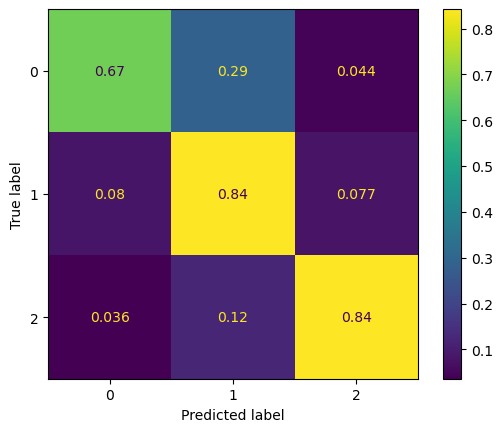

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.63738. Saving Model!
epoch 01, loss: 0.62351, acc: 0.73227, val_loss: 0.63738, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


epoch 02, loss: 0.62287, acc: 0.73288, val_loss: 0.64394, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 03, loss: 0.62182, acc: 0.74158, val_loss: 0.65351, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 04, loss: 0.61689, acc: 0.74138, val_loss: 0.67295, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 05, loss: 0.61787, acc: 0.74199, val_loss: 0.67998, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 06, loss: 0.61298, acc: 0.74455, val_loss: 0.69007, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 07, loss: 0.61531, acc: 0.74629, val_loss: 0.70099, val_accuracy: 0.69337


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 08, loss: 0.60849, acc: 0.74680, val_loss: 0.72305, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 09, loss: 0.60976, acc: 0.74936, val_loss: 0.72879, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 10, loss: 0.60726, acc: 0.75243, val_loss: 0.72377, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 11, loss: 0.60512, acc: 0.75693, val_loss: 0.72728, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 12, loss: 0.60460, acc: 0.75417, val_loss: 0.74299, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 13, loss: 0.60200, acc: 0.75499, val_loss: 0.75771, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 14, loss: 0.60205, acc: 0.75581, val_loss: 0.75768, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 15, loss: 0.59889, acc: 0.76277, val_loss: 0.76104, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 16, loss: 0.59945, acc: 0.76000, val_loss: 0.77241, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 17, loss: 0.59695, acc: 0.75990, val_loss: 0.78858, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 18, loss: 0.59657, acc: 0.75806, val_loss: 0.79287, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 19, loss: 0.59534, acc: 0.75888, val_loss: 0.78688, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 20, loss: 0.59371, acc: 0.76000, val_loss: 0.78796, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


epoch 21, loss: 0.59335, acc: 0.76164, val_loss: 0.79886, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 22, loss: 0.59190, acc: 0.76686, val_loss: 0.80913, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 23, loss: 0.59132, acc: 0.76492, val_loss: 0.80986, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 24, loss: 0.58960, acc: 0.76144, val_loss: 0.81230, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 25, loss: 0.58953, acc: 0.76072, val_loss: 0.82197, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 26, loss: 0.58785, acc: 0.76287, val_loss: 0.83335, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.93it/s]


epoch 27, loss: 0.58736, acc: 0.76594, val_loss: 0.83398, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 28, loss: 0.58614, acc: 0.76686, val_loss: 0.83003, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 29, loss: 0.58534, acc: 0.76481, val_loss: 0.83303, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 30, loss: 0.58435, acc: 0.76502, val_loss: 0.84180, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 31, loss: 0.58356, acc: 0.76471, val_loss: 0.84646, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 32, loss: 0.58264, acc: 0.76481, val_loss: 0.84627, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 33, loss: 0.58168, acc: 0.76696, val_loss: 0.84986, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 34, loss: 0.58094, acc: 0.76604, val_loss: 0.85935, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 35, loss: 0.57998, acc: 0.76410, val_loss: 0.86309, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 36, loss: 0.57930, acc: 0.76338, val_loss: 0.86001, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 37, loss: 0.57834, acc: 0.76512, val_loss: 0.85902, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 38, loss: 0.57764, acc: 0.76829, val_loss: 0.86378, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 39, loss: 0.57677, acc: 0.76901, val_loss: 0.86810, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 40, loss: 0.57613, acc: 0.76860, val_loss: 0.86721, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 41, loss: 0.57519, acc: 0.76574, val_loss: 0.86782, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 42, loss: 0.57457, acc: 0.76635, val_loss: 0.87303, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 43, loss: 0.57374, acc: 0.76563, val_loss: 0.87780, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 44, loss: 0.57301, acc: 0.76840, val_loss: 0.87781, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 45, loss: 0.57222, acc: 0.77065, val_loss: 0.87827, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 46, loss: 0.57153, acc: 0.76829, val_loss: 0.88313, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.50it/s]


epoch 47, loss: 0.57071, acc: 0.76788, val_loss: 0.88710, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 48, loss: 0.57006, acc: 0.76614, val_loss: 0.88732, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 49, loss: 0.56929, acc: 0.76850, val_loss: 0.88711, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 50, loss: 0.56861, acc: 0.76993, val_loss: 0.89123, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 51, loss: 0.56788, acc: 0.77229, val_loss: 0.89488, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 52, loss: 0.56717, acc: 0.77259, val_loss: 0.89481, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 53, loss: 0.56641, acc: 0.77280, val_loss: 0.89652, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 54, loss: 0.56572, acc: 0.77269, val_loss: 0.90031, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 55, loss: 0.56500, acc: 0.77464, val_loss: 0.90270, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 56, loss: 0.56434, acc: 0.77454, val_loss: 0.90223, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 57, loss: 0.56365, acc: 0.77546, val_loss: 0.90391, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 58, loss: 0.56300, acc: 0.77556, val_loss: 0.90845, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 59, loss: 0.56230, acc: 0.77546, val_loss: 0.91079, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 60, loss: 0.56160, acc: 0.77617, val_loss: 0.91102, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 61, loss: 0.56096, acc: 0.77679, val_loss: 0.91359, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 62, loss: 0.56029, acc: 0.77699, val_loss: 0.91708, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 63, loss: 0.55965, acc: 0.77689, val_loss: 0.91790, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 64, loss: 0.55902, acc: 0.77679, val_loss: 0.91776, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 65, loss: 0.55838, acc: 0.77730, val_loss: 0.92025, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 66, loss: 0.55775, acc: 0.77761, val_loss: 0.92363, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 67, loss: 0.55710, acc: 0.77822, val_loss: 0.92521, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 68, loss: 0.55644, acc: 0.77822, val_loss: 0.92766, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 69, loss: 0.55583, acc: 0.77802, val_loss: 0.93043, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 70, loss: 0.55522, acc: 0.77904, val_loss: 0.93223, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 71, loss: 0.55461, acc: 0.77955, val_loss: 0.93407, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 72, loss: 0.55395, acc: 0.77976, val_loss: 0.93668, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 73, loss: 0.55331, acc: 0.78017, val_loss: 0.93816, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 74, loss: 0.55273, acc: 0.78027, val_loss: 0.93911, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 75, loss: 0.55211, acc: 0.78252, val_loss: 0.94106, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 76, loss: 0.55149, acc: 0.78242, val_loss: 0.94284, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 77, loss: 0.55087, acc: 0.78303, val_loss: 0.94348, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 78, loss: 0.55025, acc: 0.78303, val_loss: 0.94630, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 79, loss: 0.54964, acc: 0.78313, val_loss: 0.94871, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 80, loss: 0.54901, acc: 0.78313, val_loss: 0.95031, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 81, loss: 0.54843, acc: 0.78313, val_loss: 0.95258, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 82, loss: 0.54785, acc: 0.78334, val_loss: 0.95561, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 83, loss: 0.54722, acc: 0.78344, val_loss: 0.95598, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 84, loss: 0.54664, acc: 0.78354, val_loss: 0.95720, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 85, loss: 0.54605, acc: 0.78375, val_loss: 0.95837, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 86, loss: 0.54547, acc: 0.78416, val_loss: 0.96007, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 87, loss: 0.54487, acc: 0.78457, val_loss: 0.96227, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 88, loss: 0.54426, acc: 0.78487, val_loss: 0.96223, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 89, loss: 0.54369, acc: 0.78498, val_loss: 0.96305, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 90, loss: 0.54311, acc: 0.78457, val_loss: 0.96577, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 91, loss: 0.54251, acc: 0.78518, val_loss: 0.96748, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 92, loss: 0.54192, acc: 0.78518, val_loss: 0.96871, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 93, loss: 0.54133, acc: 0.78539, val_loss: 0.96946, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 94, loss: 0.54076, acc: 0.78610, val_loss: 0.97218, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 95, loss: 0.54018, acc: 0.78518, val_loss: 0.97323, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 96, loss: 0.53960, acc: 0.78539, val_loss: 0.97420, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 97, loss: 0.53907, acc: 0.78610, val_loss: 0.97670, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 98, loss: 0.53849, acc: 0.78661, val_loss: 0.97841, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 99, loss: 0.53791, acc: 0.78661, val_loss: 0.97797, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 100, loss: 0.53736, acc: 0.78692, val_loss: 0.97942, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 101, loss: 0.53682, acc: 0.78672, val_loss: 0.98174, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 102, loss: 0.53624, acc: 0.78723, val_loss: 0.98126, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 103, loss: 0.53565, acc: 0.78805, val_loss: 0.98301, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 104, loss: 0.53510, acc: 0.78887, val_loss: 0.98651, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 105, loss: 0.53455, acc: 0.78866, val_loss: 0.98754, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 106, loss: 0.53398, acc: 0.78938, val_loss: 0.98891, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 107, loss: 0.53346, acc: 0.78897, val_loss: 0.99062, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 108, loss: 0.53290, acc: 0.78866, val_loss: 0.99150, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 109, loss: 0.53235, acc: 0.78887, val_loss: 0.99121, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 110, loss: 0.53181, acc: 0.78887, val_loss: 0.99217, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 111, loss: 0.53126, acc: 0.78958, val_loss: 0.99380, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 112, loss: 0.53072, acc: 0.78979, val_loss: 0.99407, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 113, loss: 0.53019, acc: 0.78948, val_loss: 0.99656, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 114, loss: 0.52959, acc: 0.78958, val_loss: 0.99860, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 115, loss: 0.52910, acc: 0.78948, val_loss: 1.00028, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 116, loss: 0.52857, acc: 0.78938, val_loss: 1.00342, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 117, loss: 0.52804, acc: 0.78968, val_loss: 1.00434, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 118, loss: 0.52751, acc: 0.78999, val_loss: 1.00423, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 119, loss: 0.52699, acc: 0.79030, val_loss: 1.00517, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 120, loss: 0.52643, acc: 0.79040, val_loss: 1.00677, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 121, loss: 0.52592, acc: 0.79122, val_loss: 1.00763, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 122, loss: 0.52539, acc: 0.79142, val_loss: 1.00995, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 123, loss: 0.52485, acc: 0.79204, val_loss: 1.01089, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 124, loss: 0.52431, acc: 0.79204, val_loss: 1.01116, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 125, loss: 0.52378, acc: 0.79245, val_loss: 1.01293, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 126, loss: 0.52325, acc: 0.79286, val_loss: 1.01537, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 127, loss: 0.52272, acc: 0.79327, val_loss: 1.01823, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 128, loss: 0.52220, acc: 0.79357, val_loss: 1.01935, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 129, loss: 0.52168, acc: 0.79327, val_loss: 1.02147, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 130, loss: 0.52115, acc: 0.79316, val_loss: 1.02327, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 131, loss: 0.52063, acc: 0.79337, val_loss: 1.02475, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 132, loss: 0.52010, acc: 0.79388, val_loss: 1.02511, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 133, loss: 0.51960, acc: 0.79419, val_loss: 1.02615, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 134, loss: 0.51907, acc: 0.79480, val_loss: 1.02714, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]


epoch 135, loss: 0.51853, acc: 0.79470, val_loss: 1.02915, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 136, loss: 0.51799, acc: 0.79460, val_loss: 1.03169, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 137, loss: 0.51750, acc: 0.79490, val_loss: 1.03103, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 138, loss: 0.51697, acc: 0.79480, val_loss: 1.03331, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 139, loss: 0.51647, acc: 0.79572, val_loss: 1.03509, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 140, loss: 0.51595, acc: 0.79562, val_loss: 1.03480, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 141, loss: 0.51540, acc: 0.79654, val_loss: 1.03643, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 142, loss: 0.51491, acc: 0.79634, val_loss: 1.03808, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 143, loss: 0.51440, acc: 0.79654, val_loss: 1.03862, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 144, loss: 0.51389, acc: 0.79685, val_loss: 1.03925, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 145, loss: 0.51339, acc: 0.79705, val_loss: 1.04152, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 146, loss: 0.51288, acc: 0.79705, val_loss: 1.04068, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 147, loss: 0.51236, acc: 0.79797, val_loss: 1.04371, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 148, loss: 0.51184, acc: 0.79849, val_loss: 1.04669, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 149, loss: 0.51137, acc: 0.79869, val_loss: 1.04738, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 150, loss: 0.51087, acc: 0.79879, val_loss: 1.04873, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 151, loss: 0.51037, acc: 0.79838, val_loss: 1.04909, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 152, loss: 0.50984, acc: 0.79971, val_loss: 1.05058, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 153, loss: 0.50932, acc: 0.80063, val_loss: 1.05123, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 154, loss: 0.50882, acc: 0.80063, val_loss: 1.05319, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 155, loss: 0.50835, acc: 0.79971, val_loss: 1.05334, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 156, loss: 0.50785, acc: 0.80023, val_loss: 1.05541, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 157, loss: 0.50734, acc: 0.80135, val_loss: 1.05721, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 158, loss: 0.50686, acc: 0.80289, val_loss: 1.05699, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 159, loss: 0.50635, acc: 0.80227, val_loss: 1.05850, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 160, loss: 0.50587, acc: 0.80166, val_loss: 1.05977, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 161, loss: 0.50537, acc: 0.80145, val_loss: 1.06136, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 162, loss: 0.50489, acc: 0.80268, val_loss: 1.06241, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 163, loss: 0.50439, acc: 0.80299, val_loss: 1.06179, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 164, loss: 0.50391, acc: 0.80340, val_loss: 1.06125, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 165, loss: 0.50341, acc: 0.80350, val_loss: 1.06436, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 166, loss: 0.50293, acc: 0.80370, val_loss: 1.06645, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 167, loss: 0.50246, acc: 0.80452, val_loss: 1.06754, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 168, loss: 0.50198, acc: 0.80463, val_loss: 1.06869, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 169, loss: 0.50148, acc: 0.80463, val_loss: 1.06830, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 170, loss: 0.50100, acc: 0.80452, val_loss: 1.06816, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 171, loss: 0.50051, acc: 0.80493, val_loss: 1.07064, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 172, loss: 0.50003, acc: 0.80483, val_loss: 1.07173, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 173, loss: 0.49954, acc: 0.80606, val_loss: 1.07137, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 174, loss: 0.49905, acc: 0.80616, val_loss: 1.07171, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 175, loss: 0.49856, acc: 0.80647, val_loss: 1.07382, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 176, loss: 0.49808, acc: 0.80606, val_loss: 1.07467, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 177, loss: 0.49760, acc: 0.80606, val_loss: 1.07635, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 178, loss: 0.49710, acc: 0.80647, val_loss: 1.07636, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 179, loss: 0.49663, acc: 0.80688, val_loss: 1.07733, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 180, loss: 0.49617, acc: 0.80749, val_loss: 1.07997, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 181, loss: 0.49567, acc: 0.80749, val_loss: 1.08071, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 182, loss: 0.49521, acc: 0.80790, val_loss: 1.07971, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 183, loss: 0.49474, acc: 0.80739, val_loss: 1.08122, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 184, loss: 0.49424, acc: 0.80780, val_loss: 1.08216, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 185, loss: 0.49382, acc: 0.80790, val_loss: 1.08340, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 186, loss: 0.49335, acc: 0.80811, val_loss: 1.08378, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 187, loss: 0.49286, acc: 0.80892, val_loss: 1.08351, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 188, loss: 0.49242, acc: 0.80862, val_loss: 1.08726, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 189, loss: 0.49196, acc: 0.80892, val_loss: 1.08487, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 190, loss: 0.49153, acc: 0.80892, val_loss: 1.08888, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 191, loss: 0.49105, acc: 0.80944, val_loss: 1.08846, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 192, loss: 0.49058, acc: 0.80944, val_loss: 1.08611, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 193, loss: 0.49012, acc: 0.80974, val_loss: 1.09058, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 194, loss: 0.48967, acc: 0.81025, val_loss: 1.08921, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 195, loss: 0.48919, acc: 0.81005, val_loss: 1.09010, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 196, loss: 0.48874, acc: 0.81066, val_loss: 1.09360, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]


epoch 197, loss: 0.48831, acc: 0.81077, val_loss: 1.09323, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 198, loss: 0.48788, acc: 0.81046, val_loss: 1.09632, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 199, loss: 0.48741, acc: 0.81128, val_loss: 1.09541, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 200, loss: 0.48695, acc: 0.81087, val_loss: 1.09437, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 201, loss: 0.48651, acc: 0.81128, val_loss: 1.09561, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 202, loss: 0.48609, acc: 0.81138, val_loss: 1.09461, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 203, loss: 0.48563, acc: 0.81148, val_loss: 1.09774, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 204, loss: 0.48519, acc: 0.81138, val_loss: 1.10088, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 205, loss: 0.48476, acc: 0.81210, val_loss: 1.10049, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 206, loss: 0.48431, acc: 0.81159, val_loss: 1.10116, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


epoch 207, loss: 0.48384, acc: 0.81210, val_loss: 1.09861, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 208, loss: 0.48343, acc: 0.81179, val_loss: 1.10096, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 209, loss: 0.48301, acc: 0.81251, val_loss: 1.10202, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 210, loss: 0.48255, acc: 0.81199, val_loss: 1.10463, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 211, loss: 0.48210, acc: 0.81230, val_loss: 1.10604, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 212, loss: 0.48167, acc: 0.81261, val_loss: 1.10614, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 213, loss: 0.48122, acc: 0.81199, val_loss: 1.10408, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 214, loss: 0.48081, acc: 0.81292, val_loss: 1.10291, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 215, loss: 0.48039, acc: 0.81292, val_loss: 1.10520, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 216, loss: 0.47994, acc: 0.81302, val_loss: 1.10504, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 217, loss: 0.47950, acc: 0.81251, val_loss: 1.10723, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 218, loss: 0.47909, acc: 0.81322, val_loss: 1.10908, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 219, loss: 0.47864, acc: 0.81312, val_loss: 1.10805, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 220, loss: 0.47824, acc: 0.81333, val_loss: 1.10999, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 221, loss: 0.47781, acc: 0.81322, val_loss: 1.11091, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 222, loss: 0.47740, acc: 0.81333, val_loss: 1.11292, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 223, loss: 0.47695, acc: 0.81394, val_loss: 1.11238, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 224, loss: 0.47653, acc: 0.81394, val_loss: 1.11439, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 225, loss: 0.47614, acc: 0.81425, val_loss: 1.11394, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 226, loss: 0.47571, acc: 0.81404, val_loss: 1.11284, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 227, loss: 0.47530, acc: 0.81435, val_loss: 1.11197, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 228, loss: 0.47488, acc: 0.81691, val_loss: 1.11433, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 229, loss: 0.47443, acc: 0.81640, val_loss: 1.11419, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 230, loss: 0.47402, acc: 0.81660, val_loss: 1.11765, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 231, loss: 0.47360, acc: 0.81486, val_loss: 1.11424, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 232, loss: 0.47320, acc: 0.81588, val_loss: 1.11514, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 233, loss: 0.47277, acc: 0.81537, val_loss: 1.11333, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 234, loss: 0.47236, acc: 0.81803, val_loss: 1.11824, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 235, loss: 0.47196, acc: 0.81834, val_loss: 1.11513, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 236, loss: 0.47155, acc: 0.81834, val_loss: 1.11840, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 237, loss: 0.47112, acc: 0.81650, val_loss: 1.11558, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 238, loss: 0.47073, acc: 0.81844, val_loss: 1.12097, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 239, loss: 0.47030, acc: 0.81875, val_loss: 1.12239, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 240, loss: 0.46987, acc: 0.81875, val_loss: 1.12387, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 241, loss: 0.46949, acc: 0.81885, val_loss: 1.12376, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 242, loss: 0.46911, acc: 0.81916, val_loss: 1.12345, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 243, loss: 0.46867, acc: 0.81957, val_loss: 1.12541, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 244, loss: 0.46823, acc: 0.82008, val_loss: 1.12513, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 245, loss: 0.46788, acc: 0.81967, val_loss: 1.12912, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 246, loss: 0.46749, acc: 0.81947, val_loss: 1.12470, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 247, loss: 0.46707, acc: 0.81998, val_loss: 1.13289, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 248, loss: 0.46668, acc: 0.81988, val_loss: 1.12853, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 249, loss: 0.46628, acc: 0.81967, val_loss: 1.13417, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 250, loss: 0.46584, acc: 0.82069, val_loss: 1.13283, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 251, loss: 0.46542, acc: 0.82100, val_loss: 1.13358, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 252, loss: 0.46503, acc: 0.82080, val_loss: 1.13799, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 253, loss: 0.46464, acc: 0.82110, val_loss: 1.13533, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 254, loss: 0.46420, acc: 0.82121, val_loss: 1.13983, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 255, loss: 0.46381, acc: 0.82161, val_loss: 1.13627, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 256, loss: 0.46339, acc: 0.82121, val_loss: 1.13862, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 257, loss: 0.46304, acc: 0.82151, val_loss: 1.13623, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 258, loss: 0.46261, acc: 0.82192, val_loss: 1.14048, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 259, loss: 0.46222, acc: 0.82254, val_loss: 1.13999, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 260, loss: 0.46183, acc: 0.82233, val_loss: 1.14135, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 261, loss: 0.46141, acc: 0.82182, val_loss: 1.14164, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 262, loss: 0.46103, acc: 0.82172, val_loss: 1.14593, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 263, loss: 0.46063, acc: 0.82233, val_loss: 1.14487, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 264, loss: 0.46023, acc: 0.82243, val_loss: 1.14675, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 265, loss: 0.45981, acc: 0.82274, val_loss: 1.14274, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 266, loss: 0.45941, acc: 0.82274, val_loss: 1.14801, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 267, loss: 0.45905, acc: 0.82243, val_loss: 1.14171, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 268, loss: 0.45869, acc: 0.82295, val_loss: 1.15106, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 269, loss: 0.45831, acc: 0.82274, val_loss: 1.14340, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 270, loss: 0.45792, acc: 0.82335, val_loss: 1.15242, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 271, loss: 0.45754, acc: 0.82305, val_loss: 1.14578, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 272, loss: 0.45713, acc: 0.82407, val_loss: 1.15162, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 273, loss: 0.45677, acc: 0.82387, val_loss: 1.14657, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 274, loss: 0.45636, acc: 0.82387, val_loss: 1.15345, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 275, loss: 0.45596, acc: 0.82376, val_loss: 1.14821, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 276, loss: 0.45559, acc: 0.82489, val_loss: 1.15528, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 277, loss: 0.45521, acc: 0.82489, val_loss: 1.14595, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 278, loss: 0.45488, acc: 0.82428, val_loss: 1.15740, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 279, loss: 0.45449, acc: 0.82387, val_loss: 1.14794, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 280, loss: 0.45414, acc: 0.82448, val_loss: 1.16003, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 281, loss: 0.45375, acc: 0.82346, val_loss: 1.15078, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 282, loss: 0.45338, acc: 0.82448, val_loss: 1.16024, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 283, loss: 0.45302, acc: 0.82520, val_loss: 1.15409, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 284, loss: 0.45257, acc: 0.82540, val_loss: 1.16033, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 285, loss: 0.45217, acc: 0.82550, val_loss: 1.15786, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 286, loss: 0.45181, acc: 0.82509, val_loss: 1.16569, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 287, loss: 0.45144, acc: 0.82591, val_loss: 1.15931, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 288, loss: 0.45105, acc: 0.82540, val_loss: 1.16788, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 289, loss: 0.45073, acc: 0.82571, val_loss: 1.15862, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 290, loss: 0.45039, acc: 0.82581, val_loss: 1.17234, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 291, loss: 0.45010, acc: 0.82540, val_loss: 1.16000, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 292, loss: 0.44981, acc: 0.82530, val_loss: 1.17737, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 293, loss: 0.44969, acc: 0.82571, val_loss: 1.15560, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 294, loss: 0.44941, acc: 0.82581, val_loss: 1.18188, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 295, loss: 0.44929, acc: 0.82561, val_loss: 1.15534, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 296, loss: 0.44891, acc: 0.82724, val_loss: 1.18703, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 297, loss: 0.44867, acc: 0.82530, val_loss: 1.15584, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 298, loss: 0.44814, acc: 0.82786, val_loss: 1.18444, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 299, loss: 0.44770, acc: 0.82540, val_loss: 1.15927, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 300, loss: 0.44713, acc: 0.82776, val_loss: 1.18056, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 301, loss: 0.44659, acc: 0.82694, val_loss: 1.17175, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 302, loss: 0.44603, acc: 0.82735, val_loss: 1.17546, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 303, loss: 0.44558, acc: 0.82591, val_loss: 1.17791, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 304, loss: 0.44520, acc: 0.82786, val_loss: 1.17135, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 305, loss: 0.44487, acc: 0.82786, val_loss: 1.18296, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 306, loss: 0.44460, acc: 0.82755, val_loss: 1.16818, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 307, loss: 0.44446, acc: 0.82929, val_loss: 1.19160, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 308, loss: 0.44457, acc: 0.82735, val_loss: 1.16228, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 309, loss: 0.44458, acc: 0.82878, val_loss: 1.20284, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 310, loss: 0.44497, acc: 0.82745, val_loss: 1.15832, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 311, loss: 0.44454, acc: 0.82816, val_loss: 1.20659, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 312, loss: 0.44449, acc: 0.82786, val_loss: 1.15969, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 313, loss: 0.44351, acc: 0.82837, val_loss: 1.20386, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 314, loss: 0.44283, acc: 0.82827, val_loss: 1.16991, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 315, loss: 0.44190, acc: 0.82909, val_loss: 1.19464, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 316, loss: 0.44116, acc: 0.82898, val_loss: 1.18380, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 317, loss: 0.44058, acc: 0.83021, val_loss: 1.18495, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 318, loss: 0.44022, acc: 0.82970, val_loss: 1.19830, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 319, loss: 0.44008, acc: 0.82898, val_loss: 1.17449, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 320, loss: 0.44012, acc: 0.82970, val_loss: 1.21135, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 321, loss: 0.44043, acc: 0.82816, val_loss: 1.17036, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 322, loss: 0.44063, acc: 0.82888, val_loss: 1.22560, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 323, loss: 0.44149, acc: 0.82847, val_loss: 1.16560, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 324, loss: 0.44115, acc: 0.82827, val_loss: 1.22720, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 325, loss: 0.44168, acc: 0.82755, val_loss: 1.16498, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 326, loss: 0.44006, acc: 0.82990, val_loss: 1.22177, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 327, loss: 0.43898, acc: 0.82929, val_loss: 1.18118, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 328, loss: 0.43773, acc: 0.83031, val_loss: 1.20875, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 329, loss: 0.43686, acc: 0.83052, val_loss: 1.19540, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 330, loss: 0.43628, acc: 0.83093, val_loss: 1.19450, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 331, loss: 0.43582, acc: 0.83185, val_loss: 1.21511, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 332, loss: 0.43579, acc: 0.83083, val_loss: 1.18470, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 333, loss: 0.43594, acc: 0.83021, val_loss: 1.22861, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 334, loss: 0.43634, acc: 0.82970, val_loss: 1.17511, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 335, loss: 0.43656, acc: 0.83062, val_loss: 1.23960, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 336, loss: 0.43703, acc: 0.82776, val_loss: 1.17596, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 337, loss: 0.43698, acc: 0.83021, val_loss: 1.24864, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 338, loss: 0.43745, acc: 0.82919, val_loss: 1.17922, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 339, loss: 0.43623, acc: 0.83124, val_loss: 1.24040, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 340, loss: 0.43571, acc: 0.83093, val_loss: 1.18688, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 341, loss: 0.43377, acc: 0.83308, val_loss: 1.22013, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 342, loss: 0.43254, acc: 0.83226, val_loss: 1.20471, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 343, loss: 0.43163, acc: 0.83400, val_loss: 1.20660, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 344, loss: 0.43128, acc: 0.83338, val_loss: 1.22635, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 345, loss: 0.43138, acc: 0.83277, val_loss: 1.19801, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 346, loss: 0.43161, acc: 0.83175, val_loss: 1.23910, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 347, loss: 0.43222, acc: 0.83277, val_loss: 1.18699, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 348, loss: 0.43219, acc: 0.83287, val_loss: 1.24851, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 349, loss: 0.43295, acc: 0.83001, val_loss: 1.17870, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 350, loss: 0.43292, acc: 0.83021, val_loss: 1.25671, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 351, loss: 0.43337, acc: 0.82704, val_loss: 1.18054, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 352, loss: 0.43327, acc: 0.82929, val_loss: 1.25977, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 353, loss: 0.43298, acc: 0.82622, val_loss: 1.19104, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 354, loss: 0.43277, acc: 0.82970, val_loss: 1.25721, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 355, loss: 0.43162, acc: 0.82765, val_loss: 1.20259, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 356, loss: 0.43027, acc: 0.83042, val_loss: 1.24656, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 357, loss: 0.42853, acc: 0.83113, val_loss: 1.20913, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 358, loss: 0.42709, acc: 0.83441, val_loss: 1.22709, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 359, loss: 0.42655, acc: 0.83410, val_loss: 1.21308, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 360, loss: 0.42668, acc: 0.83482, val_loss: 1.21894, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 361, loss: 0.42693, acc: 0.83379, val_loss: 1.21888, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 362, loss: 0.42636, acc: 0.83512, val_loss: 1.22114, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 363, loss: 0.42560, acc: 0.83410, val_loss: 1.22103, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 364, loss: 0.42469, acc: 0.83605, val_loss: 1.22507, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 365, loss: 0.42416, acc: 0.83502, val_loss: 1.21973, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 366, loss: 0.42400, acc: 0.83584, val_loss: 1.22824, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 367, loss: 0.42401, acc: 0.83492, val_loss: 1.21493, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 368, loss: 0.42393, acc: 0.83420, val_loss: 1.22541, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 369, loss: 0.42369, acc: 0.83471, val_loss: 1.21440, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 370, loss: 0.42324, acc: 0.83451, val_loss: 1.23588, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 371, loss: 0.42268, acc: 0.83543, val_loss: 1.21772, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 372, loss: 0.42229, acc: 0.83594, val_loss: 1.24632, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 373, loss: 0.42225, acc: 0.83574, val_loss: 1.20243, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 374, loss: 0.42276, acc: 0.83645, val_loss: 1.26133, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 375, loss: 0.42490, acc: 0.83420, val_loss: 1.17974, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 376, loss: 0.42767, acc: 0.82837, val_loss: 1.31190, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


epoch 377, loss: 0.43594, acc: 0.82274, val_loss: 1.16179, val_accuracy: 0.60313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.85it/s]


epoch 378, loss: 0.43593, acc: 0.82448, val_loss: 1.33340, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 379, loss: 0.43958, acc: 0.82295, val_loss: 1.17448, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 380, loss: 0.43734, acc: 0.82622, val_loss: 1.30315, val_accuracy: 0.60866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 381, loss: 0.43580, acc: 0.82346, val_loss: 1.22377, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 382, loss: 0.43531, acc: 0.82673, val_loss: 1.24757, val_accuracy: 0.59761


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 383, loss: 0.42859, acc: 0.82561, val_loss: 1.24578, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 384, loss: 0.42131, acc: 0.83390, val_loss: 1.20409, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 385, loss: 0.42059, acc: 0.83400, val_loss: 1.26989, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 386, loss: 0.42780, acc: 0.82561, val_loss: 1.20569, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 387, loss: 0.43346, acc: 0.82929, val_loss: 1.27305, val_accuracy: 0.59761


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 388, loss: 0.43030, acc: 0.82243, val_loss: 1.19770, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 389, loss: 0.42314, acc: 0.83113, val_loss: 1.28843, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 390, loss: 0.42195, acc: 0.83298, val_loss: 1.21870, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 391, loss: 0.42317, acc: 0.83154, val_loss: 1.26076, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 392, loss: 0.42592, acc: 0.83124, val_loss: 1.22712, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 393, loss: 0.42020, acc: 0.82909, val_loss: 1.20522, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 394, loss: 0.41721, acc: 0.83656, val_loss: 1.29582, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 395, loss: 0.42575, acc: 0.82888, val_loss: 1.20748, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


epoch 396, loss: 0.42415, acc: 0.83164, val_loss: 1.26433, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 397, loss: 0.42208, acc: 0.83298, val_loss: 1.20907, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 398, loss: 0.41975, acc: 0.83431, val_loss: 1.23542, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 399, loss: 0.41782, acc: 0.83359, val_loss: 1.27257, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 400, loss: 0.42095, acc: 0.83154, val_loss: 1.26001, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 401, loss: 0.41764, acc: 0.83564, val_loss: 1.22023, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 402, loss: 0.41497, acc: 0.83574, val_loss: 1.22798, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 403, loss: 0.41713, acc: 0.83512, val_loss: 1.22346, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 404, loss: 0.41394, acc: 0.83686, val_loss: 1.24445, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 405, loss: 0.41401, acc: 0.83686, val_loss: 1.26917, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 406, loss: 0.41442, acc: 0.83738, val_loss: 1.21300, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 407, loss: 0.41347, acc: 0.83512, val_loss: 1.24466, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 408, loss: 0.41314, acc: 0.83860, val_loss: 1.21911, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 409, loss: 0.41307, acc: 0.83738, val_loss: 1.25671, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 410, loss: 0.41217, acc: 0.83779, val_loss: 1.24089, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 411, loss: 0.41288, acc: 0.83635, val_loss: 1.25928, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 412, loss: 0.41291, acc: 0.83277, val_loss: 1.21777, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.67it/s]


epoch 413, loss: 0.41191, acc: 0.83799, val_loss: 1.28309, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 414, loss: 0.41289, acc: 0.83615, val_loss: 1.21492, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 415, loss: 0.41303, acc: 0.83543, val_loss: 1.30491, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 416, loss: 0.41454, acc: 0.83195, val_loss: 1.20106, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 417, loss: 0.41545, acc: 0.83287, val_loss: 1.30978, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 418, loss: 0.41595, acc: 0.83226, val_loss: 1.20190, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 419, loss: 0.41684, acc: 0.83277, val_loss: 1.30650, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 420, loss: 0.41559, acc: 0.83257, val_loss: 1.21959, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 421, loss: 0.41557, acc: 0.83164, val_loss: 1.28559, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 422, loss: 0.41533, acc: 0.83185, val_loss: 1.22181, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 423, loss: 0.41175, acc: 0.83441, val_loss: 1.26627, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 424, loss: 0.40932, acc: 0.83656, val_loss: 1.23609, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 425, loss: 0.40680, acc: 0.83983, val_loss: 1.26236, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 426, loss: 0.40607, acc: 0.83932, val_loss: 1.25086, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 427, loss: 0.40651, acc: 0.84024, val_loss: 1.25296, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 428, loss: 0.40609, acc: 0.83932, val_loss: 1.25646, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 429, loss: 0.40595, acc: 0.84034, val_loss: 1.23894, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 430, loss: 0.40567, acc: 0.84014, val_loss: 1.28102, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 431, loss: 0.40559, acc: 0.83850, val_loss: 1.22670, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 432, loss: 0.40621, acc: 0.84178, val_loss: 1.30001, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 433, loss: 0.40756, acc: 0.83502, val_loss: 1.20978, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 434, loss: 0.40827, acc: 0.83819, val_loss: 1.31129, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 435, loss: 0.40943, acc: 0.83461, val_loss: 1.20598, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 436, loss: 0.40890, acc: 0.83779, val_loss: 1.30615, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 437, loss: 0.40842, acc: 0.83451, val_loss: 1.22710, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 438, loss: 0.40838, acc: 0.83512, val_loss: 1.29675, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 439, loss: 0.40897, acc: 0.83451, val_loss: 1.23702, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 440, loss: 0.41013, acc: 0.83523, val_loss: 1.28995, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 441, loss: 0.40899, acc: 0.83338, val_loss: 1.23709, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 442, loss: 0.40670, acc: 0.83492, val_loss: 1.30295, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 443, loss: 0.40471, acc: 0.83594, val_loss: 1.23295, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 444, loss: 0.40322, acc: 0.83983, val_loss: 1.29380, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 445, loss: 0.40294, acc: 0.83932, val_loss: 1.22851, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 446, loss: 0.40228, acc: 0.84157, val_loss: 1.28868, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 447, loss: 0.40166, acc: 0.84126, val_loss: 1.25244, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 448, loss: 0.40049, acc: 0.84290, val_loss: 1.27470, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 449, loss: 0.39963, acc: 0.84157, val_loss: 1.25719, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 450, loss: 0.39908, acc: 0.84454, val_loss: 1.26105, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 451, loss: 0.39862, acc: 0.84474, val_loss: 1.27877, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 452, loss: 0.39868, acc: 0.84178, val_loss: 1.25550, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 453, loss: 0.39865, acc: 0.84413, val_loss: 1.29017, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 454, loss: 0.39903, acc: 0.83993, val_loss: 1.24365, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 455, loss: 0.39897, acc: 0.84352, val_loss: 1.29955, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 456, loss: 0.39925, acc: 0.84167, val_loss: 1.23512, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 457, loss: 0.39975, acc: 0.84270, val_loss: 1.31555, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 458, loss: 0.40102, acc: 0.83666, val_loss: 1.22496, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 459, loss: 0.40350, acc: 0.83973, val_loss: 1.34686, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 460, loss: 0.40762, acc: 0.83338, val_loss: 1.21835, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 461, loss: 0.41553, acc: 0.83482, val_loss: 1.39366, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 462, loss: 0.42469, acc: 0.82663, val_loss: 1.22481, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 463, loss: 0.43628, acc: 0.82571, val_loss: 1.40590, val_accuracy: 0.60221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 464, loss: 0.43246, acc: 0.82059, val_loss: 1.25418, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 465, loss: 0.41796, acc: 0.83236, val_loss: 1.31495, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 466, loss: 0.39972, acc: 0.83891, val_loss: 1.30771, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 467, loss: 0.39701, acc: 0.83953, val_loss: 1.23260, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 468, loss: 0.40855, acc: 0.83738, val_loss: 1.38002, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 469, loss: 0.41809, acc: 0.82796, val_loss: 1.23096, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 470, loss: 0.41768, acc: 0.83400, val_loss: 1.35917, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 471, loss: 0.40379, acc: 0.83451, val_loss: 1.27399, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 472, loss: 0.39482, acc: 0.84618, val_loss: 1.27795, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 473, loss: 0.39793, acc: 0.83973, val_loss: 1.34810, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 474, loss: 0.40507, acc: 0.83533, val_loss: 1.25050, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 475, loss: 0.40853, acc: 0.83553, val_loss: 1.36642, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 476, loss: 0.40219, acc: 0.83645, val_loss: 1.26805, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 477, loss: 0.39537, acc: 0.84556, val_loss: 1.31124, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 478, loss: 0.39616, acc: 0.84014, val_loss: 1.31709, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 479, loss: 0.39965, acc: 0.83645, val_loss: 1.27408, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 480, loss: 0.40123, acc: 0.83871, val_loss: 1.35170, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


epoch 481, loss: 0.39781, acc: 0.83830, val_loss: 1.27051, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 482, loss: 0.39442, acc: 0.84577, val_loss: 1.33610, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 483, loss: 0.39504, acc: 0.84270, val_loss: 1.28427, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 484, loss: 0.39615, acc: 0.84116, val_loss: 1.30027, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 485, loss: 0.39660, acc: 0.83932, val_loss: 1.32128, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 486, loss: 0.39381, acc: 0.84300, val_loss: 1.27718, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 487, loss: 0.39174, acc: 0.84669, val_loss: 1.34090, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 488, loss: 0.39272, acc: 0.84352, val_loss: 1.27462, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 489, loss: 0.39365, acc: 0.84270, val_loss: 1.33116, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 490, loss: 0.39449, acc: 0.84249, val_loss: 1.29482, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 491, loss: 0.39098, acc: 0.84608, val_loss: 1.29552, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 492, loss: 0.38875, acc: 0.84689, val_loss: 1.32802, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 493, loss: 0.38982, acc: 0.84444, val_loss: 1.27750, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


epoch 494, loss: 0.39151, acc: 0.84556, val_loss: 1.34172, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 495, loss: 0.39386, acc: 0.84290, val_loss: 1.27443, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 496, loss: 0.39031, acc: 0.84495, val_loss: 1.31586, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 497, loss: 0.38750, acc: 0.84792, val_loss: 1.31378, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 498, loss: 0.38856, acc: 0.84393, val_loss: 1.29948, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 499, loss: 0.38969, acc: 0.84577, val_loss: 1.32640, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 500, loss: 0.39146, acc: 0.84403, val_loss: 1.28751, val_accuracy: 0.61326
3번째 교차검증
evaluation loss: 0.63738, evaluation accuracy: 0.71823
(5, 1086)
(1086, 5)
Learning rate set to 0.066007
0:	learn: 1.0395042	total: 7.79ms	remaining: 7.79s
1:	learn: 0.9887700	total: 15ms	remaining: 7.5s
2:	learn: 0.9439765	total: 21.5ms	remaining: 7.15s
3:	learn: 0.9047435	total: 28.1ms	remaining: 6.99s
4:	learn: 0.8701242	total: 34.8ms	remaining: 6.92s
5:	learn: 0.8393902	total: 41.3ms	remaining: 6.84s
6:	learn: 0.8119677	total: 48.6ms	remaining: 6.89s
7:	learn: 0.7876125	total: 56ms	remaining: 6.95s
8:	learn: 0.7652469	total: 62.9ms	remaining: 6.93s
9:	learn: 0.7453881	total: 69.4ms	remaining: 6.87s
10:	learn: 0.7274247	total: 76.2ms	remaining: 6.85s
11:	learn: 0.7111166	total: 83ms	remaining: 6.84s
12:	learn: 0.6959639	total: 89.4ms	remaining: 6.79s
13:	learn: 0.6825675	total: 96.5ms	remaining: 6.79s
14:	learn: 0.6697063	total: 103ms	remaining: 6.76s
15:	learn: 0.6583311	total: 110ms	remaining

180:	learn: 0.4780942	total: 1.23s	remaining: 5.57s
181:	learn: 0.4779446	total: 1.24s	remaining: 5.57s
182:	learn: 0.4778368	total: 1.25s	remaining: 5.56s
183:	learn: 0.4776682	total: 1.25s	remaining: 5.55s
184:	learn: 0.4774969	total: 1.26s	remaining: 5.55s
185:	learn: 0.4773567	total: 1.27s	remaining: 5.54s
186:	learn: 0.4772021	total: 1.27s	remaining: 5.53s
187:	learn: 0.4770843	total: 1.28s	remaining: 5.52s
188:	learn: 0.4769881	total: 1.28s	remaining: 5.52s
189:	learn: 0.4768703	total: 1.29s	remaining: 5.51s
190:	learn: 0.4767682	total: 1.3s	remaining: 5.5s
191:	learn: 0.4766566	total: 1.3s	remaining: 5.49s
192:	learn: 0.4765024	total: 1.31s	remaining: 5.49s
193:	learn: 0.4763800	total: 1.32s	remaining: 5.48s
194:	learn: 0.4762523	total: 1.33s	remaining: 5.48s
195:	learn: 0.4761594	total: 1.33s	remaining: 5.47s
196:	learn: 0.4760393	total: 1.34s	remaining: 5.47s
197:	learn: 0.4759081	total: 1.35s	remaining: 5.46s
198:	learn: 0.4758448	total: 1.35s	remaining: 5.45s
199:	learn: 0.4

360:	learn: 0.4652884	total: 2.69s	remaining: 4.76s
361:	learn: 0.4652558	total: 2.7s	remaining: 4.75s
362:	learn: 0.4652195	total: 2.71s	remaining: 4.75s
363:	learn: 0.4651948	total: 2.72s	remaining: 4.75s
364:	learn: 0.4651630	total: 2.73s	remaining: 4.74s
365:	learn: 0.4651278	total: 2.73s	remaining: 4.74s
366:	learn: 0.4650932	total: 2.75s	remaining: 4.74s
367:	learn: 0.4650657	total: 2.75s	remaining: 4.73s
368:	learn: 0.4650229	total: 2.76s	remaining: 4.72s
369:	learn: 0.4649896	total: 2.77s	remaining: 4.72s
370:	learn: 0.4649537	total: 2.78s	remaining: 4.71s
371:	learn: 0.4649269	total: 2.79s	remaining: 4.71s
372:	learn: 0.4648935	total: 2.8s	remaining: 4.7s
373:	learn: 0.4648557	total: 2.8s	remaining: 4.69s
374:	learn: 0.4648231	total: 2.82s	remaining: 4.69s
375:	learn: 0.4647731	total: 2.82s	remaining: 4.69s
376:	learn: 0.4647416	total: 2.83s	remaining: 4.68s
377:	learn: 0.4647035	total: 2.84s	remaining: 4.67s
378:	learn: 0.4646783	total: 2.85s	remaining: 4.67s
379:	learn: 0.46

526:	learn: 0.4614385	total: 4.15s	remaining: 3.72s
527:	learn: 0.4614246	total: 4.15s	remaining: 3.71s
528:	learn: 0.4614105	total: 4.16s	remaining: 3.71s
529:	learn: 0.4614001	total: 4.17s	remaining: 3.7s
530:	learn: 0.4613868	total: 4.18s	remaining: 3.69s
531:	learn: 0.4613663	total: 4.19s	remaining: 3.69s
532:	learn: 0.4613526	total: 4.2s	remaining: 3.68s
533:	learn: 0.4613384	total: 4.21s	remaining: 3.67s
534:	learn: 0.4613282	total: 4.22s	remaining: 3.67s
535:	learn: 0.4613082	total: 4.22s	remaining: 3.66s
536:	learn: 0.4612947	total: 4.23s	remaining: 3.65s
537:	learn: 0.4612810	total: 4.24s	remaining: 3.64s
538:	learn: 0.4612678	total: 4.25s	remaining: 3.64s
539:	learn: 0.4612579	total: 4.26s	remaining: 3.63s
540:	learn: 0.4612443	total: 4.27s	remaining: 3.62s
541:	learn: 0.4612346	total: 4.28s	remaining: 3.61s
542:	learn: 0.4612218	total: 4.29s	remaining: 3.61s
543:	learn: 0.4612088	total: 4.29s	remaining: 3.6s
544:	learn: 0.4611989	total: 4.3s	remaining: 3.59s
545:	learn: 0.46

707:	learn: 0.4595474	total: 5.81s	remaining: 2.4s
708:	learn: 0.4595408	total: 5.82s	remaining: 2.39s
709:	learn: 0.4595340	total: 5.83s	remaining: 2.38s
710:	learn: 0.4595287	total: 5.83s	remaining: 2.37s
711:	learn: 0.4595213	total: 5.84s	remaining: 2.36s
712:	learn: 0.4595068	total: 5.85s	remaining: 2.35s
713:	learn: 0.4594990	total: 5.86s	remaining: 2.35s
714:	learn: 0.4594854	total: 5.87s	remaining: 2.34s
715:	learn: 0.4594782	total: 5.88s	remaining: 2.33s
716:	learn: 0.4594706	total: 5.88s	remaining: 2.32s
717:	learn: 0.4594638	total: 5.89s	remaining: 2.31s
718:	learn: 0.4594566	total: 5.9s	remaining: 2.31s
719:	learn: 0.4594442	total: 5.91s	remaining: 2.3s
720:	learn: 0.4594394	total: 5.92s	remaining: 2.29s
721:	learn: 0.4594322	total: 5.93s	remaining: 2.28s
722:	learn: 0.4594255	total: 5.93s	remaining: 2.27s
723:	learn: 0.4594129	total: 5.95s	remaining: 2.27s
724:	learn: 0.4593990	total: 5.95s	remaining: 2.26s
725:	learn: 0.4593930	total: 5.96s	remaining: 2.25s
726:	learn: 0.4

875:	learn: 0.4585230	total: 7.26s	remaining: 1.03s
876:	learn: 0.4585129	total: 7.27s	remaining: 1.02s
877:	learn: 0.4585055	total: 7.28s	remaining: 1.01s
878:	learn: 0.4584996	total: 7.29s	remaining: 1s
879:	learn: 0.4584943	total: 7.29s	remaining: 995ms
880:	learn: 0.4584887	total: 7.3s	remaining: 987ms
881:	learn: 0.4584834	total: 7.31s	remaining: 978ms
882:	learn: 0.4584790	total: 7.32s	remaining: 970ms
883:	learn: 0.4584746	total: 7.33s	remaining: 962ms
884:	learn: 0.4584706	total: 7.33s	remaining: 953ms
885:	learn: 0.4584665	total: 7.34s	remaining: 945ms
886:	learn: 0.4584626	total: 7.35s	remaining: 937ms
887:	learn: 0.4584595	total: 7.36s	remaining: 928ms
888:	learn: 0.4584549	total: 7.37s	remaining: 920ms
889:	learn: 0.4584504	total: 7.38s	remaining: 912ms
890:	learn: 0.4584453	total: 7.38s	remaining: 904ms
891:	learn: 0.4584409	total: 7.39s	remaining: 895ms
892:	learn: 0.4584365	total: 7.4s	remaining: 887ms
893:	learn: 0.4584332	total: 7.41s	remaining: 879ms
894:	learn: 0.458

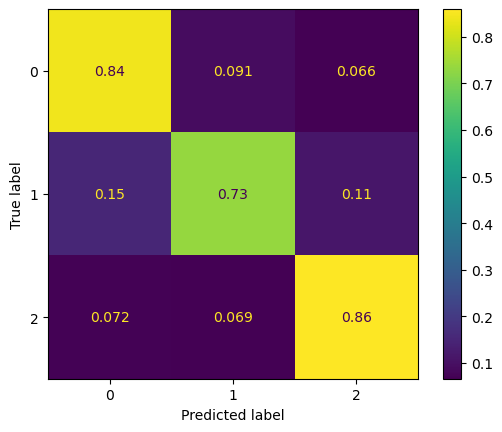

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.60707. Saving Model!
epoch 01, loss: 0.62674, acc: 0.72418, val_loss: 0.60707, val_accuracy: 0.79742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 02, loss: 0.62239, acc: 0.73391, val_loss: 0.61528, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 03, loss: 0.62117, acc: 0.74025, val_loss: 0.62488, val_accuracy: 0.75691


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 04, loss: 0.61927, acc: 0.74097, val_loss: 0.63668, val_accuracy: 0.76427


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 05, loss: 0.61828, acc: 0.74383, val_loss: 0.64485, val_accuracy: 0.74862


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 06, loss: 0.61440, acc: 0.74066, val_loss: 0.65057, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 07, loss: 0.61401, acc: 0.74189, val_loss: 0.65026, val_accuracy: 0.74862


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 08, loss: 0.61131, acc: 0.74414, val_loss: 0.65207, val_accuracy: 0.75506


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 09, loss: 0.61060, acc: 0.74394, val_loss: 0.65876, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 10, loss: 0.60792, acc: 0.74557, val_loss: 0.66908, val_accuracy: 0.69613


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 11, loss: 0.60647, acc: 0.74854, val_loss: 0.67745, val_accuracy: 0.70442


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 12, loss: 0.60576, acc: 0.75356, val_loss: 0.68035, val_accuracy: 0.70718


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 13, loss: 0.60326, acc: 0.75530, val_loss: 0.68447, val_accuracy: 0.70166


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 14, loss: 0.60306, acc: 0.75683, val_loss: 0.68927, val_accuracy: 0.69153


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 15, loss: 0.60067, acc: 0.75683, val_loss: 0.69576, val_accuracy: 0.68785


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 16, loss: 0.60074, acc: 0.75345, val_loss: 0.69787, val_accuracy: 0.69705


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 17, loss: 0.59852, acc: 0.75775, val_loss: 0.70092, val_accuracy: 0.70258


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 18, loss: 0.59797, acc: 0.75919, val_loss: 0.70644, val_accuracy: 0.70350


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 19, loss: 0.59668, acc: 0.76062, val_loss: 0.71275, val_accuracy: 0.69890


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 20, loss: 0.59561, acc: 0.76359, val_loss: 0.71565, val_accuracy: 0.69337


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 21, loss: 0.59451, acc: 0.75847, val_loss: 0.71582, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 22, loss: 0.59333, acc: 0.75888, val_loss: 0.71769, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 23, loss: 0.59262, acc: 0.76174, val_loss: 0.72142, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 24, loss: 0.59130, acc: 0.76512, val_loss: 0.72451, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 25, loss: 0.59042, acc: 0.76400, val_loss: 0.72452, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 26, loss: 0.58933, acc: 0.76205, val_loss: 0.72552, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 27, loss: 0.58843, acc: 0.76389, val_loss: 0.72820, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 28, loss: 0.58737, acc: 0.76338, val_loss: 0.73103, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 29, loss: 0.58638, acc: 0.76451, val_loss: 0.73190, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 30, loss: 0.58539, acc: 0.76379, val_loss: 0.73339, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 31, loss: 0.58460, acc: 0.76533, val_loss: 0.73634, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 32, loss: 0.58358, acc: 0.76502, val_loss: 0.73830, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 33, loss: 0.58277, acc: 0.76686, val_loss: 0.73777, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 34, loss: 0.58179, acc: 0.76533, val_loss: 0.73763, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 35, loss: 0.58106, acc: 0.76512, val_loss: 0.73920, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 36, loss: 0.58012, acc: 0.76389, val_loss: 0.74218, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 37, loss: 0.57934, acc: 0.76655, val_loss: 0.74444, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 38, loss: 0.57845, acc: 0.76543, val_loss: 0.74703, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 39, loss: 0.57772, acc: 0.76666, val_loss: 0.74974, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 40, loss: 0.57685, acc: 0.76696, val_loss: 0.75123, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 41, loss: 0.57614, acc: 0.76962, val_loss: 0.75098, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 42, loss: 0.57526, acc: 0.76707, val_loss: 0.75164, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 43, loss: 0.57451, acc: 0.76635, val_loss: 0.75361, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 44, loss: 0.57376, acc: 0.76676, val_loss: 0.75623, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 45, loss: 0.57297, acc: 0.76983, val_loss: 0.75766, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 46, loss: 0.57218, acc: 0.76860, val_loss: 0.75932, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 47, loss: 0.57145, acc: 0.76809, val_loss: 0.76030, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 48, loss: 0.57068, acc: 0.77147, val_loss: 0.76106, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 49, loss: 0.56992, acc: 0.77208, val_loss: 0.76138, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 50, loss: 0.56917, acc: 0.77147, val_loss: 0.76235, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 51, loss: 0.56842, acc: 0.77126, val_loss: 0.76452, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 52, loss: 0.56767, acc: 0.77157, val_loss: 0.76645, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 53, loss: 0.56695, acc: 0.77188, val_loss: 0.76700, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 54, loss: 0.56623, acc: 0.77269, val_loss: 0.76664, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 55, loss: 0.56549, acc: 0.77269, val_loss: 0.76697, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


epoch 56, loss: 0.56479, acc: 0.77413, val_loss: 0.76806, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 57, loss: 0.56408, acc: 0.77454, val_loss: 0.76978, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 58, loss: 0.56331, acc: 0.77648, val_loss: 0.77175, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 59, loss: 0.56265, acc: 0.77648, val_loss: 0.77295, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 60, loss: 0.56200, acc: 0.77617, val_loss: 0.77387, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 61, loss: 0.56132, acc: 0.77781, val_loss: 0.77465, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 62, loss: 0.56060, acc: 0.77761, val_loss: 0.77473, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 63, loss: 0.55996, acc: 0.77750, val_loss: 0.77519, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 64, loss: 0.55924, acc: 0.77812, val_loss: 0.77656, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 65, loss: 0.55858, acc: 0.77761, val_loss: 0.77899, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 66, loss: 0.55791, acc: 0.77853, val_loss: 0.78049, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 67, loss: 0.55727, acc: 0.77914, val_loss: 0.78143, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 68, loss: 0.55657, acc: 0.77904, val_loss: 0.78232, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 69, loss: 0.55590, acc: 0.77884, val_loss: 0.78254, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 70, loss: 0.55522, acc: 0.77904, val_loss: 0.78324, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 71, loss: 0.55458, acc: 0.77843, val_loss: 0.78517, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 72, loss: 0.55388, acc: 0.78006, val_loss: 0.78675, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 73, loss: 0.55326, acc: 0.78047, val_loss: 0.78753, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 74, loss: 0.55262, acc: 0.78006, val_loss: 0.78845, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 75, loss: 0.55196, acc: 0.77976, val_loss: 0.78982, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 76, loss: 0.55132, acc: 0.78088, val_loss: 0.79062, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 77, loss: 0.55069, acc: 0.78006, val_loss: 0.79079, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 78, loss: 0.55005, acc: 0.77986, val_loss: 0.79275, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 79, loss: 0.54934, acc: 0.78191, val_loss: 0.79441, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 80, loss: 0.54876, acc: 0.78221, val_loss: 0.79534, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 81, loss: 0.54813, acc: 0.78324, val_loss: 0.79700, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 82, loss: 0.54749, acc: 0.78201, val_loss: 0.79850, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 83, loss: 0.54685, acc: 0.78262, val_loss: 0.79961, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 84, loss: 0.54623, acc: 0.78303, val_loss: 0.79955, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 85, loss: 0.54566, acc: 0.78211, val_loss: 0.80026, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 86, loss: 0.54500, acc: 0.78283, val_loss: 0.80201, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 87, loss: 0.54436, acc: 0.78385, val_loss: 0.80336, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 88, loss: 0.54379, acc: 0.78416, val_loss: 0.80447, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 89, loss: 0.54319, acc: 0.78426, val_loss: 0.80499, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 90, loss: 0.54258, acc: 0.78457, val_loss: 0.80560, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 91, loss: 0.54196, acc: 0.78539, val_loss: 0.80662, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 92, loss: 0.54135, acc: 0.78600, val_loss: 0.80850, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 93, loss: 0.54074, acc: 0.78569, val_loss: 0.80982, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 94, loss: 0.54012, acc: 0.78610, val_loss: 0.81044, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 95, loss: 0.53952, acc: 0.78661, val_loss: 0.81106, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 96, loss: 0.53892, acc: 0.78610, val_loss: 0.81165, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 97, loss: 0.53828, acc: 0.78610, val_loss: 0.81267, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 98, loss: 0.53768, acc: 0.78682, val_loss: 0.81479, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 99, loss: 0.53708, acc: 0.78794, val_loss: 0.81594, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 100, loss: 0.53652, acc: 0.78835, val_loss: 0.81553, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 101, loss: 0.53591, acc: 0.78866, val_loss: 0.81613, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 102, loss: 0.53528, acc: 0.78825, val_loss: 0.81685, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 103, loss: 0.53465, acc: 0.78856, val_loss: 0.81863, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 104, loss: 0.53407, acc: 0.78887, val_loss: 0.82076, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 105, loss: 0.53344, acc: 0.78917, val_loss: 0.82175, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 106, loss: 0.53283, acc: 0.78927, val_loss: 0.82241, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 107, loss: 0.53220, acc: 0.78999, val_loss: 0.82293, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 108, loss: 0.53167, acc: 0.78968, val_loss: 0.82220, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 109, loss: 0.53105, acc: 0.78907, val_loss: 0.82414, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 110, loss: 0.53045, acc: 0.78979, val_loss: 0.82683, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 111, loss: 0.52989, acc: 0.78938, val_loss: 0.82697, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 112, loss: 0.52932, acc: 0.78999, val_loss: 0.82665, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 113, loss: 0.52875, acc: 0.78999, val_loss: 0.82764, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 114, loss: 0.52816, acc: 0.79071, val_loss: 0.82911, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 115, loss: 0.52758, acc: 0.79040, val_loss: 0.83119, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 116, loss: 0.52700, acc: 0.79081, val_loss: 0.83314, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 117, loss: 0.52639, acc: 0.79255, val_loss: 0.83365, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 118, loss: 0.52585, acc: 0.79173, val_loss: 0.83341, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 119, loss: 0.52528, acc: 0.79183, val_loss: 0.83449, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 120, loss: 0.52469, acc: 0.79142, val_loss: 0.83596, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 121, loss: 0.52414, acc: 0.79142, val_loss: 0.83684, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 122, loss: 0.52359, acc: 0.79204, val_loss: 0.83872, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 123, loss: 0.52300, acc: 0.79275, val_loss: 0.83934, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 124, loss: 0.52243, acc: 0.79265, val_loss: 0.84047, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 125, loss: 0.52191, acc: 0.79286, val_loss: 0.84150, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 126, loss: 0.52135, acc: 0.79275, val_loss: 0.84131, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 127, loss: 0.52076, acc: 0.79275, val_loss: 0.84257, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 128, loss: 0.52019, acc: 0.79275, val_loss: 0.84386, val_accuracy: 0.66759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 129, loss: 0.51965, acc: 0.79327, val_loss: 0.84455, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


epoch 130, loss: 0.51909, acc: 0.79357, val_loss: 0.84607, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 131, loss: 0.51852, acc: 0.79327, val_loss: 0.84747, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 132, loss: 0.51798, acc: 0.79255, val_loss: 0.84821, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 133, loss: 0.51744, acc: 0.79327, val_loss: 0.84969, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 134, loss: 0.51689, acc: 0.79501, val_loss: 0.85044, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 135, loss: 0.51634, acc: 0.79552, val_loss: 0.85107, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 136, loss: 0.51582, acc: 0.79603, val_loss: 0.85223, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 137, loss: 0.51527, acc: 0.79644, val_loss: 0.85329, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 138, loss: 0.51472, acc: 0.79654, val_loss: 0.85456, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 139, loss: 0.51415, acc: 0.79634, val_loss: 0.85536, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 140, loss: 0.51363, acc: 0.79664, val_loss: 0.85640, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 141, loss: 0.51308, acc: 0.79736, val_loss: 0.85728, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 142, loss: 0.51256, acc: 0.79736, val_loss: 0.85819, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 143, loss: 0.51202, acc: 0.79777, val_loss: 0.85934, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 144, loss: 0.51147, acc: 0.79787, val_loss: 0.86012, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 145, loss: 0.51094, acc: 0.79859, val_loss: 0.86165, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 146, loss: 0.51042, acc: 0.79859, val_loss: 0.86324, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 147, loss: 0.50988, acc: 0.79838, val_loss: 0.86367, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 148, loss: 0.50939, acc: 0.79859, val_loss: 0.86472, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 149, loss: 0.50883, acc: 0.79879, val_loss: 0.86654, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 150, loss: 0.50834, acc: 0.79910, val_loss: 0.86605, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 151, loss: 0.50781, acc: 0.79900, val_loss: 0.86703, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 152, loss: 0.50727, acc: 0.79889, val_loss: 0.86850, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 153, loss: 0.50678, acc: 0.80207, val_loss: 0.86906, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 154, loss: 0.50627, acc: 0.80012, val_loss: 0.87103, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 155, loss: 0.50574, acc: 0.80258, val_loss: 0.87168, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 156, loss: 0.50520, acc: 0.80023, val_loss: 0.87172, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 157, loss: 0.50471, acc: 0.80063, val_loss: 0.87514, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 158, loss: 0.50417, acc: 0.80289, val_loss: 0.87540, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 159, loss: 0.50365, acc: 0.80350, val_loss: 0.87630, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 160, loss: 0.50312, acc: 0.80176, val_loss: 0.87751, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 161, loss: 0.50264, acc: 0.80104, val_loss: 0.87737, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


epoch 162, loss: 0.50210, acc: 0.80166, val_loss: 0.87803, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 163, loss: 0.50162, acc: 0.80207, val_loss: 0.88103, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 164, loss: 0.50110, acc: 0.80473, val_loss: 0.88198, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 165, loss: 0.50064, acc: 0.80504, val_loss: 0.88296, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 166, loss: 0.50015, acc: 0.80483, val_loss: 0.88244, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 167, loss: 0.49962, acc: 0.80534, val_loss: 0.88252, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 168, loss: 0.49910, acc: 0.80524, val_loss: 0.88514, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 169, loss: 0.49870, acc: 0.80289, val_loss: 0.88540, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 170, loss: 0.49815, acc: 0.80544, val_loss: 0.88565, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 171, loss: 0.49766, acc: 0.80575, val_loss: 0.88628, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 172, loss: 0.49717, acc: 0.80575, val_loss: 0.88749, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 173, loss: 0.49667, acc: 0.80606, val_loss: 0.88845, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 174, loss: 0.49616, acc: 0.80626, val_loss: 0.89003, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 175, loss: 0.49569, acc: 0.80637, val_loss: 0.89063, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 176, loss: 0.49520, acc: 0.80667, val_loss: 0.89196, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 177, loss: 0.49468, acc: 0.80637, val_loss: 0.89213, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 178, loss: 0.49420, acc: 0.80759, val_loss: 0.89370, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 179, loss: 0.49372, acc: 0.80780, val_loss: 0.89395, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 180, loss: 0.49320, acc: 0.80698, val_loss: 0.89312, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 181, loss: 0.49281, acc: 0.80493, val_loss: 0.89683, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 182, loss: 0.49233, acc: 0.80718, val_loss: 0.89693, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 183, loss: 0.49176, acc: 0.80841, val_loss: 0.89880, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 184, loss: 0.49129, acc: 0.80862, val_loss: 0.90032, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 185, loss: 0.49082, acc: 0.80831, val_loss: 0.89981, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 186, loss: 0.49036, acc: 0.80944, val_loss: 0.90229, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 187, loss: 0.48988, acc: 0.80831, val_loss: 0.90135, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 188, loss: 0.48937, acc: 0.80964, val_loss: 0.90282, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 189, loss: 0.48891, acc: 0.80944, val_loss: 0.90463, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 190, loss: 0.48842, acc: 0.80944, val_loss: 0.90480, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 191, loss: 0.48798, acc: 0.80954, val_loss: 0.90561, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 192, loss: 0.48750, acc: 0.81025, val_loss: 0.90576, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 193, loss: 0.48703, acc: 0.81036, val_loss: 0.90708, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 194, loss: 0.48654, acc: 0.81025, val_loss: 0.90942, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 195, loss: 0.48599, acc: 0.81025, val_loss: 0.91014, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 196, loss: 0.48550, acc: 0.81281, val_loss: 0.90947, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 197, loss: 0.48505, acc: 0.81343, val_loss: 0.91041, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 198, loss: 0.48459, acc: 0.81107, val_loss: 0.91101, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 199, loss: 0.48409, acc: 0.81373, val_loss: 0.91232, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 200, loss: 0.48364, acc: 0.81435, val_loss: 0.91423, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 201, loss: 0.48322, acc: 0.81179, val_loss: 0.91388, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 202, loss: 0.48275, acc: 0.81373, val_loss: 0.91485, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 203, loss: 0.48227, acc: 0.81394, val_loss: 0.91553, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


epoch 204, loss: 0.48179, acc: 0.81373, val_loss: 0.91602, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 205, loss: 0.48141, acc: 0.81414, val_loss: 0.91917, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 206, loss: 0.48090, acc: 0.81486, val_loss: 0.91815, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 207, loss: 0.48048, acc: 0.81496, val_loss: 0.92071, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 208, loss: 0.48002, acc: 0.81445, val_loss: 0.91843, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 209, loss: 0.47954, acc: 0.81547, val_loss: 0.92077, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 210, loss: 0.47904, acc: 0.81609, val_loss: 0.92245, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 211, loss: 0.47860, acc: 0.81660, val_loss: 0.92302, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 212, loss: 0.47815, acc: 0.81650, val_loss: 0.92597, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 213, loss: 0.47772, acc: 0.81629, val_loss: 0.92452, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 214, loss: 0.47726, acc: 0.81609, val_loss: 0.92469, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 215, loss: 0.47675, acc: 0.81680, val_loss: 0.92622, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 216, loss: 0.47632, acc: 0.81732, val_loss: 0.92598, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 217, loss: 0.47589, acc: 0.81711, val_loss: 0.92931, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 218, loss: 0.47543, acc: 0.81752, val_loss: 0.92909, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 219, loss: 0.47494, acc: 0.81732, val_loss: 0.93065, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 220, loss: 0.47450, acc: 0.81752, val_loss: 0.93009, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 221, loss: 0.47410, acc: 0.81773, val_loss: 0.93123, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 222, loss: 0.47363, acc: 0.81834, val_loss: 0.93221, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 223, loss: 0.47320, acc: 0.81936, val_loss: 0.93365, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 224, loss: 0.47274, acc: 0.81814, val_loss: 0.93297, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 225, loss: 0.47234, acc: 0.81957, val_loss: 0.93356, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 226, loss: 0.47188, acc: 0.81988, val_loss: 0.93431, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 227, loss: 0.47145, acc: 0.81936, val_loss: 0.93488, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 228, loss: 0.47099, acc: 0.81967, val_loss: 0.93674, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 229, loss: 0.47055, acc: 0.81988, val_loss: 0.93726, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 230, loss: 0.47012, acc: 0.81977, val_loss: 0.93946, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 231, loss: 0.46969, acc: 0.82018, val_loss: 0.93813, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 232, loss: 0.46924, acc: 0.82059, val_loss: 0.93904, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 233, loss: 0.46880, acc: 0.82069, val_loss: 0.93917, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 234, loss: 0.46839, acc: 0.82080, val_loss: 0.94013, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 235, loss: 0.46793, acc: 0.82121, val_loss: 0.94057, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 236, loss: 0.46749, acc: 0.82131, val_loss: 0.94274, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 237, loss: 0.46707, acc: 0.82121, val_loss: 0.94262, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 238, loss: 0.46665, acc: 0.82243, val_loss: 0.94465, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 239, loss: 0.46626, acc: 0.82069, val_loss: 0.94251, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 240, loss: 0.46583, acc: 0.82192, val_loss: 0.94792, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 241, loss: 0.46547, acc: 0.81977, val_loss: 0.94387, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 242, loss: 0.46502, acc: 0.82233, val_loss: 0.94821, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 243, loss: 0.46453, acc: 0.82202, val_loss: 0.94673, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 244, loss: 0.46402, acc: 0.82315, val_loss: 0.94583, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 245, loss: 0.46368, acc: 0.82295, val_loss: 0.95066, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 246, loss: 0.46328, acc: 0.82141, val_loss: 0.94739, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 247, loss: 0.46289, acc: 0.82284, val_loss: 0.95212, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 248, loss: 0.46243, acc: 0.82131, val_loss: 0.94888, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 249, loss: 0.46195, acc: 0.82295, val_loss: 0.95172, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


epoch 250, loss: 0.46152, acc: 0.82141, val_loss: 0.95113, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


epoch 251, loss: 0.46108, acc: 0.82366, val_loss: 0.95340, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 252, loss: 0.46060, acc: 0.82397, val_loss: 0.95414, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 253, loss: 0.46021, acc: 0.82407, val_loss: 0.95478, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 254, loss: 0.45976, acc: 0.82448, val_loss: 0.95624, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 255, loss: 0.45936, acc: 0.82438, val_loss: 0.95635, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 256, loss: 0.45897, acc: 0.82428, val_loss: 0.95759, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 257, loss: 0.45856, acc: 0.82387, val_loss: 0.95632, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 258, loss: 0.45816, acc: 0.82509, val_loss: 0.96160, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 259, loss: 0.45778, acc: 0.82387, val_loss: 0.95667, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 260, loss: 0.45746, acc: 0.82540, val_loss: 0.96359, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 261, loss: 0.45724, acc: 0.82202, val_loss: 0.95598, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 262, loss: 0.45689, acc: 0.82458, val_loss: 0.96681, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 263, loss: 0.45649, acc: 0.82295, val_loss: 0.95927, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 264, loss: 0.45598, acc: 0.82653, val_loss: 0.96589, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 265, loss: 0.45541, acc: 0.82325, val_loss: 0.96101, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 266, loss: 0.45487, acc: 0.82622, val_loss: 0.96618, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 267, loss: 0.45440, acc: 0.82581, val_loss: 0.96601, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 268, loss: 0.45392, acc: 0.82643, val_loss: 0.96528, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 269, loss: 0.45352, acc: 0.82694, val_loss: 0.96888, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 270, loss: 0.45317, acc: 0.82376, val_loss: 0.96456, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 271, loss: 0.45286, acc: 0.82632, val_loss: 0.97470, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 272, loss: 0.45266, acc: 0.82407, val_loss: 0.96573, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 273, loss: 0.45246, acc: 0.82622, val_loss: 0.97735, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 274, loss: 0.45234, acc: 0.82376, val_loss: 0.96512, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 275, loss: 0.45194, acc: 0.82755, val_loss: 0.97785, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 276, loss: 0.45120, acc: 0.82356, val_loss: 0.97091, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 277, loss: 0.45048, acc: 0.82776, val_loss: 0.97597, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 278, loss: 0.44985, acc: 0.82673, val_loss: 0.97391, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 279, loss: 0.44939, acc: 0.82704, val_loss: 0.97303, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


epoch 280, loss: 0.44900, acc: 0.82724, val_loss: 0.97761, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 281, loss: 0.44876, acc: 0.82581, val_loss: 0.97243, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 282, loss: 0.44853, acc: 0.82806, val_loss: 0.98394, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 283, loss: 0.44841, acc: 0.82469, val_loss: 0.97191, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 284, loss: 0.44831, acc: 0.83011, val_loss: 0.98586, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 285, loss: 0.44845, acc: 0.82509, val_loss: 0.96971, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 286, loss: 0.44827, acc: 0.83072, val_loss: 0.98880, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 287, loss: 0.44796, acc: 0.82397, val_loss: 0.97334, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 288, loss: 0.44713, acc: 0.82939, val_loss: 0.98644, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 289, loss: 0.44618, acc: 0.82561, val_loss: 0.97738, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 290, loss: 0.44525, acc: 0.82909, val_loss: 0.98350, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 291, loss: 0.44462, acc: 0.82868, val_loss: 0.98353, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 292, loss: 0.44412, acc: 0.82950, val_loss: 0.98104, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 293, loss: 0.44383, acc: 0.82980, val_loss: 0.98687, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 294, loss: 0.44365, acc: 0.82776, val_loss: 0.97749, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 295, loss: 0.44371, acc: 0.83144, val_loss: 0.99428, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 296, loss: 0.44400, acc: 0.82663, val_loss: 0.97745, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 297, loss: 0.44445, acc: 0.83083, val_loss: 1.00387, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 298, loss: 0.44558, acc: 0.82254, val_loss: 0.97553, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 299, loss: 0.44652, acc: 0.82786, val_loss: 1.00909, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 300, loss: 0.44739, acc: 0.81895, val_loss: 0.97629, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 301, loss: 0.44728, acc: 0.82366, val_loss: 1.00740, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 302, loss: 0.44578, acc: 0.81926, val_loss: 0.98162, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 303, loss: 0.44347, acc: 0.82970, val_loss: 0.99995, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 304, loss: 0.44088, acc: 0.82755, val_loss: 0.98921, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 305, loss: 0.43918, acc: 0.83216, val_loss: 0.99117, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 306, loss: 0.43899, acc: 0.83308, val_loss: 0.99995, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 307, loss: 0.43965, acc: 0.82653, val_loss: 0.98526, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 308, loss: 0.44059, acc: 0.83124, val_loss: 1.00973, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 309, loss: 0.44180, acc: 0.82223, val_loss: 0.98279, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 310, loss: 0.44282, acc: 0.82909, val_loss: 1.02001, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 311, loss: 0.44410, acc: 0.82131, val_loss: 0.98108, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 312, loss: 0.44347, acc: 0.82561, val_loss: 1.01787, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 313, loss: 0.44188, acc: 0.82182, val_loss: 0.98890, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 314, loss: 0.43892, acc: 0.83083, val_loss: 1.00607, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 315, loss: 0.43642, acc: 0.82837, val_loss: 1.00578, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 316, loss: 0.43528, acc: 0.83328, val_loss: 0.99691, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 317, loss: 0.43543, acc: 0.83482, val_loss: 1.01450, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 318, loss: 0.43648, acc: 0.82704, val_loss: 0.99191, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 319, loss: 0.43757, acc: 0.83134, val_loss: 1.01945, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 320, loss: 0.43865, acc: 0.82223, val_loss: 0.99469, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 321, loss: 0.43982, acc: 0.82837, val_loss: 1.02667, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 322, loss: 0.44071, acc: 0.82069, val_loss: 0.99471, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 323, loss: 0.44078, acc: 0.82643, val_loss: 1.02754, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 324, loss: 0.43876, acc: 0.82110, val_loss: 0.99541, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 325, loss: 0.43602, acc: 0.83164, val_loss: 1.02066, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 326, loss: 0.43338, acc: 0.83042, val_loss: 1.00386, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 327, loss: 0.43151, acc: 0.83635, val_loss: 1.00841, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 328, loss: 0.43105, acc: 0.83686, val_loss: 1.01293, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 329, loss: 0.43137, acc: 0.83124, val_loss: 1.00009, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 330, loss: 0.43223, acc: 0.83461, val_loss: 1.02610, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 331, loss: 0.43337, acc: 0.82591, val_loss: 0.99683, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 332, loss: 0.43423, acc: 0.83072, val_loss: 1.03394, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 333, loss: 0.43508, acc: 0.82509, val_loss: 0.99739, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 334, loss: 0.43426, acc: 0.83031, val_loss: 1.03257, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 335, loss: 0.43349, acc: 0.82520, val_loss: 1.00458, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 336, loss: 0.43190, acc: 0.83390, val_loss: 1.02352, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 337, loss: 0.43012, acc: 0.82868, val_loss: 1.01601, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 338, loss: 0.42882, acc: 0.83656, val_loss: 1.01343, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 339, loss: 0.42777, acc: 0.83451, val_loss: 1.02093, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 340, loss: 0.42706, acc: 0.83676, val_loss: 1.00693, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 341, loss: 0.42668, acc: 0.83758, val_loss: 1.02475, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 342, loss: 0.42717, acc: 0.83298, val_loss: 1.01062, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 343, loss: 0.42849, acc: 0.83471, val_loss: 1.03223, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 344, loss: 0.42995, acc: 0.82540, val_loss: 1.01201, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 345, loss: 0.43207, acc: 0.83144, val_loss: 1.04317, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 346, loss: 0.43477, acc: 0.82458, val_loss: 1.01042, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 347, loss: 0.43859, acc: 0.82356, val_loss: 1.05745, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 348, loss: 0.44127, acc: 0.82233, val_loss: 1.00344, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 349, loss: 0.44257, acc: 0.81988, val_loss: 1.05810, val_accuracy: 0.60866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 350, loss: 0.43765, acc: 0.82284, val_loss: 1.00822, val_accuracy: 0.60313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 351, loss: 0.42949, acc: 0.83226, val_loss: 1.03209, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 352, loss: 0.42370, acc: 0.83615, val_loss: 1.02999, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 353, loss: 0.42347, acc: 0.83410, val_loss: 1.01714, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 354, loss: 0.42785, acc: 0.83441, val_loss: 1.05446, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 355, loss: 0.43233, acc: 0.82509, val_loss: 1.00560, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 356, loss: 0.43466, acc: 0.82509, val_loss: 1.04984, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 357, loss: 0.43161, acc: 0.82571, val_loss: 1.01366, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 358, loss: 0.42645, acc: 0.83615, val_loss: 1.03062, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 359, loss: 0.42162, acc: 0.83502, val_loss: 1.03207, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 360, loss: 0.42029, acc: 0.83789, val_loss: 1.01568, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 361, loss: 0.42213, acc: 0.83860, val_loss: 1.04969, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 362, loss: 0.42522, acc: 0.82796, val_loss: 1.01453, val_accuracy: 0.60866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 363, loss: 0.42678, acc: 0.83441, val_loss: 1.04762, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 364, loss: 0.42605, acc: 0.82683, val_loss: 1.02093, val_accuracy: 0.61326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 365, loss: 0.42468, acc: 0.83584, val_loss: 1.03651, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 366, loss: 0.42277, acc: 0.82919, val_loss: 1.03666, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 367, loss: 0.42090, acc: 0.83758, val_loss: 1.02682, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 368, loss: 0.41872, acc: 0.83553, val_loss: 1.04067, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 369, loss: 0.41764, acc: 0.83942, val_loss: 1.02433, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 370, loss: 0.41748, acc: 0.84229, val_loss: 1.04121, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 371, loss: 0.41826, acc: 0.83431, val_loss: 1.02815, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 372, loss: 0.41912, acc: 0.83799, val_loss: 1.03910, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 373, loss: 0.41943, acc: 0.83175, val_loss: 1.03291, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.75it/s]


epoch 374, loss: 0.41913, acc: 0.83799, val_loss: 1.04087, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 375, loss: 0.41793, acc: 0.83246, val_loss: 1.03320, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 376, loss: 0.41631, acc: 0.84249, val_loss: 1.04150, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 377, loss: 0.41486, acc: 0.83717, val_loss: 1.03217, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 378, loss: 0.41392, acc: 0.84300, val_loss: 1.04285, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 379, loss: 0.41360, acc: 0.84208, val_loss: 1.03004, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 380, loss: 0.41368, acc: 0.84055, val_loss: 1.04161, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 381, loss: 0.41400, acc: 0.84137, val_loss: 1.03538, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 382, loss: 0.41383, acc: 0.83830, val_loss: 1.04203, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 383, loss: 0.41359, acc: 0.84167, val_loss: 1.04335, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 384, loss: 0.41331, acc: 0.83717, val_loss: 1.03449, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 385, loss: 0.41361, acc: 0.84229, val_loss: 1.05343, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 386, loss: 0.41466, acc: 0.83308, val_loss: 1.02505, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 387, loss: 0.41669, acc: 0.83799, val_loss: 1.06996, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 388, loss: 0.42009, acc: 0.83072, val_loss: 1.02358, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 389, loss: 0.42277, acc: 0.83390, val_loss: 1.07944, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 390, loss: 0.42434, acc: 0.82806, val_loss: 1.02855, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 391, loss: 0.42403, acc: 0.83451, val_loss: 1.06487, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 392, loss: 0.42198, acc: 0.82765, val_loss: 1.04945, val_accuracy: 0.60313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 393, loss: 0.42216, acc: 0.83175, val_loss: 1.04538, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 394, loss: 0.42249, acc: 0.82325, val_loss: 1.06880, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 395, loss: 0.42195, acc: 0.83512, val_loss: 1.03141, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 396, loss: 0.41297, acc: 0.83226, val_loss: 1.05138, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 397, loss: 0.40838, acc: 0.84004, val_loss: 1.05324, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 398, loss: 0.41154, acc: 0.83912, val_loss: 1.04619, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 399, loss: 0.41732, acc: 0.82643, val_loss: 1.06047, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 400, loss: 0.42134, acc: 0.83410, val_loss: 1.05154, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 401, loss: 0.41785, acc: 0.82581, val_loss: 1.04056, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 402, loss: 0.41368, acc: 0.83912, val_loss: 1.08803, val_accuracy: 0.60405


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 403, loss: 0.41728, acc: 0.83175, val_loss: 1.02072, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 404, loss: 0.41822, acc: 0.83175, val_loss: 1.08108, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 405, loss: 0.42249, acc: 0.83287, val_loss: 1.02320, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 406, loss: 0.41186, acc: 0.83584, val_loss: 1.04306, val_accuracy: 0.66759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 407, loss: 0.40778, acc: 0.84116, val_loss: 1.09286, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 408, loss: 0.41701, acc: 0.83584, val_loss: 1.03331, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 409, loss: 0.41564, acc: 0.83482, val_loss: 1.05741, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 410, loss: 0.41268, acc: 0.83973, val_loss: 1.03688, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 411, loss: 0.41116, acc: 0.83768, val_loss: 1.04149, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 412, loss: 0.40862, acc: 0.84055, val_loss: 1.07903, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 413, loss: 0.41165, acc: 0.83727, val_loss: 1.04875, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 414, loss: 0.41324, acc: 0.83492, val_loss: 1.05025, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 415, loss: 0.40873, acc: 0.84086, val_loss: 1.05456, val_accuracy: 0.60497


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 416, loss: 0.41222, acc: 0.83011, val_loss: 1.04933, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 417, loss: 0.41085, acc: 0.83993, val_loss: 1.07918, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 418, loss: 0.40939, acc: 0.83686, val_loss: 1.03968, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 419, loss: 0.41214, acc: 0.84024, val_loss: 1.06980, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 420, loss: 0.41335, acc: 0.83175, val_loss: 1.02596, val_accuracy: 0.60589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 421, loss: 0.41212, acc: 0.83871, val_loss: 1.07592, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 422, loss: 0.41238, acc: 0.83318, val_loss: 1.06333, val_accuracy: 0.60221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 423, loss: 0.41219, acc: 0.83768, val_loss: 1.07116, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


epoch 424, loss: 0.41003, acc: 0.82929, val_loss: 1.06837, val_accuracy: 0.60866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 425, loss: 0.40973, acc: 0.84137, val_loss: 1.04879, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 426, loss: 0.40568, acc: 0.83697, val_loss: 1.05321, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 427, loss: 0.40180, acc: 0.84464, val_loss: 1.08439, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 428, loss: 0.40375, acc: 0.83983, val_loss: 1.04224, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 429, loss: 0.40186, acc: 0.84434, val_loss: 1.06229, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 430, loss: 0.40151, acc: 0.84270, val_loss: 1.04916, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 431, loss: 0.39936, acc: 0.84567, val_loss: 1.05937, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 432, loss: 0.39916, acc: 0.84730, val_loss: 1.08010, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 433, loss: 0.40129, acc: 0.84362, val_loss: 1.04231, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 434, loss: 0.40112, acc: 0.84290, val_loss: 1.06140, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 435, loss: 0.39914, acc: 0.84321, val_loss: 1.06240, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 436, loss: 0.39743, acc: 0.84741, val_loss: 1.05129, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 437, loss: 0.39879, acc: 0.84567, val_loss: 1.08352, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 438, loss: 0.40204, acc: 0.84075, val_loss: 1.03273, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 439, loss: 0.40116, acc: 0.84311, val_loss: 1.07757, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 440, loss: 0.39949, acc: 0.84106, val_loss: 1.05988, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 441, loss: 0.39871, acc: 0.84556, val_loss: 1.06674, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 442, loss: 0.40165, acc: 0.83697, val_loss: 1.08142, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 443, loss: 0.40614, acc: 0.83922, val_loss: 1.07263, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 444, loss: 0.40978, acc: 0.82458, val_loss: 1.06448, val_accuracy: 0.60129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 445, loss: 0.41416, acc: 0.83287, val_loss: 1.10222, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 446, loss: 0.41878, acc: 0.82724, val_loss: 1.04694, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 447, loss: 0.42582, acc: 0.82540, val_loss: 1.12733, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 448, loss: 0.42585, acc: 0.82428, val_loss: 1.04148, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 449, loss: 0.41565, acc: 0.83512, val_loss: 1.07575, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 450, loss: 0.40060, acc: 0.83451, val_loss: 1.07838, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 451, loss: 0.39548, acc: 0.84515, val_loss: 1.05319, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 452, loss: 0.40023, acc: 0.84434, val_loss: 1.09964, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 453, loss: 0.40503, acc: 0.83553, val_loss: 1.05661, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 454, loss: 0.40670, acc: 0.83932, val_loss: 1.06610, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 455, loss: 0.40587, acc: 0.82765, val_loss: 1.08371, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 456, loss: 0.40396, acc: 0.84178, val_loss: 1.05086, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 457, loss: 0.39627, acc: 0.84198, val_loss: 1.06710, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 458, loss: 0.39184, acc: 0.84720, val_loss: 1.07701, val_accuracy: 0.60681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 459, loss: 0.39768, acc: 0.84219, val_loss: 1.06171, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 460, loss: 0.40367, acc: 0.82919, val_loss: 1.07706, val_accuracy: 0.60773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 461, loss: 0.40575, acc: 0.84014, val_loss: 1.07299, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 462, loss: 0.40214, acc: 0.83338, val_loss: 1.04841, val_accuracy: 0.61142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 463, loss: 0.39848, acc: 0.84290, val_loss: 1.10637, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 464, loss: 0.40163, acc: 0.84219, val_loss: 1.03825, val_accuracy: 0.66759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 465, loss: 0.39617, acc: 0.84423, val_loss: 1.06410, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 466, loss: 0.39322, acc: 0.84669, val_loss: 1.07536, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 467, loss: 0.39496, acc: 0.84270, val_loss: 1.05442, val_accuracy: 0.61050


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 468, loss: 0.39628, acc: 0.84464, val_loss: 1.10441, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 469, loss: 0.40012, acc: 0.84055, val_loss: 1.04605, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 470, loss: 0.39634, acc: 0.84280, val_loss: 1.06728, val_accuracy: 0.66943


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 471, loss: 0.39420, acc: 0.83993, val_loss: 1.07426, val_accuracy: 0.60958


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 472, loss: 0.39451, acc: 0.84618, val_loss: 1.07085, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 473, loss: 0.39098, acc: 0.84393, val_loss: 1.06893, val_accuracy: 0.61971


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 474, loss: 0.39074, acc: 0.84608, val_loss: 1.07350, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 475, loss: 0.38835, acc: 0.84812, val_loss: 1.05876, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 476, loss: 0.38885, acc: 0.84597, val_loss: 1.06914, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 477, loss: 0.39077, acc: 0.84812, val_loss: 1.07656, val_accuracy: 0.61418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 478, loss: 0.39105, acc: 0.84208, val_loss: 1.06349, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 479, loss: 0.39414, acc: 0.84464, val_loss: 1.10115, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 480, loss: 0.39630, acc: 0.84147, val_loss: 1.04508, val_accuracy: 0.67127


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 481, loss: 0.39584, acc: 0.84567, val_loss: 1.08718, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 482, loss: 0.39595, acc: 0.83707, val_loss: 1.07466, val_accuracy: 0.60866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 483, loss: 0.39440, acc: 0.84648, val_loss: 1.08858, val_accuracy: 0.61234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 484, loss: 0.39244, acc: 0.83932, val_loss: 1.07238, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 485, loss: 0.39123, acc: 0.84393, val_loss: 1.06091, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 486, loss: 0.38820, acc: 0.84208, val_loss: 1.07457, val_accuracy: 0.62431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 487, loss: 0.38442, acc: 0.84863, val_loss: 1.07873, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 488, loss: 0.38482, acc: 0.85089, val_loss: 1.07412, val_accuracy: 0.67495


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 489, loss: 0.38684, acc: 0.84474, val_loss: 1.06602, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 490, loss: 0.38959, acc: 0.84515, val_loss: 1.07306, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 491, loss: 0.39251, acc: 0.83410, val_loss: 1.07411, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 492, loss: 0.39237, acc: 0.84505, val_loss: 1.10448, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 493, loss: 0.39097, acc: 0.84260, val_loss: 1.06032, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 494, loss: 0.38936, acc: 0.84628, val_loss: 1.08891, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 495, loss: 0.38754, acc: 0.84106, val_loss: 1.05350, val_accuracy: 0.67403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 496, loss: 0.38405, acc: 0.85078, val_loss: 1.08091, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 497, loss: 0.38143, acc: 0.84925, val_loss: 1.09644, val_accuracy: 0.62707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 498, loss: 0.38226, acc: 0.85160, val_loss: 1.06551, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 499, loss: 0.38408, acc: 0.85140, val_loss: 1.09148, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 500, loss: 0.38637, acc: 0.84311, val_loss: 1.05465, val_accuracy: 0.61878
4번째 교차검증
evaluation loss: 0.60707, evaluation accuracy: 0.79742
(5, 1086)
(1086, 5)
Learning rate set to 0.066007
0:	learn: 1.0299058	total: 7.48ms	remaining: 7.47s
1:	learn: 0.9712209	total: 16.7ms	remaining: 8.35s
2:	learn: 0.9204723	total: 23.1ms	remaining: 7.66s
3:	learn: 0.8761595	total: 30.7ms	remaining: 7.63s
4:	learn: 0.8371637	total: 37ms	remaining: 7.36s
5:	learn: 0.8026265	total: 45.3ms	remaining: 7.51s
6:	learn: 0.7718746	total: 52ms	remaining: 7.38s
7:	learn: 0.7438292	total: 58.9ms	remaining: 7.3s
8:	learn: 0.7181029	total: 67.9ms	remaining: 7.48s
9:	learn: 0.6955752	total: 74.3ms	remaining: 7.35s
10:	learn: 0.6752415	total: 81.3ms	remaining: 7.31s
11:	learn: 0.6570123	total: 88.3ms	remaining: 7.27s
12:	learn: 0.6401588	total: 95.9ms	remaining: 7.28s
13:	learn: 0.6248859	total: 102ms	remaining: 7.21s
14:	learn: 0.6109013	total: 109ms	remaining: 7.18s
15:	learn: 0.5981494	total: 118ms	remainin

163:	learn: 0.4148956	total: 1.24s	remaining: 6.33s
164:	learn: 0.4148061	total: 1.25s	remaining: 6.32s
165:	learn: 0.4147339	total: 1.26s	remaining: 6.31s
166:	learn: 0.4145734	total: 1.26s	remaining: 6.31s
167:	learn: 0.4144171	total: 1.27s	remaining: 6.32s
168:	learn: 0.4143217	total: 1.28s	remaining: 6.31s
169:	learn: 0.4142338	total: 1.29s	remaining: 6.3s
170:	learn: 0.4141602	total: 1.3s	remaining: 6.3s
171:	learn: 0.4140923	total: 1.31s	remaining: 6.29s
172:	learn: 0.4140128	total: 1.31s	remaining: 6.28s
173:	learn: 0.4138880	total: 1.32s	remaining: 6.27s
174:	learn: 0.4137626	total: 1.33s	remaining: 6.28s
175:	learn: 0.4136269	total: 1.34s	remaining: 6.27s
176:	learn: 0.4135200	total: 1.35s	remaining: 6.26s
177:	learn: 0.4134482	total: 1.35s	remaining: 6.25s
178:	learn: 0.4133843	total: 1.36s	remaining: 6.25s
179:	learn: 0.4132783	total: 1.37s	remaining: 6.24s
180:	learn: 0.4132071	total: 1.38s	remaining: 6.23s
181:	learn: 0.4131156	total: 1.38s	remaining: 6.22s
182:	learn: 0.4

335:	learn: 0.4067612	total: 2.69s	remaining: 5.33s
336:	learn: 0.4067436	total: 2.7s	remaining: 5.32s
337:	learn: 0.4067225	total: 2.71s	remaining: 5.31s
338:	learn: 0.4067004	total: 2.72s	remaining: 5.31s
339:	learn: 0.4066786	total: 2.73s	remaining: 5.3s
340:	learn: 0.4066579	total: 2.74s	remaining: 5.29s
341:	learn: 0.4066435	total: 2.75s	remaining: 5.29s
342:	learn: 0.4066264	total: 2.76s	remaining: 5.28s
343:	learn: 0.4066059	total: 2.77s	remaining: 5.28s
344:	learn: 0.4065853	total: 2.77s	remaining: 5.27s
345:	learn: 0.4065668	total: 2.78s	remaining: 5.26s
346:	learn: 0.4065503	total: 2.79s	remaining: 5.25s
347:	learn: 0.4065336	total: 2.8s	remaining: 5.24s
348:	learn: 0.4065128	total: 2.81s	remaining: 5.24s
349:	learn: 0.4064928	total: 2.82s	remaining: 5.23s
350:	learn: 0.4064693	total: 2.82s	remaining: 5.22s
351:	learn: 0.4064500	total: 2.83s	remaining: 5.21s
352:	learn: 0.4064287	total: 2.84s	remaining: 5.21s
353:	learn: 0.4064126	total: 2.85s	remaining: 5.2s
354:	learn: 0.40

507:	learn: 0.4045554	total: 4.35s	remaining: 4.21s
508:	learn: 0.4045458	total: 4.36s	remaining: 4.21s
509:	learn: 0.4045380	total: 4.38s	remaining: 4.21s
510:	learn: 0.4045304	total: 4.39s	remaining: 4.21s
511:	learn: 0.4045240	total: 4.42s	remaining: 4.22s
512:	learn: 0.4045165	total: 4.44s	remaining: 4.22s
513:	learn: 0.4045093	total: 4.47s	remaining: 4.23s
514:	learn: 0.4044994	total: 4.49s	remaining: 4.23s
515:	learn: 0.4044924	total: 4.5s	remaining: 4.22s
516:	learn: 0.4044850	total: 4.52s	remaining: 4.23s
517:	learn: 0.4044753	total: 4.54s	remaining: 4.22s
518:	learn: 0.4044681	total: 4.55s	remaining: 4.22s
519:	learn: 0.4044585	total: 4.59s	remaining: 4.23s
520:	learn: 0.4044497	total: 4.6s	remaining: 4.23s
521:	learn: 0.4044417	total: 4.62s	remaining: 4.23s
522:	learn: 0.4044347	total: 4.62s	remaining: 4.22s
523:	learn: 0.4044277	total: 4.64s	remaining: 4.21s
524:	learn: 0.4044206	total: 4.65s	remaining: 4.21s
525:	learn: 0.4044137	total: 4.67s	remaining: 4.21s
526:	learn: 0.

671:	learn: 0.4035171	total: 6.01s	remaining: 2.93s
672:	learn: 0.4035133	total: 6.02s	remaining: 2.92s
673:	learn: 0.4035079	total: 6.03s	remaining: 2.92s
674:	learn: 0.4035043	total: 6.04s	remaining: 2.91s
675:	learn: 0.4035007	total: 6.05s	remaining: 2.9s
676:	learn: 0.4034973	total: 6.06s	remaining: 2.89s
677:	learn: 0.4034931	total: 6.07s	remaining: 2.88s
678:	learn: 0.4034870	total: 6.08s	remaining: 2.87s
679:	learn: 0.4034807	total: 6.09s	remaining: 2.87s
680:	learn: 0.4034773	total: 6.1s	remaining: 2.86s
681:	learn: 0.4034705	total: 6.11s	remaining: 2.85s
682:	learn: 0.4034654	total: 6.12s	remaining: 2.84s
683:	learn: 0.4034604	total: 6.12s	remaining: 2.83s
684:	learn: 0.4034557	total: 6.13s	remaining: 2.82s
685:	learn: 0.4034512	total: 6.14s	remaining: 2.81s
686:	learn: 0.4034455	total: 6.15s	remaining: 2.8s
687:	learn: 0.4034388	total: 6.16s	remaining: 2.79s
688:	learn: 0.4034350	total: 6.17s	remaining: 2.79s
689:	learn: 0.4034307	total: 6.18s	remaining: 2.78s
690:	learn: 0.4

852:	learn: 0.4028666	total: 7.67s	remaining: 1.32s
853:	learn: 0.4028646	total: 7.67s	remaining: 1.31s
854:	learn: 0.4028625	total: 7.68s	remaining: 1.3s
855:	learn: 0.4028596	total: 7.69s	remaining: 1.29s
856:	learn: 0.4028576	total: 7.7s	remaining: 1.28s
857:	learn: 0.4028541	total: 7.71s	remaining: 1.27s
858:	learn: 0.4028511	total: 7.72s	remaining: 1.27s
859:	learn: 0.4028470	total: 7.73s	remaining: 1.26s
860:	learn: 0.4028441	total: 7.73s	remaining: 1.25s
861:	learn: 0.4028422	total: 7.74s	remaining: 1.24s
862:	learn: 0.4028392	total: 7.75s	remaining: 1.23s
863:	learn: 0.4028371	total: 7.76s	remaining: 1.22s
864:	learn: 0.4028341	total: 7.76s	remaining: 1.21s
865:	learn: 0.4028312	total: 7.77s	remaining: 1.2s
866:	learn: 0.4028284	total: 7.78s	remaining: 1.19s
867:	learn: 0.4028265	total: 7.79s	remaining: 1.18s
868:	learn: 0.4028233	total: 7.8s	remaining: 1.18s
869:	learn: 0.4028214	total: 7.8s	remaining: 1.17s
870:	learn: 0.4028192	total: 7.81s	remaining: 1.16s
871:	learn: 0.402

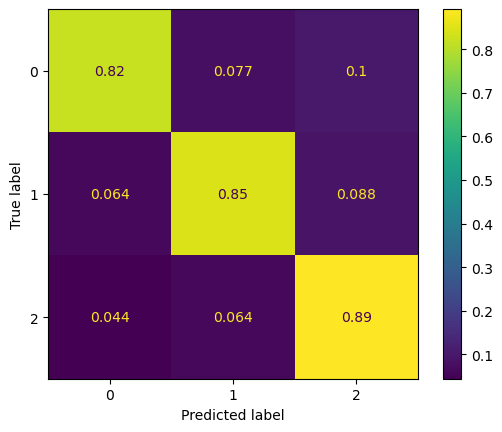

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.70602. Saving Model!
epoch 01, loss: 0.61307, acc: 0.74199, val_loss: 0.70602, val_accuracy: 0.69797


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 02, loss: 0.61835, acc: 0.74271, val_loss: 0.70685, val_accuracy: 0.71455


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.70602 to 0.70332. Saving Model!
epoch 03, loss: 0.61555, acc: 0.74527, val_loss: 0.70332, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 04, loss: 0.60947, acc: 0.74445, val_loss: 0.71662, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 05, loss: 0.61328, acc: 0.73360, val_loss: 0.72445, val_accuracy: 0.71179


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 06, loss: 0.60513, acc: 0.74240, val_loss: 0.73699, val_accuracy: 0.69982


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 07, loss: 0.60716, acc: 0.74445, val_loss: 0.73748, val_accuracy: 0.70810


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 08, loss: 0.60386, acc: 0.74957, val_loss: 0.73866, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 09, loss: 0.60147, acc: 0.75120, val_loss: 0.74670, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 10, loss: 0.60080, acc: 0.74885, val_loss: 0.75697, val_accuracy: 0.70074


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 11, loss: 0.59774, acc: 0.75049, val_loss: 0.76722, val_accuracy: 0.70350


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 12, loss: 0.59749, acc: 0.75499, val_loss: 0.77196, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 13, loss: 0.59497, acc: 0.75857, val_loss: 0.77759, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 14, loss: 0.59421, acc: 0.75550, val_loss: 0.78513, val_accuracy: 0.71363


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 15, loss: 0.59217, acc: 0.75253, val_loss: 0.79358, val_accuracy: 0.69982


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 16, loss: 0.59141, acc: 0.75417, val_loss: 0.80039, val_accuracy: 0.69429


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 17, loss: 0.58994, acc: 0.75867, val_loss: 0.80495, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 18, loss: 0.58839, acc: 0.76082, val_loss: 0.81070, val_accuracy: 0.72744


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 19, loss: 0.58808, acc: 0.75785, val_loss: 0.81503, val_accuracy: 0.71271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 20, loss: 0.58550, acc: 0.76256, val_loss: 0.82080, val_accuracy: 0.69429


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 21, loss: 0.58575, acc: 0.75919, val_loss: 0.82284, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 22, loss: 0.58341, acc: 0.76318, val_loss: 0.82569, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 23, loss: 0.58305, acc: 0.76287, val_loss: 0.82890, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 24, loss: 0.58186, acc: 0.76318, val_loss: 0.83199, val_accuracy: 0.70350


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 25, loss: 0.58042, acc: 0.76318, val_loss: 0.83724, val_accuracy: 0.69521


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 26, loss: 0.58022, acc: 0.76400, val_loss: 0.84067, val_accuracy: 0.71271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 27, loss: 0.57826, acc: 0.76604, val_loss: 0.84518, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 28, loss: 0.57813, acc: 0.76717, val_loss: 0.84712, val_accuracy: 0.71087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 29, loss: 0.57652, acc: 0.76461, val_loss: 0.84871, val_accuracy: 0.69797


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 30, loss: 0.57591, acc: 0.76420, val_loss: 0.84933, val_accuracy: 0.70350


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 31, loss: 0.57488, acc: 0.76492, val_loss: 0.85124, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 32, loss: 0.57387, acc: 0.76840, val_loss: 0.85276, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 33, loss: 0.57325, acc: 0.76952, val_loss: 0.85413, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 34, loss: 0.57201, acc: 0.77014, val_loss: 0.85654, val_accuracy: 0.69797


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 35, loss: 0.57143, acc: 0.76901, val_loss: 0.85897, val_accuracy: 0.71455


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 36, loss: 0.57037, acc: 0.77075, val_loss: 0.86176, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 37, loss: 0.56977, acc: 0.77044, val_loss: 0.86347, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 38, loss: 0.56882, acc: 0.77157, val_loss: 0.86505, val_accuracy: 0.70810


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 39, loss: 0.56809, acc: 0.77065, val_loss: 0.86701, val_accuracy: 0.70902


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 40, loss: 0.56721, acc: 0.77167, val_loss: 0.87008, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 41, loss: 0.56646, acc: 0.77269, val_loss: 0.87389, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 42, loss: 0.56572, acc: 0.77310, val_loss: 0.87652, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 43, loss: 0.56497, acc: 0.77310, val_loss: 0.87905, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 44, loss: 0.56415, acc: 0.77392, val_loss: 0.88167, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 45, loss: 0.56343, acc: 0.77362, val_loss: 0.88341, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 46, loss: 0.56263, acc: 0.77505, val_loss: 0.88535, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 47, loss: 0.56196, acc: 0.77372, val_loss: 0.88777, val_accuracy: 0.71363


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 48, loss: 0.56114, acc: 0.77484, val_loss: 0.89103, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 49, loss: 0.56045, acc: 0.77495, val_loss: 0.89368, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 50, loss: 0.55971, acc: 0.77556, val_loss: 0.89562, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 51, loss: 0.55901, acc: 0.77505, val_loss: 0.89692, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 52, loss: 0.55823, acc: 0.77536, val_loss: 0.89945, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 53, loss: 0.55758, acc: 0.77638, val_loss: 0.90212, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 54, loss: 0.55689, acc: 0.77689, val_loss: 0.90425, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 55, loss: 0.55622, acc: 0.77699, val_loss: 0.90690, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 56, loss: 0.55549, acc: 0.77730, val_loss: 0.90938, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 57, loss: 0.55484, acc: 0.78006, val_loss: 0.91122, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 58, loss: 0.55420, acc: 0.78027, val_loss: 0.91335, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 59, loss: 0.55349, acc: 0.77812, val_loss: 0.91545, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 60, loss: 0.55280, acc: 0.77791, val_loss: 0.91716, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 61, loss: 0.55219, acc: 0.78078, val_loss: 0.91837, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 62, loss: 0.55150, acc: 0.78088, val_loss: 0.91988, val_accuracy: 0.61510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 63, loss: 0.55086, acc: 0.77935, val_loss: 0.92266, val_accuracy: 0.61786


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 64, loss: 0.55018, acc: 0.78047, val_loss: 0.92562, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 65, loss: 0.54956, acc: 0.78037, val_loss: 0.92697, val_accuracy: 0.61694


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 66, loss: 0.54893, acc: 0.78150, val_loss: 0.92791, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 67, loss: 0.54827, acc: 0.78221, val_loss: 0.92969, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 68, loss: 0.54764, acc: 0.78272, val_loss: 0.93094, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 69, loss: 0.54703, acc: 0.78272, val_loss: 0.93238, val_accuracy: 0.61878


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 70, loss: 0.54638, acc: 0.78272, val_loss: 0.93423, val_accuracy: 0.62063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 71, loss: 0.54579, acc: 0.78283, val_loss: 0.93604, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 72, loss: 0.54517, acc: 0.78313, val_loss: 0.93725, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


epoch 73, loss: 0.54456, acc: 0.78303, val_loss: 0.93848, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 74, loss: 0.54396, acc: 0.78252, val_loss: 0.94045, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 75, loss: 0.54336, acc: 0.78293, val_loss: 0.94147, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 76, loss: 0.54278, acc: 0.78283, val_loss: 0.94247, val_accuracy: 0.62155


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 77, loss: 0.54218, acc: 0.78293, val_loss: 0.94414, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 78, loss: 0.54158, acc: 0.78334, val_loss: 0.94603, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 79, loss: 0.54096, acc: 0.78395, val_loss: 0.94857, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 80, loss: 0.54039, acc: 0.78457, val_loss: 0.95053, val_accuracy: 0.62339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 81, loss: 0.53980, acc: 0.78528, val_loss: 0.95182, val_accuracy: 0.62247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 82, loss: 0.53921, acc: 0.78610, val_loss: 0.95343, val_accuracy: 0.62891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 83, loss: 0.53862, acc: 0.78846, val_loss: 0.95430, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 84, loss: 0.53801, acc: 0.78866, val_loss: 0.95487, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 85, loss: 0.53744, acc: 0.78835, val_loss: 0.95609, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 86, loss: 0.53686, acc: 0.78846, val_loss: 0.95804, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 87, loss: 0.53631, acc: 0.78999, val_loss: 0.96040, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


epoch 88, loss: 0.53574, acc: 0.79009, val_loss: 0.96160, val_accuracy: 0.62523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 89, loss: 0.53514, acc: 0.78805, val_loss: 0.96257, val_accuracy: 0.62615


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 90, loss: 0.53457, acc: 0.78794, val_loss: 0.96334, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.76it/s]


epoch 91, loss: 0.53400, acc: 0.78979, val_loss: 0.96424, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 92, loss: 0.53343, acc: 0.78979, val_loss: 0.96553, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.49it/s]


epoch 93, loss: 0.53282, acc: 0.78948, val_loss: 0.96817, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 94, loss: 0.53224, acc: 0.79060, val_loss: 0.96877, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 95, loss: 0.53165, acc: 0.79091, val_loss: 0.96905, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 96, loss: 0.53109, acc: 0.79091, val_loss: 0.97062, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 97, loss: 0.53057, acc: 0.79173, val_loss: 0.97141, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 98, loss: 0.52992, acc: 0.79112, val_loss: 0.97189, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 99, loss: 0.52940, acc: 0.78989, val_loss: 0.97198, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 100, loss: 0.52884, acc: 0.79153, val_loss: 0.97357, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 101, loss: 0.52831, acc: 0.79214, val_loss: 0.97448, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 102, loss: 0.52779, acc: 0.79173, val_loss: 0.97658, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 103, loss: 0.52723, acc: 0.79091, val_loss: 0.97847, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 104, loss: 0.52667, acc: 0.79142, val_loss: 0.97914, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 105, loss: 0.52615, acc: 0.79194, val_loss: 0.97998, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 106, loss: 0.52560, acc: 0.79153, val_loss: 0.98192, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 107, loss: 0.52503, acc: 0.79132, val_loss: 0.98365, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


epoch 108, loss: 0.52451, acc: 0.79296, val_loss: 0.98388, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 109, loss: 0.52395, acc: 0.79265, val_loss: 0.98474, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 110, loss: 0.52343, acc: 0.79327, val_loss: 0.98601, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 111, loss: 0.52288, acc: 0.79296, val_loss: 0.98743, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 112, loss: 0.52232, acc: 0.79265, val_loss: 0.98921, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 113, loss: 0.52179, acc: 0.79316, val_loss: 0.98898, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 114, loss: 0.52127, acc: 0.79398, val_loss: 0.98927, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 115, loss: 0.52071, acc: 0.79398, val_loss: 0.99006, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 116, loss: 0.52015, acc: 0.79378, val_loss: 0.99113, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 117, loss: 0.51963, acc: 0.79398, val_loss: 0.99209, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 118, loss: 0.51911, acc: 0.79347, val_loss: 0.99300, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 119, loss: 0.51857, acc: 0.79398, val_loss: 0.99409, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 120, loss: 0.51804, acc: 0.79542, val_loss: 0.99515, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 121, loss: 0.51750, acc: 0.79562, val_loss: 0.99647, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 122, loss: 0.51699, acc: 0.79449, val_loss: 0.99765, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 123, loss: 0.51644, acc: 0.79470, val_loss: 0.99837, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 124, loss: 0.51591, acc: 0.79470, val_loss: 0.99852, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 125, loss: 0.51540, acc: 0.79531, val_loss: 0.99916, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 126, loss: 0.51487, acc: 0.79552, val_loss: 1.00048, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 127, loss: 0.51429, acc: 0.79715, val_loss: 1.00154, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 128, loss: 0.51381, acc: 0.79756, val_loss: 1.00279, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 129, loss: 0.51330, acc: 0.79705, val_loss: 1.00470, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 130, loss: 0.51273, acc: 0.79593, val_loss: 1.00593, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 131, loss: 0.51223, acc: 0.79593, val_loss: 1.00764, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 132, loss: 0.51174, acc: 0.79654, val_loss: 1.00852, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 133, loss: 0.51119, acc: 0.79675, val_loss: 1.00816, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 134, loss: 0.51067, acc: 0.79818, val_loss: 1.00949, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 135, loss: 0.51015, acc: 0.79777, val_loss: 1.01123, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 136, loss: 0.50961, acc: 0.79777, val_loss: 1.01192, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 137, loss: 0.50909, acc: 0.79767, val_loss: 1.01369, val_accuracy: 0.63444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 138, loss: 0.50857, acc: 0.79767, val_loss: 1.01388, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 139, loss: 0.50810, acc: 0.79767, val_loss: 1.01366, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 140, loss: 0.50760, acc: 0.79889, val_loss: 1.01597, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 141, loss: 0.50707, acc: 0.79797, val_loss: 1.01742, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 142, loss: 0.50653, acc: 0.79777, val_loss: 1.01836, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 143, loss: 0.50604, acc: 0.79900, val_loss: 1.02007, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 144, loss: 0.50556, acc: 0.79889, val_loss: 1.01964, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 145, loss: 0.50502, acc: 0.79941, val_loss: 1.02077, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 146, loss: 0.50452, acc: 0.79992, val_loss: 1.02279, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 147, loss: 0.50401, acc: 0.79992, val_loss: 1.02342, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 148, loss: 0.50348, acc: 0.79982, val_loss: 1.02450, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 149, loss: 0.50296, acc: 0.80043, val_loss: 1.02606, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 150, loss: 0.50246, acc: 0.79992, val_loss: 1.02619, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 151, loss: 0.50193, acc: 0.80012, val_loss: 1.02788, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 152, loss: 0.50142, acc: 0.80033, val_loss: 1.02989, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 153, loss: 0.50091, acc: 0.80043, val_loss: 1.03014, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 154, loss: 0.50039, acc: 0.80258, val_loss: 1.03027, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 155, loss: 0.49989, acc: 0.80268, val_loss: 1.03235, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 156, loss: 0.49941, acc: 0.80104, val_loss: 1.03284, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 157, loss: 0.49887, acc: 0.80401, val_loss: 1.03506, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 158, loss: 0.49838, acc: 0.80432, val_loss: 1.03762, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 159, loss: 0.49788, acc: 0.80401, val_loss: 1.03854, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 160, loss: 0.49739, acc: 0.80463, val_loss: 1.04028, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 161, loss: 0.49688, acc: 0.80411, val_loss: 1.04178, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 162, loss: 0.49635, acc: 0.80544, val_loss: 1.04320, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 163, loss: 0.49582, acc: 0.80442, val_loss: 1.04467, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 164, loss: 0.49534, acc: 0.80575, val_loss: 1.04633, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 165, loss: 0.49483, acc: 0.80596, val_loss: 1.04722, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 166, loss: 0.49430, acc: 0.80616, val_loss: 1.04860, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 167, loss: 0.49377, acc: 0.80718, val_loss: 1.04921, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 168, loss: 0.49327, acc: 0.80718, val_loss: 1.05105, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 169, loss: 0.49275, acc: 0.80780, val_loss: 1.05060, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 170, loss: 0.49232, acc: 0.80872, val_loss: 1.05138, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 171, loss: 0.49179, acc: 0.80718, val_loss: 1.05387, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 172, loss: 0.49126, acc: 0.80698, val_loss: 1.05460, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 173, loss: 0.49078, acc: 0.80718, val_loss: 1.05601, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 174, loss: 0.49035, acc: 0.80739, val_loss: 1.05819, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 175, loss: 0.48969, acc: 0.80688, val_loss: 1.05861, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


epoch 176, loss: 0.48929, acc: 0.81056, val_loss: 1.06039, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 177, loss: 0.48876, acc: 0.81097, val_loss: 1.06313, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


epoch 178, loss: 0.48821, acc: 0.81025, val_loss: 1.06320, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 179, loss: 0.48768, acc: 0.81159, val_loss: 1.06433, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 180, loss: 0.48713, acc: 0.81036, val_loss: 1.06845, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 181, loss: 0.48661, acc: 0.80995, val_loss: 1.06996, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 182, loss: 0.48609, acc: 0.80985, val_loss: 1.07435, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 183, loss: 0.48558, acc: 0.80851, val_loss: 1.07706, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 184, loss: 0.48517, acc: 0.81271, val_loss: 1.07750, val_accuracy: 0.63536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 185, loss: 0.48463, acc: 0.81015, val_loss: 1.08041, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 186, loss: 0.48403, acc: 0.81312, val_loss: 1.08107, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 187, loss: 0.48353, acc: 0.81343, val_loss: 1.08297, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 188, loss: 0.48311, acc: 0.81281, val_loss: 1.08784, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 189, loss: 0.48264, acc: 0.81220, val_loss: 1.08893, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 190, loss: 0.48197, acc: 0.81322, val_loss: 1.09211, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 191, loss: 0.48147, acc: 0.81414, val_loss: 1.09534, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 192, loss: 0.48101, acc: 0.81373, val_loss: 1.09648, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 193, loss: 0.48055, acc: 0.81138, val_loss: 1.09823, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 194, loss: 0.47993, acc: 0.81455, val_loss: 1.10028, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 195, loss: 0.47939, acc: 0.81445, val_loss: 1.10346, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 196, loss: 0.47893, acc: 0.81292, val_loss: 1.10806, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 197, loss: 0.47847, acc: 0.81384, val_loss: 1.10842, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 198, loss: 0.47793, acc: 0.81599, val_loss: 1.11112, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 199, loss: 0.47738, acc: 0.81599, val_loss: 1.11149, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 200, loss: 0.47694, acc: 0.81588, val_loss: 1.10946, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 201, loss: 0.47649, acc: 0.81466, val_loss: 1.11185, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 202, loss: 0.47605, acc: 0.81486, val_loss: 1.11150, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 203, loss: 0.47538, acc: 0.81670, val_loss: 1.11464, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 204, loss: 0.47483, acc: 0.81701, val_loss: 1.11669, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 205, loss: 0.47444, acc: 0.81640, val_loss: 1.11612, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 206, loss: 0.47395, acc: 0.81640, val_loss: 1.11907, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 207, loss: 0.47341, acc: 0.81619, val_loss: 1.11786, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 208, loss: 0.47286, acc: 0.81650, val_loss: 1.11915, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 209, loss: 0.47245, acc: 0.81732, val_loss: 1.12216, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 210, loss: 0.47200, acc: 0.81732, val_loss: 1.12190, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 211, loss: 0.47146, acc: 0.81701, val_loss: 1.12401, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 212, loss: 0.47094, acc: 0.81742, val_loss: 1.12565, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 213, loss: 0.47055, acc: 0.81711, val_loss: 1.12478, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 214, loss: 0.47015, acc: 0.81834, val_loss: 1.12753, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 215, loss: 0.46957, acc: 0.81783, val_loss: 1.12825, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 216, loss: 0.46902, acc: 0.81793, val_loss: 1.12920, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 217, loss: 0.46860, acc: 0.81936, val_loss: 1.13211, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 218, loss: 0.46827, acc: 0.81762, val_loss: 1.13134, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 219, loss: 0.46800, acc: 0.81814, val_loss: 1.13345, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 220, loss: 0.46735, acc: 0.81957, val_loss: 1.13382, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 221, loss: 0.46670, acc: 0.81895, val_loss: 1.13464, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 222, loss: 0.46639, acc: 0.81895, val_loss: 1.13860, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 223, loss: 0.46606, acc: 0.81957, val_loss: 1.13705, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 224, loss: 0.46539, acc: 0.82069, val_loss: 1.14081, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 225, loss: 0.46481, acc: 0.81936, val_loss: 1.14383, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 226, loss: 0.46438, acc: 0.82018, val_loss: 1.14221, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 227, loss: 0.46407, acc: 0.81936, val_loss: 1.14395, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 228, loss: 0.46352, acc: 0.82039, val_loss: 1.14100, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 229, loss: 0.46298, acc: 0.82110, val_loss: 1.14511, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 230, loss: 0.46247, acc: 0.82172, val_loss: 1.14895, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 231, loss: 0.46203, acc: 0.82141, val_loss: 1.14687, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 232, loss: 0.46158, acc: 0.82141, val_loss: 1.15078, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 233, loss: 0.46108, acc: 0.82213, val_loss: 1.14929, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 234, loss: 0.46065, acc: 0.82305, val_loss: 1.15047, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 235, loss: 0.46009, acc: 0.82254, val_loss: 1.15300, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 236, loss: 0.45971, acc: 0.82202, val_loss: 1.15306, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 237, loss: 0.45927, acc: 0.82376, val_loss: 1.15592, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 238, loss: 0.45884, acc: 0.82264, val_loss: 1.15405, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 239, loss: 0.45833, acc: 0.82346, val_loss: 1.15457, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 240, loss: 0.45787, acc: 0.82356, val_loss: 1.15628, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 241, loss: 0.45741, acc: 0.82428, val_loss: 1.15655, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 242, loss: 0.45694, acc: 0.82376, val_loss: 1.15894, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 243, loss: 0.45645, acc: 0.82397, val_loss: 1.15884, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 244, loss: 0.45607, acc: 0.82550, val_loss: 1.16197, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 245, loss: 0.45566, acc: 0.82417, val_loss: 1.15996, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 246, loss: 0.45522, acc: 0.82714, val_loss: 1.16318, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 247, loss: 0.45478, acc: 0.82428, val_loss: 1.16200, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 248, loss: 0.45428, acc: 0.82857, val_loss: 1.16516, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 249, loss: 0.45381, acc: 0.82735, val_loss: 1.16456, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 250, loss: 0.45334, acc: 0.82765, val_loss: 1.16554, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 251, loss: 0.45293, acc: 0.82806, val_loss: 1.16914, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 252, loss: 0.45255, acc: 0.82540, val_loss: 1.16695, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 253, loss: 0.45226, acc: 0.82806, val_loss: 1.17216, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 254, loss: 0.45204, acc: 0.82335, val_loss: 1.16666, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 255, loss: 0.45186, acc: 0.82509, val_loss: 1.17229, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 256, loss: 0.45144, acc: 0.82346, val_loss: 1.16958, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 257, loss: 0.45068, acc: 0.82643, val_loss: 1.17335, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 258, loss: 0.44986, acc: 0.82796, val_loss: 1.17277, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 259, loss: 0.44941, acc: 0.82837, val_loss: 1.17134, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 260, loss: 0.44928, acc: 0.82909, val_loss: 1.17600, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 261, loss: 0.44918, acc: 0.82489, val_loss: 1.16997, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 262, loss: 0.44878, acc: 0.82694, val_loss: 1.18153, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 263, loss: 0.44807, acc: 0.82827, val_loss: 1.17351, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 264, loss: 0.44740, acc: 0.82796, val_loss: 1.17979, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 265, loss: 0.44680, acc: 0.82888, val_loss: 1.18015, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 266, loss: 0.44643, acc: 0.82990, val_loss: 1.17651, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 267, loss: 0.44610, acc: 0.82970, val_loss: 1.18558, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 268, loss: 0.44581, acc: 0.82970, val_loss: 1.17779, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 269, loss: 0.44526, acc: 0.82929, val_loss: 1.18399, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 270, loss: 0.44472, acc: 0.82990, val_loss: 1.18225, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 271, loss: 0.44422, acc: 0.83052, val_loss: 1.18187, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 272, loss: 0.44381, acc: 0.82960, val_loss: 1.18572, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 273, loss: 0.44335, acc: 0.82970, val_loss: 1.18562, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 274, loss: 0.44288, acc: 0.82980, val_loss: 1.18884, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 275, loss: 0.44246, acc: 0.83031, val_loss: 1.18855, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 276, loss: 0.44220, acc: 0.83072, val_loss: 1.18771, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 277, loss: 0.44189, acc: 0.83021, val_loss: 1.18991, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 278, loss: 0.44154, acc: 0.83124, val_loss: 1.19314, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 279, loss: 0.44114, acc: 0.82909, val_loss: 1.18915, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 280, loss: 0.44074, acc: 0.83124, val_loss: 1.19911, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 281, loss: 0.44040, acc: 0.83031, val_loss: 1.18990, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 282, loss: 0.44006, acc: 0.83113, val_loss: 1.19960, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 283, loss: 0.43947, acc: 0.83083, val_loss: 1.19377, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 284, loss: 0.43880, acc: 0.83164, val_loss: 1.19856, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 285, loss: 0.43825, acc: 0.83124, val_loss: 1.19911, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 286, loss: 0.43781, acc: 0.83124, val_loss: 1.19622, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 287, loss: 0.43751, acc: 0.83072, val_loss: 1.20514, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 288, loss: 0.43725, acc: 0.83134, val_loss: 1.19853, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 289, loss: 0.43686, acc: 0.83154, val_loss: 1.20757, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 290, loss: 0.43642, acc: 0.83205, val_loss: 1.20005, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 291, loss: 0.43607, acc: 0.83390, val_loss: 1.20809, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 292, loss: 0.43587, acc: 0.83216, val_loss: 1.20751, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 293, loss: 0.43577, acc: 0.83164, val_loss: 1.21096, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 294, loss: 0.43554, acc: 0.83011, val_loss: 1.20896, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 295, loss: 0.43498, acc: 0.83144, val_loss: 1.21195, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 296, loss: 0.43423, acc: 0.83246, val_loss: 1.20635, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 297, loss: 0.43354, acc: 0.83338, val_loss: 1.21612, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 298, loss: 0.43313, acc: 0.83349, val_loss: 1.20948, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 299, loss: 0.43274, acc: 0.83175, val_loss: 1.21753, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 300, loss: 0.43227, acc: 0.83379, val_loss: 1.21344, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 301, loss: 0.43174, acc: 0.83318, val_loss: 1.21766, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 302, loss: 0.43128, acc: 0.83410, val_loss: 1.22418, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 303, loss: 0.43092, acc: 0.83379, val_loss: 1.21737, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 304, loss: 0.43067, acc: 0.83410, val_loss: 1.22900, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 305, loss: 0.43047, acc: 0.83441, val_loss: 1.21659, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 306, loss: 0.43017, acc: 0.83390, val_loss: 1.22789, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 307, loss: 0.42973, acc: 0.83533, val_loss: 1.21803, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 308, loss: 0.42943, acc: 0.83635, val_loss: 1.22905, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 309, loss: 0.42933, acc: 0.83236, val_loss: 1.22527, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 310, loss: 0.42956, acc: 0.83349, val_loss: 1.23457, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 311, loss: 0.42975, acc: 0.83124, val_loss: 1.22701, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 312, loss: 0.42955, acc: 0.83349, val_loss: 1.23796, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 313, loss: 0.42895, acc: 0.83185, val_loss: 1.22283, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 314, loss: 0.42813, acc: 0.83543, val_loss: 1.24082, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 315, loss: 0.42739, acc: 0.83564, val_loss: 1.22620, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 316, loss: 0.42681, acc: 0.83553, val_loss: 1.24387, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 317, loss: 0.42602, acc: 0.83645, val_loss: 1.23099, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 318, loss: 0.42514, acc: 0.83615, val_loss: 1.23691, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 319, loss: 0.42441, acc: 0.83779, val_loss: 1.23781, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 320, loss: 0.42407, acc: 0.83738, val_loss: 1.23155, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 321, loss: 0.42396, acc: 0.83717, val_loss: 1.24568, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 322, loss: 0.42402, acc: 0.83717, val_loss: 1.23190, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 323, loss: 0.42399, acc: 0.83686, val_loss: 1.25202, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 324, loss: 0.42390, acc: 0.83594, val_loss: 1.23372, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 325, loss: 0.42397, acc: 0.83799, val_loss: 1.25330, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 326, loss: 0.42426, acc: 0.83420, val_loss: 1.23737, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 327, loss: 0.42484, acc: 0.83502, val_loss: 1.25730, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 328, loss: 0.42524, acc: 0.83164, val_loss: 1.24150, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 329, loss: 0.42530, acc: 0.83461, val_loss: 1.26074, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 330, loss: 0.42433, acc: 0.83205, val_loss: 1.24557, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 331, loss: 0.42286, acc: 0.83512, val_loss: 1.26164, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 332, loss: 0.42119, acc: 0.83553, val_loss: 1.24416, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 333, loss: 0.41992, acc: 0.83912, val_loss: 1.25527, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 334, loss: 0.41924, acc: 0.83819, val_loss: 1.24841, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 335, loss: 0.41884, acc: 0.83830, val_loss: 1.25516, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 336, loss: 0.41858, acc: 0.83871, val_loss: 1.25976, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 337, loss: 0.41848, acc: 0.83686, val_loss: 1.25058, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 338, loss: 0.41878, acc: 0.83768, val_loss: 1.26948, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 339, loss: 0.41980, acc: 0.83420, val_loss: 1.24219, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 340, loss: 0.42182, acc: 0.83625, val_loss: 1.28399, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 341, loss: 0.42375, acc: 0.83021, val_loss: 1.24537, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 342, loss: 0.42629, acc: 0.83482, val_loss: 1.29490, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 343, loss: 0.42713, acc: 0.82550, val_loss: 1.25285, val_accuracy: 0.63352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 344, loss: 0.42776, acc: 0.83103, val_loss: 1.28956, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 345, loss: 0.42429, acc: 0.82950, val_loss: 1.26388, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 346, loss: 0.42001, acc: 0.83492, val_loss: 1.26864, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 347, loss: 0.41615, acc: 0.83502, val_loss: 1.27277, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 348, loss: 0.41423, acc: 0.83963, val_loss: 1.26185, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 349, loss: 0.41490, acc: 0.84014, val_loss: 1.28531, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 350, loss: 0.41709, acc: 0.83584, val_loss: 1.26156, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 351, loss: 0.41957, acc: 0.83359, val_loss: 1.29046, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 352, loss: 0.42062, acc: 0.83308, val_loss: 1.25956, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 353, loss: 0.42009, acc: 0.83257, val_loss: 1.28898, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 354, loss: 0.41748, acc: 0.83461, val_loss: 1.26082, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 355, loss: 0.41472, acc: 0.83789, val_loss: 1.28697, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 356, loss: 0.41273, acc: 0.83717, val_loss: 1.26921, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 357, loss: 0.41155, acc: 0.83922, val_loss: 1.28025, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 358, loss: 0.41130, acc: 0.84137, val_loss: 1.28004, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 359, loss: 0.41131, acc: 0.84045, val_loss: 1.27179, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 360, loss: 0.41163, acc: 0.84055, val_loss: 1.29666, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 361, loss: 0.41251, acc: 0.83656, val_loss: 1.26640, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 362, loss: 0.41371, acc: 0.83871, val_loss: 1.30557, val_accuracy: 0.66943


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 363, loss: 0.41456, acc: 0.83471, val_loss: 1.26292, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 364, loss: 0.41439, acc: 0.83799, val_loss: 1.30488, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 365, loss: 0.41320, acc: 0.83564, val_loss: 1.26927, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 366, loss: 0.41087, acc: 0.84065, val_loss: 1.29608, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 367, loss: 0.40865, acc: 0.84065, val_loss: 1.28289, val_accuracy: 0.65470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 368, loss: 0.40738, acc: 0.84444, val_loss: 1.28131, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 369, loss: 0.40716, acc: 0.84167, val_loss: 1.29486, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 370, loss: 0.40749, acc: 0.84004, val_loss: 1.27494, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 371, loss: 0.40731, acc: 0.84126, val_loss: 1.29926, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 372, loss: 0.40722, acc: 0.83953, val_loss: 1.27497, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 373, loss: 0.40658, acc: 0.84157, val_loss: 1.29817, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 374, loss: 0.40622, acc: 0.84045, val_loss: 1.28057, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 375, loss: 0.40664, acc: 0.84219, val_loss: 1.30122, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 376, loss: 0.40783, acc: 0.83932, val_loss: 1.28898, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 377, loss: 0.40973, acc: 0.83830, val_loss: 1.30665, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


epoch 378, loss: 0.41188, acc: 0.83676, val_loss: 1.28950, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


epoch 379, loss: 0.41339, acc: 0.83523, val_loss: 1.31694, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 380, loss: 0.41439, acc: 0.83420, val_loss: 1.28084, val_accuracy: 0.64273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 381, loss: 0.41429, acc: 0.83502, val_loss: 1.32807, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 382, loss: 0.41339, acc: 0.83512, val_loss: 1.27651, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 383, loss: 0.41303, acc: 0.83625, val_loss: 1.33608, val_accuracy: 0.67219


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 384, loss: 0.41178, acc: 0.83574, val_loss: 1.27809, val_accuracy: 0.63812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 385, loss: 0.40772, acc: 0.83983, val_loss: 1.31504, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 386, loss: 0.40417, acc: 0.83942, val_loss: 1.29738, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 387, loss: 0.40121, acc: 0.84526, val_loss: 1.29242, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 388, loss: 0.40205, acc: 0.84454, val_loss: 1.32904, val_accuracy: 0.66759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 389, loss: 0.40514, acc: 0.83799, val_loss: 1.28180, val_accuracy: 0.64088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 390, loss: 0.40738, acc: 0.83963, val_loss: 1.33256, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 391, loss: 0.40777, acc: 0.83697, val_loss: 1.27911, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 392, loss: 0.40562, acc: 0.84106, val_loss: 1.31578, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


epoch 393, loss: 0.40280, acc: 0.83942, val_loss: 1.29732, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 394, loss: 0.40136, acc: 0.84198, val_loss: 1.29926, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 395, loss: 0.40143, acc: 0.84260, val_loss: 1.31860, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 396, loss: 0.40265, acc: 0.84229, val_loss: 1.29315, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 397, loss: 0.40103, acc: 0.84147, val_loss: 1.31922, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 398, loss: 0.39929, acc: 0.84249, val_loss: 1.29206, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 399, loss: 0.39749, acc: 0.84454, val_loss: 1.30653, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 400, loss: 0.39701, acc: 0.84689, val_loss: 1.30328, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 401, loss: 0.39803, acc: 0.84454, val_loss: 1.30907, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 402, loss: 0.39929, acc: 0.84331, val_loss: 1.31517, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 403, loss: 0.40015, acc: 0.84167, val_loss: 1.31922, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 404, loss: 0.40016, acc: 0.84096, val_loss: 1.31141, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


epoch 405, loss: 0.40030, acc: 0.84137, val_loss: 1.32795, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 406, loss: 0.40119, acc: 0.83871, val_loss: 1.29744, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 407, loss: 0.40290, acc: 0.84055, val_loss: 1.35251, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 408, loss: 0.40610, acc: 0.83922, val_loss: 1.29631, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 409, loss: 0.41125, acc: 0.83635, val_loss: 1.37194, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 410, loss: 0.41357, acc: 0.83328, val_loss: 1.29388, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 411, loss: 0.41200, acc: 0.83512, val_loss: 1.35400, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 412, loss: 0.40432, acc: 0.83922, val_loss: 1.31047, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 413, loss: 0.39723, acc: 0.84219, val_loss: 1.31794, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 414, loss: 0.39464, acc: 0.84505, val_loss: 1.34304, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


epoch 415, loss: 0.39669, acc: 0.84454, val_loss: 1.30134, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 416, loss: 0.39776, acc: 0.84321, val_loss: 1.35377, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 417, loss: 0.39815, acc: 0.83912, val_loss: 1.30775, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 418, loss: 0.39652, acc: 0.84526, val_loss: 1.33494, val_accuracy: 0.65285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 419, loss: 0.39592, acc: 0.84096, val_loss: 1.32682, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 420, loss: 0.39781, acc: 0.84372, val_loss: 1.31643, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 421, loss: 0.39931, acc: 0.83942, val_loss: 1.33213, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 422, loss: 0.39826, acc: 0.84454, val_loss: 1.31934, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 423, loss: 0.39343, acc: 0.84485, val_loss: 1.32089, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 424, loss: 0.38996, acc: 0.84833, val_loss: 1.33504, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 425, loss: 0.38944, acc: 0.85078, val_loss: 1.31683, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 426, loss: 0.39095, acc: 0.84618, val_loss: 1.34580, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 427, loss: 0.39308, acc: 0.84536, val_loss: 1.31798, val_accuracy: 0.63904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 428, loss: 0.39216, acc: 0.84454, val_loss: 1.33640, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 429, loss: 0.39016, acc: 0.84822, val_loss: 1.33521, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 430, loss: 0.38842, acc: 0.84955, val_loss: 1.31887, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 431, loss: 0.38872, acc: 0.84751, val_loss: 1.35192, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 432, loss: 0.39064, acc: 0.84434, val_loss: 1.31123, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 433, loss: 0.39194, acc: 0.84659, val_loss: 1.36141, val_accuracy: 0.67311


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 434, loss: 0.39263, acc: 0.84474, val_loss: 1.31528, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 435, loss: 0.39070, acc: 0.84771, val_loss: 1.35651, val_accuracy: 0.66206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 436, loss: 0.38915, acc: 0.84546, val_loss: 1.33300, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 437, loss: 0.38933, acc: 0.84577, val_loss: 1.35112, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 438, loss: 0.39188, acc: 0.84229, val_loss: 1.34770, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 439, loss: 0.39609, acc: 0.84249, val_loss: 1.35700, val_accuracy: 0.63996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 440, loss: 0.40029, acc: 0.83758, val_loss: 1.34075, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 441, loss: 0.40190, acc: 0.83993, val_loss: 1.37659, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 442, loss: 0.40449, acc: 0.83246, val_loss: 1.32632, val_accuracy: 0.63628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 443, loss: 0.40708, acc: 0.83502, val_loss: 1.40778, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 444, loss: 0.40801, acc: 0.83512, val_loss: 1.32015, val_accuracy: 0.63076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 445, loss: 0.40481, acc: 0.83983, val_loss: 1.38591, val_accuracy: 0.67311


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 446, loss: 0.39498, acc: 0.84300, val_loss: 1.33125, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 447, loss: 0.38521, acc: 0.84904, val_loss: 1.33912, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 448, loss: 0.38483, acc: 0.85037, val_loss: 1.38557, val_accuracy: 0.66483


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 449, loss: 0.39136, acc: 0.84147, val_loss: 1.33821, val_accuracy: 0.63720


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 450, loss: 0.39677, acc: 0.84208, val_loss: 1.40568, val_accuracy: 0.66759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 451, loss: 0.39512, acc: 0.84167, val_loss: 1.33817, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 452, loss: 0.38826, acc: 0.84751, val_loss: 1.35204, val_accuracy: 0.65562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 453, loss: 0.38334, acc: 0.84874, val_loss: 1.36098, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 454, loss: 0.38300, acc: 0.84915, val_loss: 1.33435, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 455, loss: 0.38473, acc: 0.84945, val_loss: 1.38201, val_accuracy: 0.67127


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 456, loss: 0.38652, acc: 0.84536, val_loss: 1.33925, val_accuracy: 0.64549


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 457, loss: 0.38606, acc: 0.84741, val_loss: 1.37778, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 458, loss: 0.38482, acc: 0.84608, val_loss: 1.36668, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


epoch 459, loss: 0.38513, acc: 0.84802, val_loss: 1.35689, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 460, loss: 0.38620, acc: 0.84515, val_loss: 1.36943, val_accuracy: 0.66390


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 461, loss: 0.38697, acc: 0.84976, val_loss: 1.34774, val_accuracy: 0.64365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 462, loss: 0.38302, acc: 0.84628, val_loss: 1.36563, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 463, loss: 0.37908, acc: 0.85140, val_loss: 1.37423, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]


epoch 464, loss: 0.37865, acc: 0.85242, val_loss: 1.35743, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 465, loss: 0.38031, acc: 0.85089, val_loss: 1.37823, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 466, loss: 0.38286, acc: 0.84996, val_loss: 1.35419, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 467, loss: 0.38202, acc: 0.84741, val_loss: 1.36992, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 468, loss: 0.37952, acc: 0.85048, val_loss: 1.38308, val_accuracy: 0.66114


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 469, loss: 0.37885, acc: 0.85273, val_loss: 1.35784, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 470, loss: 0.37932, acc: 0.84986, val_loss: 1.39330, val_accuracy: 0.67127


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 471, loss: 0.38122, acc: 0.84659, val_loss: 1.34800, val_accuracy: 0.64180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 472, loss: 0.38217, acc: 0.84976, val_loss: 1.40170, val_accuracy: 0.67035


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 473, loss: 0.38219, acc: 0.84751, val_loss: 1.35728, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 474, loss: 0.38168, acc: 0.84976, val_loss: 1.39447, val_accuracy: 0.66022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 475, loss: 0.38072, acc: 0.84669, val_loss: 1.36923, val_accuracy: 0.65378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 476, loss: 0.38080, acc: 0.84802, val_loss: 1.38158, val_accuracy: 0.65193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 477, loss: 0.38184, acc: 0.84843, val_loss: 1.37716, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 478, loss: 0.38258, acc: 0.84792, val_loss: 1.38506, val_accuracy: 0.64825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 479, loss: 0.38177, acc: 0.84771, val_loss: 1.37355, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 480, loss: 0.37992, acc: 0.84986, val_loss: 1.38491, val_accuracy: 0.65746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 481, loss: 0.37828, acc: 0.85089, val_loss: 1.36034, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


epoch 482, loss: 0.37708, acc: 0.85222, val_loss: 1.39949, val_accuracy: 0.66759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 483, loss: 0.37644, acc: 0.85109, val_loss: 1.36402, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 484, loss: 0.37561, acc: 0.85263, val_loss: 1.39837, val_accuracy: 0.66851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 485, loss: 0.37496, acc: 0.85252, val_loss: 1.37012, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 486, loss: 0.37350, acc: 0.85426, val_loss: 1.38932, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 487, loss: 0.37240, acc: 0.85314, val_loss: 1.38253, val_accuracy: 0.65838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 488, loss: 0.37180, acc: 0.85549, val_loss: 1.37970, val_accuracy: 0.65654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 489, loss: 0.37160, acc: 0.85457, val_loss: 1.39368, val_accuracy: 0.66298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 490, loss: 0.37196, acc: 0.85529, val_loss: 1.37311, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 491, loss: 0.37246, acc: 0.85406, val_loss: 1.40545, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 492, loss: 0.37324, acc: 0.85344, val_loss: 1.37096, val_accuracy: 0.64917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 493, loss: 0.37431, acc: 0.85324, val_loss: 1.41393, val_accuracy: 0.66575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 494, loss: 0.37559, acc: 0.85007, val_loss: 1.37416, val_accuracy: 0.65009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 495, loss: 0.37848, acc: 0.84955, val_loss: 1.42926, val_accuracy: 0.65930


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 496, loss: 0.38382, acc: 0.84413, val_loss: 1.38880, val_accuracy: 0.64641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 497, loss: 0.39323, acc: 0.84300, val_loss: 1.45604, val_accuracy: 0.64457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 498, loss: 0.40689, acc: 0.82827, val_loss: 1.40441, val_accuracy: 0.64733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 499, loss: 0.41578, acc: 0.83369, val_loss: 1.45651, val_accuracy: 0.63260


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 500, loss: 0.41457, acc: 0.82028, val_loss: 1.38607, val_accuracy: 0.65101
5번째 교차검증
evaluation loss: 0.70332, evaluation accuracy: 0.73941
(5, 1086)
(1086, 5)
Learning rate set to 0.066007
0:	learn: 1.0381550	total: 7.74ms	remaining: 7.73s
1:	learn: 0.9853398	total: 15.1ms	remaining: 7.54s
2:	learn: 0.9405031	total: 21.7ms	remaining: 7.21s
3:	learn: 0.9012662	total: 29.4ms	remaining: 7.33s
4:	learn: 0.8666681	total: 35.9ms	remaining: 7.15s
5:	learn: 0.8359702	total: 44.8ms	remaining: 7.42s
6:	learn: 0.8085917	total: 51.5ms	remaining: 7.31s
7:	learn: 0.7838016	total: 59.2ms	remaining: 7.34s
8:	learn: 0.7617257	total: 66.2ms	remaining: 7.29s
9:	learn: 0.7413250	total: 72.6ms	remaining: 7.19s
10:	learn: 0.7233129	total: 82.4ms	remaining: 7.41s
11:	learn: 0.7062087	total: 88.8ms	remaining: 7.31s
12:	learn: 0.6911777	total: 96.2ms	remaining: 7.3s
13:	learn: 0.6773070	total: 103ms	remaining: 7.23s
14:	learn: 0.6649383	total: 111ms	remaining: 7.26s
15:	learn: 0.6530101	total: 117ms	rema

172:	learn: 0.4754158	total: 1.23s	remaining: 5.89s
173:	learn: 0.4753039	total: 1.24s	remaining: 5.88s
174:	learn: 0.4752148	total: 1.25s	remaining: 5.88s
175:	learn: 0.4751072	total: 1.25s	remaining: 5.87s
176:	learn: 0.4750049	total: 1.26s	remaining: 5.88s
177:	learn: 0.4749056	total: 1.27s	remaining: 5.87s
178:	learn: 0.4748053	total: 1.28s	remaining: 5.86s
179:	learn: 0.4747164	total: 1.28s	remaining: 5.86s
180:	learn: 0.4746181	total: 1.29s	remaining: 5.85s
181:	learn: 0.4745464	total: 1.3s	remaining: 5.84s
182:	learn: 0.4744540	total: 1.31s	remaining: 5.84s
183:	learn: 0.4743783	total: 1.31s	remaining: 5.83s
184:	learn: 0.4742906	total: 1.32s	remaining: 5.82s
185:	learn: 0.4741783	total: 1.33s	remaining: 5.82s
186:	learn: 0.4741054	total: 1.34s	remaining: 5.81s
187:	learn: 0.4740238	total: 1.34s	remaining: 5.8s
188:	learn: 0.4739323	total: 1.35s	remaining: 5.79s
189:	learn: 0.4738423	total: 1.36s	remaining: 5.8s
190:	learn: 0.4737540	total: 1.37s	remaining: 5.79s
191:	learn: 0.4

340:	learn: 0.4669789	total: 2.48s	remaining: 4.79s
341:	learn: 0.4669576	total: 2.49s	remaining: 4.78s
342:	learn: 0.4669364	total: 2.49s	remaining: 4.78s
343:	learn: 0.4669116	total: 2.5s	remaining: 4.77s
344:	learn: 0.4668876	total: 2.51s	remaining: 4.76s
345:	learn: 0.4668616	total: 2.52s	remaining: 4.76s
346:	learn: 0.4668393	total: 2.52s	remaining: 4.75s
347:	learn: 0.4668130	total: 2.53s	remaining: 4.74s
348:	learn: 0.4667927	total: 2.54s	remaining: 4.73s
349:	learn: 0.4667684	total: 2.54s	remaining: 4.73s
350:	learn: 0.4667437	total: 2.55s	remaining: 4.72s
351:	learn: 0.4667157	total: 2.56s	remaining: 4.72s
352:	learn: 0.4666898	total: 2.57s	remaining: 4.71s
353:	learn: 0.4666638	total: 2.58s	remaining: 4.7s
354:	learn: 0.4666448	total: 2.58s	remaining: 4.69s
355:	learn: 0.4666245	total: 2.59s	remaining: 4.68s
356:	learn: 0.4666013	total: 2.6s	remaining: 4.68s
357:	learn: 0.4665722	total: 2.6s	remaining: 4.67s
358:	learn: 0.4665530	total: 2.61s	remaining: 4.67s
359:	learn: 0.46

521:	learn: 0.4641205	total: 3.93s	remaining: 3.6s
522:	learn: 0.4641098	total: 3.94s	remaining: 3.59s
523:	learn: 0.4641008	total: 3.95s	remaining: 3.59s
524:	learn: 0.4640906	total: 3.96s	remaining: 3.58s
525:	learn: 0.4640820	total: 3.96s	remaining: 3.57s
526:	learn: 0.4640725	total: 3.98s	remaining: 3.57s
527:	learn: 0.4640627	total: 3.98s	remaining: 3.56s
528:	learn: 0.4640555	total: 3.99s	remaining: 3.55s
529:	learn: 0.4640429	total: 4s	remaining: 3.55s
530:	learn: 0.4640278	total: 4.01s	remaining: 3.54s
531:	learn: 0.4640185	total: 4.02s	remaining: 3.54s
532:	learn: 0.4640043	total: 4.03s	remaining: 3.53s
533:	learn: 0.4639930	total: 4.04s	remaining: 3.52s
534:	learn: 0.4639817	total: 4.04s	remaining: 3.51s
535:	learn: 0.4639725	total: 4.05s	remaining: 3.51s
536:	learn: 0.4639635	total: 4.06s	remaining: 3.5s
537:	learn: 0.4639547	total: 4.07s	remaining: 3.49s
538:	learn: 0.4639420	total: 4.08s	remaining: 3.49s
539:	learn: 0.4639349	total: 4.08s	remaining: 3.48s
540:	learn: 0.463

685:	learn: 0.4628734	total: 5.39s	remaining: 2.46s
686:	learn: 0.4628689	total: 5.4s	remaining: 2.46s
687:	learn: 0.4628653	total: 5.41s	remaining: 2.45s
688:	learn: 0.4628557	total: 5.41s	remaining: 2.44s
689:	learn: 0.4628522	total: 5.42s	remaining: 2.44s
690:	learn: 0.4628476	total: 5.43s	remaining: 2.43s
691:	learn: 0.4628433	total: 5.44s	remaining: 2.42s
692:	learn: 0.4628390	total: 5.45s	remaining: 2.42s
693:	learn: 0.4628334	total: 5.46s	remaining: 2.41s
694:	learn: 0.4628289	total: 5.47s	remaining: 2.4s
695:	learn: 0.4628209	total: 5.49s	remaining: 2.4s
696:	learn: 0.4628132	total: 5.49s	remaining: 2.39s
697:	learn: 0.4628098	total: 5.5s	remaining: 2.38s
698:	learn: 0.4628056	total: 5.51s	remaining: 2.37s
699:	learn: 0.4627976	total: 5.52s	remaining: 2.37s
700:	learn: 0.4627918	total: 5.53s	remaining: 2.36s
701:	learn: 0.4627841	total: 5.54s	remaining: 2.35s
702:	learn: 0.4627795	total: 5.54s	remaining: 2.34s
703:	learn: 0.4627754	total: 5.56s	remaining: 2.34s
704:	learn: 0.46

855:	learn: 0.4621027	total: 7.08s	remaining: 1.19s
856:	learn: 0.4620994	total: 7.11s	remaining: 1.19s
857:	learn: 0.4620953	total: 7.14s	remaining: 1.18s
858:	learn: 0.4620922	total: 7.15s	remaining: 1.17s
859:	learn: 0.4620898	total: 7.16s	remaining: 1.16s
860:	learn: 0.4620876	total: 7.17s	remaining: 1.16s
861:	learn: 0.4620835	total: 7.18s	remaining: 1.15s
862:	learn: 0.4620780	total: 7.2s	remaining: 1.14s
863:	learn: 0.4620714	total: 7.22s	remaining: 1.14s
864:	learn: 0.4620692	total: 7.24s	remaining: 1.13s
865:	learn: 0.4620662	total: 7.25s	remaining: 1.12s
866:	learn: 0.4620640	total: 7.25s	remaining: 1.11s
867:	learn: 0.4620587	total: 7.26s	remaining: 1.1s
868:	learn: 0.4620564	total: 7.27s	remaining: 1.09s
869:	learn: 0.4620533	total: 7.28s	remaining: 1.09s
870:	learn: 0.4620475	total: 7.29s	remaining: 1.08s
871:	learn: 0.4620454	total: 7.3s	remaining: 1.07s
872:	learn: 0.4620430	total: 7.3s	remaining: 1.06s
873:	learn: 0.4620401	total: 7.31s	remaining: 1.05s
874:	learn: 0.46

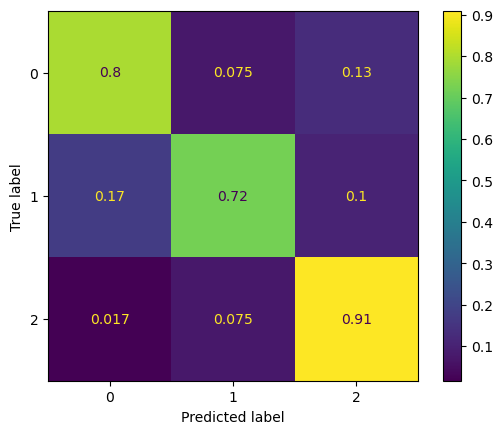

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.53093. Saving Model!
epoch 01, loss: 0.63377, acc: 0.73493, val_loss: 0.53093, val_accuracy: 0.80295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


[INFO] val_acc has been improved from 0.53093 to 0.53004. Saving Model!
epoch 02, loss: 0.66419, acc: 0.71221, val_loss: 0.53004, val_accuracy: 0.80847


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.53004 to 0.51219. Saving Model!
epoch 03, loss: 0.65075, acc: 0.71763, val_loss: 0.51219, val_accuracy: 0.81492


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 04, loss: 0.63219, acc: 0.72777, val_loss: 0.53639, val_accuracy: 0.80203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


epoch 05, loss: 0.65790, acc: 0.70300, val_loss: 0.53404, val_accuracy: 0.81123


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 06, loss: 0.63056, acc: 0.72439, val_loss: 0.55509, val_accuracy: 0.80663


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 07, loss: 0.63752, acc: 0.73462, val_loss: 0.56098, val_accuracy: 0.80663


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 08, loss: 0.64226, acc: 0.73176, val_loss: 0.53979, val_accuracy: 0.82320


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 09, loss: 0.62392, acc: 0.74322, val_loss: 0.54594, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 10, loss: 0.63322, acc: 0.73196, val_loss: 0.55205, val_accuracy: 0.80847


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 11, loss: 0.62869, acc: 0.73473, val_loss: 0.55960, val_accuracy: 0.80295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 12, loss: 0.62254, acc: 0.74056, val_loss: 0.56925, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 13, loss: 0.62465, acc: 0.74946, val_loss: 0.57254, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 14, loss: 0.62136, acc: 0.75335, val_loss: 0.57993, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 15, loss: 0.61832, acc: 0.74629, val_loss: 0.59250, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


epoch 16, loss: 0.61752, acc: 0.74322, val_loss: 0.60112, val_accuracy: 0.71179


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 17, loss: 0.61773, acc: 0.74332, val_loss: 0.60027, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 18, loss: 0.61127, acc: 0.75335, val_loss: 0.60668, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 19, loss: 0.61474, acc: 0.76072, val_loss: 0.61104, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 20, loss: 0.61169, acc: 0.75816, val_loss: 0.61738, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 21, loss: 0.60785, acc: 0.75427, val_loss: 0.62934, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


epoch 22, loss: 0.61127, acc: 0.74905, val_loss: 0.63354, val_accuracy: 0.71271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 23, loss: 0.60531, acc: 0.75745, val_loss: 0.64255, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 24, loss: 0.60683, acc: 0.75908, val_loss: 0.64851, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 25, loss: 0.60575, acc: 0.76062, val_loss: 0.65001, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 26, loss: 0.60226, acc: 0.76113, val_loss: 0.65432, val_accuracy: 0.70810


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


epoch 27, loss: 0.60375, acc: 0.75704, val_loss: 0.65840, val_accuracy: 0.71271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 28, loss: 0.60122, acc: 0.76082, val_loss: 0.66522, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.34it/s]


epoch 29, loss: 0.60038, acc: 0.76389, val_loss: 0.67241, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 30, loss: 0.59995, acc: 0.76144, val_loss: 0.67631, val_accuracy: 0.71455


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 31, loss: 0.59832, acc: 0.76267, val_loss: 0.67984, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 32, loss: 0.59756, acc: 0.76256, val_loss: 0.68389, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 33, loss: 0.59707, acc: 0.76451, val_loss: 0.68644, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 34, loss: 0.59525, acc: 0.76584, val_loss: 0.69068, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 35, loss: 0.59515, acc: 0.76574, val_loss: 0.69330, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 36, loss: 0.59408, acc: 0.76594, val_loss: 0.69629, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 37, loss: 0.59268, acc: 0.76410, val_loss: 0.70186, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 38, loss: 0.59273, acc: 0.76614, val_loss: 0.70585, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 39, loss: 0.59092, acc: 0.76840, val_loss: 0.71028, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 40, loss: 0.59080, acc: 0.76676, val_loss: 0.71241, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]


epoch 41, loss: 0.58975, acc: 0.76717, val_loss: 0.71298, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 42, loss: 0.58877, acc: 0.76840, val_loss: 0.71495, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 43, loss: 0.58839, acc: 0.76809, val_loss: 0.71764, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 44, loss: 0.58718, acc: 0.76522, val_loss: 0.72250, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 45, loss: 0.58679, acc: 0.76666, val_loss: 0.72688, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 46, loss: 0.58584, acc: 0.77055, val_loss: 0.72954, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 47, loss: 0.58504, acc: 0.76983, val_loss: 0.73176, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 48, loss: 0.58449, acc: 0.76983, val_loss: 0.73382, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 49, loss: 0.58364, acc: 0.77218, val_loss: 0.73630, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 50, loss: 0.58299, acc: 0.76983, val_loss: 0.73813, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 51, loss: 0.58224, acc: 0.77075, val_loss: 0.74017, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 52, loss: 0.58146, acc: 0.77249, val_loss: 0.74286, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 53, loss: 0.58093, acc: 0.77310, val_loss: 0.74660, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 54, loss: 0.58008, acc: 0.77310, val_loss: 0.75021, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 55, loss: 0.57956, acc: 0.77290, val_loss: 0.75164, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 56, loss: 0.57880, acc: 0.77484, val_loss: 0.75132, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 57, loss: 0.57813, acc: 0.77392, val_loss: 0.75157, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 58, loss: 0.57752, acc: 0.77423, val_loss: 0.75319, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 59, loss: 0.57674, acc: 0.77331, val_loss: 0.75497, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 60, loss: 0.57617, acc: 0.77423, val_loss: 0.75575, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 61, loss: 0.57547, acc: 0.77484, val_loss: 0.75692, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 62, loss: 0.57490, acc: 0.77443, val_loss: 0.75868, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 63, loss: 0.57419, acc: 0.77607, val_loss: 0.76068, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


epoch 64, loss: 0.57355, acc: 0.77658, val_loss: 0.76208, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


epoch 65, loss: 0.57293, acc: 0.77566, val_loss: 0.76244, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.53it/s]


epoch 66, loss: 0.57228, acc: 0.77730, val_loss: 0.76273, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


epoch 67, loss: 0.57166, acc: 0.77720, val_loss: 0.76374, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 68, loss: 0.57097, acc: 0.77699, val_loss: 0.76556, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 69, loss: 0.57036, acc: 0.77679, val_loss: 0.76809, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 70, loss: 0.56968, acc: 0.77750, val_loss: 0.77058, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 71, loss: 0.56908, acc: 0.77771, val_loss: 0.77234, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 72, loss: 0.56846, acc: 0.77730, val_loss: 0.77364, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 73, loss: 0.56779, acc: 0.77802, val_loss: 0.77596, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 74, loss: 0.56722, acc: 0.77781, val_loss: 0.77772, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 75, loss: 0.56657, acc: 0.77832, val_loss: 0.77881, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 76, loss: 0.56598, acc: 0.77904, val_loss: 0.77926, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 77, loss: 0.56541, acc: 0.77863, val_loss: 0.78002, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 78, loss: 0.56477, acc: 0.77914, val_loss: 0.78145, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 79, loss: 0.56416, acc: 0.77914, val_loss: 0.78307, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 80, loss: 0.56351, acc: 0.77955, val_loss: 0.78482, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 81, loss: 0.56295, acc: 0.77914, val_loss: 0.78618, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 82, loss: 0.56234, acc: 0.77935, val_loss: 0.78739, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 83, loss: 0.56177, acc: 0.77965, val_loss: 0.78768, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 84, loss: 0.56116, acc: 0.77955, val_loss: 0.78919, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 85, loss: 0.56055, acc: 0.77965, val_loss: 0.79131, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 86, loss: 0.55994, acc: 0.78017, val_loss: 0.79288, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 87, loss: 0.55941, acc: 0.78047, val_loss: 0.79397, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 88, loss: 0.55878, acc: 0.78119, val_loss: 0.79422, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 89, loss: 0.55817, acc: 0.78068, val_loss: 0.79586, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 90, loss: 0.55758, acc: 0.78088, val_loss: 0.79698, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 91, loss: 0.55698, acc: 0.78058, val_loss: 0.79849, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 92, loss: 0.55640, acc: 0.78139, val_loss: 0.80012, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 93, loss: 0.55579, acc: 0.78088, val_loss: 0.80161, val_accuracy: 0.71455


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 94, loss: 0.55524, acc: 0.78129, val_loss: 0.80205, val_accuracy: 0.71455


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 95, loss: 0.55464, acc: 0.78191, val_loss: 0.80247, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 96, loss: 0.55406, acc: 0.78191, val_loss: 0.80294, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 97, loss: 0.55346, acc: 0.78191, val_loss: 0.80383, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 98, loss: 0.55286, acc: 0.78160, val_loss: 0.80566, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 99, loss: 0.55231, acc: 0.78221, val_loss: 0.80747, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


epoch 100, loss: 0.55168, acc: 0.78221, val_loss: 0.80924, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 101, loss: 0.55111, acc: 0.78201, val_loss: 0.80991, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 102, loss: 0.55045, acc: 0.78262, val_loss: 0.81026, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 103, loss: 0.54990, acc: 0.78272, val_loss: 0.81086, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 104, loss: 0.54942, acc: 0.78283, val_loss: 0.81260, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 105, loss: 0.54884, acc: 0.78272, val_loss: 0.81364, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 106, loss: 0.54827, acc: 0.78324, val_loss: 0.81496, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 107, loss: 0.54765, acc: 0.78354, val_loss: 0.81610, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 108, loss: 0.54712, acc: 0.78354, val_loss: 0.81678, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 109, loss: 0.54659, acc: 0.78334, val_loss: 0.81790, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 110, loss: 0.54604, acc: 0.78375, val_loss: 0.81923, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 111, loss: 0.54550, acc: 0.78395, val_loss: 0.81976, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 112, loss: 0.54498, acc: 0.78375, val_loss: 0.82084, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 113, loss: 0.54437, acc: 0.78426, val_loss: 0.82251, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 114, loss: 0.54388, acc: 0.78457, val_loss: 0.82359, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 115, loss: 0.54332, acc: 0.78457, val_loss: 0.82446, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 116, loss: 0.54280, acc: 0.78446, val_loss: 0.82599, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 117, loss: 0.54223, acc: 0.78498, val_loss: 0.82716, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 118, loss: 0.54170, acc: 0.78528, val_loss: 0.82788, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 119, loss: 0.54118, acc: 0.78528, val_loss: 0.82918, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 120, loss: 0.54061, acc: 0.78549, val_loss: 0.83032, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 121, loss: 0.54012, acc: 0.78518, val_loss: 0.83140, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 122, loss: 0.53956, acc: 0.78539, val_loss: 0.83298, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 123, loss: 0.53905, acc: 0.78641, val_loss: 0.83492, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 124, loss: 0.53853, acc: 0.78559, val_loss: 0.83678, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 125, loss: 0.53796, acc: 0.78600, val_loss: 0.83752, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 126, loss: 0.53743, acc: 0.78631, val_loss: 0.83774, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 127, loss: 0.53689, acc: 0.78682, val_loss: 0.83926, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 128, loss: 0.53637, acc: 0.78702, val_loss: 0.84066, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 129, loss: 0.53583, acc: 0.78692, val_loss: 0.84287, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 130, loss: 0.53528, acc: 0.78733, val_loss: 0.84445, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 131, loss: 0.53476, acc: 0.78794, val_loss: 0.84513, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 132, loss: 0.53423, acc: 0.78764, val_loss: 0.84660, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 133, loss: 0.53370, acc: 0.78784, val_loss: 0.84844, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 134, loss: 0.53317, acc: 0.78897, val_loss: 0.85004, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 135, loss: 0.53270, acc: 0.78835, val_loss: 0.85141, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 136, loss: 0.53213, acc: 0.78958, val_loss: 0.85254, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 137, loss: 0.53164, acc: 0.78968, val_loss: 0.85446, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 138, loss: 0.53109, acc: 0.78917, val_loss: 0.85637, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 139, loss: 0.53064, acc: 0.78917, val_loss: 0.85866, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 140, loss: 0.53010, acc: 0.79153, val_loss: 0.86019, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 141, loss: 0.52956, acc: 0.79122, val_loss: 0.86180, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 142, loss: 0.52907, acc: 0.79224, val_loss: 0.86350, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 143, loss: 0.52859, acc: 0.79255, val_loss: 0.86498, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 144, loss: 0.52808, acc: 0.79009, val_loss: 0.86562, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 145, loss: 0.52760, acc: 0.79040, val_loss: 0.86640, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 146, loss: 0.52709, acc: 0.79153, val_loss: 0.86771, val_accuracy: 0.71639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 147, loss: 0.52656, acc: 0.79183, val_loss: 0.86945, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 148, loss: 0.52608, acc: 0.79316, val_loss: 0.87118, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 149, loss: 0.52559, acc: 0.79347, val_loss: 0.87236, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 150, loss: 0.52509, acc: 0.79572, val_loss: 0.87464, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 151, loss: 0.52460, acc: 0.79644, val_loss: 0.87668, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 152, loss: 0.52409, acc: 0.79419, val_loss: 0.87748, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 153, loss: 0.52358, acc: 0.79664, val_loss: 0.87678, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 154, loss: 0.52305, acc: 0.79736, val_loss: 0.87716, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 155, loss: 0.52259, acc: 0.79695, val_loss: 0.87848, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 156, loss: 0.52209, acc: 0.79715, val_loss: 0.88102, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 157, loss: 0.52161, acc: 0.79777, val_loss: 0.88294, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 158, loss: 0.52112, acc: 0.79859, val_loss: 0.88331, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 159, loss: 0.52058, acc: 0.79879, val_loss: 0.88287, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 160, loss: 0.52015, acc: 0.79879, val_loss: 0.88357, val_accuracy: 0.71823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 161, loss: 0.51965, acc: 0.79910, val_loss: 0.88591, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 162, loss: 0.51918, acc: 0.79930, val_loss: 0.88755, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 163, loss: 0.51868, acc: 0.79982, val_loss: 0.88939, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 164, loss: 0.51820, acc: 0.80002, val_loss: 0.88936, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 165, loss: 0.51772, acc: 0.79982, val_loss: 0.89000, val_accuracy: 0.71915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 166, loss: 0.51725, acc: 0.79920, val_loss: 0.89208, val_accuracy: 0.72007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 167, loss: 0.51676, acc: 0.80033, val_loss: 0.89420, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 168, loss: 0.51627, acc: 0.80043, val_loss: 0.89552, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 169, loss: 0.51578, acc: 0.80063, val_loss: 0.89566, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 170, loss: 0.51531, acc: 0.80094, val_loss: 0.89714, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 171, loss: 0.51481, acc: 0.80053, val_loss: 0.89933, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 172, loss: 0.51433, acc: 0.80074, val_loss: 0.90013, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 173, loss: 0.51387, acc: 0.80115, val_loss: 0.90023, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 174, loss: 0.51337, acc: 0.80176, val_loss: 0.90119, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 175, loss: 0.51294, acc: 0.80135, val_loss: 0.90362, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 176, loss: 0.51245, acc: 0.80176, val_loss: 0.90430, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 177, loss: 0.51194, acc: 0.80217, val_loss: 0.90477, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 178, loss: 0.51144, acc: 0.80207, val_loss: 0.90580, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 179, loss: 0.51097, acc: 0.80237, val_loss: 0.90716, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 180, loss: 0.51048, acc: 0.80237, val_loss: 0.90879, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 181, loss: 0.51003, acc: 0.80217, val_loss: 0.91100, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 182, loss: 0.50955, acc: 0.80248, val_loss: 0.91387, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 183, loss: 0.50906, acc: 0.80309, val_loss: 0.91393, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 184, loss: 0.50860, acc: 0.80330, val_loss: 0.91250, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 185, loss: 0.50813, acc: 0.80248, val_loss: 0.91348, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 186, loss: 0.50761, acc: 0.80309, val_loss: 0.91585, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 187, loss: 0.50718, acc: 0.80391, val_loss: 0.91725, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 188, loss: 0.50668, acc: 0.80391, val_loss: 0.91789, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 189, loss: 0.50620, acc: 0.80350, val_loss: 0.91928, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 190, loss: 0.50573, acc: 0.80411, val_loss: 0.92029, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 191, loss: 0.50526, acc: 0.80401, val_loss: 0.92101, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 192, loss: 0.50480, acc: 0.80422, val_loss: 0.92147, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 193, loss: 0.50433, acc: 0.80432, val_loss: 0.92330, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 194, loss: 0.50387, acc: 0.80483, val_loss: 0.92575, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 195, loss: 0.50342, acc: 0.80544, val_loss: 0.92662, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 196, loss: 0.50295, acc: 0.80524, val_loss: 0.92634, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 197, loss: 0.50251, acc: 0.80565, val_loss: 0.92659, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 198, loss: 0.50203, acc: 0.80616, val_loss: 0.92701, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 199, loss: 0.50160, acc: 0.80596, val_loss: 0.92997, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 200, loss: 0.50110, acc: 0.80637, val_loss: 0.93205, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 201, loss: 0.50068, acc: 0.80596, val_loss: 0.93120, val_accuracy: 0.72284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 202, loss: 0.50022, acc: 0.80647, val_loss: 0.93039, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 203, loss: 0.49980, acc: 0.80882, val_loss: 0.93165, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 204, loss: 0.49930, acc: 0.80688, val_loss: 0.93335, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 205, loss: 0.49885, acc: 0.80985, val_loss: 0.93472, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 206, loss: 0.49841, acc: 0.80903, val_loss: 0.93621, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 207, loss: 0.49796, acc: 0.80964, val_loss: 0.93695, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 208, loss: 0.49749, acc: 0.80995, val_loss: 0.93801, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 209, loss: 0.49705, acc: 0.80995, val_loss: 0.93933, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 210, loss: 0.49657, acc: 0.81005, val_loss: 0.94008, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 211, loss: 0.49611, acc: 0.81005, val_loss: 0.94037, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 212, loss: 0.49570, acc: 0.81077, val_loss: 0.94278, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 213, loss: 0.49524, acc: 0.81077, val_loss: 0.94385, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 214, loss: 0.49479, acc: 0.81148, val_loss: 0.94558, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 215, loss: 0.49434, acc: 0.81118, val_loss: 0.94683, val_accuracy: 0.72744


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 216, loss: 0.49389, acc: 0.81118, val_loss: 0.94587, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 217, loss: 0.49344, acc: 0.81179, val_loss: 0.94807, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 218, loss: 0.49296, acc: 0.81189, val_loss: 0.95142, val_accuracy: 0.72744


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 219, loss: 0.49255, acc: 0.81189, val_loss: 0.95154, val_accuracy: 0.72744


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 220, loss: 0.49208, acc: 0.81169, val_loss: 0.95256, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 221, loss: 0.49161, acc: 0.81210, val_loss: 0.95382, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 222, loss: 0.49122, acc: 0.81271, val_loss: 0.95436, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 223, loss: 0.49076, acc: 0.81292, val_loss: 0.95605, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 224, loss: 0.49031, acc: 0.81271, val_loss: 0.95748, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 225, loss: 0.48987, acc: 0.81322, val_loss: 0.95748, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 226, loss: 0.48940, acc: 0.81343, val_loss: 0.95883, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 227, loss: 0.48895, acc: 0.81353, val_loss: 0.96076, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 228, loss: 0.48849, acc: 0.81343, val_loss: 0.96230, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 229, loss: 0.48810, acc: 0.81343, val_loss: 0.96296, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 230, loss: 0.48761, acc: 0.81363, val_loss: 0.96403, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 231, loss: 0.48716, acc: 0.81343, val_loss: 0.96559, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 232, loss: 0.48670, acc: 0.81404, val_loss: 0.96790, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 233, loss: 0.48626, acc: 0.81414, val_loss: 0.97027, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 234, loss: 0.48583, acc: 0.81394, val_loss: 0.97123, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 235, loss: 0.48536, acc: 0.81404, val_loss: 0.97171, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 236, loss: 0.48491, acc: 0.81455, val_loss: 0.97254, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 237, loss: 0.48446, acc: 0.81425, val_loss: 0.97450, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 238, loss: 0.48406, acc: 0.81445, val_loss: 0.97757, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 239, loss: 0.48355, acc: 0.81455, val_loss: 0.98010, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 240, loss: 0.48311, acc: 0.81445, val_loss: 0.98101, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 241, loss: 0.48263, acc: 0.81476, val_loss: 0.98238, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 242, loss: 0.48219, acc: 0.81476, val_loss: 0.98615, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 243, loss: 0.48172, acc: 0.81455, val_loss: 0.98907, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 244, loss: 0.48132, acc: 0.81527, val_loss: 0.99173, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 245, loss: 0.48084, acc: 0.81578, val_loss: 0.99228, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 246, loss: 0.48040, acc: 0.81558, val_loss: 0.99381, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


epoch 247, loss: 0.47995, acc: 0.81568, val_loss: 0.99516, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 248, loss: 0.47949, acc: 0.81588, val_loss: 0.99757, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 249, loss: 0.47906, acc: 0.81568, val_loss: 0.99992, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 250, loss: 0.47865, acc: 0.81568, val_loss: 0.99941, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 251, loss: 0.47815, acc: 0.81599, val_loss: 1.00058, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 252, loss: 0.47772, acc: 0.81558, val_loss: 1.00232, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 253, loss: 0.47731, acc: 0.81599, val_loss: 1.00327, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 254, loss: 0.47687, acc: 0.81558, val_loss: 1.00497, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 255, loss: 0.47640, acc: 0.81609, val_loss: 1.00612, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 256, loss: 0.47593, acc: 0.81619, val_loss: 1.00844, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 257, loss: 0.47550, acc: 0.81670, val_loss: 1.00880, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 258, loss: 0.47512, acc: 0.81701, val_loss: 1.00926, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 259, loss: 0.47469, acc: 0.81691, val_loss: 1.01019, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 260, loss: 0.47424, acc: 0.81711, val_loss: 1.01306, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 261, loss: 0.47381, acc: 0.81752, val_loss: 1.01367, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 262, loss: 0.47338, acc: 0.81721, val_loss: 1.01366, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 263, loss: 0.47294, acc: 0.81824, val_loss: 1.01604, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 264, loss: 0.47253, acc: 0.81844, val_loss: 1.01622, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 265, loss: 0.47213, acc: 0.81875, val_loss: 1.01879, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 266, loss: 0.47168, acc: 0.81773, val_loss: 1.01941, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 267, loss: 0.47119, acc: 0.81773, val_loss: 1.02036, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 268, loss: 0.47079, acc: 0.81895, val_loss: 1.02308, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 269, loss: 0.47039, acc: 0.81875, val_loss: 1.02227, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 270, loss: 0.46996, acc: 0.81926, val_loss: 1.02457, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 271, loss: 0.46957, acc: 0.82018, val_loss: 1.02304, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 272, loss: 0.46909, acc: 0.81916, val_loss: 1.02538, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 273, loss: 0.46866, acc: 0.81957, val_loss: 1.02817, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 274, loss: 0.46823, acc: 0.82110, val_loss: 1.02883, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 275, loss: 0.46791, acc: 0.81936, val_loss: 1.03177, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 276, loss: 0.46755, acc: 0.82090, val_loss: 1.03019, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 277, loss: 0.46713, acc: 0.82039, val_loss: 1.03352, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 278, loss: 0.46661, acc: 0.82161, val_loss: 1.03405, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 279, loss: 0.46615, acc: 0.82039, val_loss: 1.03430, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 280, loss: 0.46580, acc: 0.82213, val_loss: 1.03546, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 281, loss: 0.46537, acc: 0.82295, val_loss: 1.03519, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 282, loss: 0.46501, acc: 0.82182, val_loss: 1.03983, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 283, loss: 0.46470, acc: 0.82121, val_loss: 1.03704, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 284, loss: 0.46424, acc: 0.82110, val_loss: 1.04067, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 285, loss: 0.46374, acc: 0.82376, val_loss: 1.04013, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 286, loss: 0.46328, acc: 0.82335, val_loss: 1.04109, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 287, loss: 0.46290, acc: 0.82233, val_loss: 1.04576, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 288, loss: 0.46259, acc: 0.82264, val_loss: 1.04165, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 289, loss: 0.46223, acc: 0.82151, val_loss: 1.04753, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 290, loss: 0.46176, acc: 0.82223, val_loss: 1.04676, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


epoch 291, loss: 0.46130, acc: 0.82397, val_loss: 1.05013, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 292, loss: 0.46082, acc: 0.82417, val_loss: 1.05158, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 293, loss: 0.46041, acc: 0.82305, val_loss: 1.05027, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 294, loss: 0.46006, acc: 0.82407, val_loss: 1.05380, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 295, loss: 0.45974, acc: 0.82376, val_loss: 1.05283, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 296, loss: 0.45932, acc: 0.82448, val_loss: 1.05664, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 297, loss: 0.45887, acc: 0.82469, val_loss: 1.05703, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 298, loss: 0.45841, acc: 0.82499, val_loss: 1.05848, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 299, loss: 0.45800, acc: 0.82499, val_loss: 1.05951, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 300, loss: 0.45763, acc: 0.82387, val_loss: 1.05807, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 301, loss: 0.45736, acc: 0.82591, val_loss: 1.06542, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 302, loss: 0.45710, acc: 0.82407, val_loss: 1.06074, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 303, loss: 0.45670, acc: 0.82612, val_loss: 1.06560, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 304, loss: 0.45620, acc: 0.82489, val_loss: 1.06287, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 305, loss: 0.45570, acc: 0.82663, val_loss: 1.06666, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 306, loss: 0.45522, acc: 0.82602, val_loss: 1.06879, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 307, loss: 0.45481, acc: 0.82561, val_loss: 1.06646, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 308, loss: 0.45443, acc: 0.82724, val_loss: 1.07134, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 309, loss: 0.45408, acc: 0.82561, val_loss: 1.07038, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 310, loss: 0.45374, acc: 0.82571, val_loss: 1.07494, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 311, loss: 0.45331, acc: 0.82612, val_loss: 1.07204, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 312, loss: 0.45290, acc: 0.82622, val_loss: 1.07528, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 313, loss: 0.45246, acc: 0.82653, val_loss: 1.07386, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 314, loss: 0.45206, acc: 0.82745, val_loss: 1.07787, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 315, loss: 0.45162, acc: 0.82704, val_loss: 1.07684, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 316, loss: 0.45119, acc: 0.82632, val_loss: 1.07854, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 317, loss: 0.45082, acc: 0.82714, val_loss: 1.07788, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 318, loss: 0.45039, acc: 0.82724, val_loss: 1.07947, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 319, loss: 0.44996, acc: 0.82735, val_loss: 1.08067, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 320, loss: 0.44957, acc: 0.82724, val_loss: 1.07917, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 321, loss: 0.44925, acc: 0.82868, val_loss: 1.08375, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 322, loss: 0.44893, acc: 0.82765, val_loss: 1.07968, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 323, loss: 0.44857, acc: 0.82898, val_loss: 1.08496, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 324, loss: 0.44826, acc: 0.82755, val_loss: 1.08360, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 325, loss: 0.44786, acc: 0.82796, val_loss: 1.09019, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 326, loss: 0.44749, acc: 0.82827, val_loss: 1.08587, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 327, loss: 0.44717, acc: 0.82806, val_loss: 1.09151, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 328, loss: 0.44671, acc: 0.82806, val_loss: 1.08550, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 329, loss: 0.44633, acc: 0.82980, val_loss: 1.09395, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 330, loss: 0.44600, acc: 0.82847, val_loss: 1.08900, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 331, loss: 0.44558, acc: 0.82857, val_loss: 1.09689, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 332, loss: 0.44534, acc: 0.82837, val_loss: 1.09051, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 333, loss: 0.44496, acc: 0.82939, val_loss: 1.10196, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 334, loss: 0.44456, acc: 0.82857, val_loss: 1.09645, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 335, loss: 0.44426, acc: 0.82929, val_loss: 1.10539, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 336, loss: 0.44397, acc: 0.82878, val_loss: 1.09736, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 337, loss: 0.44365, acc: 0.82837, val_loss: 1.10916, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 338, loss: 0.44346, acc: 0.82765, val_loss: 1.10027, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 339, loss: 0.44333, acc: 0.82929, val_loss: 1.11405, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 340, loss: 0.44329, acc: 0.82786, val_loss: 1.09873, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 341, loss: 0.44315, acc: 0.82970, val_loss: 1.11653, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 342, loss: 0.44292, acc: 0.82714, val_loss: 1.10267, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 343, loss: 0.44239, acc: 0.82878, val_loss: 1.11809, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 344, loss: 0.44189, acc: 0.82704, val_loss: 1.10757, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 345, loss: 0.44122, acc: 0.82970, val_loss: 1.12013, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 346, loss: 0.44041, acc: 0.82878, val_loss: 1.11300, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 347, loss: 0.43962, acc: 0.83042, val_loss: 1.11797, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 348, loss: 0.43897, acc: 0.83124, val_loss: 1.11456, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 349, loss: 0.43848, acc: 0.83062, val_loss: 1.12023, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 350, loss: 0.43809, acc: 0.83185, val_loss: 1.12254, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 351, loss: 0.43774, acc: 0.83103, val_loss: 1.11892, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 352, loss: 0.43747, acc: 0.83103, val_loss: 1.12627, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 353, loss: 0.43732, acc: 0.83072, val_loss: 1.11897, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 354, loss: 0.43745, acc: 0.83216, val_loss: 1.13810, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 355, loss: 0.43828, acc: 0.82704, val_loss: 1.11895, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


epoch 356, loss: 0.43975, acc: 0.83124, val_loss: 1.15057, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 357, loss: 0.44284, acc: 0.82305, val_loss: 1.11856, val_accuracy: 0.72744


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 358, loss: 0.44642, acc: 0.82591, val_loss: 1.16411, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 359, loss: 0.45096, acc: 0.81721, val_loss: 1.12239, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 360, loss: 0.45301, acc: 0.81834, val_loss: 1.16510, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 361, loss: 0.44931, acc: 0.81793, val_loss: 1.12634, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 362, loss: 0.44206, acc: 0.82786, val_loss: 1.14043, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 363, loss: 0.43512, acc: 0.82990, val_loss: 1.14052, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 364, loss: 0.43404, acc: 0.83134, val_loss: 1.13161, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 365, loss: 0.43796, acc: 0.83031, val_loss: 1.16307, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 366, loss: 0.44249, acc: 0.82192, val_loss: 1.12785, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 367, loss: 0.44483, acc: 0.82591, val_loss: 1.16607, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 368, loss: 0.44282, acc: 0.82008, val_loss: 1.12742, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 369, loss: 0.43798, acc: 0.82990, val_loss: 1.15550, val_accuracy: 0.74586


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 370, loss: 0.43331, acc: 0.82857, val_loss: 1.14237, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 371, loss: 0.43108, acc: 0.83400, val_loss: 1.13863, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 372, loss: 0.43207, acc: 0.83154, val_loss: 1.16617, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 373, loss: 0.43465, acc: 0.82622, val_loss: 1.13923, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 374, loss: 0.43639, acc: 0.83298, val_loss: 1.17787, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 375, loss: 0.43671, acc: 0.82469, val_loss: 1.14309, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 376, loss: 0.43475, acc: 0.83052, val_loss: 1.16390, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 377, loss: 0.43225, acc: 0.82755, val_loss: 1.15245, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 378, loss: 0.43003, acc: 0.83400, val_loss: 1.15496, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 379, loss: 0.42853, acc: 0.83502, val_loss: 1.16374, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 380, loss: 0.42816, acc: 0.83277, val_loss: 1.15147, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 381, loss: 0.42871, acc: 0.83400, val_loss: 1.16925, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 382, loss: 0.42976, acc: 0.82796, val_loss: 1.15082, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 383, loss: 0.43080, acc: 0.83349, val_loss: 1.17235, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 384, loss: 0.43136, acc: 0.82704, val_loss: 1.14990, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 385, loss: 0.43131, acc: 0.83093, val_loss: 1.17838, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 386, loss: 0.43047, acc: 0.82653, val_loss: 1.14884, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 387, loss: 0.42918, acc: 0.83502, val_loss: 1.17627, val_accuracy: 0.74586


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 388, loss: 0.42773, acc: 0.82970, val_loss: 1.15542, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 389, loss: 0.42588, acc: 0.83461, val_loss: 1.17009, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 390, loss: 0.42449, acc: 0.83441, val_loss: 1.16521, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 391, loss: 0.42374, acc: 0.83523, val_loss: 1.16094, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 392, loss: 0.42376, acc: 0.83553, val_loss: 1.17884, val_accuracy: 0.74586


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 393, loss: 0.42437, acc: 0.83379, val_loss: 1.16169, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 394, loss: 0.42519, acc: 0.83799, val_loss: 1.19119, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 395, loss: 0.42670, acc: 0.82827, val_loss: 1.16009, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 396, loss: 0.42823, acc: 0.83338, val_loss: 1.20082, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 397, loss: 0.43034, acc: 0.82602, val_loss: 1.16320, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 398, loss: 0.43275, acc: 0.83021, val_loss: 1.20672, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


epoch 399, loss: 0.43522, acc: 0.82315, val_loss: 1.16750, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 400, loss: 0.43760, acc: 0.82704, val_loss: 1.20878, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 401, loss: 0.43619, acc: 0.82458, val_loss: 1.17518, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 402, loss: 0.43243, acc: 0.82990, val_loss: 1.19677, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 403, loss: 0.42598, acc: 0.83052, val_loss: 1.17604, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 404, loss: 0.42094, acc: 0.83707, val_loss: 1.18206, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 405, loss: 0.41951, acc: 0.83594, val_loss: 1.18710, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 406, loss: 0.42142, acc: 0.83420, val_loss: 1.17619, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 407, loss: 0.42472, acc: 0.83379, val_loss: 1.20288, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 408, loss: 0.42718, acc: 0.82612, val_loss: 1.17132, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 409, loss: 0.42890, acc: 0.83072, val_loss: 1.21769, val_accuracy: 0.74678


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 410, loss: 0.42918, acc: 0.82397, val_loss: 1.17039, val_accuracy: 0.72744


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 411, loss: 0.42689, acc: 0.83338, val_loss: 1.21929, val_accuracy: 0.74678


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 412, loss: 0.42393, acc: 0.83062, val_loss: 1.17985, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


epoch 413, loss: 0.41918, acc: 0.83871, val_loss: 1.19555, val_accuracy: 0.74862


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 414, loss: 0.41659, acc: 0.83809, val_loss: 1.19530, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 415, loss: 0.41672, acc: 0.83625, val_loss: 1.17884, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 416, loss: 0.41872, acc: 0.83983, val_loss: 1.21872, val_accuracy: 0.74586


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 417, loss: 0.42119, acc: 0.83175, val_loss: 1.18201, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 418, loss: 0.42202, acc: 0.83584, val_loss: 1.22500, val_accuracy: 0.74586


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 419, loss: 0.42138, acc: 0.83246, val_loss: 1.18708, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 420, loss: 0.41953, acc: 0.83635, val_loss: 1.20884, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 421, loss: 0.41779, acc: 0.83379, val_loss: 1.19750, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 422, loss: 0.41669, acc: 0.83871, val_loss: 1.20099, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 423, loss: 0.41573, acc: 0.83666, val_loss: 1.21042, val_accuracy: 0.74862


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 424, loss: 0.41493, acc: 0.83912, val_loss: 1.19487, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 425, loss: 0.41377, acc: 0.83871, val_loss: 1.21405, val_accuracy: 0.74770


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 426, loss: 0.41312, acc: 0.83891, val_loss: 1.19761, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 427, loss: 0.41288, acc: 0.84075, val_loss: 1.21723, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 428, loss: 0.41327, acc: 0.83738, val_loss: 1.20368, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 429, loss: 0.41438, acc: 0.83830, val_loss: 1.22376, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


epoch 430, loss: 0.41586, acc: 0.83533, val_loss: 1.20868, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 431, loss: 0.41812, acc: 0.83523, val_loss: 1.23456, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 432, loss: 0.42139, acc: 0.83236, val_loss: 1.20833, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 433, loss: 0.42570, acc: 0.83103, val_loss: 1.25057, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 434, loss: 0.42882, acc: 0.82745, val_loss: 1.20522, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 435, loss: 0.43076, acc: 0.82898, val_loss: 1.25295, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]


epoch 436, loss: 0.42772, acc: 0.82540, val_loss: 1.19886, val_accuracy: 0.73020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.36it/s]


epoch 437, loss: 0.42148, acc: 0.83338, val_loss: 1.23650, val_accuracy: 0.74678


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 438, loss: 0.41306, acc: 0.83676, val_loss: 1.21148, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


epoch 439, loss: 0.40915, acc: 0.84045, val_loss: 1.21889, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.11it/s]


epoch 440, loss: 0.41149, acc: 0.84106, val_loss: 1.23779, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 441, loss: 0.41609, acc: 0.83584, val_loss: 1.21313, val_accuracy: 0.73481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


epoch 442, loss: 0.41969, acc: 0.83308, val_loss: 1.25424, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 443, loss: 0.41934, acc: 0.82990, val_loss: 1.20965, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 444, loss: 0.41638, acc: 0.83482, val_loss: 1.25095, val_accuracy: 0.74678


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 445, loss: 0.41142, acc: 0.83564, val_loss: 1.21863, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 446, loss: 0.40767, acc: 0.84239, val_loss: 1.23661, val_accuracy: 0.74954


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 447, loss: 0.40729, acc: 0.84065, val_loss: 1.23057, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 448, loss: 0.40882, acc: 0.83656, val_loss: 1.22589, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 449, loss: 0.41076, acc: 0.83871, val_loss: 1.24947, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 450, loss: 0.41176, acc: 0.83533, val_loss: 1.22570, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.92it/s]


epoch 451, loss: 0.41169, acc: 0.83789, val_loss: 1.25543, val_accuracy: 0.74770


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 452, loss: 0.41085, acc: 0.83543, val_loss: 1.21852, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 453, loss: 0.40912, acc: 0.84034, val_loss: 1.25566, val_accuracy: 0.74954


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


epoch 454, loss: 0.40648, acc: 0.83983, val_loss: 1.22740, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


epoch 455, loss: 0.40429, acc: 0.84249, val_loss: 1.24402, val_accuracy: 0.74954


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.85it/s]


epoch 456, loss: 0.40410, acc: 0.84239, val_loss: 1.23936, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 457, loss: 0.40522, acc: 0.83799, val_loss: 1.24153, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 458, loss: 0.40710, acc: 0.84106, val_loss: 1.25633, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 459, loss: 0.40878, acc: 0.83543, val_loss: 1.23979, val_accuracy: 0.72192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 460, loss: 0.41000, acc: 0.83860, val_loss: 1.26041, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 461, loss: 0.41066, acc: 0.83410, val_loss: 1.23645, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 462, loss: 0.41042, acc: 0.83799, val_loss: 1.26694, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 463, loss: 0.40896, acc: 0.83727, val_loss: 1.23925, val_accuracy: 0.74217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 464, loss: 0.40644, acc: 0.84065, val_loss: 1.26557, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 465, loss: 0.40296, acc: 0.83891, val_loss: 1.24405, val_accuracy: 0.74033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 466, loss: 0.40068, acc: 0.84577, val_loss: 1.25922, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 467, loss: 0.40034, acc: 0.84434, val_loss: 1.25025, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 468, loss: 0.40162, acc: 0.83973, val_loss: 1.25885, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 469, loss: 0.40345, acc: 0.84260, val_loss: 1.25837, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 470, loss: 0.40481, acc: 0.83748, val_loss: 1.26092, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 471, loss: 0.40556, acc: 0.84106, val_loss: 1.26237, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 472, loss: 0.40558, acc: 0.83656, val_loss: 1.26499, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 473, loss: 0.40437, acc: 0.84075, val_loss: 1.26918, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 474, loss: 0.40232, acc: 0.83830, val_loss: 1.25979, val_accuracy: 0.72836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 475, loss: 0.39991, acc: 0.84567, val_loss: 1.26915, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 476, loss: 0.39797, acc: 0.84352, val_loss: 1.25566, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 477, loss: 0.39713, acc: 0.84628, val_loss: 1.27830, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 478, loss: 0.39772, acc: 0.84413, val_loss: 1.25615, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 479, loss: 0.39907, acc: 0.84515, val_loss: 1.29230, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 480, loss: 0.40188, acc: 0.84352, val_loss: 1.25580, val_accuracy: 0.72376


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 481, loss: 0.40247, acc: 0.84004, val_loss: 1.30190, val_accuracy: 0.73849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


epoch 482, loss: 0.40438, acc: 0.84126, val_loss: 1.25849, val_accuracy: 0.72468


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 483, loss: 0.40114, acc: 0.84055, val_loss: 1.29086, val_accuracy: 0.73573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 484, loss: 0.39850, acc: 0.84434, val_loss: 1.26554, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 485, loss: 0.39509, acc: 0.84669, val_loss: 1.27568, val_accuracy: 0.74770


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 486, loss: 0.39381, acc: 0.84536, val_loss: 1.28218, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 487, loss: 0.39443, acc: 0.84556, val_loss: 1.27085, val_accuracy: 0.73389


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.77it/s]


epoch 488, loss: 0.39596, acc: 0.84536, val_loss: 1.30103, val_accuracy: 0.73665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 489, loss: 0.39860, acc: 0.84577, val_loss: 1.27267, val_accuracy: 0.72560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


epoch 490, loss: 0.39926, acc: 0.83993, val_loss: 1.30315, val_accuracy: 0.73757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.67it/s]


epoch 491, loss: 0.39981, acc: 0.84393, val_loss: 1.27312, val_accuracy: 0.72652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


epoch 492, loss: 0.39758, acc: 0.84075, val_loss: 1.29341, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.44it/s]


epoch 493, loss: 0.39560, acc: 0.84587, val_loss: 1.28557, val_accuracy: 0.73941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 494, loss: 0.39356, acc: 0.84382, val_loss: 1.27606, val_accuracy: 0.74309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 495, loss: 0.39303, acc: 0.84925, val_loss: 1.30813, val_accuracy: 0.73112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 496, loss: 0.39486, acc: 0.84362, val_loss: 1.26770, val_accuracy: 0.72928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 497, loss: 0.39850, acc: 0.84495, val_loss: 1.34727, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 498, loss: 0.40773, acc: 0.83748, val_loss: 1.26162, val_accuracy: 0.71547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 499, loss: 0.41073, acc: 0.83564, val_loss: 1.36479, val_accuracy: 0.74125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


epoch 500, loss: 0.41916, acc: 0.82806, val_loss: 1.26973, val_accuracy: 0.72376
6번째 교차검증
evaluation loss: 0.51219, evaluation accuracy: 0.81492
(5, 1086)
(1086, 5)
Learning rate set to 0.066007
0:	learn: 1.0258119	total: 7.54ms	remaining: 7.54s
1:	learn: 0.9639451	total: 15.2ms	remaining: 7.56s
2:	learn: 0.9106253	total: 23.8ms	remaining: 7.9s
3:	learn: 0.8641594	total: 30.8ms	remaining: 7.68s
4:	learn: 0.8233428	total: 37.3ms	remaining: 7.42s
5:	learn: 0.7871991	total: 43.7ms	remaining: 7.23s
6:	learn: 0.7550052	total: 51.8ms	remaining: 7.35s
7:	learn: 0.7262336	total: 59.4ms	remaining: 7.36s
8:	learn: 0.7004170	total: 67ms	remaining: 7.37s
9:	learn: 0.6771718	total: 73.4ms	remaining: 7.26s
10:	learn: 0.6559193	total: 80.5ms	remaining: 7.24s
11:	learn: 0.6369005	total: 87.2ms	remaining: 7.18s
12:	learn: 0.6178844	total: 95.1ms	remaining: 7.22s
13:	learn: 0.6006047	total: 102ms	remaining: 7.21s
14:	learn: 0.5849070	total: 109ms	remaining: 7.17s
15:	learn: 0.5718044	total: 117ms	remain

170:	learn: 0.3709821	total: 1.24s	remaining: 6s
171:	learn: 0.3708725	total: 1.25s	remaining: 6s
172:	learn: 0.3707559	total: 1.25s	remaining: 6s
173:	learn: 0.3706511	total: 1.26s	remaining: 5.99s
174:	learn: 0.3705846	total: 1.27s	remaining: 5.98s
175:	learn: 0.3704837	total: 1.27s	remaining: 5.97s
176:	learn: 0.3703965	total: 1.28s	remaining: 5.96s
177:	learn: 0.3702931	total: 1.29s	remaining: 5.96s
178:	learn: 0.3702089	total: 1.3s	remaining: 5.96s
179:	learn: 0.3701408	total: 1.3s	remaining: 5.95s
180:	learn: 0.3700408	total: 1.31s	remaining: 5.94s
181:	learn: 0.3699478	total: 1.32s	remaining: 5.93s
182:	learn: 0.3698704	total: 1.33s	remaining: 5.93s
183:	learn: 0.3697775	total: 1.33s	remaining: 5.92s
184:	learn: 0.3696957	total: 1.34s	remaining: 5.91s
185:	learn: 0.3696042	total: 1.35s	remaining: 5.91s
186:	learn: 0.3695165	total: 1.36s	remaining: 5.9s
187:	learn: 0.3694279	total: 1.37s	remaining: 5.9s
188:	learn: 0.3693550	total: 1.38s	remaining: 5.9s
189:	learn: 0.3692718	tota

343:	learn: 0.3626882	total: 2.91s	remaining: 5.55s
344:	learn: 0.3626648	total: 2.92s	remaining: 5.55s
345:	learn: 0.3626425	total: 2.93s	remaining: 5.54s
346:	learn: 0.3626243	total: 2.94s	remaining: 5.53s
347:	learn: 0.3626006	total: 2.95s	remaining: 5.52s
348:	learn: 0.3625768	total: 2.96s	remaining: 5.51s
349:	learn: 0.3625550	total: 2.96s	remaining: 5.51s
350:	learn: 0.3625337	total: 2.97s	remaining: 5.5s
351:	learn: 0.3625115	total: 2.98s	remaining: 5.49s
352:	learn: 0.3624917	total: 2.99s	remaining: 5.48s
353:	learn: 0.3624672	total: 3s	remaining: 5.48s
354:	learn: 0.3624442	total: 3.01s	remaining: 5.47s
355:	learn: 0.3624221	total: 3.02s	remaining: 5.47s
356:	learn: 0.3623998	total: 3.03s	remaining: 5.46s
357:	learn: 0.3623782	total: 3.04s	remaining: 5.45s
358:	learn: 0.3623565	total: 3.05s	remaining: 5.44s
359:	learn: 0.3623336	total: 3.06s	remaining: 5.43s
360:	learn: 0.3623116	total: 3.07s	remaining: 5.43s
361:	learn: 0.3622951	total: 3.07s	remaining: 5.42s
362:	learn: 0.36

520:	learn: 0.3600576	total: 4.57s	remaining: 4.2s
521:	learn: 0.3600485	total: 4.58s	remaining: 4.19s
522:	learn: 0.3600392	total: 4.58s	remaining: 4.18s
523:	learn: 0.3600291	total: 4.59s	remaining: 4.17s
524:	learn: 0.3600225	total: 4.6s	remaining: 4.16s
525:	learn: 0.3600136	total: 4.61s	remaining: 4.15s
526:	learn: 0.3600035	total: 4.62s	remaining: 4.14s
527:	learn: 0.3599965	total: 4.62s	remaining: 4.13s
528:	learn: 0.3599872	total: 4.63s	remaining: 4.12s
529:	learn: 0.3599778	total: 4.64s	remaining: 4.11s
530:	learn: 0.3599667	total: 4.65s	remaining: 4.1s
531:	learn: 0.3599583	total: 4.65s	remaining: 4.09s
532:	learn: 0.3599487	total: 4.66s	remaining: 4.09s
533:	learn: 0.3599379	total: 4.67s	remaining: 4.08s
534:	learn: 0.3599295	total: 4.68s	remaining: 4.07s
535:	learn: 0.3599189	total: 4.69s	remaining: 4.06s
536:	learn: 0.3599099	total: 4.7s	remaining: 4.05s
537:	learn: 0.3599023	total: 4.7s	remaining: 4.04s
538:	learn: 0.3598941	total: 4.71s	remaining: 4.03s
539:	learn: 0.359

702:	learn: 0.3588171	total: 6.04s	remaining: 2.55s
703:	learn: 0.3588114	total: 6.04s	remaining: 2.54s
704:	learn: 0.3588066	total: 6.05s	remaining: 2.53s
705:	learn: 0.3588025	total: 6.06s	remaining: 2.52s
706:	learn: 0.3587978	total: 6.07s	remaining: 2.52s
707:	learn: 0.3587918	total: 6.08s	remaining: 2.51s
708:	learn: 0.3587877	total: 6.09s	remaining: 2.5s
709:	learn: 0.3587836	total: 6.1s	remaining: 2.49s
710:	learn: 0.3587785	total: 6.1s	remaining: 2.48s
711:	learn: 0.3587730	total: 6.11s	remaining: 2.47s
712:	learn: 0.3587676	total: 6.12s	remaining: 2.46s
713:	learn: 0.3587640	total: 6.13s	remaining: 2.46s
714:	learn: 0.3587599	total: 6.14s	remaining: 2.45s
715:	learn: 0.3587528	total: 6.15s	remaining: 2.44s
716:	learn: 0.3587473	total: 6.15s	remaining: 2.43s
717:	learn: 0.3587421	total: 6.16s	remaining: 2.42s
718:	learn: 0.3587364	total: 6.17s	remaining: 2.41s
719:	learn: 0.3587315	total: 6.18s	remaining: 2.4s
720:	learn: 0.3587258	total: 6.19s	remaining: 2.39s
721:	learn: 0.35

869:	learn: 0.3581406	total: 7.49s	remaining: 1.12s
870:	learn: 0.3581382	total: 7.5s	remaining: 1.11s
871:	learn: 0.3581350	total: 7.51s	remaining: 1.1s
872:	learn: 0.3581316	total: 7.52s	remaining: 1.09s
873:	learn: 0.3581282	total: 7.53s	remaining: 1.08s
874:	learn: 0.3581251	total: 7.54s	remaining: 1.08s
875:	learn: 0.3581221	total: 7.54s	remaining: 1.07s
876:	learn: 0.3581189	total: 7.55s	remaining: 1.06s
877:	learn: 0.3581158	total: 7.56s	remaining: 1.05s
878:	learn: 0.3581124	total: 7.57s	remaining: 1.04s
879:	learn: 0.3581094	total: 7.58s	remaining: 1.03s
880:	learn: 0.3581072	total: 7.59s	remaining: 1.02s
881:	learn: 0.3581039	total: 7.6s	remaining: 1.02s
882:	learn: 0.3581011	total: 7.61s	remaining: 1.01s
883:	learn: 0.3580977	total: 7.61s	remaining: 999ms
884:	learn: 0.3580948	total: 7.62s	remaining: 991ms
885:	learn: 0.3580913	total: 7.63s	remaining: 982ms
886:	learn: 0.3580884	total: 7.64s	remaining: 973ms
887:	learn: 0.3580853	total: 7.65s	remaining: 965ms
888:	learn: 0.3

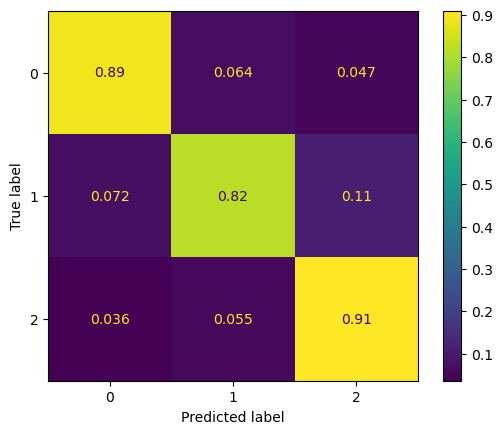

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.68901. Saving Model!
epoch 01, loss: 0.61714, acc: 0.74120, val_loss: 0.68901, val_accuracy: 0.67189


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 02, loss: 0.64557, acc: 0.73485, val_loss: 0.68914, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


[INFO] val_acc has been improved from 0.68901 to 0.68600. Saving Model!
epoch 03, loss: 0.63417, acc: 0.74059, val_loss: 0.68600, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 04, loss: 0.61599, acc: 0.74499, val_loss: 0.73229, val_accuracy: 0.67005


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


epoch 05, loss: 0.63737, acc: 0.73219, val_loss: 0.73588, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 06, loss: 0.61081, acc: 0.73721, val_loss: 0.75797, val_accuracy: 0.63502


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 07, loss: 0.62181, acc: 0.74816, val_loss: 0.76342, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 08, loss: 0.61754, acc: 0.75450, val_loss: 0.75856, val_accuracy: 0.66083


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 09, loss: 0.60707, acc: 0.75757, val_loss: 0.77311, val_accuracy: 0.65806


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 10, loss: 0.61753, acc: 0.74325, val_loss: 0.76881, val_accuracy: 0.63502


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 11, loss: 0.60253, acc: 0.75471, val_loss: 0.77895, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 12, loss: 0.60858, acc: 0.75512, val_loss: 0.78485, val_accuracy: 0.64055


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 13, loss: 0.60584, acc: 0.76187, val_loss: 0.78809, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 14, loss: 0.59899, acc: 0.75747, val_loss: 0.79807, val_accuracy: 0.65714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 15, loss: 0.60457, acc: 0.74754, val_loss: 0.78991, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 16, loss: 0.59545, acc: 0.75870, val_loss: 0.79238, val_accuracy: 0.62949


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 17, loss: 0.59916, acc: 0.75368, val_loss: 0.79345, val_accuracy: 0.64240


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 18, loss: 0.59589, acc: 0.75757, val_loss: 0.79587, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 19, loss: 0.59232, acc: 0.76136, val_loss: 0.79958, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 20, loss: 0.59528, acc: 0.75808, val_loss: 0.78962, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 21, loss: 0.58882, acc: 0.76228, val_loss: 0.78820, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 22, loss: 0.59190, acc: 0.76095, val_loss: 0.78877, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 23, loss: 0.58843, acc: 0.76822, val_loss: 0.79520, val_accuracy: 0.65806


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 24, loss: 0.58689, acc: 0.76801, val_loss: 0.79994, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 25, loss: 0.58806, acc: 0.76648, val_loss: 0.79415, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 26, loss: 0.58365, acc: 0.76873, val_loss: 0.79404, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 27, loss: 0.58569, acc: 0.76545, val_loss: 0.79529, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 28, loss: 0.58223, acc: 0.76944, val_loss: 0.80239, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


epoch 29, loss: 0.58252, acc: 0.77036, val_loss: 0.80543, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 30, loss: 0.58147, acc: 0.77067, val_loss: 0.80473, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 31, loss: 0.57953, acc: 0.77016, val_loss: 0.80795, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 32, loss: 0.58024, acc: 0.76811, val_loss: 0.81208, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 33, loss: 0.57748, acc: 0.77149, val_loss: 0.81833, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 34, loss: 0.57812, acc: 0.77221, val_loss: 0.81707, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 35, loss: 0.57611, acc: 0.77497, val_loss: 0.81561, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 36, loss: 0.57575, acc: 0.77374, val_loss: 0.81771, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 37, loss: 0.57500, acc: 0.77302, val_loss: 0.82272, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 38, loss: 0.57377, acc: 0.77343, val_loss: 0.82650, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 39, loss: 0.57367, acc: 0.77507, val_loss: 0.82512, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 40, loss: 0.57198, acc: 0.77364, val_loss: 0.82509, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 41, loss: 0.57196, acc: 0.77487, val_loss: 0.82719, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 42, loss: 0.57051, acc: 0.77343, val_loss: 0.83102, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 43, loss: 0.57025, acc: 0.77671, val_loss: 0.83111, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 44, loss: 0.56928, acc: 0.77712, val_loss: 0.82875, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 45, loss: 0.56865, acc: 0.77528, val_loss: 0.82833, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 46, loss: 0.56793, acc: 0.77558, val_loss: 0.83042, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 47, loss: 0.56700, acc: 0.77896, val_loss: 0.83275, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 48, loss: 0.56654, acc: 0.77876, val_loss: 0.83245, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 49, loss: 0.56549, acc: 0.77661, val_loss: 0.83248, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 50, loss: 0.56503, acc: 0.77630, val_loss: 0.83418, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 51, loss: 0.56413, acc: 0.77661, val_loss: 0.83667, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 52, loss: 0.56359, acc: 0.77886, val_loss: 0.83655, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 53, loss: 0.56274, acc: 0.77835, val_loss: 0.83618, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 54, loss: 0.56213, acc: 0.77620, val_loss: 0.83748, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 55, loss: 0.56136, acc: 0.77702, val_loss: 0.83963, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 56, loss: 0.56073, acc: 0.78009, val_loss: 0.84069, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 57, loss: 0.55999, acc: 0.77968, val_loss: 0.84104, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 58, loss: 0.55936, acc: 0.78060, val_loss: 0.84198, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 59, loss: 0.55864, acc: 0.78029, val_loss: 0.84375, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 60, loss: 0.55798, acc: 0.78101, val_loss: 0.84475, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 61, loss: 0.55726, acc: 0.78183, val_loss: 0.84488, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 62, loss: 0.55661, acc: 0.78162, val_loss: 0.84553, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 63, loss: 0.55592, acc: 0.78060, val_loss: 0.84653, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 64, loss: 0.55529, acc: 0.78285, val_loss: 0.84787, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 65, loss: 0.55459, acc: 0.78305, val_loss: 0.84884, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 66, loss: 0.55390, acc: 0.78029, val_loss: 0.84973, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 67, loss: 0.55330, acc: 0.78070, val_loss: 0.85066, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 68, loss: 0.55260, acc: 0.78387, val_loss: 0.85100, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 69, loss: 0.55197, acc: 0.78438, val_loss: 0.85080, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 70, loss: 0.55129, acc: 0.78295, val_loss: 0.85235, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 71, loss: 0.55069, acc: 0.78295, val_loss: 0.85485, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 72, loss: 0.55002, acc: 0.78428, val_loss: 0.85686, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 73, loss: 0.54933, acc: 0.78408, val_loss: 0.85815, val_accuracy: 0.64147


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 74, loss: 0.54871, acc: 0.78193, val_loss: 0.85856, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 75, loss: 0.54805, acc: 0.78397, val_loss: 0.85918, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 76, loss: 0.54745, acc: 0.78428, val_loss: 0.85903, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 77, loss: 0.54683, acc: 0.78438, val_loss: 0.85970, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 78, loss: 0.54616, acc: 0.78428, val_loss: 0.86153, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 79, loss: 0.54554, acc: 0.78428, val_loss: 0.86296, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 80, loss: 0.54496, acc: 0.78479, val_loss: 0.86324, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 81, loss: 0.54436, acc: 0.78500, val_loss: 0.86363, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 82, loss: 0.54374, acc: 0.78561, val_loss: 0.86467, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 83, loss: 0.54313, acc: 0.78612, val_loss: 0.86646, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 84, loss: 0.54252, acc: 0.78602, val_loss: 0.86740, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 85, loss: 0.54188, acc: 0.78633, val_loss: 0.86768, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 86, loss: 0.54128, acc: 0.78653, val_loss: 0.86794, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 87, loss: 0.54065, acc: 0.78704, val_loss: 0.86901, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 88, loss: 0.54011, acc: 0.78715, val_loss: 0.86997, val_accuracy: 0.64424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 89, loss: 0.53950, acc: 0.78756, val_loss: 0.87046, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 90, loss: 0.53887, acc: 0.78766, val_loss: 0.87085, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 91, loss: 0.53830, acc: 0.78735, val_loss: 0.87163, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 92, loss: 0.53771, acc: 0.78858, val_loss: 0.87201, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 93, loss: 0.53709, acc: 0.78848, val_loss: 0.87123, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 94, loss: 0.53651, acc: 0.78848, val_loss: 0.87207, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 95, loss: 0.53591, acc: 0.78899, val_loss: 0.87363, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 96, loss: 0.53531, acc: 0.78889, val_loss: 0.87461, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 97, loss: 0.53471, acc: 0.78930, val_loss: 0.87529, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 98, loss: 0.53415, acc: 0.78960, val_loss: 0.87603, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 99, loss: 0.53354, acc: 0.79001, val_loss: 0.87662, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 100, loss: 0.53295, acc: 0.78950, val_loss: 0.87697, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 101, loss: 0.53232, acc: 0.78940, val_loss: 0.87784, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


epoch 102, loss: 0.53175, acc: 0.78899, val_loss: 0.87838, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 103, loss: 0.53114, acc: 0.79011, val_loss: 0.87840, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 104, loss: 0.53056, acc: 0.78991, val_loss: 0.87896, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 105, loss: 0.53001, acc: 0.78971, val_loss: 0.88021, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 106, loss: 0.52943, acc: 0.79001, val_loss: 0.88094, val_accuracy: 0.64700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 107, loss: 0.52884, acc: 0.79001, val_loss: 0.88160, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 108, loss: 0.52829, acc: 0.78991, val_loss: 0.88177, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 109, loss: 0.52768, acc: 0.79063, val_loss: 0.88225, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 110, loss: 0.52713, acc: 0.79083, val_loss: 0.88233, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 111, loss: 0.52655, acc: 0.79134, val_loss: 0.88275, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 112, loss: 0.52601, acc: 0.79063, val_loss: 0.88311, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 113, loss: 0.52542, acc: 0.79104, val_loss: 0.88474, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 114, loss: 0.52483, acc: 0.79175, val_loss: 0.88526, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 115, loss: 0.52430, acc: 0.79175, val_loss: 0.88568, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 116, loss: 0.52373, acc: 0.79226, val_loss: 0.88670, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 117, loss: 0.52315, acc: 0.79175, val_loss: 0.88752, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 118, loss: 0.52256, acc: 0.79216, val_loss: 0.88810, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 119, loss: 0.52200, acc: 0.79226, val_loss: 0.88877, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 120, loss: 0.52147, acc: 0.79318, val_loss: 0.89033, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 121, loss: 0.52091, acc: 0.79298, val_loss: 0.89147, val_accuracy: 0.64885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 122, loss: 0.52034, acc: 0.79288, val_loss: 0.89134, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 123, loss: 0.51981, acc: 0.79288, val_loss: 0.89102, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 124, loss: 0.51927, acc: 0.79318, val_loss: 0.89104, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 125, loss: 0.51872, acc: 0.79370, val_loss: 0.89143, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 126, loss: 0.51815, acc: 0.79441, val_loss: 0.89246, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 127, loss: 0.51759, acc: 0.79472, val_loss: 0.89443, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 128, loss: 0.51706, acc: 0.79492, val_loss: 0.89568, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 129, loss: 0.51649, acc: 0.79451, val_loss: 0.89550, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 130, loss: 0.51597, acc: 0.79503, val_loss: 0.89583, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 131, loss: 0.51540, acc: 0.79595, val_loss: 0.89676, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 132, loss: 0.51483, acc: 0.79574, val_loss: 0.89718, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 133, loss: 0.51428, acc: 0.79554, val_loss: 0.89774, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 134, loss: 0.51371, acc: 0.79574, val_loss: 0.89877, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 135, loss: 0.51318, acc: 0.79625, val_loss: 0.89864, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 136, loss: 0.51262, acc: 0.79615, val_loss: 0.89877, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 137, loss: 0.51208, acc: 0.79758, val_loss: 0.89996, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 138, loss: 0.51157, acc: 0.79738, val_loss: 0.90050, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 139, loss: 0.51102, acc: 0.79738, val_loss: 0.90089, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 140, loss: 0.51046, acc: 0.79738, val_loss: 0.90157, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 141, loss: 0.50992, acc: 0.79769, val_loss: 0.90133, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 142, loss: 0.50938, acc: 0.79881, val_loss: 0.90225, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 143, loss: 0.50885, acc: 0.79820, val_loss: 0.90279, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 144, loss: 0.50829, acc: 0.79840, val_loss: 0.90302, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 145, loss: 0.50777, acc: 0.79892, val_loss: 0.90395, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 146, loss: 0.50725, acc: 0.79963, val_loss: 0.90496, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 147, loss: 0.50670, acc: 0.79943, val_loss: 0.90553, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 148, loss: 0.50620, acc: 0.79912, val_loss: 0.90621, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 149, loss: 0.50565, acc: 0.79932, val_loss: 0.90737, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 150, loss: 0.50517, acc: 0.80014, val_loss: 0.90820, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 151, loss: 0.50462, acc: 0.79973, val_loss: 0.90900, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 152, loss: 0.50413, acc: 0.80025, val_loss: 0.90968, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 153, loss: 0.50360, acc: 0.80035, val_loss: 0.91101, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 154, loss: 0.50307, acc: 0.79994, val_loss: 0.91075, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 155, loss: 0.50259, acc: 0.79953, val_loss: 0.90980, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 156, loss: 0.50202, acc: 0.80035, val_loss: 0.91099, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 157, loss: 0.50154, acc: 0.80065, val_loss: 0.91243, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 158, loss: 0.50108, acc: 0.80065, val_loss: 0.91254, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 159, loss: 0.50052, acc: 0.80106, val_loss: 0.91271, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 160, loss: 0.50007, acc: 0.80117, val_loss: 0.91364, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 161, loss: 0.49957, acc: 0.80188, val_loss: 0.91424, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 162, loss: 0.49903, acc: 0.80239, val_loss: 0.91407, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 163, loss: 0.49854, acc: 0.80270, val_loss: 0.91403, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 164, loss: 0.49803, acc: 0.80280, val_loss: 0.91500, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 165, loss: 0.49753, acc: 0.80311, val_loss: 0.91559, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 166, loss: 0.49704, acc: 0.80352, val_loss: 0.91439, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 167, loss: 0.49654, acc: 0.80352, val_loss: 0.91409, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 168, loss: 0.49608, acc: 0.80362, val_loss: 0.91544, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 169, loss: 0.49560, acc: 0.80403, val_loss: 0.91673, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 170, loss: 0.49508, acc: 0.80403, val_loss: 0.91735, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 171, loss: 0.49457, acc: 0.80434, val_loss: 0.91790, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 172, loss: 0.49408, acc: 0.80434, val_loss: 0.91775, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 173, loss: 0.49357, acc: 0.80444, val_loss: 0.91821, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 174, loss: 0.49309, acc: 0.80475, val_loss: 0.91876, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 175, loss: 0.49263, acc: 0.80475, val_loss: 0.91886, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 176, loss: 0.49215, acc: 0.80475, val_loss: 0.91778, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 177, loss: 0.49167, acc: 0.80424, val_loss: 0.91910, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 178, loss: 0.49116, acc: 0.80444, val_loss: 0.91982, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 179, loss: 0.49067, acc: 0.80485, val_loss: 0.91904, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 180, loss: 0.49020, acc: 0.80577, val_loss: 0.91971, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 181, loss: 0.48971, acc: 0.80557, val_loss: 0.91952, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 182, loss: 0.48930, acc: 0.80546, val_loss: 0.91954, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 183, loss: 0.48879, acc: 0.80587, val_loss: 0.92140, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 184, loss: 0.48831, acc: 0.80608, val_loss: 0.92252, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 185, loss: 0.48783, acc: 0.80659, val_loss: 0.92178, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 186, loss: 0.48737, acc: 0.80639, val_loss: 0.92236, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 187, loss: 0.48686, acc: 0.80679, val_loss: 0.92318, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 188, loss: 0.48641, acc: 0.80690, val_loss: 0.92279, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 189, loss: 0.48597, acc: 0.80731, val_loss: 0.92302, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 190, loss: 0.48548, acc: 0.80772, val_loss: 0.92339, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 191, loss: 0.48500, acc: 0.80741, val_loss: 0.92365, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 192, loss: 0.48455, acc: 0.80772, val_loss: 0.92616, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 193, loss: 0.48408, acc: 0.80802, val_loss: 0.92706, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 194, loss: 0.48362, acc: 0.80853, val_loss: 0.92673, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 195, loss: 0.48311, acc: 0.80833, val_loss: 0.92582, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 196, loss: 0.48267, acc: 0.81027, val_loss: 0.92522, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 197, loss: 0.48222, acc: 0.80843, val_loss: 0.92498, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 198, loss: 0.48173, acc: 0.80915, val_loss: 0.92586, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 199, loss: 0.48126, acc: 0.80894, val_loss: 0.92568, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 200, loss: 0.48083, acc: 0.80966, val_loss: 0.92455, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 201, loss: 0.48033, acc: 0.81171, val_loss: 0.92600, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 202, loss: 0.47989, acc: 0.81150, val_loss: 0.92732, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 203, loss: 0.47944, acc: 0.81191, val_loss: 0.92739, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 204, loss: 0.47896, acc: 0.80986, val_loss: 0.92779, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 205, loss: 0.47852, acc: 0.81201, val_loss: 0.92796, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 206, loss: 0.47807, acc: 0.81242, val_loss: 0.92728, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 207, loss: 0.47757, acc: 0.81242, val_loss: 0.92832, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 208, loss: 0.47717, acc: 0.81283, val_loss: 0.92835, val_accuracy: 0.65806


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 209, loss: 0.47669, acc: 0.81089, val_loss: 0.92894, val_accuracy: 0.66359


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 210, loss: 0.47624, acc: 0.81324, val_loss: 0.92947, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 211, loss: 0.47582, acc: 0.81334, val_loss: 0.92852, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 212, loss: 0.47537, acc: 0.81345, val_loss: 0.92790, val_accuracy: 0.66359


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 213, loss: 0.47491, acc: 0.81427, val_loss: 0.93001, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 214, loss: 0.47446, acc: 0.81345, val_loss: 0.92863, val_accuracy: 0.66359


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 215, loss: 0.47399, acc: 0.81447, val_loss: 0.92752, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 216, loss: 0.47357, acc: 0.81447, val_loss: 0.92784, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 217, loss: 0.47309, acc: 0.81478, val_loss: 0.93006, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 218, loss: 0.47262, acc: 0.81457, val_loss: 0.93155, val_accuracy: 0.66083


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 219, loss: 0.47219, acc: 0.81498, val_loss: 0.93214, val_accuracy: 0.66175


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 220, loss: 0.47177, acc: 0.81519, val_loss: 0.93069, val_accuracy: 0.66083


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 221, loss: 0.47129, acc: 0.81539, val_loss: 0.92988, val_accuracy: 0.66175


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 222, loss: 0.47087, acc: 0.81549, val_loss: 0.92912, val_accuracy: 0.66175


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 223, loss: 0.47040, acc: 0.81611, val_loss: 0.93095, val_accuracy: 0.66175


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 224, loss: 0.46998, acc: 0.81641, val_loss: 0.93072, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 225, loss: 0.46952, acc: 0.81621, val_loss: 0.93123, val_accuracy: 0.65991


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 226, loss: 0.46908, acc: 0.81682, val_loss: 0.93270, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 227, loss: 0.46862, acc: 0.81641, val_loss: 0.93167, val_accuracy: 0.66359


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 228, loss: 0.46821, acc: 0.81672, val_loss: 0.93212, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 229, loss: 0.46773, acc: 0.81672, val_loss: 0.93221, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 230, loss: 0.46732, acc: 0.81672, val_loss: 0.93261, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 231, loss: 0.46686, acc: 0.81682, val_loss: 0.93197, val_accuracy: 0.66359


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 232, loss: 0.46643, acc: 0.81652, val_loss: 0.93162, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 233, loss: 0.46599, acc: 0.81682, val_loss: 0.93262, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.26it/s]


epoch 234, loss: 0.46553, acc: 0.81693, val_loss: 0.93450, val_accuracy: 0.66636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 235, loss: 0.46510, acc: 0.81734, val_loss: 0.93458, val_accuracy: 0.66636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 236, loss: 0.46469, acc: 0.81672, val_loss: 0.93462, val_accuracy: 0.66636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 237, loss: 0.46424, acc: 0.81754, val_loss: 0.93564, val_accuracy: 0.66636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 238, loss: 0.46380, acc: 0.81744, val_loss: 0.93517, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 239, loss: 0.46334, acc: 0.81754, val_loss: 0.93637, val_accuracy: 0.66728


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 240, loss: 0.46289, acc: 0.81734, val_loss: 0.93586, val_accuracy: 0.66728


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 241, loss: 0.46246, acc: 0.81774, val_loss: 0.93435, val_accuracy: 0.66636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 242, loss: 0.46203, acc: 0.81764, val_loss: 0.93775, val_accuracy: 0.66636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 243, loss: 0.46160, acc: 0.81836, val_loss: 0.93770, val_accuracy: 0.66728


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.76it/s]


epoch 244, loss: 0.46120, acc: 0.81805, val_loss: 0.93703, val_accuracy: 0.66820


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 245, loss: 0.46070, acc: 0.81846, val_loss: 0.93730, val_accuracy: 0.66728


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 246, loss: 0.46032, acc: 0.81897, val_loss: 0.93716, val_accuracy: 0.66728


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 247, loss: 0.45987, acc: 0.81877, val_loss: 0.93981, val_accuracy: 0.66912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 248, loss: 0.45950, acc: 0.81907, val_loss: 0.94023, val_accuracy: 0.66820


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 249, loss: 0.45902, acc: 0.81948, val_loss: 0.93710, val_accuracy: 0.66912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 250, loss: 0.45858, acc: 0.81846, val_loss: 0.93832, val_accuracy: 0.67097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 251, loss: 0.45813, acc: 0.81918, val_loss: 0.93847, val_accuracy: 0.67097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 252, loss: 0.45768, acc: 0.81928, val_loss: 0.93832, val_accuracy: 0.67097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 253, loss: 0.45724, acc: 0.81979, val_loss: 0.94006, val_accuracy: 0.67097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 254, loss: 0.45682, acc: 0.81918, val_loss: 0.94012, val_accuracy: 0.67005


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 255, loss: 0.45638, acc: 0.81959, val_loss: 0.94056, val_accuracy: 0.67281


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 256, loss: 0.45600, acc: 0.82000, val_loss: 0.94209, val_accuracy: 0.67281


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 257, loss: 0.45556, acc: 0.82061, val_loss: 0.94098, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 258, loss: 0.45516, acc: 0.82010, val_loss: 0.94354, val_accuracy: 0.67005


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 259, loss: 0.45475, acc: 0.82051, val_loss: 0.94371, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 260, loss: 0.45432, acc: 0.82153, val_loss: 0.94277, val_accuracy: 0.67189


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 261, loss: 0.45393, acc: 0.82071, val_loss: 0.94177, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 262, loss: 0.45347, acc: 0.82153, val_loss: 0.94252, val_accuracy: 0.67189


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 263, loss: 0.45304, acc: 0.82051, val_loss: 0.94467, val_accuracy: 0.67281


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 264, loss: 0.45262, acc: 0.82112, val_loss: 0.94433, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 265, loss: 0.45227, acc: 0.82225, val_loss: 0.94478, val_accuracy: 0.67189


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.82it/s]


epoch 266, loss: 0.45184, acc: 0.82214, val_loss: 0.94355, val_accuracy: 0.67189


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 267, loss: 0.45144, acc: 0.82184, val_loss: 0.94406, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 268, loss: 0.45101, acc: 0.82163, val_loss: 0.94231, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 269, loss: 0.45061, acc: 0.82194, val_loss: 0.94647, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 270, loss: 0.45017, acc: 0.82481, val_loss: 0.94934, val_accuracy: 0.66636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 271, loss: 0.44978, acc: 0.82286, val_loss: 0.94715, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 272, loss: 0.44935, acc: 0.82470, val_loss: 0.94957, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 273, loss: 0.44899, acc: 0.82665, val_loss: 0.94595, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 274, loss: 0.44857, acc: 0.82552, val_loss: 0.94612, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


epoch 275, loss: 0.44809, acc: 0.82481, val_loss: 0.94937, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 276, loss: 0.44774, acc: 0.82695, val_loss: 0.94680, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 277, loss: 0.44730, acc: 0.82542, val_loss: 0.94832, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 278, loss: 0.44689, acc: 0.82644, val_loss: 0.94822, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 279, loss: 0.44647, acc: 0.82788, val_loss: 0.94881, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 280, loss: 0.44605, acc: 0.82624, val_loss: 0.94793, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


epoch 281, loss: 0.44560, acc: 0.82828, val_loss: 0.94879, val_accuracy: 0.67558


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 282, loss: 0.44520, acc: 0.82767, val_loss: 0.94928, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 283, loss: 0.44478, acc: 0.82798, val_loss: 0.94792, val_accuracy: 0.68479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 284, loss: 0.44439, acc: 0.82808, val_loss: 0.94861, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 285, loss: 0.44409, acc: 0.82757, val_loss: 0.94899, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 286, loss: 0.44366, acc: 0.82951, val_loss: 0.95298, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 287, loss: 0.44321, acc: 0.82808, val_loss: 0.95306, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 288, loss: 0.44275, acc: 0.82900, val_loss: 0.95023, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 289, loss: 0.44234, acc: 0.82951, val_loss: 0.95103, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 290, loss: 0.44194, acc: 0.82849, val_loss: 0.95001, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 291, loss: 0.44159, acc: 0.83033, val_loss: 0.95216, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 292, loss: 0.44118, acc: 0.82788, val_loss: 0.95341, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 293, loss: 0.44078, acc: 0.83054, val_loss: 0.95557, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


epoch 294, loss: 0.44026, acc: 0.82910, val_loss: 0.95347, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 295, loss: 0.43984, acc: 0.83095, val_loss: 0.95508, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 296, loss: 0.43951, acc: 0.83084, val_loss: 0.95429, val_accuracy: 0.67189


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 297, loss: 0.43916, acc: 0.83217, val_loss: 0.95396, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 298, loss: 0.43877, acc: 0.83217, val_loss: 0.95763, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 299, loss: 0.43832, acc: 0.83013, val_loss: 0.95397, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 300, loss: 0.43787, acc: 0.83207, val_loss: 0.95546, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 301, loss: 0.43745, acc: 0.83043, val_loss: 0.95423, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 302, loss: 0.43708, acc: 0.83248, val_loss: 0.95417, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 303, loss: 0.43667, acc: 0.83248, val_loss: 0.95468, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 304, loss: 0.43632, acc: 0.83238, val_loss: 0.95327, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 305, loss: 0.43591, acc: 0.83269, val_loss: 0.95727, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 306, loss: 0.43549, acc: 0.83002, val_loss: 0.95583, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 307, loss: 0.43510, acc: 0.83391, val_loss: 0.95671, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 308, loss: 0.43465, acc: 0.83371, val_loss: 0.95999, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 309, loss: 0.43429, acc: 0.83187, val_loss: 0.95463, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 310, loss: 0.43397, acc: 0.83330, val_loss: 0.95986, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 311, loss: 0.43358, acc: 0.83217, val_loss: 0.95684, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 312, loss: 0.43309, acc: 0.83494, val_loss: 0.95851, val_accuracy: 0.67558


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 313, loss: 0.43265, acc: 0.83442, val_loss: 0.95938, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


epoch 314, loss: 0.43228, acc: 0.83258, val_loss: 0.95486, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 315, loss: 0.43193, acc: 0.83504, val_loss: 0.96062, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 316, loss: 0.43152, acc: 0.83238, val_loss: 0.95594, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 317, loss: 0.43112, acc: 0.83473, val_loss: 0.95712, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 318, loss: 0.43068, acc: 0.83320, val_loss: 0.95777, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 319, loss: 0.43026, acc: 0.83422, val_loss: 0.95846, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 320, loss: 0.42990, acc: 0.83483, val_loss: 0.96304, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 321, loss: 0.42953, acc: 0.83299, val_loss: 0.95808, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 322, loss: 0.42922, acc: 0.83473, val_loss: 0.96196, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 323, loss: 0.42878, acc: 0.83432, val_loss: 0.95921, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 324, loss: 0.42834, acc: 0.83596, val_loss: 0.96128, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


epoch 325, loss: 0.42797, acc: 0.83391, val_loss: 0.96089, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.85it/s]


epoch 326, loss: 0.42753, acc: 0.83483, val_loss: 0.96239, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 327, loss: 0.42714, acc: 0.83616, val_loss: 0.96323, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 328, loss: 0.42677, acc: 0.83473, val_loss: 0.96017, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 329, loss: 0.42648, acc: 0.83770, val_loss: 0.96576, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 330, loss: 0.42610, acc: 0.83483, val_loss: 0.96234, val_accuracy: 0.67558


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 331, loss: 0.42568, acc: 0.83831, val_loss: 0.96635, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 332, loss: 0.42530, acc: 0.83606, val_loss: 0.96453, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 333, loss: 0.42495, acc: 0.83709, val_loss: 0.96555, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 334, loss: 0.42463, acc: 0.83678, val_loss: 0.96652, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 335, loss: 0.42436, acc: 0.83637, val_loss: 0.96668, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 336, loss: 0.42403, acc: 0.83749, val_loss: 0.96766, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 337, loss: 0.42377, acc: 0.83668, val_loss: 0.96489, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 338, loss: 0.42351, acc: 0.83698, val_loss: 0.96779, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 339, loss: 0.42334, acc: 0.83627, val_loss: 0.96873, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 340, loss: 0.42319, acc: 0.83545, val_loss: 0.96870, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 341, loss: 0.42298, acc: 0.83647, val_loss: 0.97162, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 342, loss: 0.42279, acc: 0.83402, val_loss: 0.96474, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 343, loss: 0.42249, acc: 0.83545, val_loss: 0.97338, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 344, loss: 0.42186, acc: 0.83555, val_loss: 0.97082, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 345, loss: 0.42119, acc: 0.83729, val_loss: 0.97325, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 346, loss: 0.42051, acc: 0.83852, val_loss: 0.97399, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 347, loss: 0.41993, acc: 0.83780, val_loss: 0.96902, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 348, loss: 0.41944, acc: 0.83862, val_loss: 0.97542, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 349, loss: 0.41894, acc: 0.83975, val_loss: 0.96776, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 350, loss: 0.41863, acc: 0.84005, val_loss: 0.97708, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 351, loss: 0.41839, acc: 0.83739, val_loss: 0.96962, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 352, loss: 0.41823, acc: 0.83923, val_loss: 0.97896, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 353, loss: 0.41820, acc: 0.83821, val_loss: 0.97293, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 354, loss: 0.41864, acc: 0.83565, val_loss: 0.97801, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 355, loss: 0.41965, acc: 0.83095, val_loss: 0.97939, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 356, loss: 0.42177, acc: 0.83361, val_loss: 0.98666, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 357, loss: 0.42536, acc: 0.82276, val_loss: 0.99370, val_accuracy: 0.68756


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 358, loss: 0.42989, acc: 0.83299, val_loss: 0.99589, val_accuracy: 0.66083


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 359, loss: 0.43355, acc: 0.82010, val_loss: 0.99249, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 360, loss: 0.43338, acc: 0.82900, val_loss: 0.99429, val_accuracy: 0.66912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 361, loss: 0.42774, acc: 0.82419, val_loss: 0.97678, val_accuracy: 0.68479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 362, loss: 0.42002, acc: 0.83504, val_loss: 0.98542, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 363, loss: 0.41489, acc: 0.83893, val_loss: 0.97569, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 364, loss: 0.41557, acc: 0.83616, val_loss: 0.98514, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 365, loss: 0.41944, acc: 0.83442, val_loss: 0.99348, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 366, loss: 0.42264, acc: 0.82695, val_loss: 0.98943, val_accuracy: 0.68479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


epoch 367, loss: 0.42283, acc: 0.83228, val_loss: 1.00119, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


epoch 368, loss: 0.41987, acc: 0.82982, val_loss: 0.97432, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 369, loss: 0.41620, acc: 0.83739, val_loss: 0.99110, val_accuracy: 0.68479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 370, loss: 0.41302, acc: 0.83995, val_loss: 0.97560, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 371, loss: 0.41209, acc: 0.84026, val_loss: 0.98907, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 372, loss: 0.41343, acc: 0.83749, val_loss: 0.99278, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 373, loss: 0.41535, acc: 0.83228, val_loss: 0.98778, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 374, loss: 0.41664, acc: 0.83565, val_loss: 1.00165, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 375, loss: 0.41688, acc: 0.83095, val_loss: 0.97976, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 376, loss: 0.41563, acc: 0.83831, val_loss: 0.99462, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 377, loss: 0.41308, acc: 0.83483, val_loss: 0.97736, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 378, loss: 0.41037, acc: 0.84282, val_loss: 0.98761, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 379, loss: 0.40860, acc: 0.84302, val_loss: 0.98950, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


epoch 380, loss: 0.40834, acc: 0.84343, val_loss: 0.98326, val_accuracy: 0.67558


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 381, loss: 0.40920, acc: 0.84097, val_loss: 0.99666, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 382, loss: 0.41026, acc: 0.83678, val_loss: 0.98386, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 383, loss: 0.41128, acc: 0.83964, val_loss: 1.00215, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]


epoch 384, loss: 0.41168, acc: 0.83402, val_loss: 0.99322, val_accuracy: 0.68479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 385, loss: 0.41189, acc: 0.83668, val_loss: 0.99901, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


epoch 386, loss: 0.41156, acc: 0.83340, val_loss: 0.99494, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


epoch 387, loss: 0.41068, acc: 0.83709, val_loss: 0.99199, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 388, loss: 0.40934, acc: 0.83749, val_loss: 0.99665, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 389, loss: 0.40771, acc: 0.83913, val_loss: 0.98892, val_accuracy: 0.67834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


epoch 390, loss: 0.40614, acc: 0.84179, val_loss: 0.99791, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]

epoch 391, loss: 0.40492, acc: 0.84343, val_loss: 0.99043, val_accuracy: 0.67742

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 392, loss: 0.40421, acc: 0.84435, val_loss: 0.99973, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 393, loss: 0.40407, acc: 0.84435, val_loss: 0.98979, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 394, loss: 0.40444, acc: 0.84568, val_loss: 0.99931, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 395, loss: 0.40525, acc: 0.84026, val_loss: 0.99492, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 396, loss: 0.40639, acc: 0.83862, val_loss: 1.00494, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 397, loss: 0.40811, acc: 0.83606, val_loss: 1.00163, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 398, loss: 0.41082, acc: 0.83852, val_loss: 1.01093, val_accuracy: 0.67097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 399, loss: 0.41483, acc: 0.83084, val_loss: 1.01230, val_accuracy: 0.70046


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 400, loss: 0.41923, acc: 0.83565, val_loss: 1.02387, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 401, loss: 0.42167, acc: 0.82481, val_loss: 1.01419, val_accuracy: 0.70046


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 402, loss: 0.41961, acc: 0.83596, val_loss: 1.01671, val_accuracy: 0.67097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 403, loss: 0.41242, acc: 0.83197, val_loss: 1.00072, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 404, loss: 0.40431, acc: 0.83995, val_loss: 1.00022, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 405, loss: 0.40022, acc: 0.84599, val_loss: 1.00162, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 406, loss: 0.40204, acc: 0.84210, val_loss: 1.00277, val_accuracy: 0.69401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 407, loss: 0.40662, acc: 0.83964, val_loss: 1.01546, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 408, loss: 0.41024, acc: 0.83350, val_loss: 1.00848, val_accuracy: 0.69770


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 409, loss: 0.41136, acc: 0.83862, val_loss: 1.02142, val_accuracy: 0.67558


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 410, loss: 0.40904, acc: 0.83391, val_loss: 0.99879, val_accuracy: 0.69862


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 411, loss: 0.40490, acc: 0.83995, val_loss: 1.01677, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


epoch 412, loss: 0.40086, acc: 0.84097, val_loss: 0.99084, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 413, loss: 0.39914, acc: 0.84619, val_loss: 1.02064, val_accuracy: 0.68848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 414, loss: 0.40019, acc: 0.84476, val_loss: 1.00037, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 415, loss: 0.40204, acc: 0.84016, val_loss: 1.02225, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 416, loss: 0.40323, acc: 0.84036, val_loss: 1.00982, val_accuracy: 0.67558


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 417, loss: 0.40342, acc: 0.83719, val_loss: 1.01209, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 418, loss: 0.40264, acc: 0.84016, val_loss: 1.01903, val_accuracy: 0.67558


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 419, loss: 0.40140, acc: 0.83852, val_loss: 0.99518, val_accuracy: 0.69217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 420, loss: 0.40054, acc: 0.84353, val_loss: 1.02699, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 421, loss: 0.40043, acc: 0.83903, val_loss: 0.98542, val_accuracy: 0.68940


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 422, loss: 0.40029, acc: 0.84251, val_loss: 1.03917, val_accuracy: 0.68756


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 423, loss: 0.40078, acc: 0.84149, val_loss: 0.98964, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 424, loss: 0.39828, acc: 0.84302, val_loss: 1.02605, val_accuracy: 0.69124


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 425, loss: 0.39650, acc: 0.84691, val_loss: 1.01338, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 426, loss: 0.39533, acc: 0.84722, val_loss: 1.00727, val_accuracy: 0.69032


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 427, loss: 0.39590, acc: 0.84456, val_loss: 1.02962, val_accuracy: 0.68203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 428, loss: 0.39723, acc: 0.84077, val_loss: 0.99187, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 429, loss: 0.39887, acc: 0.84486, val_loss: 1.03758, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 430, loss: 0.40008, acc: 0.83729, val_loss: 0.99248, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 431, loss: 0.39963, acc: 0.84435, val_loss: 1.03916, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 432, loss: 0.39834, acc: 0.84067, val_loss: 0.99809, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 433, loss: 0.39556, acc: 0.84486, val_loss: 1.02299, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 434, loss: 0.39265, acc: 0.84793, val_loss: 1.02057, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 435, loss: 0.39123, acc: 0.84926, val_loss: 1.00761, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 436, loss: 0.39164, acc: 0.84793, val_loss: 1.03645, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 437, loss: 0.39336, acc: 0.84558, val_loss: 0.99333, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 438, loss: 0.39416, acc: 0.84763, val_loss: 1.04316, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 439, loss: 0.39507, acc: 0.84394, val_loss: 0.99635, val_accuracy: 0.68756


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 440, loss: 0.39308, acc: 0.84732, val_loss: 1.03625, val_accuracy: 0.68479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 441, loss: 0.39148, acc: 0.84619, val_loss: 1.00926, val_accuracy: 0.69217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 442, loss: 0.38945, acc: 0.85059, val_loss: 1.02150, val_accuracy: 0.68111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 443, loss: 0.38843, acc: 0.85131, val_loss: 1.02739, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 444, loss: 0.38844, acc: 0.84977, val_loss: 1.00833, val_accuracy: 0.68940


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 445, loss: 0.38906, acc: 0.84977, val_loss: 1.03747, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 446, loss: 0.39029, acc: 0.84681, val_loss: 1.00100, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 447, loss: 0.39056, acc: 0.84783, val_loss: 1.04248, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]


epoch 448, loss: 0.39172, acc: 0.84558, val_loss: 1.00460, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 449, loss: 0.39124, acc: 0.84793, val_loss: 1.04222, val_accuracy: 0.69124


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 450, loss: 0.39156, acc: 0.84691, val_loss: 1.01956, val_accuracy: 0.67465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 451, loss: 0.39170, acc: 0.84456, val_loss: 1.03506, val_accuracy: 0.69309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 452, loss: 0.39379, acc: 0.84404, val_loss: 1.04362, val_accuracy: 0.67650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 453, loss: 0.39965, acc: 0.83821, val_loss: 1.03288, val_accuracy: 0.69401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 454, loss: 0.41104, acc: 0.83350, val_loss: 1.09109, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 455, loss: 0.42587, acc: 0.82348, val_loss: 1.04803, val_accuracy: 0.68756


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 456, loss: 0.44207, acc: 0.81826, val_loss: 1.10912, val_accuracy: 0.66267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 457, loss: 0.43166, acc: 0.82000, val_loss: 1.02329, val_accuracy: 0.69585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 458, loss: 0.40787, acc: 0.84067, val_loss: 1.02304, val_accuracy: 0.69401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 459, loss: 0.38694, acc: 0.84865, val_loss: 1.07048, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 460, loss: 0.39854, acc: 0.83719, val_loss: 1.02993, val_accuracy: 0.69032


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 461, loss: 0.41789, acc: 0.83176, val_loss: 1.08155, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 462, loss: 0.40725, acc: 0.83657, val_loss: 1.03292, val_accuracy: 0.69493


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 463, loss: 0.38849, acc: 0.84578, val_loss: 1.01068, val_accuracy: 0.69032


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 464, loss: 0.39062, acc: 0.84998, val_loss: 1.09594, val_accuracy: 0.69124


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 465, loss: 0.40514, acc: 0.83535, val_loss: 1.02568, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 466, loss: 0.40751, acc: 0.83934, val_loss: 1.06778, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 467, loss: 0.39362, acc: 0.83831, val_loss: 1.04375, val_accuracy: 0.69032


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 468, loss: 0.38459, acc: 0.84773, val_loss: 1.01252, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 469, loss: 0.39520, acc: 0.84415, val_loss: 1.10364, val_accuracy: 0.68848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 470, loss: 0.40315, acc: 0.83616, val_loss: 1.02868, val_accuracy: 0.68664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 471, loss: 0.39609, acc: 0.84711, val_loss: 1.04384, val_accuracy: 0.67926


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 472, loss: 0.38745, acc: 0.84630, val_loss: 1.06296, val_accuracy: 0.69309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 473, loss: 0.38753, acc: 0.84415, val_loss: 1.01268, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


epoch 474, loss: 0.39507, acc: 0.84445, val_loss: 1.09697, val_accuracy: 0.68940


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 475, loss: 0.39428, acc: 0.84210, val_loss: 1.04023, val_accuracy: 0.69309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 476, loss: 0.38648, acc: 0.84855, val_loss: 1.03193, val_accuracy: 0.69032


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 477, loss: 0.38458, acc: 0.84599, val_loss: 1.06667, val_accuracy: 0.69124


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


epoch 478, loss: 0.38835, acc: 0.84497, val_loss: 1.01033, val_accuracy: 0.68018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 479, loss: 0.38882, acc: 0.84660, val_loss: 1.07414, val_accuracy: 0.68756


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 480, loss: 0.38407, acc: 0.84353, val_loss: 1.04741, val_accuracy: 0.69124


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 481, loss: 0.38034, acc: 0.85111, val_loss: 1.02378, val_accuracy: 0.69124


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 482, loss: 0.38227, acc: 0.84957, val_loss: 1.07406, val_accuracy: 0.68848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 483, loss: 0.38620, acc: 0.84670, val_loss: 1.02673, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


epoch 484, loss: 0.38414, acc: 0.85018, val_loss: 1.06595, val_accuracy: 0.68387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 485, loss: 0.37979, acc: 0.85151, val_loss: 1.04700, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 486, loss: 0.37934, acc: 0.85039, val_loss: 1.01786, val_accuracy: 0.69309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 487, loss: 0.38030, acc: 0.85192, val_loss: 1.05760, val_accuracy: 0.68848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 488, loss: 0.38116, acc: 0.84824, val_loss: 1.03125, val_accuracy: 0.68940


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


epoch 489, loss: 0.37964, acc: 0.85244, val_loss: 1.05884, val_accuracy: 0.69309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 490, loss: 0.37707, acc: 0.85438, val_loss: 1.04929, val_accuracy: 0.70046


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


epoch 491, loss: 0.37729, acc: 0.85203, val_loss: 1.03225, val_accuracy: 0.69770


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 492, loss: 0.37775, acc: 0.85540, val_loss: 1.05739, val_accuracy: 0.68295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 493, loss: 0.37862, acc: 0.85172, val_loss: 1.03511, val_accuracy: 0.69217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 494, loss: 0.37756, acc: 0.85694, val_loss: 1.05393, val_accuracy: 0.69770


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 495, loss: 0.37623, acc: 0.85469, val_loss: 1.04822, val_accuracy: 0.69677


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 496, loss: 0.37535, acc: 0.85499, val_loss: 1.03680, val_accuracy: 0.69217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 497, loss: 0.37535, acc: 0.85469, val_loss: 1.06140, val_accuracy: 0.69217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 498, loss: 0.37663, acc: 0.85121, val_loss: 1.02823, val_accuracy: 0.69124


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 499, loss: 0.37615, acc: 0.85315, val_loss: 1.06168, val_accuracy: 0.69954


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 500, loss: 0.37601, acc: 0.85213, val_loss: 1.04398, val_accuracy: 0.69309
7번째 교차검증
evaluation loss: 0.68600, evaluation accuracy: 0.67742
(5, 1085)
(1085, 5)
Learning rate set to 0.065995
0:	learn: 1.0444950	total: 8.55ms	remaining: 8.54s
1:	learn: 0.9979218	total: 17.9ms	remaining: 8.91s
2:	learn: 0.9573980	total: 24.4ms	remaining: 8.11s
3:	learn: 0.9218325	total: 30.9ms	remaining: 7.7s
4:	learn: 0.8892278	total: 38.8ms	remaining: 7.73s
5:	learn: 0.8612547	total: 46.1ms	remaining: 7.64s
6:	learn: 0.8362660	total: 53.8ms	remaining: 7.63s
7:	learn: 0.8135303	total: 60.3ms	remaining: 7.47s
8:	learn: 0.7921839	total: 67.4ms	remaining: 7.42s
9:	learn: 0.7729404	total: 74.1ms	remaining: 7.34s
10:	learn: 0.7555241	total: 80.7ms	remaining: 7.26s
11:	learn: 0.7398099	total: 87.8ms	remaining: 7.23s
12:	learn: 0.7253062	total: 94.3ms	remaining: 7.16s
13:	learn: 0.7121058	total: 101ms	remaining: 7.13s
14:	learn: 0.7001942	total: 110ms	remaining: 7.21s
15:	learn: 0.6892664	total: 118ms	rema

171:	learn: 0.4968410	total: 1.23s	remaining: 5.91s
172:	learn: 0.4967311	total: 1.24s	remaining: 5.9s
173:	learn: 0.4966058	total: 1.24s	remaining: 5.9s
174:	learn: 0.4964907	total: 1.25s	remaining: 5.89s
175:	learn: 0.4963841	total: 1.26s	remaining: 5.89s
176:	learn: 0.4962911	total: 1.26s	remaining: 5.88s
177:	learn: 0.4961944	total: 1.27s	remaining: 5.88s
178:	learn: 0.4961028	total: 1.28s	remaining: 5.87s
179:	learn: 0.4959874	total: 1.29s	remaining: 5.87s
180:	learn: 0.4958353	total: 1.3s	remaining: 5.87s
181:	learn: 0.4957363	total: 1.3s	remaining: 5.86s
182:	learn: 0.4956387	total: 1.31s	remaining: 5.85s
183:	learn: 0.4955278	total: 1.32s	remaining: 5.84s
184:	learn: 0.4954163	total: 1.32s	remaining: 5.84s
185:	learn: 0.4953132	total: 1.33s	remaining: 5.83s
186:	learn: 0.4952029	total: 1.34s	remaining: 5.82s
187:	learn: 0.4951121	total: 1.35s	remaining: 5.82s
188:	learn: 0.4950321	total: 1.35s	remaining: 5.81s
189:	learn: 0.4949286	total: 1.36s	remaining: 5.8s
190:	learn: 0.494

352:	learn: 0.4863220	total: 2.69s	remaining: 4.94s
353:	learn: 0.4862888	total: 2.7s	remaining: 4.93s
354:	learn: 0.4862626	total: 2.71s	remaining: 4.92s
355:	learn: 0.4862322	total: 2.72s	remaining: 4.91s
356:	learn: 0.4861999	total: 2.72s	remaining: 4.91s
357:	learn: 0.4861646	total: 2.73s	remaining: 4.9s
358:	learn: 0.4861334	total: 2.74s	remaining: 4.89s
359:	learn: 0.4861117	total: 2.75s	remaining: 4.88s
360:	learn: 0.4860721	total: 2.75s	remaining: 4.87s
361:	learn: 0.4860451	total: 2.77s	remaining: 4.87s
362:	learn: 0.4860188	total: 2.77s	remaining: 4.87s
363:	learn: 0.4859839	total: 2.78s	remaining: 4.86s
364:	learn: 0.4859600	total: 2.79s	remaining: 4.85s
365:	learn: 0.4859301	total: 2.8s	remaining: 4.85s
366:	learn: 0.4859059	total: 2.81s	remaining: 4.84s
367:	learn: 0.4858676	total: 2.81s	remaining: 4.83s
368:	learn: 0.4858437	total: 2.82s	remaining: 4.83s
369:	learn: 0.4858196	total: 2.83s	remaining: 4.82s
370:	learn: 0.4857916	total: 2.84s	remaining: 4.81s
371:	learn: 0.4

519:	learn: 0.4830671	total: 4.15s	remaining: 3.83s
520:	learn: 0.4830556	total: 4.16s	remaining: 3.82s
521:	learn: 0.4830449	total: 4.17s	remaining: 3.81s
522:	learn: 0.4830346	total: 4.17s	remaining: 3.81s
523:	learn: 0.4830236	total: 4.18s	remaining: 3.8s
524:	learn: 0.4830131	total: 4.19s	remaining: 3.79s
525:	learn: 0.4830031	total: 4.2s	remaining: 3.78s
526:	learn: 0.4829875	total: 4.21s	remaining: 3.78s
527:	learn: 0.4829692	total: 4.22s	remaining: 3.77s
528:	learn: 0.4829567	total: 4.22s	remaining: 3.76s
529:	learn: 0.4829469	total: 4.23s	remaining: 3.75s
530:	learn: 0.4829324	total: 4.25s	remaining: 3.75s
531:	learn: 0.4829203	total: 4.26s	remaining: 3.74s
532:	learn: 0.4829099	total: 4.26s	remaining: 3.74s
533:	learn: 0.4828937	total: 4.27s	remaining: 3.73s
534:	learn: 0.4828835	total: 4.28s	remaining: 3.72s
535:	learn: 0.4828723	total: 4.29s	remaining: 3.71s
536:	learn: 0.4828627	total: 4.3s	remaining: 3.71s
537:	learn: 0.4828529	total: 4.31s	remaining: 3.7s
538:	learn: 0.48

681:	learn: 0.4815245	total: 5.6s	remaining: 2.61s
682:	learn: 0.4815174	total: 5.61s	remaining: 2.6s
683:	learn: 0.4815115	total: 5.62s	remaining: 2.6s
684:	learn: 0.4815022	total: 5.63s	remaining: 2.59s
685:	learn: 0.4814968	total: 5.64s	remaining: 2.58s
686:	learn: 0.4814901	total: 5.65s	remaining: 2.57s
687:	learn: 0.4814843	total: 5.66s	remaining: 2.56s
688:	learn: 0.4814778	total: 5.66s	remaining: 2.56s
689:	learn: 0.4814701	total: 5.67s	remaining: 2.55s
690:	learn: 0.4814637	total: 5.68s	remaining: 2.54s
691:	learn: 0.4814544	total: 5.69s	remaining: 2.53s
692:	learn: 0.4814462	total: 5.7s	remaining: 2.53s
693:	learn: 0.4814402	total: 5.71s	remaining: 2.52s
694:	learn: 0.4814326	total: 5.72s	remaining: 2.51s
695:	learn: 0.4814270	total: 5.73s	remaining: 2.5s
696:	learn: 0.4814201	total: 5.74s	remaining: 2.5s
697:	learn: 0.4814149	total: 5.75s	remaining: 2.49s
698:	learn: 0.4814095	total: 5.76s	remaining: 2.48s
699:	learn: 0.4814014	total: 5.77s	remaining: 2.47s
700:	learn: 0.4813

846:	learn: 0.4806114	total: 7.06s	remaining: 1.27s
847:	learn: 0.4806067	total: 7.07s	remaining: 1.27s
848:	learn: 0.4806009	total: 7.08s	remaining: 1.26s
849:	learn: 0.4805966	total: 7.09s	remaining: 1.25s
850:	learn: 0.4805928	total: 7.09s	remaining: 1.24s
851:	learn: 0.4805883	total: 7.1s	remaining: 1.23s
852:	learn: 0.4805847	total: 7.11s	remaining: 1.23s
853:	learn: 0.4805788	total: 7.12s	remaining: 1.22s
854:	learn: 0.4805756	total: 7.13s	remaining: 1.21s
855:	learn: 0.4805715	total: 7.14s	remaining: 1.2s
856:	learn: 0.4805681	total: 7.15s	remaining: 1.19s
857:	learn: 0.4805614	total: 7.16s	remaining: 1.18s
858:	learn: 0.4805562	total: 7.17s	remaining: 1.18s
859:	learn: 0.4805526	total: 7.17s	remaining: 1.17s
860:	learn: 0.4805475	total: 7.18s	remaining: 1.16s
861:	learn: 0.4805428	total: 7.19s	remaining: 1.15s
862:	learn: 0.4805396	total: 7.2s	remaining: 1.14s
863:	learn: 0.4805365	total: 7.21s	remaining: 1.13s
864:	learn: 0.4805294	total: 7.21s	remaining: 1.13s
865:	learn: 0.4

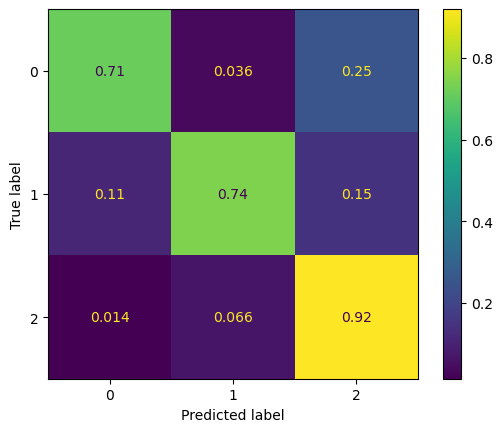

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.49624. Saving Model!
epoch 01, loss: 0.63805, acc: 0.73138, val_loss: 0.49624, val_accuracy: 0.80737


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


epoch 02, loss: 0.63062, acc: 0.72974, val_loss: 0.52250, val_accuracy: 0.79816


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


epoch 03, loss: 0.63663, acc: 0.73690, val_loss: 0.53642, val_accuracy: 0.79078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 04, loss: 0.62469, acc: 0.74621, val_loss: 0.58954, val_accuracy: 0.78433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 05, loss: 0.62953, acc: 0.74744, val_loss: 0.62713, val_accuracy: 0.78065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 06, loss: 0.62859, acc: 0.74959, val_loss: 0.62304, val_accuracy: 0.77419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 07, loss: 0.62039, acc: 0.75256, val_loss: 0.61975, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]

epoch 08, loss: 0.62573, acc: 0.75082, val_loss: 0.61879, val_accuracy: 0.76221

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 09, loss: 0.61906, acc: 0.74969, val_loss: 0.62927, val_accuracy: 0.76498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 10, loss: 0.61834, acc: 0.75266, val_loss: 0.62900, val_accuracy: 0.76682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 11, loss: 0.61928, acc: 0.75041, val_loss: 0.61267, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 12, loss: 0.61423, acc: 0.75440, val_loss: 0.61119, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 13, loss: 0.61619, acc: 0.75225, val_loss: 0.62541, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 14, loss: 0.61322, acc: 0.75358, val_loss: 0.65424, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 15, loss: 0.61139, acc: 0.75184, val_loss: 0.67177, val_accuracy: 0.76313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 16, loss: 0.61239, acc: 0.75471, val_loss: 0.66295, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 17, loss: 0.60904, acc: 0.75972, val_loss: 0.65388, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 18, loss: 0.60912, acc: 0.75808, val_loss: 0.65691, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


epoch 19, loss: 0.60799, acc: 0.75798, val_loss: 0.66875, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 20, loss: 0.60608, acc: 0.76208, val_loss: 0.67867, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 21, loss: 0.60646, acc: 0.76034, val_loss: 0.67021, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 22, loss: 0.60427, acc: 0.76034, val_loss: 0.66189, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 23, loss: 0.60380, acc: 0.76105, val_loss: 0.66506, val_accuracy: 0.74470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 24, loss: 0.60312, acc: 0.75972, val_loss: 0.67559, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 25, loss: 0.60137, acc: 0.76187, val_loss: 0.68184, val_accuracy: 0.74562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 26, loss: 0.60124, acc: 0.76228, val_loss: 0.67814, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 27, loss: 0.59974, acc: 0.76269, val_loss: 0.67468, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 28, loss: 0.59914, acc: 0.76279, val_loss: 0.67828, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 29, loss: 0.59839, acc: 0.76433, val_loss: 0.68758, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 30, loss: 0.59710, acc: 0.76555, val_loss: 0.69489, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 31, loss: 0.59682, acc: 0.76545, val_loss: 0.69285, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 32, loss: 0.59550, acc: 0.76525, val_loss: 0.69011, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 33, loss: 0.59496, acc: 0.76453, val_loss: 0.69387, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 34, loss: 0.59417, acc: 0.76484, val_loss: 0.70089, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 35, loss: 0.59319, acc: 0.76555, val_loss: 0.70431, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 36, loss: 0.59271, acc: 0.76494, val_loss: 0.70042, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 37, loss: 0.59163, acc: 0.76648, val_loss: 0.69844, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 38, loss: 0.59110, acc: 0.76699, val_loss: 0.70381, val_accuracy: 0.74470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 39, loss: 0.59012, acc: 0.76668, val_loss: 0.71232, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 40, loss: 0.58949, acc: 0.76709, val_loss: 0.71458, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 41, loss: 0.58873, acc: 0.76678, val_loss: 0.70998, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 42, loss: 0.58791, acc: 0.76688, val_loss: 0.70790, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 43, loss: 0.58731, acc: 0.76770, val_loss: 0.71121, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 44, loss: 0.58644, acc: 0.76760, val_loss: 0.71512, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 45, loss: 0.58584, acc: 0.76791, val_loss: 0.71425, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 46, loss: 0.58504, acc: 0.76903, val_loss: 0.71533, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 47, loss: 0.58437, acc: 0.76822, val_loss: 0.71787, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 48, loss: 0.58364, acc: 0.76811, val_loss: 0.72376, val_accuracy: 0.73641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 49, loss: 0.58293, acc: 0.77098, val_loss: 0.72690, val_accuracy: 0.73548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 50, loss: 0.58230, acc: 0.77077, val_loss: 0.72426, val_accuracy: 0.73641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 51, loss: 0.58154, acc: 0.76934, val_loss: 0.72369, val_accuracy: 0.73733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 52, loss: 0.58093, acc: 0.76985, val_loss: 0.72718, val_accuracy: 0.73825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 53, loss: 0.58021, acc: 0.77139, val_loss: 0.73046, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 54, loss: 0.57961, acc: 0.77200, val_loss: 0.72958, val_accuracy: 0.73825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 55, loss: 0.57893, acc: 0.77251, val_loss: 0.72954, val_accuracy: 0.73641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 56, loss: 0.57827, acc: 0.77169, val_loss: 0.73192, val_accuracy: 0.73733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 57, loss: 0.57763, acc: 0.77077, val_loss: 0.73423, val_accuracy: 0.73548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 58, loss: 0.57694, acc: 0.77231, val_loss: 0.73564, val_accuracy: 0.73733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 59, loss: 0.57632, acc: 0.77313, val_loss: 0.73504, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 60, loss: 0.57567, acc: 0.77364, val_loss: 0.73640, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 61, loss: 0.57505, acc: 0.77405, val_loss: 0.73831, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 62, loss: 0.57441, acc: 0.77569, val_loss: 0.73862, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 63, loss: 0.57380, acc: 0.77436, val_loss: 0.73680, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 64, loss: 0.57317, acc: 0.77558, val_loss: 0.73720, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 65, loss: 0.57255, acc: 0.77620, val_loss: 0.73926, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 66, loss: 0.57192, acc: 0.77661, val_loss: 0.74128, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


epoch 67, loss: 0.57128, acc: 0.77661, val_loss: 0.74227, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 68, loss: 0.57067, acc: 0.77671, val_loss: 0.74099, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 69, loss: 0.57006, acc: 0.77773, val_loss: 0.74140, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 70, loss: 0.56944, acc: 0.77773, val_loss: 0.74489, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 71, loss: 0.56882, acc: 0.77783, val_loss: 0.74657, val_accuracy: 0.73825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 72, loss: 0.56823, acc: 0.77743, val_loss: 0.74680, val_accuracy: 0.73825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 73, loss: 0.56761, acc: 0.77794, val_loss: 0.74860, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 74, loss: 0.56696, acc: 0.77886, val_loss: 0.75151, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 75, loss: 0.56637, acc: 0.77855, val_loss: 0.75040, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 76, loss: 0.56574, acc: 0.77906, val_loss: 0.75128, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 77, loss: 0.56515, acc: 0.77906, val_loss: 0.75388, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 78, loss: 0.56455, acc: 0.77886, val_loss: 0.75477, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 79, loss: 0.56394, acc: 0.77978, val_loss: 0.75627, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 80, loss: 0.56333, acc: 0.77998, val_loss: 0.75687, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 81, loss: 0.56273, acc: 0.78060, val_loss: 0.75697, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 82, loss: 0.56218, acc: 0.78090, val_loss: 0.75851, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 83, loss: 0.56156, acc: 0.78050, val_loss: 0.75992, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 84, loss: 0.56099, acc: 0.78039, val_loss: 0.76020, val_accuracy: 0.73917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 85, loss: 0.56041, acc: 0.78060, val_loss: 0.76117, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 86, loss: 0.55984, acc: 0.78101, val_loss: 0.76057, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 87, loss: 0.55925, acc: 0.78121, val_loss: 0.76106, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 88, loss: 0.55868, acc: 0.78172, val_loss: 0.76302, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 89, loss: 0.55808, acc: 0.78193, val_loss: 0.76506, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 90, loss: 0.55754, acc: 0.78162, val_loss: 0.76534, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 91, loss: 0.55699, acc: 0.78234, val_loss: 0.76776, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 92, loss: 0.55637, acc: 0.78285, val_loss: 0.76678, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 93, loss: 0.55583, acc: 0.78254, val_loss: 0.76695, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 94, loss: 0.55526, acc: 0.78295, val_loss: 0.76825, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 95, loss: 0.55469, acc: 0.78305, val_loss: 0.76961, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 96, loss: 0.55410, acc: 0.78254, val_loss: 0.76772, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 97, loss: 0.55354, acc: 0.78326, val_loss: 0.76855, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 98, loss: 0.55302, acc: 0.78357, val_loss: 0.77153, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 99, loss: 0.55247, acc: 0.78326, val_loss: 0.77167, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 100, loss: 0.55189, acc: 0.78346, val_loss: 0.77265, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 101, loss: 0.55134, acc: 0.78367, val_loss: 0.77497, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 102, loss: 0.55079, acc: 0.78357, val_loss: 0.77589, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 103, loss: 0.55021, acc: 0.78418, val_loss: 0.77634, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 104, loss: 0.54968, acc: 0.78459, val_loss: 0.77432, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 105, loss: 0.54910, acc: 0.78459, val_loss: 0.77601, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 106, loss: 0.54854, acc: 0.78520, val_loss: 0.77790, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 107, loss: 0.54802, acc: 0.78520, val_loss: 0.77640, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 108, loss: 0.54744, acc: 0.78541, val_loss: 0.77789, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 109, loss: 0.54687, acc: 0.78561, val_loss: 0.77914, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 110, loss: 0.54631, acc: 0.78541, val_loss: 0.78047, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 111, loss: 0.54579, acc: 0.78592, val_loss: 0.78229, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 112, loss: 0.54524, acc: 0.78592, val_loss: 0.78497, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 113, loss: 0.54468, acc: 0.78582, val_loss: 0.78753, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 114, loss: 0.54411, acc: 0.78592, val_loss: 0.78589, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 115, loss: 0.54359, acc: 0.78664, val_loss: 0.78318, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 116, loss: 0.54308, acc: 0.78664, val_loss: 0.78314, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 117, loss: 0.54252, acc: 0.78704, val_loss: 0.78330, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 118, loss: 0.54198, acc: 0.78735, val_loss: 0.78313, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 119, loss: 0.54150, acc: 0.78858, val_loss: 0.78458, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 120, loss: 0.54095, acc: 0.78776, val_loss: 0.78586, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 121, loss: 0.54046, acc: 0.78797, val_loss: 0.78527, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 122, loss: 0.53989, acc: 0.78786, val_loss: 0.78536, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 123, loss: 0.53938, acc: 0.78899, val_loss: 0.78812, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 124, loss: 0.53886, acc: 0.78735, val_loss: 0.78896, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 125, loss: 0.53830, acc: 0.78827, val_loss: 0.78740, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 126, loss: 0.53779, acc: 0.78909, val_loss: 0.78984, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 127, loss: 0.53721, acc: 0.78858, val_loss: 0.79109, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


epoch 128, loss: 0.53668, acc: 0.78889, val_loss: 0.79331, val_accuracy: 0.74286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.88it/s]


epoch 129, loss: 0.53613, acc: 0.78899, val_loss: 0.79437, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 130, loss: 0.53559, acc: 0.78899, val_loss: 0.79432, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 131, loss: 0.53508, acc: 0.78889, val_loss: 0.79419, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 132, loss: 0.53459, acc: 0.78899, val_loss: 0.79516, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 133, loss: 0.53404, acc: 0.78889, val_loss: 0.79515, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 134, loss: 0.53354, acc: 0.78930, val_loss: 0.79388, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 135, loss: 0.53303, acc: 0.78971, val_loss: 0.79562, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 136, loss: 0.53250, acc: 0.78940, val_loss: 0.79877, val_accuracy: 0.74470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 137, loss: 0.53200, acc: 0.78899, val_loss: 0.80019, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 138, loss: 0.53145, acc: 0.78940, val_loss: 0.80209, val_accuracy: 0.74378


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 139, loss: 0.53093, acc: 0.78950, val_loss: 0.80463, val_accuracy: 0.74470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 140, loss: 0.53040, acc: 0.78981, val_loss: 0.80163, val_accuracy: 0.74562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 141, loss: 0.52991, acc: 0.79063, val_loss: 0.80128, val_accuracy: 0.74562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 142, loss: 0.52941, acc: 0.79011, val_loss: 0.80342, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 143, loss: 0.52887, acc: 0.79237, val_loss: 0.80254, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 144, loss: 0.52834, acc: 0.79216, val_loss: 0.80413, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 145, loss: 0.52782, acc: 0.79298, val_loss: 0.80463, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 146, loss: 0.52734, acc: 0.79022, val_loss: 0.80621, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 147, loss: 0.52680, acc: 0.79022, val_loss: 0.80400, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 148, loss: 0.52624, acc: 0.79063, val_loss: 0.80532, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 149, loss: 0.52575, acc: 0.79093, val_loss: 0.80728, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 150, loss: 0.52524, acc: 0.79349, val_loss: 0.80758, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 151, loss: 0.52473, acc: 0.79411, val_loss: 0.80750, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 152, loss: 0.52426, acc: 0.79390, val_loss: 0.80934, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 153, loss: 0.52373, acc: 0.79431, val_loss: 0.80761, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 154, loss: 0.52322, acc: 0.79206, val_loss: 0.80755, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 155, loss: 0.52270, acc: 0.79237, val_loss: 0.80958, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 156, loss: 0.52224, acc: 0.79503, val_loss: 0.80867, val_accuracy: 0.74654


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 157, loss: 0.52173, acc: 0.79472, val_loss: 0.80855, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 158, loss: 0.52120, acc: 0.79237, val_loss: 0.81143, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 159, loss: 0.52076, acc: 0.79441, val_loss: 0.81019, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 160, loss: 0.52022, acc: 0.79533, val_loss: 0.81043, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 161, loss: 0.51972, acc: 0.79585, val_loss: 0.81365, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 162, loss: 0.51924, acc: 0.79564, val_loss: 0.81522, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 163, loss: 0.51875, acc: 0.79564, val_loss: 0.81364, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 164, loss: 0.51824, acc: 0.79687, val_loss: 0.81534, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 165, loss: 0.51775, acc: 0.79677, val_loss: 0.81738, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 166, loss: 0.51727, acc: 0.79656, val_loss: 0.81358, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 167, loss: 0.51677, acc: 0.79677, val_loss: 0.81335, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 168, loss: 0.51629, acc: 0.79697, val_loss: 0.81591, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 169, loss: 0.51584, acc: 0.79707, val_loss: 0.81389, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 170, loss: 0.51534, acc: 0.79799, val_loss: 0.81523, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 171, loss: 0.51484, acc: 0.79799, val_loss: 0.81808, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 172, loss: 0.51439, acc: 0.79758, val_loss: 0.81977, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]


epoch 173, loss: 0.51389, acc: 0.79748, val_loss: 0.81966, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 174, loss: 0.51339, acc: 0.79779, val_loss: 0.82043, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 175, loss: 0.51287, acc: 0.79810, val_loss: 0.82045, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 176, loss: 0.51245, acc: 0.79830, val_loss: 0.82005, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 177, loss: 0.51195, acc: 0.79820, val_loss: 0.81966, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 178, loss: 0.51147, acc: 0.79820, val_loss: 0.82193, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 179, loss: 0.51096, acc: 0.79840, val_loss: 0.82083, val_accuracy: 0.75023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 180, loss: 0.51050, acc: 0.79830, val_loss: 0.82042, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 181, loss: 0.51002, acc: 0.79871, val_loss: 0.82467, val_accuracy: 0.75207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 182, loss: 0.50953, acc: 0.79973, val_loss: 0.82588, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 183, loss: 0.50901, acc: 0.79943, val_loss: 0.82720, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 184, loss: 0.50856, acc: 0.79871, val_loss: 0.82562, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 185, loss: 0.50807, acc: 0.79922, val_loss: 0.82549, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 186, loss: 0.50757, acc: 0.79912, val_loss: 0.82626, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 187, loss: 0.50710, acc: 0.79963, val_loss: 0.82708, val_accuracy: 0.75207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 188, loss: 0.50663, acc: 0.80065, val_loss: 0.82709, val_accuracy: 0.75207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 189, loss: 0.50614, acc: 0.80055, val_loss: 0.82896, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 190, loss: 0.50567, acc: 0.80025, val_loss: 0.82808, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 191, loss: 0.50517, acc: 0.79963, val_loss: 0.82678, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 192, loss: 0.50469, acc: 0.80106, val_loss: 0.83073, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 193, loss: 0.50421, acc: 0.80137, val_loss: 0.82994, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 194, loss: 0.50373, acc: 0.80106, val_loss: 0.83255, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 195, loss: 0.50324, acc: 0.80158, val_loss: 0.83591, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 196, loss: 0.50278, acc: 0.80086, val_loss: 0.83442, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 197, loss: 0.50231, acc: 0.80239, val_loss: 0.83708, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 198, loss: 0.50182, acc: 0.80229, val_loss: 0.83738, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 199, loss: 0.50134, acc: 0.80250, val_loss: 0.83609, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 200, loss: 0.50089, acc: 0.80280, val_loss: 0.83745, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 201, loss: 0.50043, acc: 0.80270, val_loss: 0.83573, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 202, loss: 0.49995, acc: 0.80301, val_loss: 0.83597, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 203, loss: 0.49949, acc: 0.80465, val_loss: 0.84075, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 204, loss: 0.49905, acc: 0.80413, val_loss: 0.83979, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 205, loss: 0.49856, acc: 0.80475, val_loss: 0.83949, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 206, loss: 0.49809, acc: 0.80495, val_loss: 0.84221, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 207, loss: 0.49765, acc: 0.80526, val_loss: 0.84120, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 208, loss: 0.49719, acc: 0.80843, val_loss: 0.84110, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 209, loss: 0.49669, acc: 0.80813, val_loss: 0.84152, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 210, loss: 0.49627, acc: 0.80526, val_loss: 0.84034, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 211, loss: 0.49577, acc: 0.80833, val_loss: 0.84437, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 212, loss: 0.49531, acc: 0.80843, val_loss: 0.84564, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 213, loss: 0.49487, acc: 0.80905, val_loss: 0.84624, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 214, loss: 0.49437, acc: 0.80874, val_loss: 0.84622, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 215, loss: 0.49393, acc: 0.80894, val_loss: 0.84710, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 216, loss: 0.49349, acc: 0.80905, val_loss: 0.84719, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 217, loss: 0.49299, acc: 0.80925, val_loss: 0.84793, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 218, loss: 0.49252, acc: 0.81089, val_loss: 0.84793, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 219, loss: 0.49209, acc: 0.80956, val_loss: 0.84893, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 220, loss: 0.49161, acc: 0.81027, val_loss: 0.85047, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 221, loss: 0.49118, acc: 0.81027, val_loss: 0.84932, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 222, loss: 0.49072, acc: 0.81017, val_loss: 0.84992, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 223, loss: 0.49026, acc: 0.81048, val_loss: 0.85065, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 224, loss: 0.48981, acc: 0.81048, val_loss: 0.84990, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 225, loss: 0.48935, acc: 0.81038, val_loss: 0.85362, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 226, loss: 0.48892, acc: 0.81130, val_loss: 0.85108, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


epoch 227, loss: 0.48851, acc: 0.81079, val_loss: 0.85350, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 228, loss: 0.48806, acc: 0.81120, val_loss: 0.85469, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


epoch 229, loss: 0.48757, acc: 0.81130, val_loss: 0.85552, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


epoch 230, loss: 0.48715, acc: 0.81171, val_loss: 0.85852, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 231, loss: 0.48674, acc: 0.81109, val_loss: 0.85915, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 232, loss: 0.48631, acc: 0.81150, val_loss: 0.85697, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 233, loss: 0.48589, acc: 0.81171, val_loss: 0.85872, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 234, loss: 0.48541, acc: 0.81150, val_loss: 0.85711, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 235, loss: 0.48498, acc: 0.81242, val_loss: 0.85879, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 236, loss: 0.48458, acc: 0.81191, val_loss: 0.85647, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 237, loss: 0.48410, acc: 0.81293, val_loss: 0.85669, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 238, loss: 0.48364, acc: 0.81181, val_loss: 0.85724, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 239, loss: 0.48323, acc: 0.81201, val_loss: 0.85815, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 240, loss: 0.48281, acc: 0.81242, val_loss: 0.86097, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 241, loss: 0.48240, acc: 0.81283, val_loss: 0.85867, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 242, loss: 0.48192, acc: 0.81293, val_loss: 0.85723, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 243, loss: 0.48148, acc: 0.81386, val_loss: 0.85587, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 244, loss: 0.48109, acc: 0.81314, val_loss: 0.85558, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 245, loss: 0.48061, acc: 0.81304, val_loss: 0.85893, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 246, loss: 0.48021, acc: 0.81334, val_loss: 0.85670, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 247, loss: 0.47977, acc: 0.81334, val_loss: 0.86018, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 248, loss: 0.47933, acc: 0.81345, val_loss: 0.86127, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 249, loss: 0.47890, acc: 0.81386, val_loss: 0.85834, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 250, loss: 0.47847, acc: 0.81365, val_loss: 0.86131, val_accuracy: 0.75207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 251, loss: 0.47803, acc: 0.81396, val_loss: 0.86044, val_accuracy: 0.75207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 252, loss: 0.47759, acc: 0.81355, val_loss: 0.85768, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 253, loss: 0.47718, acc: 0.81375, val_loss: 0.86208, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 254, loss: 0.47677, acc: 0.81457, val_loss: 0.85997, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 255, loss: 0.47632, acc: 0.81457, val_loss: 0.86078, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 256, loss: 0.47590, acc: 0.81457, val_loss: 0.85969, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 257, loss: 0.47547, acc: 0.81498, val_loss: 0.85896, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 258, loss: 0.47501, acc: 0.81457, val_loss: 0.86013, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 259, loss: 0.47458, acc: 0.81529, val_loss: 0.86158, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 260, loss: 0.47420, acc: 0.81539, val_loss: 0.86139, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 261, loss: 0.47377, acc: 0.81539, val_loss: 0.86421, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 262, loss: 0.47332, acc: 0.81560, val_loss: 0.86453, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 263, loss: 0.47289, acc: 0.81590, val_loss: 0.86347, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 264, loss: 0.47243, acc: 0.81560, val_loss: 0.86291, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 265, loss: 0.47202, acc: 0.81560, val_loss: 0.85923, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 266, loss: 0.47158, acc: 0.81590, val_loss: 0.85943, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 267, loss: 0.47118, acc: 0.81570, val_loss: 0.86101, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 268, loss: 0.47078, acc: 0.81611, val_loss: 0.86262, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 269, loss: 0.47036, acc: 0.81621, val_loss: 0.86538, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 270, loss: 0.46993, acc: 0.81672, val_loss: 0.86501, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 271, loss: 0.46946, acc: 0.81652, val_loss: 0.86577, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 272, loss: 0.46903, acc: 0.81693, val_loss: 0.86797, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 273, loss: 0.46861, acc: 0.81734, val_loss: 0.86559, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 274, loss: 0.46821, acc: 0.81795, val_loss: 0.86756, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 275, loss: 0.46776, acc: 0.81815, val_loss: 0.86308, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 276, loss: 0.46735, acc: 0.81805, val_loss: 0.86929, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 277, loss: 0.46696, acc: 0.81795, val_loss: 0.86863, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 278, loss: 0.46656, acc: 0.81877, val_loss: 0.86948, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 279, loss: 0.46611, acc: 0.81856, val_loss: 0.86983, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 280, loss: 0.46570, acc: 0.81938, val_loss: 0.86256, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 281, loss: 0.46530, acc: 0.81959, val_loss: 0.86892, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 282, loss: 0.46484, acc: 0.82030, val_loss: 0.86584, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 283, loss: 0.46451, acc: 0.82041, val_loss: 0.86916, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


epoch 284, loss: 0.46417, acc: 0.81989, val_loss: 0.86961, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 285, loss: 0.46374, acc: 0.81969, val_loss: 0.87064, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


epoch 286, loss: 0.46327, acc: 0.81938, val_loss: 0.87019, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 287, loss: 0.46276, acc: 0.82061, val_loss: 0.86894, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 288, loss: 0.46241, acc: 0.82153, val_loss: 0.86652, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 289, loss: 0.46205, acc: 0.82071, val_loss: 0.86519, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 290, loss: 0.46169, acc: 0.82225, val_loss: 0.86959, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 291, loss: 0.46125, acc: 0.82122, val_loss: 0.86804, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 292, loss: 0.46079, acc: 0.82194, val_loss: 0.87194, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 293, loss: 0.46038, acc: 0.82296, val_loss: 0.86770, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 294, loss: 0.45992, acc: 0.82143, val_loss: 0.87181, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 295, loss: 0.45958, acc: 0.82348, val_loss: 0.87240, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 296, loss: 0.45919, acc: 0.82214, val_loss: 0.86774, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 297, loss: 0.45882, acc: 0.82307, val_loss: 0.87014, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 298, loss: 0.45847, acc: 0.82235, val_loss: 0.86445, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 299, loss: 0.45806, acc: 0.82358, val_loss: 0.87191, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 300, loss: 0.45762, acc: 0.82235, val_loss: 0.87095, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 301, loss: 0.45716, acc: 0.82348, val_loss: 0.87235, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 302, loss: 0.45676, acc: 0.82153, val_loss: 0.87328, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 303, loss: 0.45635, acc: 0.82440, val_loss: 0.87088, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 304, loss: 0.45591, acc: 0.82337, val_loss: 0.87015, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 305, loss: 0.45549, acc: 0.82368, val_loss: 0.86938, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 306, loss: 0.45509, acc: 0.82409, val_loss: 0.86772, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 307, loss: 0.45471, acc: 0.82337, val_loss: 0.87221, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 308, loss: 0.45433, acc: 0.82501, val_loss: 0.87310, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 309, loss: 0.45396, acc: 0.82296, val_loss: 0.87220, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 310, loss: 0.45357, acc: 0.82460, val_loss: 0.87487, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 311, loss: 0.45323, acc: 0.82317, val_loss: 0.87009, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 312, loss: 0.45288, acc: 0.82593, val_loss: 0.87866, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 313, loss: 0.45259, acc: 0.82255, val_loss: 0.86874, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 314, loss: 0.45226, acc: 0.82593, val_loss: 0.87772, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 315, loss: 0.45190, acc: 0.82286, val_loss: 0.86689, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 316, loss: 0.45153, acc: 0.82675, val_loss: 0.87555, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 317, loss: 0.45106, acc: 0.82214, val_loss: 0.87243, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 318, loss: 0.45063, acc: 0.82716, val_loss: 0.87301, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 319, loss: 0.45016, acc: 0.82368, val_loss: 0.87585, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 320, loss: 0.44968, acc: 0.82573, val_loss: 0.87153, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 321, loss: 0.44926, acc: 0.82399, val_loss: 0.87481, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 322, loss: 0.44880, acc: 0.82542, val_loss: 0.87201, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 323, loss: 0.44837, acc: 0.82460, val_loss: 0.87608, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 324, loss: 0.44795, acc: 0.82511, val_loss: 0.87683, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 325, loss: 0.44758, acc: 0.82511, val_loss: 0.87497, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 326, loss: 0.44718, acc: 0.82542, val_loss: 0.87580, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 327, loss: 0.44679, acc: 0.82675, val_loss: 0.87418, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 328, loss: 0.44638, acc: 0.82481, val_loss: 0.87098, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 329, loss: 0.44614, acc: 0.82757, val_loss: 0.87802, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 330, loss: 0.44598, acc: 0.82327, val_loss: 0.87091, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 331, loss: 0.44612, acc: 0.82828, val_loss: 0.88582, val_accuracy: 0.76406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 332, loss: 0.44643, acc: 0.82225, val_loss: 0.87094, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 333, loss: 0.44697, acc: 0.82634, val_loss: 0.88617, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


epoch 334, loss: 0.44746, acc: 0.82030, val_loss: 0.87627, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 335, loss: 0.44793, acc: 0.82532, val_loss: 0.88719, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 336, loss: 0.44804, acc: 0.81938, val_loss: 0.88815, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 337, loss: 0.44784, acc: 0.82624, val_loss: 0.87954, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 338, loss: 0.44687, acc: 0.82030, val_loss: 0.88705, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 339, loss: 0.44538, acc: 0.82685, val_loss: 0.87353, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 340, loss: 0.44340, acc: 0.82542, val_loss: 0.87652, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 341, loss: 0.44176, acc: 0.82941, val_loss: 0.88025, val_accuracy: 0.76498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 342, loss: 0.44108, acc: 0.82767, val_loss: 0.87122, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 343, loss: 0.44128, acc: 0.82593, val_loss: 0.88668, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 344, loss: 0.44178, acc: 0.82900, val_loss: 0.87307, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 345, loss: 0.44216, acc: 0.82511, val_loss: 0.88560, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 346, loss: 0.44235, acc: 0.82890, val_loss: 0.88505, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 347, loss: 0.44257, acc: 0.82153, val_loss: 0.87410, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 348, loss: 0.44304, acc: 0.82706, val_loss: 0.89950, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 349, loss: 0.44353, acc: 0.81979, val_loss: 0.87301, val_accuracy: 0.75484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 350, loss: 0.44375, acc: 0.82583, val_loss: 0.90738, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 351, loss: 0.44282, acc: 0.81969, val_loss: 0.87753, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 352, loss: 0.44116, acc: 0.82818, val_loss: 0.88642, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 353, loss: 0.43949, acc: 0.82419, val_loss: 0.89474, val_accuracy: 0.76313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 354, loss: 0.43841, acc: 0.83023, val_loss: 0.87214, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 355, loss: 0.43777, acc: 0.82931, val_loss: 0.90331, val_accuracy: 0.76959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 356, loss: 0.43754, acc: 0.82880, val_loss: 0.86699, val_accuracy: 0.75853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 357, loss: 0.43662, acc: 0.83033, val_loss: 0.90190, val_accuracy: 0.76866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 358, loss: 0.43586, acc: 0.82941, val_loss: 0.87595, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


epoch 359, loss: 0.43503, acc: 0.83084, val_loss: 0.88589, val_accuracy: 0.76498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 360, loss: 0.43457, acc: 0.82767, val_loss: 0.89289, val_accuracy: 0.76406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 361, loss: 0.43461, acc: 0.83279, val_loss: 0.88309, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 362, loss: 0.43494, acc: 0.82747, val_loss: 0.90821, val_accuracy: 0.76590


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 363, loss: 0.43579, acc: 0.82972, val_loss: 0.88228, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 364, loss: 0.43681, acc: 0.82695, val_loss: 0.90741, val_accuracy: 0.76682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 365, loss: 0.43908, acc: 0.82603, val_loss: 0.90633, val_accuracy: 0.75300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 366, loss: 0.44351, acc: 0.82122, val_loss: 0.91778, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 367, loss: 0.45264, acc: 0.81836, val_loss: 0.97579, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 368, loss: 0.46811, acc: 0.80792, val_loss: 0.95155, val_accuracy: 0.74101


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 369, loss: 0.48367, acc: 0.80270, val_loss: 1.02954, val_accuracy: 0.58341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 370, loss: 0.48078, acc: 0.79892, val_loss: 0.93728, val_accuracy: 0.59724


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 371, loss: 0.45583, acc: 0.81744, val_loss: 0.90126, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 372, loss: 0.43361, acc: 0.82880, val_loss: 0.94450, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 373, loss: 0.44260, acc: 0.81846, val_loss: 0.91322, val_accuracy: 0.74839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 374, loss: 0.46065, acc: 0.81437, val_loss: 0.97070, val_accuracy: 0.59171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 375, loss: 0.45478, acc: 0.81560, val_loss: 0.89910, val_accuracy: 0.76313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 376, loss: 0.43609, acc: 0.83043, val_loss: 0.88428, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 377, loss: 0.43180, acc: 0.83248, val_loss: 0.96202, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 378, loss: 0.44535, acc: 0.81856, val_loss: 0.90657, val_accuracy: 0.74747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 379, loss: 0.45391, acc: 0.81672, val_loss: 0.95700, val_accuracy: 0.59355


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 380, loss: 0.44431, acc: 0.82071, val_loss: 0.91182, val_accuracy: 0.76590


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 381, loss: 0.43060, acc: 0.83269, val_loss: 0.88558, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


epoch 382, loss: 0.43185, acc: 0.82992, val_loss: 0.97311, val_accuracy: 0.60092


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 383, loss: 0.44241, acc: 0.81938, val_loss: 0.88728, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 384, loss: 0.44342, acc: 0.82163, val_loss: 0.92961, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 385, loss: 0.43423, acc: 0.82266, val_loss: 0.91861, val_accuracy: 0.77143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 386, loss: 0.42750, acc: 0.83217, val_loss: 0.87704, val_accuracy: 0.75576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 387, loss: 0.43267, acc: 0.82972, val_loss: 0.97878, val_accuracy: 0.60553


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 388, loss: 0.43937, acc: 0.82153, val_loss: 0.89270, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 389, loss: 0.43571, acc: 0.82736, val_loss: 0.91928, val_accuracy: 0.76313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 390, loss: 0.42965, acc: 0.82685, val_loss: 0.94291, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 391, loss: 0.42773, acc: 0.82982, val_loss: 0.87337, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 392, loss: 0.43022, acc: 0.83054, val_loss: 0.95751, val_accuracy: 0.60645


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 393, loss: 0.43227, acc: 0.82583, val_loss: 0.88808, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 394, loss: 0.42780, acc: 0.83228, val_loss: 0.90008, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 395, loss: 0.42638, acc: 0.83043, val_loss: 0.94928, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 396, loss: 0.42789, acc: 0.83105, val_loss: 0.86950, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 397, loss: 0.42778, acc: 0.83115, val_loss: 0.94637, val_accuracy: 0.77327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 398, loss: 0.42647, acc: 0.83135, val_loss: 0.90274, val_accuracy: 0.76590


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 399, loss: 0.42267, acc: 0.83637, val_loss: 0.90211, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 400, loss: 0.42366, acc: 0.83269, val_loss: 0.95866, val_accuracy: 0.61290


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


epoch 401, loss: 0.42631, acc: 0.83217, val_loss: 0.87568, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 402, loss: 0.42573, acc: 0.83330, val_loss: 0.93645, val_accuracy: 0.61567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 403, loss: 0.42267, acc: 0.83616, val_loss: 0.91268, val_accuracy: 0.76774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 404, loss: 0.42034, acc: 0.83453, val_loss: 0.90276, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 405, loss: 0.42126, acc: 0.83545, val_loss: 0.96012, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 406, loss: 0.42306, acc: 0.83422, val_loss: 0.88831, val_accuracy: 0.75760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 407, loss: 0.42297, acc: 0.83545, val_loss: 0.94446, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 408, loss: 0.42059, acc: 0.83616, val_loss: 0.93059, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 409, loss: 0.41971, acc: 0.83350, val_loss: 0.91075, val_accuracy: 0.76406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 410, loss: 0.42020, acc: 0.83545, val_loss: 0.95977, val_accuracy: 0.77327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 411, loss: 0.42062, acc: 0.83371, val_loss: 0.90710, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 412, loss: 0.41978, acc: 0.83647, val_loss: 0.95227, val_accuracy: 0.76959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 413, loss: 0.41777, acc: 0.83698, val_loss: 0.93463, val_accuracy: 0.76774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 414, loss: 0.41692, acc: 0.83668, val_loss: 0.91710, val_accuracy: 0.76682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 415, loss: 0.41726, acc: 0.83760, val_loss: 0.95993, val_accuracy: 0.77143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 416, loss: 0.41793, acc: 0.83637, val_loss: 0.91703, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 417, loss: 0.41788, acc: 0.83606, val_loss: 0.96166, val_accuracy: 0.77143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 418, loss: 0.41694, acc: 0.83494, val_loss: 0.92666, val_accuracy: 0.76959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 419, loss: 0.41581, acc: 0.83780, val_loss: 0.92435, val_accuracy: 0.76682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 420, loss: 0.41551, acc: 0.83760, val_loss: 0.95503, val_accuracy: 0.61198


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 421, loss: 0.41604, acc: 0.83770, val_loss: 0.90855, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 422, loss: 0.41651, acc: 0.83637, val_loss: 0.96662, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 423, loss: 0.41762, acc: 0.83524, val_loss: 0.90074, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 424, loss: 0.41706, acc: 0.83576, val_loss: 0.96104, val_accuracy: 0.61567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 425, loss: 0.41691, acc: 0.83678, val_loss: 0.92891, val_accuracy: 0.76498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 426, loss: 0.41700, acc: 0.83299, val_loss: 0.94072, val_accuracy: 0.60645


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 427, loss: 0.41767, acc: 0.83668, val_loss: 0.96180, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 428, loss: 0.41967, acc: 0.82808, val_loss: 0.94133, val_accuracy: 0.60737


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 429, loss: 0.42224, acc: 0.83269, val_loss: 0.97944, val_accuracy: 0.59908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 430, loss: 0.42341, acc: 0.82685, val_loss: 0.95080, val_accuracy: 0.60829


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 431, loss: 0.42397, acc: 0.83269, val_loss: 0.95568, val_accuracy: 0.59539


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 432, loss: 0.42510, acc: 0.82562, val_loss: 0.98198, val_accuracy: 0.60922


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 433, loss: 0.42537, acc: 0.82972, val_loss: 0.93623, val_accuracy: 0.75668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 434, loss: 0.42442, acc: 0.82378, val_loss: 0.99165, val_accuracy: 0.61567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 435, loss: 0.42101, acc: 0.83402, val_loss: 0.91190, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 436, loss: 0.41519, acc: 0.83289, val_loss: 0.95914, val_accuracy: 0.77788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 437, loss: 0.41065, acc: 0.83893, val_loss: 0.94815, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 438, loss: 0.41020, acc: 0.84056, val_loss: 0.92540, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 439, loss: 0.41286, acc: 0.83637, val_loss: 0.96305, val_accuracy: 0.61290


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 440, loss: 0.41658, acc: 0.83524, val_loss: 0.91265, val_accuracy: 0.76037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 441, loss: 0.41783, acc: 0.82931, val_loss: 0.96380, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 442, loss: 0.41702, acc: 0.83545, val_loss: 0.94891, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 443, loss: 0.41616, acc: 0.82982, val_loss: 0.93697, val_accuracy: 0.76959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 444, loss: 0.41535, acc: 0.83555, val_loss: 0.97238, val_accuracy: 0.60461


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 445, loss: 0.41382, acc: 0.83033, val_loss: 0.92039, val_accuracy: 0.76682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 446, loss: 0.41186, acc: 0.83596, val_loss: 0.95951, val_accuracy: 0.77788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 447, loss: 0.40946, acc: 0.83668, val_loss: 0.90423, val_accuracy: 0.76498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]


epoch 448, loss: 0.40751, acc: 0.84036, val_loss: 0.94201, val_accuracy: 0.77788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 449, loss: 0.40694, acc: 0.84241, val_loss: 0.94664, val_accuracy: 0.76959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 450, loss: 0.40801, acc: 0.83821, val_loss: 0.93532, val_accuracy: 0.76866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 451, loss: 0.40981, acc: 0.83739, val_loss: 0.96874, val_accuracy: 0.60276


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 452, loss: 0.41174, acc: 0.83330, val_loss: 0.94186, val_accuracy: 0.77235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 453, loss: 0.41334, acc: 0.83576, val_loss: 0.98187, val_accuracy: 0.60184


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 454, loss: 0.41406, acc: 0.82972, val_loss: 0.95336, val_accuracy: 0.61198


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 455, loss: 0.41449, acc: 0.83442, val_loss: 0.94988, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 456, loss: 0.41476, acc: 0.82962, val_loss: 0.97970, val_accuracy: 0.61198


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 457, loss: 0.41516, acc: 0.83453, val_loss: 0.91786, val_accuracy: 0.75945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 458, loss: 0.41553, acc: 0.82880, val_loss: 0.99106, val_accuracy: 0.61935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 459, loss: 0.41522, acc: 0.83463, val_loss: 0.90162, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 460, loss: 0.40984, acc: 0.83279, val_loss: 0.96508, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 461, loss: 0.40463, acc: 0.84118, val_loss: 0.95121, val_accuracy: 0.77604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 462, loss: 0.40291, acc: 0.84271, val_loss: 0.91973, val_accuracy: 0.76682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 463, loss: 0.40474, acc: 0.83985, val_loss: 0.98074, val_accuracy: 0.61843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 464, loss: 0.40804, acc: 0.83893, val_loss: 0.91652, val_accuracy: 0.76313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 465, loss: 0.40865, acc: 0.83422, val_loss: 0.97087, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 466, loss: 0.40766, acc: 0.83698, val_loss: 0.95354, val_accuracy: 0.76498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 467, loss: 0.40692, acc: 0.83657, val_loss: 0.93736, val_accuracy: 0.77143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 468, loss: 0.40698, acc: 0.83790, val_loss: 0.99481, val_accuracy: 0.60645


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 469, loss: 0.40741, acc: 0.83463, val_loss: 0.92545, val_accuracy: 0.76590


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 470, loss: 0.40700, acc: 0.83749, val_loss: 0.98397, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 471, loss: 0.40495, acc: 0.83668, val_loss: 0.91564, val_accuracy: 0.77235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 472, loss: 0.40209, acc: 0.84353, val_loss: 0.95083, val_accuracy: 0.77696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 473, loss: 0.39987, acc: 0.84363, val_loss: 0.95387, val_accuracy: 0.77327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 474, loss: 0.39948, acc: 0.84363, val_loss: 0.93204, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 475, loss: 0.40027, acc: 0.84445, val_loss: 0.97372, val_accuracy: 0.77604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 476, loss: 0.40193, acc: 0.83995, val_loss: 0.92598, val_accuracy: 0.76866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 477, loss: 0.40359, acc: 0.84036, val_loss: 0.99820, val_accuracy: 0.60922


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 478, loss: 0.40479, acc: 0.83678, val_loss: 0.93029, val_accuracy: 0.76774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 479, loss: 0.40489, acc: 0.84036, val_loss: 0.97525, val_accuracy: 0.60369


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 480, loss: 0.40477, acc: 0.83565, val_loss: 0.95870, val_accuracy: 0.61567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 481, loss: 0.40555, acc: 0.83801, val_loss: 0.94788, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 482, loss: 0.40812, acc: 0.83156, val_loss: 1.00587, val_accuracy: 0.62028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 483, loss: 0.41299, acc: 0.83320, val_loss: 0.91670, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 484, loss: 0.41775, acc: 0.82429, val_loss: 1.03598, val_accuracy: 0.62212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 485, loss: 0.41891, acc: 0.83228, val_loss: 0.95762, val_accuracy: 0.75392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 486, loss: 0.41478, acc: 0.82614, val_loss: 0.97313, val_accuracy: 0.61014


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 487, loss: 0.40824, acc: 0.83514, val_loss: 0.99624, val_accuracy: 0.60737


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 488, loss: 0.40453, acc: 0.83535, val_loss: 0.91238, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 489, loss: 0.40422, acc: 0.83811, val_loss: 1.03424, val_accuracy: 0.62212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 490, loss: 0.40587, acc: 0.83821, val_loss: 0.89775, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 491, loss: 0.40100, acc: 0.83893, val_loss: 0.97244, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 492, loss: 0.39812, acc: 0.84353, val_loss: 0.98646, val_accuracy: 0.61014


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 493, loss: 0.39936, acc: 0.83954, val_loss: 0.91558, val_accuracy: 0.76313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


epoch 494, loss: 0.40344, acc: 0.83872, val_loss: 1.03719, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 495, loss: 0.40708, acc: 0.83637, val_loss: 0.91235, val_accuracy: 0.76221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 496, loss: 0.40146, acc: 0.83831, val_loss: 0.98200, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 497, loss: 0.39590, acc: 0.84149, val_loss: 0.96811, val_accuracy: 0.78157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 498, loss: 0.39460, acc: 0.84507, val_loss: 0.90566, val_accuracy: 0.76866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 499, loss: 0.39687, acc: 0.84261, val_loss: 1.02472, val_accuracy: 0.62120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 500, loss: 0.40075, acc: 0.84067, val_loss: 0.91960, val_accuracy: 0.76498
8번째 교차검증
evaluation loss: 0.49624, evaluation accuracy: 0.80737
(5, 1085)
(1085, 5)
Learning rate set to 0.065995
0:	learn: 1.0223453	total: 7.55ms	remaining: 7.54s
1:	learn: 0.9574939	total: 14.4ms	remaining: 7.2s
2:	learn: 0.9018342	total: 20.9ms	remaining: 6.95s
3:	learn: 0.8535101	total: 27.8ms	remaining: 6.92s
4:	learn: 0.8114159	total: 33.9ms	remaining: 6.75s
5:	learn: 0.7740643	total: 41.3ms	remaining: 6.84s
6:	learn: 0.7408583	total: 51ms	remaining: 7.23s
7:	learn: 0.7112243	total: 58.3ms	remaining: 7.23s
8:	learn: 0.6848420	total: 64.4ms	remaining: 7.1s
9:	learn: 0.6612869	total: 70.8ms	remaining: 7.01s
10:	learn: 0.6396123	total: 77.1ms	remaining: 6.93s
11:	learn: 0.6201592	total: 83.3ms	remaining: 6.86s
12:	learn: 0.6021608	total: 91ms	remaining: 6.91s
13:	learn: 0.5862482	total: 97.3ms	remaining: 6.85s
14:	learn: 0.5714309	total: 104ms	remaining: 6.83s
15:	learn: 0.5580286	total: 110ms	remainin

174:	learn: 0.3667344	total: 1.24s	remaining: 5.86s
175:	learn: 0.3666123	total: 1.25s	remaining: 5.86s
176:	learn: 0.3665316	total: 1.26s	remaining: 5.85s
177:	learn: 0.3664257	total: 1.26s	remaining: 5.84s
178:	learn: 0.3663558	total: 1.27s	remaining: 5.83s
179:	learn: 0.3662675	total: 1.28s	remaining: 5.83s
180:	learn: 0.3661559	total: 1.29s	remaining: 5.82s
181:	learn: 0.3660718	total: 1.29s	remaining: 5.81s
182:	learn: 0.3659640	total: 1.3s	remaining: 5.81s
183:	learn: 0.3658817	total: 1.31s	remaining: 5.81s
184:	learn: 0.3657853	total: 1.32s	remaining: 5.81s
185:	learn: 0.3657327	total: 1.32s	remaining: 5.8s
186:	learn: 0.3656674	total: 1.33s	remaining: 5.79s
187:	learn: 0.3655953	total: 1.34s	remaining: 5.79s
188:	learn: 0.3655288	total: 1.35s	remaining: 5.78s
189:	learn: 0.3654369	total: 1.35s	remaining: 5.78s
190:	learn: 0.3653737	total: 1.36s	remaining: 5.77s
191:	learn: 0.3652849	total: 1.37s	remaining: 5.76s
192:	learn: 0.3652191	total: 1.38s	remaining: 5.75s
193:	learn: 0.

343:	learn: 0.3589742	total: 2.48s	remaining: 4.73s
344:	learn: 0.3589541	total: 2.49s	remaining: 4.73s
345:	learn: 0.3589310	total: 2.5s	remaining: 4.72s
346:	learn: 0.3589101	total: 2.5s	remaining: 4.71s
347:	learn: 0.3588893	total: 2.51s	remaining: 4.71s
348:	learn: 0.3588719	total: 2.52s	remaining: 4.7s
349:	learn: 0.3588520	total: 2.53s	remaining: 4.69s
350:	learn: 0.3588320	total: 2.54s	remaining: 4.69s
351:	learn: 0.3588139	total: 2.54s	remaining: 4.68s
352:	learn: 0.3587961	total: 2.55s	remaining: 4.67s
353:	learn: 0.3587786	total: 2.56s	remaining: 4.67s
354:	learn: 0.3587612	total: 2.57s	remaining: 4.66s
355:	learn: 0.3587372	total: 2.57s	remaining: 4.66s
356:	learn: 0.3587180	total: 2.58s	remaining: 4.65s
357:	learn: 0.3587011	total: 2.59s	remaining: 4.64s
358:	learn: 0.3586844	total: 2.6s	remaining: 4.63s
359:	learn: 0.3586681	total: 2.6s	remaining: 4.63s
360:	learn: 0.3586506	total: 2.61s	remaining: 4.62s
361:	learn: 0.3586345	total: 2.62s	remaining: 4.61s
362:	learn: 0.358

519:	learn: 0.3566895	total: 3.93s	remaining: 3.63s
520:	learn: 0.3566817	total: 3.94s	remaining: 3.62s
521:	learn: 0.3566741	total: 3.95s	remaining: 3.61s
522:	learn: 0.3566679	total: 3.95s	remaining: 3.61s
523:	learn: 0.3566593	total: 3.96s	remaining: 3.6s
524:	learn: 0.3566504	total: 3.97s	remaining: 3.59s
525:	learn: 0.3566443	total: 3.98s	remaining: 3.58s
526:	learn: 0.3566360	total: 3.99s	remaining: 3.58s
527:	learn: 0.3566279	total: 4s	remaining: 3.57s
528:	learn: 0.3566188	total: 4.01s	remaining: 3.57s
529:	learn: 0.3566128	total: 4.01s	remaining: 3.56s
530:	learn: 0.3566047	total: 4.02s	remaining: 3.55s
531:	learn: 0.3565963	total: 4.03s	remaining: 3.54s
532:	learn: 0.3565879	total: 4.04s	remaining: 3.54s
533:	learn: 0.3565797	total: 4.04s	remaining: 3.53s
534:	learn: 0.3565738	total: 4.05s	remaining: 3.52s
535:	learn: 0.3565660	total: 4.06s	remaining: 3.52s
536:	learn: 0.3565604	total: 4.07s	remaining: 3.51s
537:	learn: 0.3565523	total: 4.08s	remaining: 3.5s
538:	learn: 0.356

679:	learn: 0.3557235	total: 5.38s	remaining: 2.53s
680:	learn: 0.3557201	total: 5.39s	remaining: 2.52s
681:	learn: 0.3557158	total: 5.4s	remaining: 2.52s
682:	learn: 0.3557099	total: 5.41s	remaining: 2.51s
683:	learn: 0.3557056	total: 5.41s	remaining: 2.5s
684:	learn: 0.3557014	total: 5.42s	remaining: 2.49s
685:	learn: 0.3556973	total: 5.43s	remaining: 2.49s
686:	learn: 0.3556920	total: 5.44s	remaining: 2.48s
687:	learn: 0.3556871	total: 5.45s	remaining: 2.47s
688:	learn: 0.3556837	total: 5.46s	remaining: 2.46s
689:	learn: 0.3556795	total: 5.47s	remaining: 2.46s
690:	learn: 0.3556764	total: 5.48s	remaining: 2.45s
691:	learn: 0.3556733	total: 5.49s	remaining: 2.44s
692:	learn: 0.3556696	total: 5.5s	remaining: 2.44s
693:	learn: 0.3556665	total: 5.51s	remaining: 2.43s
694:	learn: 0.3556618	total: 5.51s	remaining: 2.42s
695:	learn: 0.3556567	total: 5.52s	remaining: 2.41s
696:	learn: 0.3556534	total: 5.53s	remaining: 2.4s
697:	learn: 0.3556490	total: 5.54s	remaining: 2.4s
698:	learn: 0.355

860:	learn: 0.3551099	total: 7.05s	remaining: 1.14s
861:	learn: 0.3551080	total: 7.06s	remaining: 1.13s
862:	learn: 0.3551056	total: 7.07s	remaining: 1.12s
863:	learn: 0.3551022	total: 7.08s	remaining: 1.11s
864:	learn: 0.3550998	total: 7.09s	remaining: 1.11s
865:	learn: 0.3550978	total: 7.1s	remaining: 1.1s
866:	learn: 0.3550953	total: 7.11s	remaining: 1.09s
867:	learn: 0.3550925	total: 7.12s	remaining: 1.08s
868:	learn: 0.3550901	total: 7.13s	remaining: 1.07s
869:	learn: 0.3550881	total: 7.14s	remaining: 1.07s
870:	learn: 0.3550858	total: 7.14s	remaining: 1.06s
871:	learn: 0.3550822	total: 7.15s	remaining: 1.05s
872:	learn: 0.3550788	total: 7.16s	remaining: 1.04s
873:	learn: 0.3550769	total: 7.17s	remaining: 1.03s
874:	learn: 0.3550749	total: 7.18s	remaining: 1.02s
875:	learn: 0.3550727	total: 7.19s	remaining: 1.02s
876:	learn: 0.3550708	total: 7.2s	remaining: 1.01s
877:	learn: 0.3550688	total: 7.21s	remaining: 1s
878:	learn: 0.3550662	total: 7.22s	remaining: 994ms
879:	learn: 0.3550

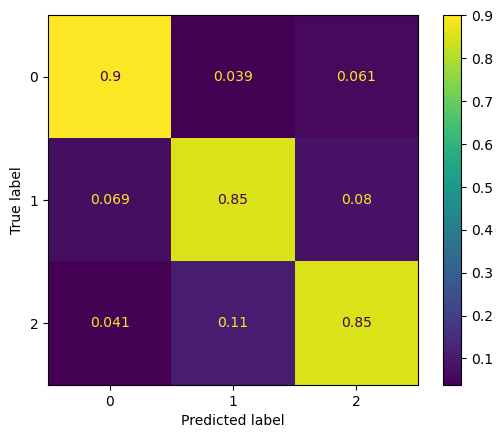

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.63446. Saving Model!
epoch 01, loss: 0.61603, acc: 0.73639, val_loss: 0.63446, val_accuracy: 0.75115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 02, loss: 0.61463, acc: 0.74048, val_loss: 0.65630, val_accuracy: 0.74194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 03, loss: 0.60927, acc: 0.75082, val_loss: 0.68605, val_accuracy: 0.72995


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 04, loss: 0.61124, acc: 0.75266, val_loss: 0.69228, val_accuracy: 0.72074


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 05, loss: 0.60686, acc: 0.75583, val_loss: 0.69025, val_accuracy: 0.71982


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 06, loss: 0.60478, acc: 0.75512, val_loss: 0.70143, val_accuracy: 0.70507


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 07, loss: 0.60431, acc: 0.75553, val_loss: 0.73064, val_accuracy: 0.66728


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 08, loss: 0.60032, acc: 0.75706, val_loss: 0.76267, val_accuracy: 0.66452


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 09, loss: 0.60119, acc: 0.75532, val_loss: 0.76796, val_accuracy: 0.66544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 10, loss: 0.59771, acc: 0.75808, val_loss: 0.76360, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 11, loss: 0.59659, acc: 0.76146, val_loss: 0.77329, val_accuracy: 0.64608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 12, loss: 0.59590, acc: 0.75829, val_loss: 0.80032, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 13, loss: 0.59306, acc: 0.76402, val_loss: 0.82470, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 14, loss: 0.59289, acc: 0.76535, val_loss: 0.82600, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 15, loss: 0.59099, acc: 0.76361, val_loss: 0.81772, val_accuracy: 0.64332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 16, loss: 0.58974, acc: 0.76208, val_loss: 0.82099, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 17, loss: 0.58890, acc: 0.76402, val_loss: 0.83767, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 18, loss: 0.58735, acc: 0.76545, val_loss: 0.85251, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 19, loss: 0.58655, acc: 0.76995, val_loss: 0.85491, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 20, loss: 0.58543, acc: 0.76903, val_loss: 0.85272, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 21, loss: 0.58416, acc: 0.77129, val_loss: 0.85948, val_accuracy: 0.64977


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


epoch 22, loss: 0.58337, acc: 0.77016, val_loss: 0.87487, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 23, loss: 0.58218, acc: 0.77026, val_loss: 0.88782, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 24, loss: 0.58135, acc: 0.76883, val_loss: 0.89159, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]


epoch 25, loss: 0.58033, acc: 0.76934, val_loss: 0.89044, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 26, loss: 0.57921, acc: 0.77221, val_loss: 0.89314, val_accuracy: 0.64793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 27, loss: 0.57862, acc: 0.77262, val_loss: 0.90078, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 28, loss: 0.57741, acc: 0.77292, val_loss: 0.90839, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 29, loss: 0.57678, acc: 0.77282, val_loss: 0.91052, val_accuracy: 0.65069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 30, loss: 0.57583, acc: 0.77292, val_loss: 0.91274, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


epoch 31, loss: 0.57496, acc: 0.77384, val_loss: 0.91786, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 32, loss: 0.57427, acc: 0.77487, val_loss: 0.92293, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 33, loss: 0.57322, acc: 0.77313, val_loss: 0.92681, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 34, loss: 0.57260, acc: 0.77333, val_loss: 0.92594, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 35, loss: 0.57162, acc: 0.77569, val_loss: 0.92563, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


epoch 36, loss: 0.57094, acc: 0.77579, val_loss: 0.92989, val_accuracy: 0.65161


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


epoch 37, loss: 0.57008, acc: 0.77743, val_loss: 0.93853, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 38, loss: 0.56929, acc: 0.77691, val_loss: 0.94436, val_accuracy: 0.65438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 39, loss: 0.56855, acc: 0.77538, val_loss: 0.94408, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


epoch 40, loss: 0.56768, acc: 0.77691, val_loss: 0.94197, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


epoch 41, loss: 0.56700, acc: 0.77804, val_loss: 0.94194, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 42, loss: 0.56622, acc: 0.77783, val_loss: 0.94645, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 43, loss: 0.56550, acc: 0.77743, val_loss: 0.94846, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.99it/s]


epoch 44, loss: 0.56480, acc: 0.77794, val_loss: 0.94757, val_accuracy: 0.65714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 45, loss: 0.56401, acc: 0.77845, val_loss: 0.94757, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 46, loss: 0.56337, acc: 0.77947, val_loss: 0.95100, val_accuracy: 0.65346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 47, loss: 0.56262, acc: 0.77916, val_loss: 0.95509, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.89it/s]


epoch 48, loss: 0.56193, acc: 0.77896, val_loss: 0.95518, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.97it/s]


epoch 49, loss: 0.56124, acc: 0.77988, val_loss: 0.95524, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 50, loss: 0.56054, acc: 0.78090, val_loss: 0.95859, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 51, loss: 0.55986, acc: 0.78090, val_loss: 0.96017, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 52, loss: 0.55914, acc: 0.78131, val_loss: 0.95899, val_accuracy: 0.65714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 53, loss: 0.55846, acc: 0.78101, val_loss: 0.95822, val_accuracy: 0.65714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 54, loss: 0.55780, acc: 0.78070, val_loss: 0.96051, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 55, loss: 0.55711, acc: 0.78039, val_loss: 0.96361, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 56, loss: 0.55646, acc: 0.78111, val_loss: 0.96496, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 57, loss: 0.55579, acc: 0.78131, val_loss: 0.96430, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 58, loss: 0.55513, acc: 0.78142, val_loss: 0.96582, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 59, loss: 0.55443, acc: 0.78152, val_loss: 0.96847, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 60, loss: 0.55374, acc: 0.78223, val_loss: 0.96824, val_accuracy: 0.65530


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 61, loss: 0.55309, acc: 0.78193, val_loss: 0.96729, val_accuracy: 0.65622


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 62, loss: 0.55244, acc: 0.78244, val_loss: 0.96930, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 63, loss: 0.55179, acc: 0.78285, val_loss: 0.97222, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 64, loss: 0.55113, acc: 0.78316, val_loss: 0.97355, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 65, loss: 0.55050, acc: 0.78387, val_loss: 0.97305, val_accuracy: 0.61198


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 66, loss: 0.54986, acc: 0.78490, val_loss: 0.97286, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 67, loss: 0.54920, acc: 0.78490, val_loss: 0.97419, val_accuracy: 0.61475


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 68, loss: 0.54856, acc: 0.78479, val_loss: 0.97373, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 69, loss: 0.54793, acc: 0.78530, val_loss: 0.97349, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 70, loss: 0.54729, acc: 0.78561, val_loss: 0.97396, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


epoch 71, loss: 0.54665, acc: 0.78551, val_loss: 0.97506, val_accuracy: 0.61290


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 72, loss: 0.54603, acc: 0.78530, val_loss: 0.97467, val_accuracy: 0.61198


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 73, loss: 0.54539, acc: 0.78592, val_loss: 0.97611, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 74, loss: 0.54472, acc: 0.78694, val_loss: 0.97800, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 75, loss: 0.54410, acc: 0.78704, val_loss: 0.97907, val_accuracy: 0.61382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


epoch 76, loss: 0.54345, acc: 0.78807, val_loss: 0.97857, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 77, loss: 0.54281, acc: 0.78919, val_loss: 0.97917, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 78, loss: 0.54219, acc: 0.78950, val_loss: 0.98236, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


epoch 79, loss: 0.54158, acc: 0.78930, val_loss: 0.98326, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 80, loss: 0.54097, acc: 0.78960, val_loss: 0.98175, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


epoch 81, loss: 0.54037, acc: 0.79063, val_loss: 0.98249, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 82, loss: 0.53977, acc: 0.79093, val_loss: 0.98430, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 83, loss: 0.53916, acc: 0.79032, val_loss: 0.98364, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 84, loss: 0.53860, acc: 0.79165, val_loss: 0.98459, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 85, loss: 0.53795, acc: 0.79073, val_loss: 0.98616, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 86, loss: 0.53737, acc: 0.79063, val_loss: 0.98623, val_accuracy: 0.61567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 87, loss: 0.53675, acc: 0.79032, val_loss: 0.98554, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 88, loss: 0.53615, acc: 0.79073, val_loss: 0.98694, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 89, loss: 0.53556, acc: 0.79134, val_loss: 0.98966, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 90, loss: 0.53496, acc: 0.79155, val_loss: 0.99037, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 91, loss: 0.53431, acc: 0.79206, val_loss: 0.99198, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 92, loss: 0.53374, acc: 0.79114, val_loss: 0.99082, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 93, loss: 0.53316, acc: 0.79032, val_loss: 0.99039, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 94, loss: 0.53257, acc: 0.79052, val_loss: 0.98975, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 95, loss: 0.53200, acc: 0.79093, val_loss: 0.99249, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


epoch 96, loss: 0.53138, acc: 0.79165, val_loss: 0.99442, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 97, loss: 0.53079, acc: 0.79175, val_loss: 0.99488, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 98, loss: 0.53023, acc: 0.79196, val_loss: 0.99598, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 99, loss: 0.52963, acc: 0.79175, val_loss: 0.99482, val_accuracy: 0.61567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 100, loss: 0.52909, acc: 0.79216, val_loss: 0.99668, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 101, loss: 0.52848, acc: 0.79206, val_loss: 0.99749, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 102, loss: 0.52793, acc: 0.79165, val_loss: 0.99768, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 103, loss: 0.52735, acc: 0.79278, val_loss: 0.99879, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 104, loss: 0.52679, acc: 0.79298, val_loss: 0.99845, val_accuracy: 0.61659


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 105, loss: 0.52624, acc: 0.79196, val_loss: 0.99931, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 106, loss: 0.52567, acc: 0.79318, val_loss: 1.00209, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 107, loss: 0.52514, acc: 0.79308, val_loss: 1.00123, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 108, loss: 0.52457, acc: 0.79308, val_loss: 0.99806, val_accuracy: 0.61843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 109, loss: 0.52400, acc: 0.79288, val_loss: 0.99923, val_accuracy: 0.61751


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 110, loss: 0.52345, acc: 0.79349, val_loss: 1.00268, val_accuracy: 0.61935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 111, loss: 0.52293, acc: 0.79267, val_loss: 1.00268, val_accuracy: 0.61843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 112, loss: 0.52236, acc: 0.79359, val_loss: 1.00149, val_accuracy: 0.61843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 113, loss: 0.52180, acc: 0.79349, val_loss: 1.00080, val_accuracy: 0.61935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 114, loss: 0.52126, acc: 0.79359, val_loss: 1.00262, val_accuracy: 0.61935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 115, loss: 0.52072, acc: 0.79329, val_loss: 1.00256, val_accuracy: 0.61935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


epoch 116, loss: 0.52019, acc: 0.79318, val_loss: 1.00248, val_accuracy: 0.61935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 117, loss: 0.51966, acc: 0.79451, val_loss: 1.00629, val_accuracy: 0.61843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 118, loss: 0.51911, acc: 0.79431, val_loss: 1.00442, val_accuracy: 0.61843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 119, loss: 0.51854, acc: 0.79421, val_loss: 1.00392, val_accuracy: 0.61843


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 120, loss: 0.51802, acc: 0.79441, val_loss: 1.00482, val_accuracy: 0.62028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 121, loss: 0.51748, acc: 0.79431, val_loss: 1.00608, val_accuracy: 0.62028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 122, loss: 0.51692, acc: 0.79451, val_loss: 1.00446, val_accuracy: 0.62028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 123, loss: 0.51640, acc: 0.79513, val_loss: 1.00685, val_accuracy: 0.62120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 124, loss: 0.51587, acc: 0.79513, val_loss: 1.00756, val_accuracy: 0.62120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 125, loss: 0.51533, acc: 0.79492, val_loss: 1.00863, val_accuracy: 0.62120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 126, loss: 0.51480, acc: 0.79605, val_loss: 1.00823, val_accuracy: 0.62212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 127, loss: 0.51426, acc: 0.79636, val_loss: 1.00987, val_accuracy: 0.62212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 128, loss: 0.51373, acc: 0.79544, val_loss: 1.01003, val_accuracy: 0.62304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 129, loss: 0.51319, acc: 0.79625, val_loss: 1.01135, val_accuracy: 0.62304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 130, loss: 0.51264, acc: 0.79636, val_loss: 1.01283, val_accuracy: 0.62120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 131, loss: 0.51212, acc: 0.79554, val_loss: 1.01423, val_accuracy: 0.62396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 132, loss: 0.51161, acc: 0.79605, val_loss: 1.01627, val_accuracy: 0.62488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s]


epoch 133, loss: 0.51108, acc: 0.79687, val_loss: 1.01757, val_accuracy: 0.62396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 134, loss: 0.51053, acc: 0.79636, val_loss: 1.01500, val_accuracy: 0.62304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 135, loss: 0.51003, acc: 0.79615, val_loss: 1.01611, val_accuracy: 0.62396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 136, loss: 0.50946, acc: 0.79605, val_loss: 1.01973, val_accuracy: 0.62396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 137, loss: 0.50897, acc: 0.79636, val_loss: 1.01849, val_accuracy: 0.62304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 138, loss: 0.50841, acc: 0.79564, val_loss: 1.02040, val_accuracy: 0.62488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 139, loss: 0.50785, acc: 0.79595, val_loss: 1.02394, val_accuracy: 0.62396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 140, loss: 0.50735, acc: 0.79605, val_loss: 1.02298, val_accuracy: 0.62673


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 141, loss: 0.50682, acc: 0.79697, val_loss: 1.02311, val_accuracy: 0.62673


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 142, loss: 0.50629, acc: 0.79728, val_loss: 1.02414, val_accuracy: 0.55023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 143, loss: 0.50576, acc: 0.79943, val_loss: 1.02712, val_accuracy: 0.55207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 144, loss: 0.50530, acc: 0.79963, val_loss: 1.02741, val_accuracy: 0.55207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 145, loss: 0.50474, acc: 0.80014, val_loss: 1.02818, val_accuracy: 0.55300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 146, loss: 0.50423, acc: 0.80045, val_loss: 1.02942, val_accuracy: 0.55207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 147, loss: 0.50370, acc: 0.80076, val_loss: 1.02882, val_accuracy: 0.55392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 148, loss: 0.50321, acc: 0.80076, val_loss: 1.03030, val_accuracy: 0.55392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


epoch 149, loss: 0.50270, acc: 0.80106, val_loss: 1.03180, val_accuracy: 0.55392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.49it/s]


epoch 150, loss: 0.50221, acc: 0.80106, val_loss: 1.03061, val_accuracy: 0.55392


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 151, loss: 0.50171, acc: 0.80188, val_loss: 1.03254, val_accuracy: 0.55300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 152, loss: 0.50118, acc: 0.80117, val_loss: 1.03193, val_accuracy: 0.55300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 153, loss: 0.50069, acc: 0.80209, val_loss: 1.03338, val_accuracy: 0.55484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 154, loss: 0.50016, acc: 0.80260, val_loss: 1.03524, val_accuracy: 0.55484


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 155, loss: 0.49966, acc: 0.80280, val_loss: 1.03620, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 156, loss: 0.49915, acc: 0.80229, val_loss: 1.03601, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 157, loss: 0.49863, acc: 0.80219, val_loss: 1.03830, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 158, loss: 0.49817, acc: 0.80291, val_loss: 1.04029, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 159, loss: 0.49763, acc: 0.80362, val_loss: 1.03830, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 160, loss: 0.49711, acc: 0.80362, val_loss: 1.03911, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 161, loss: 0.49664, acc: 0.80413, val_loss: 1.04167, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 162, loss: 0.49616, acc: 0.80372, val_loss: 1.04219, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 163, loss: 0.49565, acc: 0.80424, val_loss: 1.04122, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 164, loss: 0.49513, acc: 0.80506, val_loss: 1.04325, val_accuracy: 0.55576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 165, loss: 0.49465, acc: 0.80485, val_loss: 1.04386, val_accuracy: 0.55668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 166, loss: 0.49414, acc: 0.80516, val_loss: 1.04425, val_accuracy: 0.55668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 167, loss: 0.49367, acc: 0.80516, val_loss: 1.04747, val_accuracy: 0.55945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 168, loss: 0.49315, acc: 0.80690, val_loss: 1.04718, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 169, loss: 0.49263, acc: 0.80843, val_loss: 1.04626, val_accuracy: 0.55668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 170, loss: 0.49219, acc: 0.80608, val_loss: 1.04940, val_accuracy: 0.55945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 171, loss: 0.49169, acc: 0.80628, val_loss: 1.04995, val_accuracy: 0.55668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 172, loss: 0.49116, acc: 0.80639, val_loss: 1.05080, val_accuracy: 0.55668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 173, loss: 0.49067, acc: 0.80700, val_loss: 1.05181, val_accuracy: 0.55945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 174, loss: 0.49018, acc: 0.80884, val_loss: 1.04871, val_accuracy: 0.55945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 175, loss: 0.48966, acc: 0.80884, val_loss: 1.05220, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 176, loss: 0.48919, acc: 0.80966, val_loss: 1.05282, val_accuracy: 0.55853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 177, loss: 0.48869, acc: 0.80946, val_loss: 1.05179, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 178, loss: 0.48819, acc: 0.81038, val_loss: 1.05178, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 179, loss: 0.48772, acc: 0.80792, val_loss: 1.05266, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 180, loss: 0.48723, acc: 0.80997, val_loss: 1.05630, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 181, loss: 0.48673, acc: 0.81027, val_loss: 1.05903, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 182, loss: 0.48626, acc: 0.80782, val_loss: 1.06150, val_accuracy: 0.55945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 183, loss: 0.48579, acc: 0.81017, val_loss: 1.05943, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 184, loss: 0.48529, acc: 0.81038, val_loss: 1.05827, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 185, loss: 0.48483, acc: 0.81089, val_loss: 1.06279, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 186, loss: 0.48432, acc: 0.81120, val_loss: 1.06288, val_accuracy: 0.55760


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 187, loss: 0.48382, acc: 0.80823, val_loss: 1.06421, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 188, loss: 0.48334, acc: 0.81079, val_loss: 1.06637, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 189, loss: 0.48285, acc: 0.81038, val_loss: 1.06422, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 190, loss: 0.48237, acc: 0.81130, val_loss: 1.06789, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]


epoch 191, loss: 0.48186, acc: 0.81140, val_loss: 1.07045, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 192, loss: 0.48137, acc: 0.81150, val_loss: 1.07104, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 193, loss: 0.48090, acc: 0.81140, val_loss: 1.07437, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 194, loss: 0.48038, acc: 0.81201, val_loss: 1.07961, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 195, loss: 0.47989, acc: 0.81212, val_loss: 1.07593, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 196, loss: 0.47937, acc: 0.81263, val_loss: 1.07844, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 197, loss: 0.47889, acc: 0.81242, val_loss: 1.08209, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 198, loss: 0.47838, acc: 0.81283, val_loss: 1.07921, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 199, loss: 0.47794, acc: 0.81324, val_loss: 1.08205, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 200, loss: 0.47741, acc: 0.81273, val_loss: 1.08523, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 201, loss: 0.47691, acc: 0.81334, val_loss: 1.08472, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 202, loss: 0.47640, acc: 0.81386, val_loss: 1.09004, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 203, loss: 0.47594, acc: 0.81375, val_loss: 1.09147, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


epoch 204, loss: 0.47539, acc: 0.81386, val_loss: 1.08892, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 205, loss: 0.47491, acc: 0.81457, val_loss: 1.09296, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 206, loss: 0.47445, acc: 0.81467, val_loss: 1.09634, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 207, loss: 0.47394, acc: 0.81457, val_loss: 1.09368, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 208, loss: 0.47347, acc: 0.81467, val_loss: 1.09880, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 209, loss: 0.47296, acc: 0.81457, val_loss: 1.10071, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 210, loss: 0.47244, acc: 0.81488, val_loss: 1.10025, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 211, loss: 0.47198, acc: 0.81519, val_loss: 1.10947, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 212, loss: 0.47145, acc: 0.81488, val_loss: 1.10551, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 213, loss: 0.47094, acc: 0.81560, val_loss: 1.10440, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 214, loss: 0.47047, acc: 0.81478, val_loss: 1.11213, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 215, loss: 0.46995, acc: 0.81570, val_loss: 1.11343, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 216, loss: 0.46945, acc: 0.81590, val_loss: 1.11163, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 217, loss: 0.46896, acc: 0.81549, val_loss: 1.11934, val_accuracy: 0.56590


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 218, loss: 0.46849, acc: 0.81590, val_loss: 1.11503, val_accuracy: 0.55945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 219, loss: 0.46794, acc: 0.81611, val_loss: 1.11958, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 220, loss: 0.46746, acc: 0.81600, val_loss: 1.12511, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


epoch 221, loss: 0.46696, acc: 0.81672, val_loss: 1.11928, val_accuracy: 0.56037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 222, loss: 0.46647, acc: 0.81703, val_loss: 1.12757, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 223, loss: 0.46593, acc: 0.81682, val_loss: 1.13140, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 224, loss: 0.46548, acc: 0.81815, val_loss: 1.12315, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 225, loss: 0.46501, acc: 0.81846, val_loss: 1.13524, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 226, loss: 0.46452, acc: 0.81693, val_loss: 1.13312, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 227, loss: 0.46401, acc: 0.81846, val_loss: 1.13316, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 228, loss: 0.46351, acc: 0.81887, val_loss: 1.13773, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 229, loss: 0.46303, acc: 0.81856, val_loss: 1.13048, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 230, loss: 0.46251, acc: 0.81948, val_loss: 1.14142, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 231, loss: 0.46206, acc: 0.81764, val_loss: 1.14270, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 232, loss: 0.46156, acc: 0.82143, val_loss: 1.13628, val_accuracy: 0.56129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 233, loss: 0.46105, acc: 0.82000, val_loss: 1.14507, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


epoch 234, loss: 0.46055, acc: 0.82030, val_loss: 1.14333, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 235, loss: 0.46005, acc: 0.82245, val_loss: 1.14371, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


epoch 236, loss: 0.45957, acc: 0.81959, val_loss: 1.14723, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 237, loss: 0.45910, acc: 0.82174, val_loss: 1.15083, val_accuracy: 0.56590


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 238, loss: 0.45857, acc: 0.82276, val_loss: 1.15665, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 239, loss: 0.45808, acc: 0.82071, val_loss: 1.15987, val_accuracy: 0.56682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 240, loss: 0.45762, acc: 0.82296, val_loss: 1.15531, val_accuracy: 0.56682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 241, loss: 0.45718, acc: 0.82133, val_loss: 1.16406, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 242, loss: 0.45665, acc: 0.82368, val_loss: 1.16731, val_accuracy: 0.56866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 243, loss: 0.45612, acc: 0.82358, val_loss: 1.16257, val_accuracy: 0.56682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 244, loss: 0.45566, acc: 0.82255, val_loss: 1.16958, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 245, loss: 0.45522, acc: 0.82470, val_loss: 1.17070, val_accuracy: 0.56866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 246, loss: 0.45470, acc: 0.82255, val_loss: 1.17418, val_accuracy: 0.56774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 247, loss: 0.45419, acc: 0.82255, val_loss: 1.17703, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 248, loss: 0.45372, acc: 0.82521, val_loss: 1.17296, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


epoch 249, loss: 0.45327, acc: 0.82532, val_loss: 1.18277, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 250, loss: 0.45279, acc: 0.82562, val_loss: 1.18436, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 251, loss: 0.45225, acc: 0.82583, val_loss: 1.18238, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 252, loss: 0.45178, acc: 0.82552, val_loss: 1.18999, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 253, loss: 0.45131, acc: 0.82624, val_loss: 1.18809, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 254, loss: 0.45082, acc: 0.82378, val_loss: 1.19073, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 255, loss: 0.45036, acc: 0.82603, val_loss: 1.19348, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 256, loss: 0.44984, acc: 0.82603, val_loss: 1.19227, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 257, loss: 0.44934, acc: 0.82655, val_loss: 1.19944, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 258, loss: 0.44887, acc: 0.82706, val_loss: 1.19745, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 259, loss: 0.44841, acc: 0.82695, val_loss: 1.19606, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 260, loss: 0.44796, acc: 0.82685, val_loss: 1.20733, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 261, loss: 0.44751, acc: 0.82757, val_loss: 1.20131, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 262, loss: 0.44700, acc: 0.82716, val_loss: 1.21001, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 263, loss: 0.44652, acc: 0.82777, val_loss: 1.21048, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 264, loss: 0.44602, acc: 0.82808, val_loss: 1.20853, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 265, loss: 0.44558, acc: 0.82716, val_loss: 1.21487, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 266, loss: 0.44511, acc: 0.82818, val_loss: 1.21593, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 267, loss: 0.44463, acc: 0.82839, val_loss: 1.21551, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 268, loss: 0.44413, acc: 0.82869, val_loss: 1.22951, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 269, loss: 0.44371, acc: 0.82818, val_loss: 1.21309, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 270, loss: 0.44331, acc: 0.82818, val_loss: 1.23800, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


epoch 271, loss: 0.44289, acc: 0.82839, val_loss: 1.22118, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 272, loss: 0.44236, acc: 0.82880, val_loss: 1.23453, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 273, loss: 0.44185, acc: 0.82921, val_loss: 1.23922, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 274, loss: 0.44140, acc: 0.82951, val_loss: 1.22570, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 275, loss: 0.44102, acc: 0.83074, val_loss: 1.24661, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 276, loss: 0.44061, acc: 0.83023, val_loss: 1.22954, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 277, loss: 0.44012, acc: 0.83043, val_loss: 1.24740, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 278, loss: 0.43957, acc: 0.83043, val_loss: 1.24776, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


epoch 279, loss: 0.43914, acc: 0.83033, val_loss: 1.23607, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 280, loss: 0.43874, acc: 0.83095, val_loss: 1.25980, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 281, loss: 0.43835, acc: 0.83033, val_loss: 1.24153, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 282, loss: 0.43787, acc: 0.83074, val_loss: 1.25440, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 283, loss: 0.43736, acc: 0.83166, val_loss: 1.25829, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 284, loss: 0.43692, acc: 0.83258, val_loss: 1.25275, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 285, loss: 0.43649, acc: 0.83176, val_loss: 1.27055, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 286, loss: 0.43613, acc: 0.83095, val_loss: 1.25166, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 287, loss: 0.43575, acc: 0.83176, val_loss: 1.27766, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 288, loss: 0.43529, acc: 0.83217, val_loss: 1.26135, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 289, loss: 0.43483, acc: 0.83207, val_loss: 1.26941, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 290, loss: 0.43435, acc: 0.83320, val_loss: 1.27535, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 291, loss: 0.43391, acc: 0.83269, val_loss: 1.26940, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 292, loss: 0.43349, acc: 0.83289, val_loss: 1.28678, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 293, loss: 0.43312, acc: 0.83299, val_loss: 1.27235, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 294, loss: 0.43266, acc: 0.83279, val_loss: 1.29164, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 295, loss: 0.43220, acc: 0.83412, val_loss: 1.28453, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 296, loss: 0.43175, acc: 0.83228, val_loss: 1.28438, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 297, loss: 0.43132, acc: 0.83350, val_loss: 1.29332, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 298, loss: 0.43094, acc: 0.83238, val_loss: 1.28569, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 299, loss: 0.43059, acc: 0.83248, val_loss: 1.30018, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 300, loss: 0.43020, acc: 0.83381, val_loss: 1.28934, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 301, loss: 0.42982, acc: 0.83299, val_loss: 1.30604, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 302, loss: 0.42933, acc: 0.83350, val_loss: 1.29645, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 303, loss: 0.42884, acc: 0.83391, val_loss: 1.30574, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 304, loss: 0.42842, acc: 0.83371, val_loss: 1.30783, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 305, loss: 0.42797, acc: 0.83391, val_loss: 1.30711, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 306, loss: 0.42757, acc: 0.83340, val_loss: 1.31426, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 307, loss: 0.42714, acc: 0.83473, val_loss: 1.29934, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 308, loss: 0.42682, acc: 0.83371, val_loss: 1.32740, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 309, loss: 0.42649, acc: 0.83596, val_loss: 1.30256, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


epoch 310, loss: 0.42621, acc: 0.83340, val_loss: 1.33301, val_accuracy: 0.57696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 311, loss: 0.42583, acc: 0.83596, val_loss: 1.30703, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 312, loss: 0.42538, acc: 0.83412, val_loss: 1.33073, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 313, loss: 0.42494, acc: 0.83668, val_loss: 1.32547, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 314, loss: 0.42465, acc: 0.83361, val_loss: 1.32238, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 315, loss: 0.42434, acc: 0.83565, val_loss: 1.33480, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 316, loss: 0.42420, acc: 0.83402, val_loss: 1.32709, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 317, loss: 0.42370, acc: 0.83647, val_loss: 1.33786, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 318, loss: 0.42312, acc: 0.83483, val_loss: 1.33918, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 319, loss: 0.42249, acc: 0.83678, val_loss: 1.33096, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 320, loss: 0.42199, acc: 0.83535, val_loss: 1.34816, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


epoch 321, loss: 0.42154, acc: 0.83647, val_loss: 1.32938, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 322, loss: 0.42116, acc: 0.83627, val_loss: 1.35446, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 323, loss: 0.42081, acc: 0.83627, val_loss: 1.34398, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 324, loss: 0.42038, acc: 0.83709, val_loss: 1.35152, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


epoch 325, loss: 0.42000, acc: 0.83586, val_loss: 1.35755, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 326, loss: 0.41971, acc: 0.83811, val_loss: 1.34502, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 327, loss: 0.41949, acc: 0.83442, val_loss: 1.37540, val_accuracy: 0.57696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


epoch 328, loss: 0.41936, acc: 0.83862, val_loss: 1.34507, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 329, loss: 0.41924, acc: 0.83576, val_loss: 1.38260, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 330, loss: 0.41895, acc: 0.83944, val_loss: 1.34701, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 331, loss: 0.41858, acc: 0.83299, val_loss: 1.37728, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 332, loss: 0.41808, acc: 0.83964, val_loss: 1.36506, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 333, loss: 0.41760, acc: 0.83391, val_loss: 1.37504, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 334, loss: 0.41713, acc: 0.83852, val_loss: 1.37830, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 335, loss: 0.41670, acc: 0.83616, val_loss: 1.36646, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 336, loss: 0.41615, acc: 0.83862, val_loss: 1.38890, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 337, loss: 0.41561, acc: 0.83709, val_loss: 1.37989, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 338, loss: 0.41498, acc: 0.83770, val_loss: 1.38626, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 339, loss: 0.41444, acc: 0.83760, val_loss: 1.38986, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 340, loss: 0.41400, acc: 0.83821, val_loss: 1.38467, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 341, loss: 0.41368, acc: 0.83852, val_loss: 1.40396, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 342, loss: 0.41346, acc: 0.83852, val_loss: 1.37616, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 343, loss: 0.41325, acc: 0.83913, val_loss: 1.41209, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 344, loss: 0.41310, acc: 0.83780, val_loss: 1.38833, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 345, loss: 0.41283, acc: 0.84190, val_loss: 1.41466, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 346, loss: 0.41273, acc: 0.83678, val_loss: 1.39639, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 347, loss: 0.41258, acc: 0.83975, val_loss: 1.41010, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 348, loss: 0.41275, acc: 0.83299, val_loss: 1.42702, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 349, loss: 0.41341, acc: 0.83872, val_loss: 1.38558, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 350, loss: 0.41538, acc: 0.83258, val_loss: 1.46032, val_accuracy: 0.58249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 351, loss: 0.41937, acc: 0.83586, val_loss: 1.37603, val_accuracy: 0.56866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 352, loss: 0.42565, acc: 0.82399, val_loss: 1.49051, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 353, loss: 0.43207, acc: 0.83074, val_loss: 1.38746, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 354, loss: 0.43398, acc: 0.82163, val_loss: 1.45697, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 355, loss: 0.42882, acc: 0.82962, val_loss: 1.44423, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 356, loss: 0.41694, acc: 0.82992, val_loss: 1.39308, val_accuracy: 0.56866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 357, loss: 0.41066, acc: 0.84067, val_loss: 1.47073, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 358, loss: 0.41387, acc: 0.83852, val_loss: 1.38393, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 359, loss: 0.41959, acc: 0.83125, val_loss: 1.46398, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 360, loss: 0.42291, acc: 0.83381, val_loss: 1.46387, val_accuracy: 0.58341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


epoch 361, loss: 0.41945, acc: 0.82818, val_loss: 1.40319, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


epoch 362, loss: 0.41297, acc: 0.83862, val_loss: 1.47249, val_accuracy: 0.58802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 363, loss: 0.40904, acc: 0.83862, val_loss: 1.41562, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 364, loss: 0.40775, acc: 0.83923, val_loss: 1.44746, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 365, loss: 0.41084, acc: 0.83627, val_loss: 1.47503, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 366, loss: 0.41502, acc: 0.82931, val_loss: 1.41207, val_accuracy: 0.56221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 367, loss: 0.41380, acc: 0.83739, val_loss: 1.46661, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 368, loss: 0.40971, acc: 0.83473, val_loss: 1.45688, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 369, loss: 0.40527, acc: 0.84230, val_loss: 1.41888, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 370, loss: 0.40486, acc: 0.84271, val_loss: 1.48389, val_accuracy: 0.58802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 371, loss: 0.40733, acc: 0.83760, val_loss: 1.43181, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 372, loss: 0.40746, acc: 0.84251, val_loss: 1.46609, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 373, loss: 0.40684, acc: 0.83606, val_loss: 1.47230, val_accuracy: 0.58249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 374, loss: 0.40611, acc: 0.84077, val_loss: 1.40012, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 375, loss: 0.40619, acc: 0.83923, val_loss: 1.50386, val_accuracy: 0.58710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 376, loss: 0.40575, acc: 0.84200, val_loss: 1.42364, val_accuracy: 0.56866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 377, loss: 0.40381, acc: 0.84241, val_loss: 1.47979, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 378, loss: 0.40141, acc: 0.84537, val_loss: 1.46150, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 379, loss: 0.40067, acc: 0.84415, val_loss: 1.42578, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 380, loss: 0.40147, acc: 0.84537, val_loss: 1.51486, val_accuracy: 0.59078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 381, loss: 0.40255, acc: 0.84742, val_loss: 1.41944, val_accuracy: 0.56866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 382, loss: 0.40225, acc: 0.84343, val_loss: 1.49421, val_accuracy: 0.58894


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 383, loss: 0.40072, acc: 0.84640, val_loss: 1.46415, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 384, loss: 0.39978, acc: 0.84394, val_loss: 1.46167, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 385, loss: 0.39979, acc: 0.84517, val_loss: 1.50324, val_accuracy: 0.59078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


epoch 386, loss: 0.40072, acc: 0.84077, val_loss: 1.43889, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 387, loss: 0.40052, acc: 0.84722, val_loss: 1.51023, val_accuracy: 0.59078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 388, loss: 0.39948, acc: 0.84261, val_loss: 1.48289, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 389, loss: 0.39814, acc: 0.84599, val_loss: 1.46527, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 390, loss: 0.39745, acc: 0.84394, val_loss: 1.50713, val_accuracy: 0.58710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 391, loss: 0.39775, acc: 0.84783, val_loss: 1.45357, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 392, loss: 0.39781, acc: 0.84650, val_loss: 1.52911, val_accuracy: 0.58894


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 393, loss: 0.39777, acc: 0.84834, val_loss: 1.45308, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 394, loss: 0.39704, acc: 0.84660, val_loss: 1.50603, val_accuracy: 0.58710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 395, loss: 0.39629, acc: 0.84752, val_loss: 1.48379, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 396, loss: 0.39594, acc: 0.84343, val_loss: 1.49530, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 397, loss: 0.39631, acc: 0.84589, val_loss: 1.51042, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 398, loss: 0.39726, acc: 0.83913, val_loss: 1.48487, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 399, loss: 0.39848, acc: 0.84517, val_loss: 1.52930, val_accuracy: 0.58894


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 400, loss: 0.40059, acc: 0.83831, val_loss: 1.51450, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 401, loss: 0.40308, acc: 0.84230, val_loss: 1.50253, val_accuracy: 0.57880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 402, loss: 0.40691, acc: 0.83463, val_loss: 1.56737, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 403, loss: 0.41319, acc: 0.83903, val_loss: 1.47194, val_accuracy: 0.56313


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 404, loss: 0.41965, acc: 0.82900, val_loss: 1.62065, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 405, loss: 0.42243, acc: 0.83258, val_loss: 1.42714, val_accuracy: 0.55853


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


epoch 406, loss: 0.41687, acc: 0.82962, val_loss: 1.56737, val_accuracy: 0.58802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 407, loss: 0.40314, acc: 0.84067, val_loss: 1.51527, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 408, loss: 0.39296, acc: 0.84681, val_loss: 1.48540, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 409, loss: 0.39369, acc: 0.84752, val_loss: 1.56847, val_accuracy: 0.58894


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 410, loss: 0.40149, acc: 0.84128, val_loss: 1.44649, val_accuracy: 0.56590


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 411, loss: 0.40586, acc: 0.83524, val_loss: 1.55774, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 412, loss: 0.40458, acc: 0.84169, val_loss: 1.55259, val_accuracy: 0.58802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 413, loss: 0.40203, acc: 0.83709, val_loss: 1.46899, val_accuracy: 0.56406


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 414, loss: 0.40018, acc: 0.84271, val_loss: 1.60312, val_accuracy: 0.59631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 415, loss: 0.40139, acc: 0.84394, val_loss: 1.45475, val_accuracy: 0.56682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 416, loss: 0.39304, acc: 0.84650, val_loss: 1.53396, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 417, loss: 0.39060, acc: 0.85080, val_loss: 1.59009, val_accuracy: 0.59171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 418, loss: 0.39669, acc: 0.84210, val_loss: 1.45612, val_accuracy: 0.56682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 419, loss: 0.39822, acc: 0.84353, val_loss: 1.57429, val_accuracy: 0.59355


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 420, loss: 0.39848, acc: 0.84128, val_loss: 1.50493, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 421, loss: 0.39160, acc: 0.84896, val_loss: 1.49106, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 422, loss: 0.38934, acc: 0.85090, val_loss: 1.60618, val_accuracy: 0.59447


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 423, loss: 0.39349, acc: 0.84804, val_loss: 1.45999, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 424, loss: 0.39213, acc: 0.84844, val_loss: 1.56785, val_accuracy: 0.59078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 425, loss: 0.39020, acc: 0.85223, val_loss: 1.53024, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


epoch 426, loss: 0.38901, acc: 0.85059, val_loss: 1.48304, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 427, loss: 0.38879, acc: 0.85059, val_loss: 1.59650, val_accuracy: 0.59171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 428, loss: 0.39129, acc: 0.84875, val_loss: 1.49670, val_accuracy: 0.57696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 429, loss: 0.39134, acc: 0.84752, val_loss: 1.58560, val_accuracy: 0.58986


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 430, loss: 0.39026, acc: 0.85213, val_loss: 1.50661, val_accuracy: 0.57880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 431, loss: 0.39055, acc: 0.85070, val_loss: 1.52944, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 432, loss: 0.38945, acc: 0.84752, val_loss: 1.57281, val_accuracy: 0.59171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 433, loss: 0.38992, acc: 0.84456, val_loss: 1.53748, val_accuracy: 0.57880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 434, loss: 0.39006, acc: 0.85182, val_loss: 1.57121, val_accuracy: 0.59171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 435, loss: 0.38933, acc: 0.84844, val_loss: 1.51819, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 436, loss: 0.38804, acc: 0.84834, val_loss: 1.53579, val_accuracy: 0.58249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 437, loss: 0.38601, acc: 0.85121, val_loss: 1.58762, val_accuracy: 0.58894


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 438, loss: 0.38474, acc: 0.85162, val_loss: 1.50964, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 439, loss: 0.38643, acc: 0.85080, val_loss: 1.60257, val_accuracy: 0.59355


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


epoch 440, loss: 0.38632, acc: 0.85172, val_loss: 1.49640, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 441, loss: 0.38499, acc: 0.85244, val_loss: 1.57043, val_accuracy: 0.58986


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 442, loss: 0.38320, acc: 0.85295, val_loss: 1.56636, val_accuracy: 0.59263


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 443, loss: 0.38147, acc: 0.85233, val_loss: 1.51920, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


epoch 444, loss: 0.38364, acc: 0.85295, val_loss: 1.61698, val_accuracy: 0.59447


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 445, loss: 0.38434, acc: 0.85305, val_loss: 1.51704, val_accuracy: 0.57696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


epoch 446, loss: 0.38243, acc: 0.85141, val_loss: 1.56783, val_accuracy: 0.58710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 447, loss: 0.38136, acc: 0.85244, val_loss: 1.58899, val_accuracy: 0.59171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 448, loss: 0.38065, acc: 0.85356, val_loss: 1.52284, val_accuracy: 0.57419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 449, loss: 0.38357, acc: 0.85121, val_loss: 1.65045, val_accuracy: 0.59447


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 450, loss: 0.38535, acc: 0.85080, val_loss: 1.52101, val_accuracy: 0.57051


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 451, loss: 0.38585, acc: 0.84885, val_loss: 1.62154, val_accuracy: 0.58802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


epoch 452, loss: 0.38752, acc: 0.84722, val_loss: 1.57655, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 453, loss: 0.38932, acc: 0.84527, val_loss: 1.58448, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 454, loss: 0.39475, acc: 0.84486, val_loss: 1.64995, val_accuracy: 0.58986


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 455, loss: 0.40200, acc: 0.83821, val_loss: 1.60728, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 456, loss: 0.40238, acc: 0.83964, val_loss: 1.58537, val_accuracy: 0.57788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 457, loss: 0.39653, acc: 0.84159, val_loss: 1.66246, val_accuracy: 0.58986


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 458, loss: 0.38973, acc: 0.84640, val_loss: 1.49962, val_accuracy: 0.56959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 459, loss: 0.38652, acc: 0.84926, val_loss: 1.65610, val_accuracy: 0.59447


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


epoch 460, loss: 0.38196, acc: 0.85356, val_loss: 1.57899, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 461, loss: 0.37803, acc: 0.85336, val_loss: 1.57533, val_accuracy: 0.58249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 462, loss: 0.37976, acc: 0.85397, val_loss: 1.66333, val_accuracy: 0.59447


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


epoch 463, loss: 0.38493, acc: 0.84855, val_loss: 1.50030, val_accuracy: 0.56774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 464, loss: 0.38857, acc: 0.84660, val_loss: 1.66941, val_accuracy: 0.59263


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 465, loss: 0.38563, acc: 0.84722, val_loss: 1.59399, val_accuracy: 0.58249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 466, loss: 0.38340, acc: 0.85111, val_loss: 1.58521, val_accuracy: 0.57512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 467, loss: 0.38194, acc: 0.85141, val_loss: 1.64643, val_accuracy: 0.59539


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 468, loss: 0.38076, acc: 0.84916, val_loss: 1.56010, val_accuracy: 0.57972


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 469, loss: 0.37707, acc: 0.85407, val_loss: 1.63549, val_accuracy: 0.59171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 470, loss: 0.37435, acc: 0.85837, val_loss: 1.61126, val_accuracy: 0.58341


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 471, loss: 0.37401, acc: 0.85694, val_loss: 1.58804, val_accuracy: 0.57604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 472, loss: 0.37595, acc: 0.85274, val_loss: 1.64675, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 473, loss: 0.37724, acc: 0.85387, val_loss: 1.57796, val_accuracy: 0.57696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 474, loss: 0.37653, acc: 0.85561, val_loss: 1.62352, val_accuracy: 0.59078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 475, loss: 0.37527, acc: 0.85581, val_loss: 1.65152, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 476, loss: 0.37470, acc: 0.85366, val_loss: 1.58916, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 477, loss: 0.37439, acc: 0.85387, val_loss: 1.66324, val_accuracy: 0.59631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 478, loss: 0.37472, acc: 0.85735, val_loss: 1.56084, val_accuracy: 0.57880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


epoch 479, loss: 0.37354, acc: 0.85407, val_loss: 1.64622, val_accuracy: 0.59078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


epoch 480, loss: 0.37129, acc: 0.85806, val_loss: 1.64015, val_accuracy: 0.58802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


epoch 481, loss: 0.37064, acc: 0.86021, val_loss: 1.60693, val_accuracy: 0.58249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


epoch 482, loss: 0.37048, acc: 0.85878, val_loss: 1.65101, val_accuracy: 0.59355


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s]


epoch 483, loss: 0.37100, acc: 0.86093, val_loss: 1.59357, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


epoch 484, loss: 0.37086, acc: 0.85704, val_loss: 1.65967, val_accuracy: 0.59263


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 485, loss: 0.37049, acc: 0.85888, val_loss: 1.62202, val_accuracy: 0.58525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


epoch 486, loss: 0.37064, acc: 0.85765, val_loss: 1.63329, val_accuracy: 0.58802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 487, loss: 0.37114, acc: 0.85776, val_loss: 1.63557, val_accuracy: 0.58710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 488, loss: 0.37237, acc: 0.85684, val_loss: 1.64910, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


epoch 489, loss: 0.37435, acc: 0.85612, val_loss: 1.64293, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


epoch 490, loss: 0.37723, acc: 0.85284, val_loss: 1.68158, val_accuracy: 0.58249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 491, loss: 0.38173, acc: 0.85162, val_loss: 1.64233, val_accuracy: 0.57880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


epoch 492, loss: 0.38819, acc: 0.84282, val_loss: 1.73531, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 493, loss: 0.39620, acc: 0.84558, val_loss: 1.58894, val_accuracy: 0.57143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 494, loss: 0.40312, acc: 0.83453, val_loss: 1.75381, val_accuracy: 0.58433


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 495, loss: 0.40283, acc: 0.83934, val_loss: 1.62825, val_accuracy: 0.57235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 496, loss: 0.38951, acc: 0.84384, val_loss: 1.69233, val_accuracy: 0.59078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 497, loss: 0.37273, acc: 0.85602, val_loss: 1.64615, val_accuracy: 0.58710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 498, loss: 0.36769, acc: 0.85817, val_loss: 1.61265, val_accuracy: 0.58157


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 499, loss: 0.37441, acc: 0.85254, val_loss: 1.72187, val_accuracy: 0.58710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


epoch 500, loss: 0.38264, acc: 0.85080, val_loss: 1.61509, val_accuracy: 0.57696
9번째 교차검증
evaluation loss: 0.63446, evaluation accuracy: 0.75115
(5, 1085)
(1085, 5)
Learning rate set to 0.065995
0:	learn: 1.0317764	total: 7.9ms	remaining: 7.89s
1:	learn: 0.9747597	total: 14.1ms	remaining: 7.05s
2:	learn: 0.9254152	total: 21ms	remaining: 6.97s
3:	learn: 0.8824876	total: 27.6ms	remaining: 6.87s
4:	learn: 0.8447699	total: 34.2ms	remaining: 6.8s
5:	learn: 0.8113871	total: 40.6ms	remaining: 6.73s
6:	learn: 0.7816590	total: 47.4ms	remaining: 6.73s
7:	learn: 0.7550386	total: 54.2ms	remaining: 6.72s
8:	learn: 0.7311820	total: 60.7ms	remaining: 6.68s
9:	learn: 0.7096770	total: 66.9ms	remaining: 6.63s
10:	learn: 0.6902783	total: 74ms	remaining: 6.66s
11:	learn: 0.6727445	total: 80.4ms	remaining: 6.62s
12:	learn: 0.6569174	total: 89ms	remaining: 6.76s
13:	learn: 0.6424991	total: 95.2ms	remaining: 6.71s
14:	learn: 0.6292079	total: 101ms	remaining: 6.65s
15:	learn: 0.6171265	total: 108ms	remaining:

166:	learn: 0.4445246	total: 1.23s	remaining: 6.15s
167:	learn: 0.4444585	total: 1.24s	remaining: 6.15s
168:	learn: 0.4443692	total: 1.25s	remaining: 6.14s
169:	learn: 0.4442737	total: 1.26s	remaining: 6.14s
170:	learn: 0.4441858	total: 1.26s	remaining: 6.13s
171:	learn: 0.4441010	total: 1.27s	remaining: 6.13s
172:	learn: 0.4440352	total: 1.28s	remaining: 6.12s
173:	learn: 0.4439602	total: 1.29s	remaining: 6.11s
174:	learn: 0.4438894	total: 1.29s	remaining: 6.1s
175:	learn: 0.4437883	total: 1.3s	remaining: 6.1s
176:	learn: 0.4437172	total: 1.31s	remaining: 6.09s
177:	learn: 0.4436421	total: 1.32s	remaining: 6.09s
178:	learn: 0.4435602	total: 1.32s	remaining: 6.08s
179:	learn: 0.4434669	total: 1.33s	remaining: 6.08s
180:	learn: 0.4433890	total: 1.34s	remaining: 6.07s
181:	learn: 0.4433078	total: 1.35s	remaining: 6.05s
182:	learn: 0.4432288	total: 1.35s	remaining: 6.05s
183:	learn: 0.4431531	total: 1.36s	remaining: 6.04s
184:	learn: 0.4430777	total: 1.37s	remaining: 6.04s
185:	learn: 0.4

334:	learn: 0.4373891	total: 2.47s	remaining: 4.91s
335:	learn: 0.4373625	total: 2.48s	remaining: 4.9s
336:	learn: 0.4373375	total: 2.49s	remaining: 4.89s
337:	learn: 0.4373206	total: 2.49s	remaining: 4.88s
338:	learn: 0.4373005	total: 2.5s	remaining: 4.88s
339:	learn: 0.4372823	total: 2.51s	remaining: 4.87s
340:	learn: 0.4372655	total: 2.52s	remaining: 4.87s
341:	learn: 0.4372507	total: 2.52s	remaining: 4.86s
342:	learn: 0.4372314	total: 2.53s	remaining: 4.85s
343:	learn: 0.4372077	total: 2.54s	remaining: 4.84s
344:	learn: 0.4371902	total: 2.55s	remaining: 4.84s
345:	learn: 0.4371689	total: 2.56s	remaining: 4.83s
346:	learn: 0.4371526	total: 2.56s	remaining: 4.82s
347:	learn: 0.4371331	total: 2.57s	remaining: 4.82s
348:	learn: 0.4371150	total: 2.58s	remaining: 4.81s
349:	learn: 0.4370951	total: 2.58s	remaining: 4.8s
350:	learn: 0.4370729	total: 2.59s	remaining: 4.79s
351:	learn: 0.4370543	total: 2.6s	remaining: 4.78s
352:	learn: 0.4370382	total: 2.6s	remaining: 4.77s
353:	learn: 0.437

514:	learn: 0.4350317	total: 3.92s	remaining: 3.7s
515:	learn: 0.4350223	total: 3.93s	remaining: 3.69s
516:	learn: 0.4350158	total: 3.94s	remaining: 3.68s
517:	learn: 0.4350070	total: 3.95s	remaining: 3.68s
518:	learn: 0.4349977	total: 3.96s	remaining: 3.67s
519:	learn: 0.4349913	total: 3.97s	remaining: 3.66s
520:	learn: 0.4349841	total: 3.98s	remaining: 3.65s
521:	learn: 0.4349773	total: 3.98s	remaining: 3.65s
522:	learn: 0.4349682	total: 3.99s	remaining: 3.64s
523:	learn: 0.4349583	total: 4s	remaining: 3.64s
524:	learn: 0.4349519	total: 4.01s	remaining: 3.63s
525:	learn: 0.4349417	total: 4.02s	remaining: 3.62s
526:	learn: 0.4349340	total: 4.03s	remaining: 3.61s
527:	learn: 0.4349277	total: 4.03s	remaining: 3.6s
528:	learn: 0.4349182	total: 4.04s	remaining: 3.6s
529:	learn: 0.4349098	total: 4.05s	remaining: 3.59s
530:	learn: 0.4349021	total: 4.06s	remaining: 3.58s
531:	learn: 0.4348957	total: 4.07s	remaining: 3.58s
532:	learn: 0.4348894	total: 4.07s	remaining: 3.57s
533:	learn: 0.4348

679:	learn: 0.4339872	total: 5.37s	remaining: 2.53s
680:	learn: 0.4339805	total: 5.38s	remaining: 2.52s
681:	learn: 0.4339755	total: 5.39s	remaining: 2.51s
682:	learn: 0.4339700	total: 5.4s	remaining: 2.5s
683:	learn: 0.4339647	total: 5.41s	remaining: 2.5s
684:	learn: 0.4339607	total: 5.42s	remaining: 2.49s
685:	learn: 0.4339564	total: 5.43s	remaining: 2.48s
686:	learn: 0.4339507	total: 5.43s	remaining: 2.48s
687:	learn: 0.4339471	total: 5.44s	remaining: 2.47s
688:	learn: 0.4339425	total: 5.45s	remaining: 2.46s
689:	learn: 0.4339377	total: 5.46s	remaining: 2.45s
690:	learn: 0.4339323	total: 5.47s	remaining: 2.44s
691:	learn: 0.4339277	total: 5.48s	remaining: 2.44s
692:	learn: 0.4339226	total: 5.49s	remaining: 2.43s
693:	learn: 0.4339178	total: 5.5s	remaining: 2.42s
694:	learn: 0.4339130	total: 5.5s	remaining: 2.41s
695:	learn: 0.4339065	total: 5.51s	remaining: 2.41s
696:	learn: 0.4339011	total: 5.52s	remaining: 2.4s
697:	learn: 0.4338974	total: 5.53s	remaining: 2.39s
698:	learn: 0.4338

841:	learn: 0.4333692	total: 6.83s	remaining: 1.28s
842:	learn: 0.4333660	total: 6.85s	remaining: 1.28s
843:	learn: 0.4333631	total: 6.86s	remaining: 1.27s
844:	learn: 0.4333609	total: 6.87s	remaining: 1.26s
845:	learn: 0.4333559	total: 6.88s	remaining: 1.25s
846:	learn: 0.4333531	total: 6.89s	remaining: 1.24s
847:	learn: 0.4333485	total: 6.9s	remaining: 1.24s
848:	learn: 0.4333450	total: 6.91s	remaining: 1.23s
849:	learn: 0.4333428	total: 6.92s	remaining: 1.22s
850:	learn: 0.4333391	total: 6.94s	remaining: 1.21s
851:	learn: 0.4333358	total: 6.95s	remaining: 1.21s
852:	learn: 0.4333328	total: 6.96s	remaining: 1.2s
853:	learn: 0.4333305	total: 6.96s	remaining: 1.19s
854:	learn: 0.4333274	total: 6.97s	remaining: 1.18s
855:	learn: 0.4333250	total: 6.98s	remaining: 1.17s
856:	learn: 0.4333223	total: 6.99s	remaining: 1.17s
857:	learn: 0.4333196	total: 7s	remaining: 1.16s
858:	learn: 0.4333168	total: 7.01s	remaining: 1.15s
859:	learn: 0.4333138	total: 7.02s	remaining: 1.14s
860:	learn: 0.433

Stacking ensemble (ML+DNN): 1085
[9]Accuracy : 84.51612903225806
[9]F1score : 0.8451100008421292
[9]Precision : 0.8451375455337717
[9]Recall : 0.8451612903225807



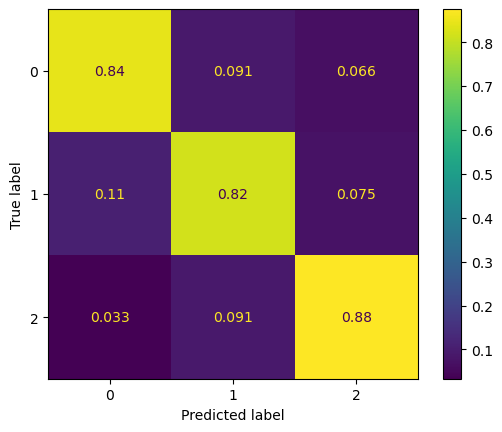

In [27]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 500
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel3.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel3.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LogisticRegression
    lr = LogisticRegression(solver='liblinear', random_state=0)
    lr.fit(X_train, y_train)
    linear_pred = lr.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # RidgeClassifier
    clf = RidgeClassifier(alpha=1.0)
    clf.fit(X_train, y_train)
    ridge_pred = clf.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GradientBoostingClassifier
    reg = GradientBoostingClassifier(random_state=0)
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
    new_data = np.array([linear_pred.squeeze(),ridge_pred.squeeze(),regr_pred.squeeze(),reg_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(CatBoost_pred))
    
    
    accuracy=accuracy_score(y_test, CatBoost_pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,CatBoost_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,CatBoost_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, CatBoost_pred)

    cm = confusion_matrix(y_test, CatBoost_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig("./ConfusionMatrix_reward3/"+filename+".png")
    plt.show()
    
    i=i+1

In [28]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

,Accuracy,F1-Score,Precision,Recall
0,73.756906,0.736575,0.742328,0.737569
1,75.138122,0.749740,0.763965,0.751381
2,78.453039,0.785213,0.799776,0.784530
3,81.215470,0.811279,0.812757,0.812155
4,85.359116,0.853515,0.855150,0.853591
5,80.847145,0.806700,0.809993,0.808471
6,87.200737,0.871640,0.872485,0.872007
7,79.170507,0.791500,0.809359,0.791705
8,86.728111,0.867204,0.867156,0.867281
9,84.516129,0.845110,0.845138,0.845161


In [29]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./ConfusionMatrix_reward3/PFMatrix_ensemble2_final2_grid_reward3.xlsx')

In [30]:
new_data

array([[0, 0, 2, 0, 2],
       [0, 0, 2, 0, 2],
       [0, 0, 2, 0, 2],
       ...,
       [0, 0, 2, 2, 2],
       [1, 1, 2, 2, 2],
       [2, 2, 2, 2, 2]], dtype=int64)

In [31]:
lgbm_pred

NameError: name 'lgbm_pred' is not defined

In [ ]:
y_test